In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from scipy import misc
import numpy as np
import glob
import matplotlib.pyplot as plt
from network import Network
from circle_generator import Circles
from dataset import SegmentationDataset
from loss import SegmentationLoss, ImageLoss
from unet import Unet

### Train on HeLa dataset

In [2]:
def train(num_epochs, batch_size, num_workers):
    transformed_dataset = SegmentationDataset(path_to_images='./datasets/HeLa/01/',
                                              path_to_segm='./datasets/HeLa/01_GT/SEG/', 
                                              transform=transforms.Compose([
                                                  ToTensor(), 
                                                  Normalize()
                                              ]))
    dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=num_workers)
    
    net = network()
    segm_loss = SegmentationLoss()
    img_loss = ImageLoss()
    z_input = Variable(torch.randn(84, 1, 512, 512), requires_grad=True)
    optimizer = optim.Adam([z_input] + list(net.parameters()), lr=0.1)
    
    for epoch in range(num_epochs):
        
        for data in dataloader:
            gt_img = Variable(data['image'])
            idx = data['idx']
            
            optimizer.zero_grad()
            img, segm = net(z_input[idx])
            loss = img_loss(img, gt_img)
            loss.backward()
            optimizer.step()
        

In [ ]:
train(1, 2, 1)

### circles example

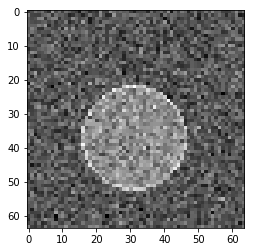

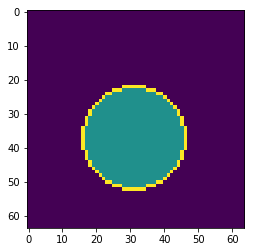

In [2]:
predata = Circles(radius=12, bg_color=0, perim_color=0.2, circle_color=0.1,
                  size=(64, 64), n_obj=5, var_n_obj=1, var_size=5, maxover=0)
x, y = predata.get_train_batch(1)
plt.imshow(x[0, 0],cmap='gray')
plt.figure()
plt.imshow(y[0])
plt.show()

## Training circles

In [3]:
def show_image_segm(gen_img, gen_segm, real_img, real_segm):
    for i, image in enumerate(gen_img):
        f, axarr = plt.subplots(2, 2, figsize=(10, 10))
        axarr[0, 0].imshow(image[0], cmap='gray')
        axarr[0, 0].set_title('Gen image')
        axarr[0, 1].imshow(real_img[i][0], cmap='gray')
        axarr[0, 1].set_title('Real image')
        axarr[1, 0].imshow(np.argmax(gen_segm[i], 0))
        axarr[1, 0].set_title('Gen segmentation')
        axarr[1, 1].imshow(real_segm[i])
        axarr[1, 1].set_title('Real segmentation')
    plt.show()

### Generate train batch

In [4]:
batch_size = 40

In [5]:
np.random.seed(42)
train_images, train_segmentation = predata.get_train_batch(batch_size)

In [6]:
train_images = Variable(torch.from_numpy(train_images).float().cuda(), requires_grad=False)
train_segmentation = Variable(torch.from_numpy(train_segmentation).cuda(), requires_grad=False)

In [7]:
net = Network(num_z_channels=3, num_classes=3).cuda()
segm_loss = SegmentationLoss()
img_loss = ImageLoss()

### create latent variable

In [8]:
torch.manual_seed(42)
z_input = Variable(torch.randn(batch_size, 3, 64, 64).cuda(), requires_grad=True)

### Training

In [9]:
def normalize_z(z):
    norm_z = z.data.norm(dim=1, p=2)
    norm_z = norm_z.unsqueeze(dim=1)
    norm_z = norm_z.repeat(1, 3, 1, 1)
    norm_z.clamp_(min=1.0)
    z.data = z.data / norm_z

In [10]:
without_segmentation = 1

In [11]:
def plot_segmentation(segm, gt_segm, num_epoch):
    segm_numpy = segm.data.cpu().numpy()
    gt_segm_numpy = gt_segm.data.cpu().numpy()
    for i, image in enumerate(segm_numpy):
        f, axarr = plt.subplots(1, 2, figsize=(10, 5))
        axarr[0].imshow(np.argmax(image, 0))
        axarr[0].set_title('Gen segmentation, epoch = {}'.format(num_epoch))
        axarr[1].imshow(gt_segm_numpy[i])
        axarr[1].set_title('Real segmentation')
    plt.show()

In [20]:
def train(net, train_images, train_segmentation, z_input, segm_loss, img_loss, without_segmentation):
    optimizer = optim.Adam([z_input] + list(net.parameters()), lr=0.01)

    loss_epoch = []
    num_epochs = 10000
    print_history = 50
    segmentation_loss = []

    for epoch in range(num_epochs):
        normalize_z(z_input)
        optimizer.zero_grad()   
        img, segm = net(z_input)

        if epoch % print_history == 0:
            plot_segmentation(segm[-1:], 
                              train_segmentation[-1:], 
                              epoch)

        loss = segm_loss(segm[:-without_segmentation], 
                         train_segmentation[:-without_segmentation]) + 1000 * img_loss(img, train_images)
        loss_epoch.append(loss.data)
        segmentation_loss.append(segm_loss(segm[-10:],
                                           train_segmentation[-10:]).data[0])

        loss.backward()
        optimizer.step()
        print('epoch - {}, loss - {}'.format(epoch, loss.data.cpu().numpy()[0]))

    normalize_z(z_input)
    return loss_epoch, segmentation_loss

In [21]:
def generate_and_train(network_class):
    batch_size = 25
    tr_images, tr_segmentation = predata.get_train_batch(batch_size)
    train_images = Variable(torch.from_numpy(tr_images).float().cuda(), requires_grad=False)
    train_segmentation = Variable(torch.from_numpy(tr_segmentation).cuda(), requires_grad=False)
    net = network_class(num_z_channels=3, num_classes=3).cuda()
    segm_loss = SegmentationLoss()
    img_loss = ImageLoss()
    z_input = Variable(torch.randn(batch_size, 3, 64, 64).cuda(), requires_grad=True)
    loss_10, segm_loss_10 = train(net=net, z_input=z_input, segm_loss=segm_loss, 
                                  img_loss=img_loss, without_segmentation=10, 
                                  train_images=train_images, 
                                  train_segmentation=train_segmentation)
    
    batch_size = 115
    additional_tr_images, additional_tr_segmentation = predata.get_train_batch(90)
    tr_images = np.concatenate((tr_images[:15], additional_tr_images, tr_images[15:]), axis=0)
    tr_segmentation = np.concatenate((tr_segmentation[:15], additional_tr_segmentation, 
                                      tr_segmentation[15:]), axis=0)
    
    train_images = Variable(torch.from_numpy(tr_images).float().cuda(), requires_grad=False)
    train_segmentation = Variable(torch.from_numpy(tr_segmentation).cuda(), requires_grad=False)
    net = network_class(num_z_channels=3, num_classes=3).cuda()
    z_input = Variable(torch.randn(batch_size, 3, 64, 64).cuda(), requires_grad=True)
    loss_100, segm_loss_100 = train(net=net, z_input=z_input, segm_loss=segm_loss, 
                                    img_loss=img_loss, without_segmentation=100, 
                                    train_images=train_images, 
                                    train_segmentation=train_segmentation)
    return loss_10, loss_100, segm_loss_10, segm_loss_100

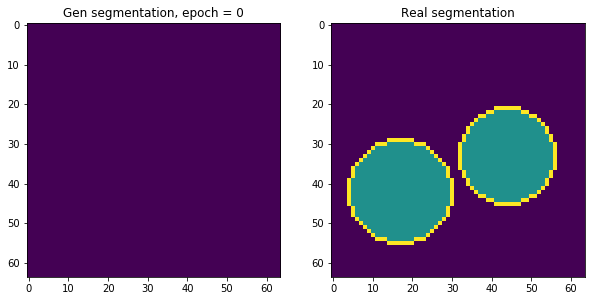

epoch - 0, loss - 6.87568235397
epoch - 1, loss - 25.7822437286
epoch - 2, loss - 6.98602199554
epoch - 3, loss - 6.5875377655
epoch - 4, loss - 6.82738780975
epoch - 5, loss - 6.72454118729
epoch - 6, loss - 6.50114059448
epoch - 7, loss - 6.52453804016
epoch - 8, loss - 6.49144649506
epoch - 9, loss - 6.37174272537
epoch - 10, loss - 6.35305595398
epoch - 11, loss - 6.34811544418
epoch - 12, loss - 6.27602338791
epoch - 13, loss - 6.18825626373
epoch - 14, loss - 6.1472902298
epoch - 15, loss - 6.0965795517
epoch - 16, loss - 6.08230638504
epoch - 17, loss - 6.11773729324
epoch - 18, loss - 6.08475732803
epoch - 19, loss - 6.08843231201
epoch - 20, loss - 6.03314113617
epoch - 21, loss - 6.01691770554
epoch - 22, loss - 5.99313020706
epoch - 23, loss - 5.98035430908
epoch - 24, loss - 5.97777700424
epoch - 25, loss - 5.96085786819
epoch - 26, loss - 5.96279716492
epoch - 27, loss - 5.94690084457
epoch - 28, loss - 5.93834114075
epoch - 29, loss - 5.92445850372
epoch - 30, loss - 5.90

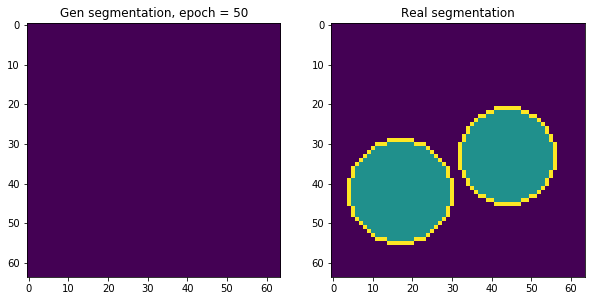

epoch - 50, loss - 5.81185770035
epoch - 51, loss - 5.79588460922
epoch - 52, loss - 5.76626396179
epoch - 53, loss - 5.78229188919
epoch - 54, loss - 5.75484132767
epoch - 55, loss - 5.74164247513
epoch - 56, loss - 5.74826002121
epoch - 57, loss - 5.71857976913
epoch - 58, loss - 5.72093963623
epoch - 59, loss - 5.69866132736
epoch - 60, loss - 5.69167661667
epoch - 61, loss - 5.66352319717
epoch - 62, loss - 5.66678476334
epoch - 63, loss - 5.64009952545
epoch - 64, loss - 5.62743377686
epoch - 65, loss - 5.6313867569
epoch - 66, loss - 5.66589355469
epoch - 67, loss - 5.84383583069
epoch - 68, loss - 5.80612897873
epoch - 69, loss - 5.58443164825
epoch - 70, loss - 5.63225078583
epoch - 71, loss - 5.62364292145
epoch - 72, loss - 5.54233217239
epoch - 73, loss - 5.60291194916
epoch - 74, loss - 5.50884246826
epoch - 75, loss - 5.56543159485
epoch - 76, loss - 5.48822975159
epoch - 77, loss - 5.50271701813
epoch - 78, loss - 5.47101449966
epoch - 79, loss - 5.42650032043
epoch - 80,

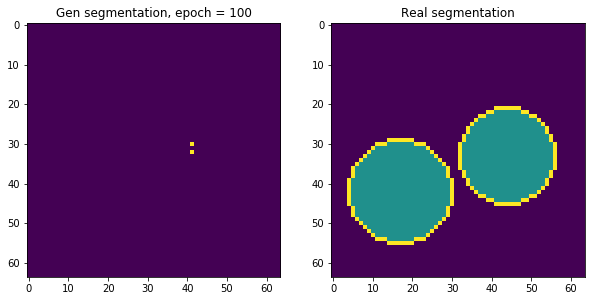

epoch - 100, loss - 5.08009004593
epoch - 101, loss - 5.05301141739
epoch - 102, loss - 5.08703136444
epoch - 103, loss - 4.89790439606
epoch - 104, loss - 4.85521459579
epoch - 105, loss - 4.84901046753
epoch - 106, loss - 4.66896009445
epoch - 107, loss - 4.72148513794
epoch - 108, loss - 4.56341648102
epoch - 109, loss - 4.60887432098
epoch - 110, loss - 4.48093509674
epoch - 111, loss - 4.50795173645
epoch - 112, loss - 4.39460897446
epoch - 113, loss - 4.39844322205
epoch - 114, loss - 4.32314586639
epoch - 115, loss - 4.28292131424
epoch - 116, loss - 4.2309885025
epoch - 117, loss - 4.17110967636
epoch - 118, loss - 4.14663028717
epoch - 119, loss - 4.07511997223
epoch - 120, loss - 4.08204889297
epoch - 121, loss - 3.99475693703
epoch - 122, loss - 3.97579836845
epoch - 123, loss - 3.93486666679
epoch - 124, loss - 3.8810801506
epoch - 125, loss - 3.87542080879
epoch - 126, loss - 3.81819963455
epoch - 127, loss - 3.80347371101
epoch - 128, loss - 3.79867959023
epoch - 129, los

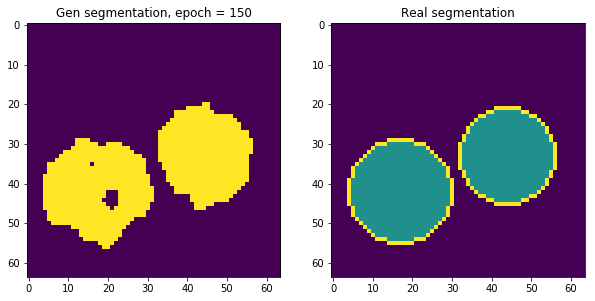

epoch - 150, loss - 3.42207479477
epoch - 151, loss - 3.41395449638
epoch - 152, loss - 3.4026222229
epoch - 153, loss - 3.38920903206
epoch - 154, loss - 3.37703156471
epoch - 155, loss - 3.36672282219
epoch - 156, loss - 3.35834550858
epoch - 157, loss - 3.35103440285
epoch - 158, loss - 3.34410238266
epoch - 159, loss - 3.33835840225
epoch - 160, loss - 3.33218693733
epoch - 161, loss - 3.32597303391
epoch - 162, loss - 3.31682515144
epoch - 163, loss - 3.30544161797
epoch - 164, loss - 3.29060959816
epoch - 165, loss - 3.27579951286
epoch - 166, loss - 3.26386499405
epoch - 167, loss - 3.25571870804
epoch - 168, loss - 3.25013399124
epoch - 169, loss - 3.24675178528
epoch - 170, loss - 3.24810266495
epoch - 171, loss - 3.25190925598
epoch - 172, loss - 3.25466275215
epoch - 173, loss - 3.24620270729
epoch - 174, loss - 3.22104501724
epoch - 175, loss - 3.18876338005
epoch - 176, loss - 3.17277193069
epoch - 177, loss - 3.17443346977
epoch - 178, loss - 3.1759531498
epoch - 179, los

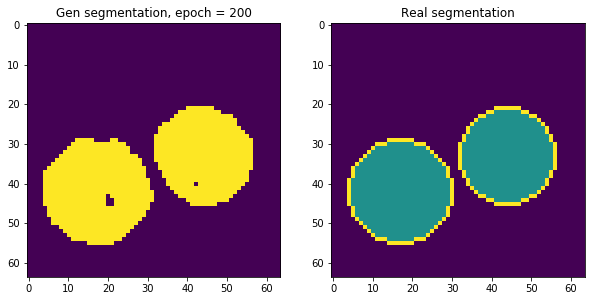

epoch - 200, loss - 2.95093035698
epoch - 201, loss - 2.94523692131
epoch - 202, loss - 2.93693757057
epoch - 203, loss - 2.92161417007
epoch - 204, loss - 2.9107375145
epoch - 205, loss - 2.89946722984
epoch - 206, loss - 2.89061808586
epoch - 207, loss - 2.88389611244
epoch - 208, loss - 2.87450408936
epoch - 209, loss - 2.86540174484
epoch - 210, loss - 2.8559691906
epoch - 211, loss - 2.84696054459
epoch - 212, loss - 2.84025120735
epoch - 213, loss - 2.83503913879
epoch - 214, loss - 2.83684659004
epoch - 215, loss - 2.85127973557
epoch - 216, loss - 2.87018537521
epoch - 217, loss - 2.87455701828
epoch - 218, loss - 2.86123847961
epoch - 219, loss - 2.80399012566
epoch - 220, loss - 2.76353335381
epoch - 221, loss - 2.77022027969
epoch - 222, loss - 2.78903365135
epoch - 223, loss - 2.78136014938
epoch - 224, loss - 2.7411043644
epoch - 225, loss - 2.72124838829
epoch - 226, loss - 2.73225331306
epoch - 227, loss - 2.73337554932
epoch - 228, loss - 2.71810722351
epoch - 229, loss

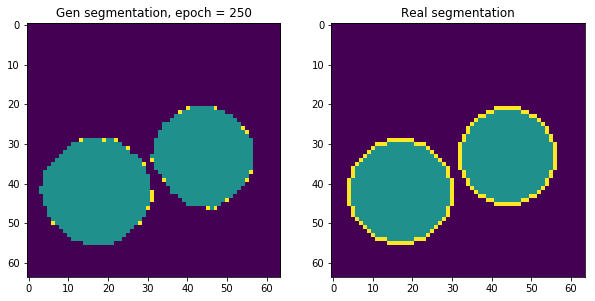

epoch - 250, loss - 2.58002948761
epoch - 251, loss - 2.53067803383
epoch - 252, loss - 2.59734988213
epoch - 253, loss - 2.55366849899
epoch - 254, loss - 2.49771881104
epoch - 255, loss - 2.53118920326
epoch - 256, loss - 2.53232717514
epoch - 257, loss - 2.4707660675
epoch - 258, loss - 2.48641514778
epoch - 259, loss - 2.49974250793
epoch - 260, loss - 2.48600888252
epoch - 261, loss - 2.43808317184
epoch - 262, loss - 2.46655321121
epoch - 263, loss - 2.47527766228
epoch - 264, loss - 2.42983579636
epoch - 265, loss - 2.41936731339
epoch - 266, loss - 2.43846726418
epoch - 267, loss - 2.42812228203
epoch - 268, loss - 2.38583946228
epoch - 269, loss - 2.38961744308
epoch - 270, loss - 2.39733743668
epoch - 271, loss - 2.39497280121
epoch - 272, loss - 2.35882043839
epoch - 273, loss - 2.353941679
epoch - 274, loss - 2.35088300705
epoch - 275, loss - 2.35622835159
epoch - 276, loss - 2.33701467514
epoch - 277, loss - 2.32122039795
epoch - 278, loss - 2.30641961098
epoch - 279, loss

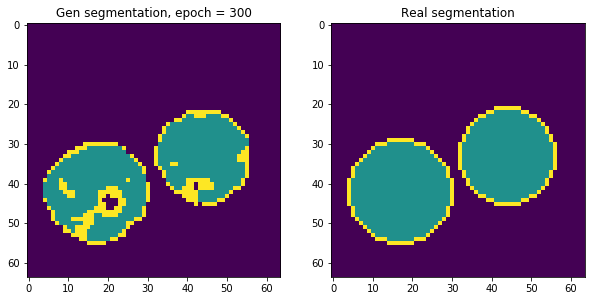

epoch - 300, loss - 2.44395446777
epoch - 301, loss - 2.50308299065
epoch - 302, loss - 2.45627689362
epoch - 303, loss - 2.1369035244
epoch - 304, loss - 2.26155686378
epoch - 305, loss - 2.43915891647
epoch - 306, loss - 2.12979221344
epoch - 307, loss - 2.27949213982
epoch - 308, loss - 2.31469106674
epoch - 309, loss - 2.11585068703
epoch - 310, loss - 2.32693576813
epoch - 311, loss - 2.1407418251
epoch - 312, loss - 2.16426420212
epoch - 313, loss - 2.19714975357
epoch - 314, loss - 2.06661534309
epoch - 315, loss - 2.14529585838
epoch - 316, loss - 2.07071638107
epoch - 317, loss - 2.08565473557
epoch - 318, loss - 2.08173370361
epoch - 319, loss - 2.0309574604
epoch - 320, loss - 2.07166051865
epoch - 321, loss - 2.02180600166
epoch - 322, loss - 2.02065253258
epoch - 323, loss - 2.02992463112
epoch - 324, loss - 1.98084580898
epoch - 325, loss - 1.99500870705
epoch - 326, loss - 1.97518730164
epoch - 327, loss - 1.96000230312
epoch - 328, loss - 1.9660513401
epoch - 329, loss 

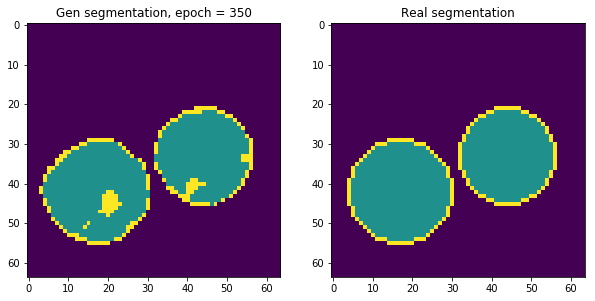

epoch - 350, loss - 1.77911949158
epoch - 351, loss - 1.7631649971
epoch - 352, loss - 1.75495052338
epoch - 353, loss - 1.75294089317
epoch - 354, loss - 1.74243247509
epoch - 355, loss - 1.73329913616
epoch - 356, loss - 1.72459304333
epoch - 357, loss - 1.71406805515
epoch - 358, loss - 1.70640420914
epoch - 359, loss - 1.70169019699
epoch - 360, loss - 1.68890452385
epoch - 361, loss - 1.69298839569
epoch - 362, loss - 1.69111394882
epoch - 363, loss - 1.68581557274
epoch - 364, loss - 1.68328917027
epoch - 365, loss - 1.67541348934
epoch - 366, loss - 1.68769717216
epoch - 367, loss - 1.67692160606
epoch - 368, loss - 1.67967939377
epoch - 369, loss - 1.64334881306
epoch - 370, loss - 1.62834966183
epoch - 371, loss - 1.61193907261
epoch - 372, loss - 1.60479390621
epoch - 373, loss - 1.59199500084
epoch - 374, loss - 1.59271538258
epoch - 375, loss - 1.58436882496
epoch - 376, loss - 1.5939437151
epoch - 377, loss - 1.60321748257
epoch - 378, loss - 1.60235416889
epoch - 379, los

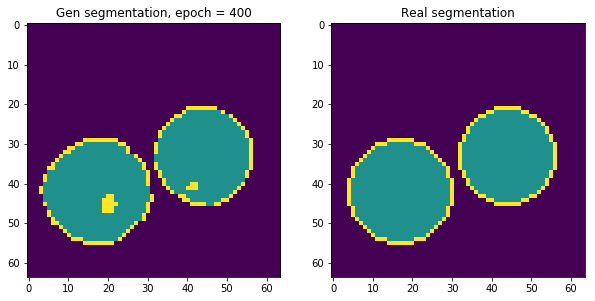

epoch - 400, loss - 1.46090400219
epoch - 401, loss - 1.472245574
epoch - 402, loss - 1.4492919445
epoch - 403, loss - 1.43631827831
epoch - 404, loss - 1.38482177258
epoch - 405, loss - 1.3734190464
epoch - 406, loss - 1.36629271507
epoch - 407, loss - 1.38587832451
epoch - 408, loss - 1.39280998707
epoch - 409, loss - 1.37804949284
epoch - 410, loss - 1.35903847218
epoch - 411, loss - 1.33199489117
epoch - 412, loss - 1.31234955788
epoch - 413, loss - 1.31298243999
epoch - 414, loss - 1.31673073769
epoch - 415, loss - 1.33295857906
epoch - 416, loss - 1.32035934925
epoch - 417, loss - 1.31338202953
epoch - 418, loss - 1.29479777813
epoch - 419, loss - 1.27206802368
epoch - 420, loss - 1.26021659374
epoch - 421, loss - 1.24344241619
epoch - 422, loss - 1.23968732357
epoch - 423, loss - 1.2363781929
epoch - 424, loss - 1.23847329617
epoch - 425, loss - 1.23665130138
epoch - 426, loss - 1.25241529942
epoch - 427, loss - 1.24983620644
epoch - 428, loss - 1.27047431469
epoch - 429, loss -

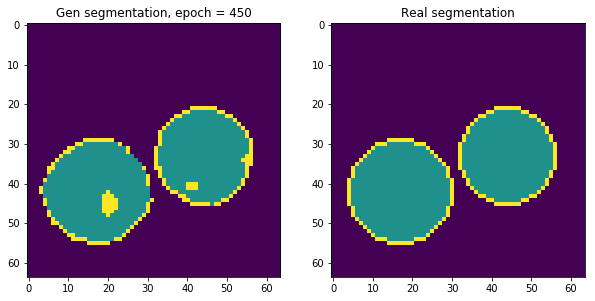

epoch - 450, loss - 1.06114637852
epoch - 451, loss - 1.06748640537
epoch - 452, loss - 1.06183028221
epoch - 453, loss - 1.06966662407
epoch - 454, loss - 1.06660044193
epoch - 455, loss - 1.08011436462
epoch - 456, loss - 1.06913840771
epoch - 457, loss - 1.09304106236
epoch - 458, loss - 1.06099998951
epoch - 459, loss - 1.0484650135
epoch - 460, loss - 1.01325547695
epoch - 461, loss - 0.996945381165
epoch - 462, loss - 0.988205432892
epoch - 463, loss - 1.01220142841
epoch - 464, loss - 1.03304743767
epoch - 465, loss - 1.00525617599
epoch - 466, loss - 1.05299723148
epoch - 467, loss - 0.986516952515
epoch - 468, loss - 0.98062723875
epoch - 469, loss - 0.963476538658
epoch - 470, loss - 0.945648133755
epoch - 471, loss - 0.959655344486
epoch - 472, loss - 0.946889519691
epoch - 473, loss - 0.949955642223
epoch - 474, loss - 0.95800024271
epoch - 475, loss - 0.962448120117
epoch - 476, loss - 0.954933106899
epoch - 477, loss - 0.955101847649
epoch - 478, loss - 0.912094116211
epo

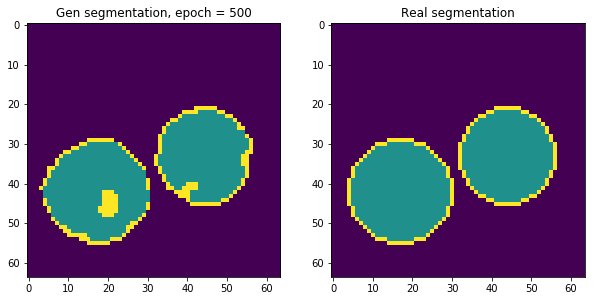

epoch - 500, loss - 0.805260956287
epoch - 501, loss - 0.839851081371
epoch - 502, loss - 0.823525726795
epoch - 503, loss - 0.823781728745
epoch - 504, loss - 0.781320989132
epoch - 505, loss - 0.796856403351
epoch - 506, loss - 0.749389052391
epoch - 507, loss - 0.766534388065
epoch - 508, loss - 0.738423883915
epoch - 509, loss - 0.753915727139
epoch - 510, loss - 0.728254318237
epoch - 511, loss - 0.736579120159
epoch - 512, loss - 0.718185305595
epoch - 513, loss - 0.718609035015
epoch - 514, loss - 0.711645126343
epoch - 515, loss - 0.704325199127
epoch - 516, loss - 0.702524185181
epoch - 517, loss - 0.696077406406
epoch - 518, loss - 0.70183712244
epoch - 519, loss - 0.699158787727
epoch - 520, loss - 0.721197903156
epoch - 521, loss - 0.74084764719
epoch - 522, loss - 0.804378032684
epoch - 523, loss - 0.791269421577
epoch - 524, loss - 0.791253566742
epoch - 525, loss - 0.700338125229
epoch - 526, loss - 0.655200779438
epoch - 527, loss - 0.662586092949
epoch - 528, loss - 0.

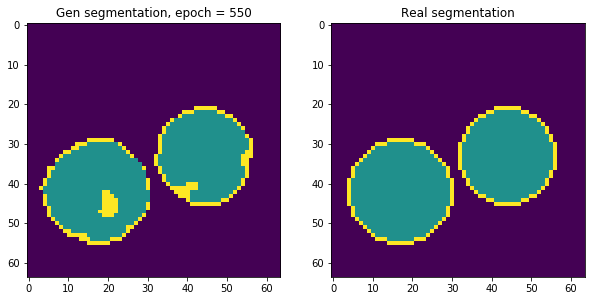

epoch - 550, loss - 0.562428176403
epoch - 551, loss - 0.549739480019
epoch - 552, loss - 0.541417181492
epoch - 553, loss - 0.534099876881
epoch - 554, loss - 0.532202124596
epoch - 555, loss - 0.525952756405
epoch - 556, loss - 0.529448032379
epoch - 557, loss - 0.535858154297
epoch - 558, loss - 0.542655646801
epoch - 559, loss - 0.57249045372
epoch - 560, loss - 0.583670437336
epoch - 561, loss - 0.610968887806
epoch - 562, loss - 0.576934695244
epoch - 563, loss - 0.553285181522
epoch - 564, loss - 0.508935809135
epoch - 565, loss - 0.502256393433
epoch - 566, loss - 0.51060551405
epoch - 567, loss - 0.531904757023
epoch - 568, loss - 0.537338912487
epoch - 569, loss - 0.510431945324
epoch - 570, loss - 0.484305888414
epoch - 571, loss - 0.471533417702
epoch - 572, loss - 0.480112344027
epoch - 573, loss - 0.491121739149
epoch - 574, loss - 0.495485395193
epoch - 575, loss - 0.486623257399
epoch - 576, loss - 0.466934204102
epoch - 577, loss - 0.454877853394
epoch - 578, loss - 0.

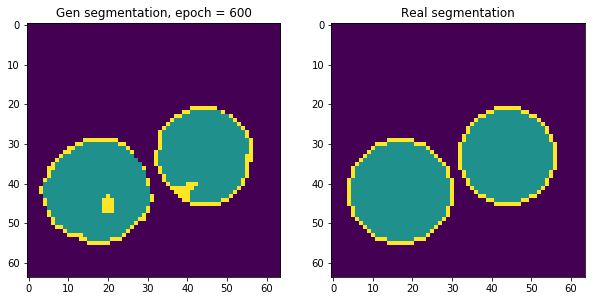

epoch - 600, loss - 0.390559017658
epoch - 601, loss - 0.391745090485
epoch - 602, loss - 0.39161837101
epoch - 603, loss - 0.411387532949
epoch - 604, loss - 0.40391010046
epoch - 605, loss - 0.396045744419
epoch - 606, loss - 0.408231914043
epoch - 607, loss - 0.376543372869
epoch - 608, loss - 0.369836062193
epoch - 609, loss - 0.354688882828
epoch - 610, loss - 0.364980071783
epoch - 611, loss - 0.358730018139
epoch - 612, loss - 0.376645326614
epoch - 613, loss - 0.38904234767
epoch - 614, loss - 0.394408851862
epoch - 615, loss - 0.393639862537
epoch - 616, loss - 0.384273767471
epoch - 617, loss - 0.384635448456
epoch - 618, loss - 0.351459294558
epoch - 619, loss - 0.346686065197
epoch - 620, loss - 0.337438136339
epoch - 621, loss - 0.349882990122
epoch - 622, loss - 0.350139826536
epoch - 623, loss - 0.371126323938
epoch - 624, loss - 0.370791584253
epoch - 625, loss - 0.356701612473
epoch - 626, loss - 0.341194242239
epoch - 627, loss - 0.339299470186
epoch - 628, loss - 0.3

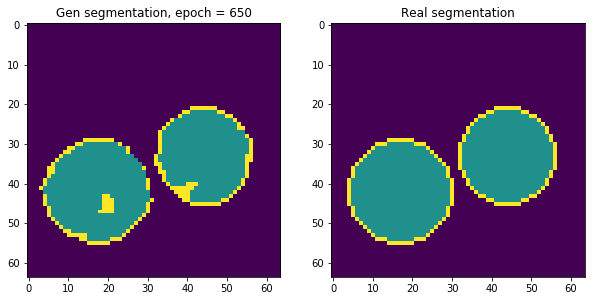

epoch - 650, loss - 0.271085619926
epoch - 651, loss - 0.25707051158
epoch - 652, loss - 0.259807497263
epoch - 653, loss - 0.263824909925
epoch - 654, loss - 0.262353509665
epoch - 655, loss - 0.262270510197
epoch - 656, loss - 0.269791722298
epoch - 657, loss - 0.277848035097
epoch - 658, loss - 0.276018619537
epoch - 659, loss - 0.282068103552
epoch - 660, loss - 0.2798576653
epoch - 661, loss - 0.284283995628
epoch - 662, loss - 0.269240856171
epoch - 663, loss - 0.262706160545
epoch - 664, loss - 0.244333803654
epoch - 665, loss - 0.233415871859
epoch - 666, loss - 0.229652523994
epoch - 667, loss - 0.233711332083
epoch - 668, loss - 0.236485674977
epoch - 669, loss - 0.240305423737
epoch - 670, loss - 0.244870126247
epoch - 671, loss - 0.245380550623
epoch - 672, loss - 0.243626400828
epoch - 673, loss - 0.23715120554
epoch - 674, loss - 0.233550384641
epoch - 675, loss - 0.224697679281
epoch - 676, loss - 0.218219190836
epoch - 677, loss - 0.211358740926
epoch - 678, loss - 0.20

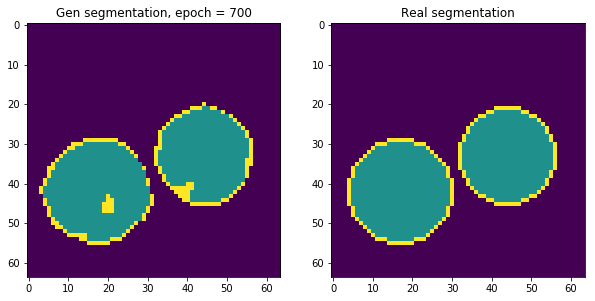

epoch - 700, loss - 0.18416595459
epoch - 701, loss - 0.193615585566
epoch - 702, loss - 0.20266969502
epoch - 703, loss - 0.203366756439
epoch - 704, loss - 0.189271882176
epoch - 705, loss - 0.178453415632
epoch - 706, loss - 0.168593257666
epoch - 707, loss - 0.174181252718
epoch - 708, loss - 0.17805556953
epoch - 709, loss - 0.185128077865
epoch - 710, loss - 0.184852734208
epoch - 711, loss - 0.178739950061
epoch - 712, loss - 0.171623706818
epoch - 713, loss - 0.162979289889
epoch - 714, loss - 0.16184040904
epoch - 715, loss - 0.158555522561
epoch - 716, loss - 0.163527160883
epoch - 717, loss - 0.164804294705
epoch - 718, loss - 0.16977623105
epoch - 719, loss - 0.173805236816
epoch - 720, loss - 0.174132496119
epoch - 721, loss - 0.178837805986
epoch - 722, loss - 0.172230273485
epoch - 723, loss - 0.174026578665
epoch - 724, loss - 0.166039764881
epoch - 725, loss - 0.167306095362
epoch - 726, loss - 0.157639637589
epoch - 727, loss - 0.15534697473
epoch - 728, loss - 0.1555

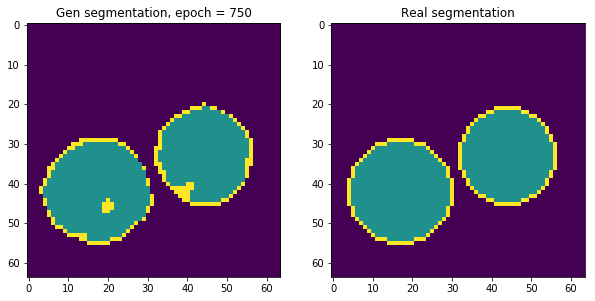

epoch - 750, loss - 0.134968712926
epoch - 751, loss - 0.14763431251
epoch - 752, loss - 0.172169938684
epoch - 753, loss - 0.232227236032
epoch - 754, loss - 0.258907437325
epoch - 755, loss - 0.32168713212
epoch - 756, loss - 0.236405670643
epoch - 757, loss - 0.168869718909
epoch - 758, loss - 0.121509104967
epoch - 759, loss - 0.152888402343
epoch - 760, loss - 0.215159952641
epoch - 761, loss - 0.179655909538
epoch - 762, loss - 0.13266633451
epoch - 763, loss - 0.117354542017
epoch - 764, loss - 0.147373452783
epoch - 765, loss - 0.175162449479
epoch - 766, loss - 0.143349409103
epoch - 767, loss - 0.113384023309
epoch - 768, loss - 0.117038413882
epoch - 769, loss - 0.13501739502
epoch - 770, loss - 0.145637363195
epoch - 771, loss - 0.121837645769
epoch - 772, loss - 0.10639616847
epoch - 773, loss - 0.112029843032
epoch - 774, loss - 0.123480655253
epoch - 775, loss - 0.124570421875
epoch - 776, loss - 0.10931456089
epoch - 777, loss - 0.101781703532
epoch - 778, loss - 0.1059

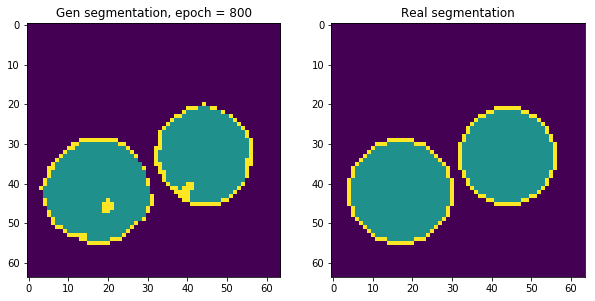

epoch - 800, loss - 0.0997447595
epoch - 801, loss - 0.10556960851
epoch - 802, loss - 0.10576724261
epoch - 803, loss - 0.109667673707
epoch - 804, loss - 0.102853029966
epoch - 805, loss - 0.0982737913728
epoch - 806, loss - 0.0890004485846
epoch - 807, loss - 0.082718834281
epoch - 808, loss - 0.0794327557087
epoch - 809, loss - 0.0799586102366
epoch - 810, loss - 0.0829588472843
epoch - 811, loss - 0.0852297097445
epoch - 812, loss - 0.0878250673413
epoch - 813, loss - 0.0859199762344
epoch - 814, loss - 0.0836699455976
epoch - 815, loss - 0.0797999948263
epoch - 816, loss - 0.0772617012262
epoch - 817, loss - 0.0765174254775
epoch - 818, loss - 0.0775091573596
epoch - 819, loss - 0.0778734907508
epoch - 820, loss - 0.0780637934804
epoch - 821, loss - 0.0772811695933
epoch - 822, loss - 0.0755953043699
epoch - 823, loss - 0.0730888098478
epoch - 824, loss - 0.0715852603316
epoch - 825, loss - 0.0708795115352
epoch - 826, loss - 0.0713709145784
epoch - 827, loss - 0.0724711418152
ep

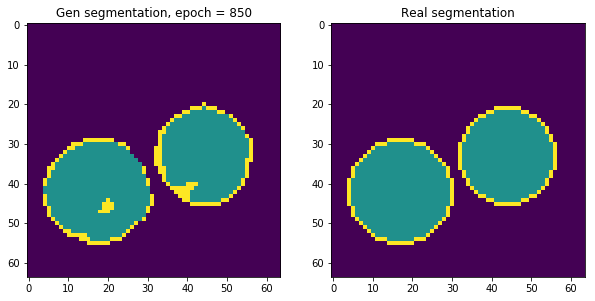

epoch - 850, loss - 0.0642139464617
epoch - 851, loss - 0.0668021142483
epoch - 852, loss - 0.0718024149537
epoch - 853, loss - 0.0762080848217
epoch - 854, loss - 0.0710802674294
epoch - 855, loss - 0.0646811053157
epoch - 856, loss - 0.0594494976103
epoch - 857, loss - 0.0595054402947
epoch - 858, loss - 0.0629540979862
epoch - 859, loss - 0.0655991360545
epoch - 860, loss - 0.0665215775371
epoch - 861, loss - 0.0628258138895
epoch - 862, loss - 0.0589107871056
epoch - 863, loss - 0.0559575557709
epoch - 864, loss - 0.0555530749261
epoch - 865, loss - 0.0569368675351
epoch - 866, loss - 0.0584737770259
epoch - 867, loss - 0.0593413673341
epoch - 868, loss - 0.0581891164184
epoch - 869, loss - 0.0566418208182
epoch - 870, loss - 0.0545367263258
epoch - 871, loss - 0.0532905682921
epoch - 872, loss - 0.052694760263
epoch - 873, loss - 0.0526014566422
epoch - 874, loss - 0.0526854656637
epoch - 875, loss - 0.0524842366576
epoch - 876, loss - 0.0518919229507
epoch - 877, loss - 0.0513250

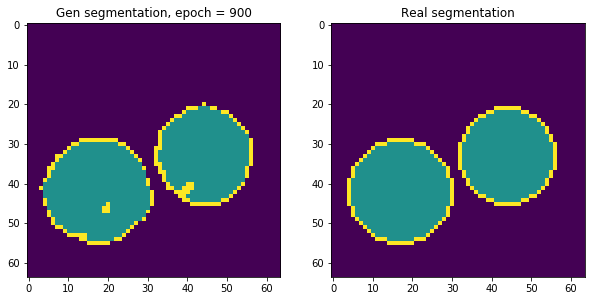

epoch - 900, loss - 0.0705844908953
epoch - 901, loss - 0.101166591048
epoch - 902, loss - 0.09285145998
epoch - 903, loss - 0.0758668705821
epoch - 904, loss - 0.0564454086125
epoch - 905, loss - 0.0611364468932
epoch - 906, loss - 0.0781740993261
epoch - 907, loss - 0.0736368075013
epoch - 908, loss - 0.060840729624
epoch - 909, loss - 0.0488511808217
epoch - 910, loss - 0.0517431646585
epoch - 911, loss - 0.062714330852
epoch - 912, loss - 0.0617491975427
epoch - 913, loss - 0.0554783195257
epoch - 914, loss - 0.0464314632118
epoch - 915, loss - 0.0458005741239
epoch - 916, loss - 0.0502076372504
epoch - 917, loss - 0.0514065660536
epoch - 918, loss - 0.0513030216098
epoch - 919, loss - 0.0476047955453
epoch - 920, loss - 0.0449179969728
epoch - 921, loss - 0.0426988825202
epoch - 922, loss - 0.042712457478
epoch - 923, loss - 0.0435400120914
epoch - 924, loss - 0.0440464802086
epoch - 925, loss - 0.0441780053079
epoch - 926, loss - 0.043386772275
epoch - 927, loss - 0.0427258983254

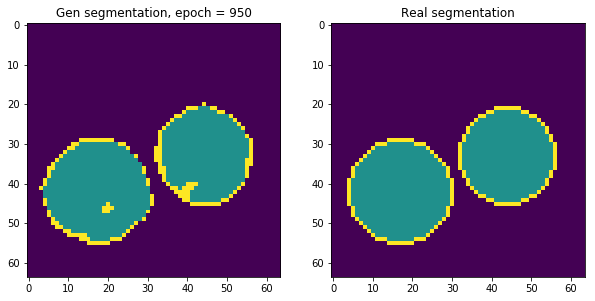

epoch - 950, loss - 0.036497592926
epoch - 951, loss - 0.0393072366714
epoch - 952, loss - 0.0427942350507
epoch - 953, loss - 0.0498804114759
epoch - 954, loss - 0.0553190968931
epoch - 955, loss - 0.0669606029987
epoch - 956, loss - 0.0707283988595
epoch - 957, loss - 0.0815524384379
epoch - 958, loss - 0.0753961503506
epoch - 959, loss - 0.0742043629289
epoch - 960, loss - 0.057994812727
epoch - 961, loss - 0.0482160151005
epoch - 962, loss - 0.041366841644
epoch - 963, loss - 0.0412576571107
epoch - 964, loss - 0.0442921072245
epoch - 965, loss - 0.0433065146208
epoch - 966, loss - 0.0418183803558
epoch - 967, loss - 0.038719303906
epoch - 968, loss - 0.0391878783703
epoch - 969, loss - 0.0407656133175
epoch - 970, loss - 0.0416683331132
epoch - 971, loss - 0.039030238986
epoch - 972, loss - 0.0337210930884
epoch - 973, loss - 0.0302406102419
epoch - 974, loss - 0.0304106771946
epoch - 975, loss - 0.0333878062665
epoch - 976, loss - 0.0357975438237
epoch - 977, loss - 0.03589014336

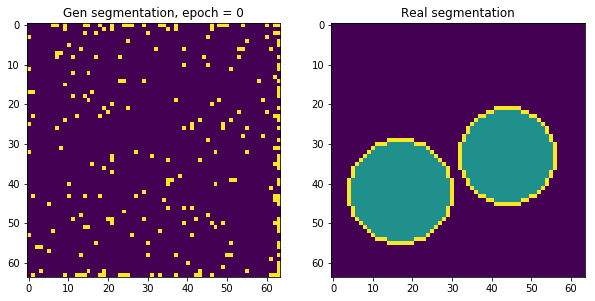

epoch - 0, loss - 6.50649547577
epoch - 1, loss - 12.8767766953
epoch - 2, loss - 6.86690807343
epoch - 3, loss - 6.33397054672
epoch - 4, loss - 6.51295042038
epoch - 5, loss - 6.44447851181
epoch - 6, loss - 6.34188938141
epoch - 7, loss - 6.29381418228
epoch - 8, loss - 6.27203941345
epoch - 9, loss - 6.24850034714
epoch - 10, loss - 6.22007274628
epoch - 11, loss - 6.18343639374
epoch - 12, loss - 6.1331744194
epoch - 13, loss - 6.07335472107
epoch - 14, loss - 6.02992105484
epoch - 15, loss - 6.0169301033
epoch - 16, loss - 6.0423374176
epoch - 17, loss - 5.98801279068
epoch - 18, loss - 5.96345758438
epoch - 19, loss - 5.92570257187
epoch - 20, loss - 5.92120265961
epoch - 21, loss - 5.90965938568
epoch - 22, loss - 5.89068126678
epoch - 23, loss - 5.8783659935
epoch - 24, loss - 5.86494016647
epoch - 25, loss - 5.84706068039
epoch - 26, loss - 5.82995223999
epoch - 27, loss - 5.81116867065
epoch - 28, loss - 5.7929315567
epoch - 29, loss - 5.81468153
epoch - 30, loss - 5.8358139

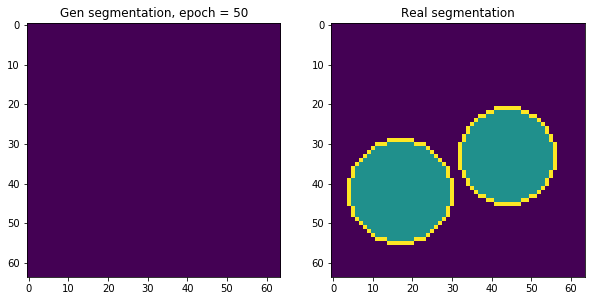

epoch - 50, loss - 5.69989204407
epoch - 51, loss - 5.77283096313
epoch - 52, loss - 5.77332115173
epoch - 53, loss - 5.68614149094
epoch - 54, loss - 5.71368408203
epoch - 55, loss - 5.67614650726
epoch - 56, loss - 5.64745616913
epoch - 57, loss - 5.68253707886
epoch - 58, loss - 5.65316486359
epoch - 59, loss - 5.62938022614
epoch - 60, loss - 5.65649843216
epoch - 61, loss - 5.61526823044
epoch - 62, loss - 5.61800813675
epoch - 63, loss - 5.61595726013
epoch - 64, loss - 5.58528423309
epoch - 65, loss - 5.58083677292
epoch - 66, loss - 5.55445718765
epoch - 67, loss - 5.55894422531
epoch - 68, loss - 5.52162837982
epoch - 69, loss - 5.53569412231
epoch - 70, loss - 5.50075244904
epoch - 71, loss - 5.46048355103
epoch - 72, loss - 5.4828338623
epoch - 73, loss - 5.53509140015
epoch - 74, loss - 5.50230503082
epoch - 75, loss - 5.38031864166
epoch - 76, loss - 5.37327480316
epoch - 77, loss - 5.43651771545
epoch - 78, loss - 5.43758153915
epoch - 79, loss - 5.34583616257
epoch - 80,

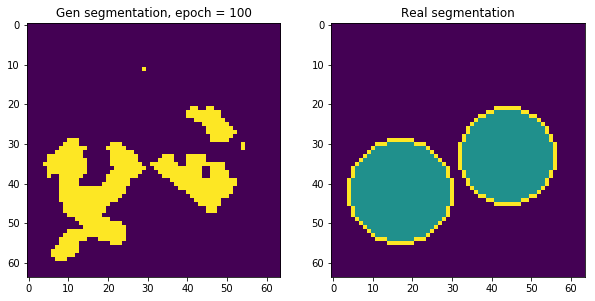

epoch - 100, loss - 4.14868307114
epoch - 101, loss - 4.19143915176
epoch - 102, loss - 4.20099115372
epoch - 103, loss - 4.02115917206
epoch - 104, loss - 4.07407236099
epoch - 105, loss - 3.97059965134
epoch - 106, loss - 3.93043923378
epoch - 107, loss - 3.91691160202
epoch - 108, loss - 3.81100702286
epoch - 109, loss - 3.81294775009
epoch - 110, loss - 3.72098994255
epoch - 111, loss - 3.7211432457
epoch - 112, loss - 3.6820025444
epoch - 113, loss - 3.65945005417
epoch - 114, loss - 3.63651061058
epoch - 115, loss - 3.58354711533
epoch - 116, loss - 3.5743534565
epoch - 117, loss - 3.53797650337
epoch - 118, loss - 3.53518843651
epoch - 119, loss - 3.4964299202
epoch - 120, loss - 3.47991728783
epoch - 121, loss - 3.4534907341
epoch - 122, loss - 3.44139075279
epoch - 123, loss - 3.42307257652
epoch - 124, loss - 3.4004907608
epoch - 125, loss - 3.38939070702
epoch - 126, loss - 3.36984276772
epoch - 127, loss - 3.36154961586
epoch - 128, loss - 3.33970236778
epoch - 129, loss - 

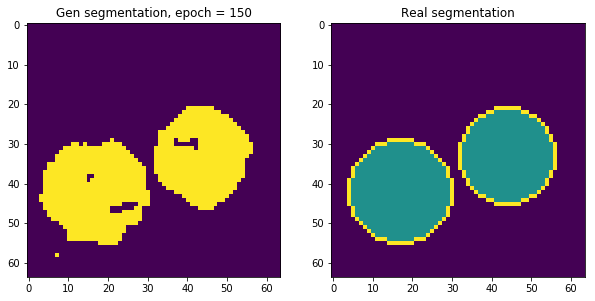

epoch - 150, loss - 3.11068606377
epoch - 151, loss - 3.10216617584
epoch - 152, loss - 3.09273314476
epoch - 153, loss - 3.08397650719
epoch - 154, loss - 3.07580566406
epoch - 155, loss - 3.06825733185
epoch - 156, loss - 3.06489634514
epoch - 157, loss - 3.07115292549
epoch - 158, loss - 3.10101389885
epoch - 159, loss - 3.18913841248
epoch - 160, loss - 3.22708058357
epoch - 161, loss - 3.19408941269
epoch - 162, loss - 3.02776241302
epoch - 163, loss - 3.10774087906
epoch - 164, loss - 3.17641878128
epoch - 165, loss - 3.0019402504
epoch - 166, loss - 3.13746738434
epoch - 167, loss - 3.12732458115
epoch - 168, loss - 3.01258397102
epoch - 169, loss - 3.15364694595
epoch - 170, loss - 3.02669978142
epoch - 171, loss - 3.05632662773
epoch - 172, loss - 3.00398612022
epoch - 173, loss - 3.00173139572
epoch - 174, loss - 2.99302458763
epoch - 175, loss - 2.99594593048
epoch - 176, loss - 2.96426296234
epoch - 177, loss - 2.97346568108
epoch - 178, loss - 2.93544650078
epoch - 179, lo

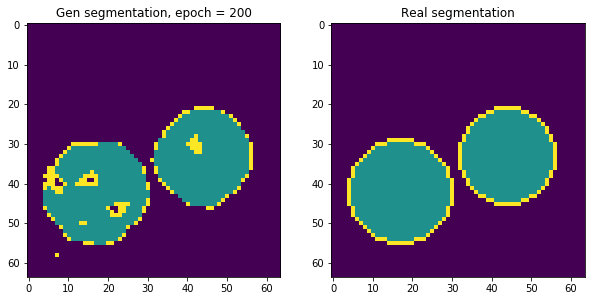

epoch - 200, loss - 2.76750826836
epoch - 201, loss - 2.76374340057
epoch - 202, loss - 2.76480150223
epoch - 203, loss - 2.77250170708
epoch - 204, loss - 2.80223631859
epoch - 205, loss - 2.82925438881
epoch - 206, loss - 2.86393260956
epoch - 207, loss - 2.83452010155
epoch - 208, loss - 2.75891041756
epoch - 209, loss - 2.70894384384
epoch - 210, loss - 2.70823311806
epoch - 211, loss - 2.74502849579
epoch - 212, loss - 2.73616051674
epoch - 213, loss - 2.69999718666
epoch - 214, loss - 2.67789912224
epoch - 215, loss - 2.68397212029
epoch - 216, loss - 2.69579172134
epoch - 217, loss - 2.67933797836
epoch - 218, loss - 2.65834522247
epoch - 219, loss - 2.64579749107
epoch - 220, loss - 2.65442538261
epoch - 221, loss - 2.66427135468
epoch - 222, loss - 2.66527962685
epoch - 223, loss - 2.64108037949
epoch - 224, loss - 2.61464691162
epoch - 225, loss - 2.60461616516
epoch - 226, loss - 2.61475157738
epoch - 227, loss - 2.62018704414
epoch - 228, loss - 2.61275434494
epoch - 229, l

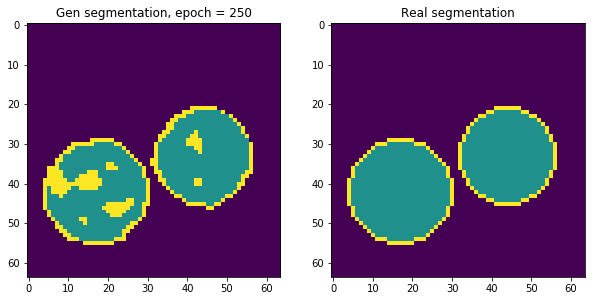

epoch - 250, loss - 2.52627491951
epoch - 251, loss - 2.57676768303
epoch - 252, loss - 2.51803708076
epoch - 253, loss - 2.53291082382
epoch - 254, loss - 2.52745199203
epoch - 255, loss - 2.50461816788
epoch - 256, loss - 2.50424075127
epoch - 257, loss - 2.50576353073
epoch - 258, loss - 2.48273253441
epoch - 259, loss - 2.48977279663
epoch - 260, loss - 2.4728474617
epoch - 261, loss - 2.48303437233
epoch - 262, loss - 2.46672272682
epoch - 263, loss - 2.45456314087
epoch - 264, loss - 2.45227789879
epoch - 265, loss - 2.45201230049
epoch - 266, loss - 2.4470949173
epoch - 267, loss - 2.4401614666
epoch - 268, loss - 2.42666530609
epoch - 269, loss - 2.42538928986
epoch - 270, loss - 2.41710400581
epoch - 271, loss - 2.41908073425
epoch - 272, loss - 2.41669845581
epoch - 273, loss - 2.41474270821
epoch - 274, loss - 2.4151237011
epoch - 275, loss - 2.40858435631
epoch - 276, loss - 2.40766406059
epoch - 277, loss - 2.40211701393
epoch - 278, loss - 2.39941072464
epoch - 279, loss 

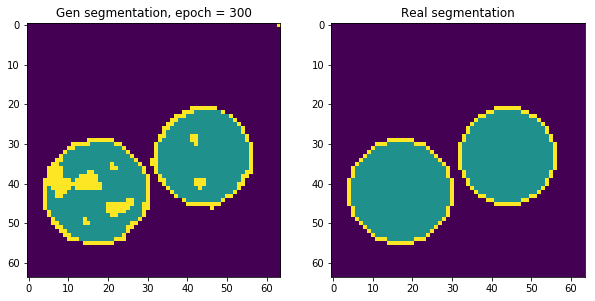

epoch - 300, loss - 2.36288499832
epoch - 301, loss - 2.33593130112
epoch - 302, loss - 2.29114198685
epoch - 303, loss - 2.31969738007
epoch - 304, loss - 2.32896256447
epoch - 305, loss - 2.28830504417
epoch - 306, loss - 2.27676010132
epoch - 307, loss - 2.30016255379
epoch - 308, loss - 2.29873728752
epoch - 309, loss - 2.28217029572
epoch - 310, loss - 2.25915336609
epoch - 311, loss - 2.25497794151
epoch - 312, loss - 2.26904201508
epoch - 313, loss - 2.28002333641
epoch - 314, loss - 2.27002668381
epoch - 315, loss - 2.25209403038
epoch - 316, loss - 2.24008774757
epoch - 317, loss - 2.22557520866
epoch - 318, loss - 2.22677302361
epoch - 319, loss - 2.23456811905
epoch - 320, loss - 2.24285364151
epoch - 321, loss - 2.24444890022
epoch - 322, loss - 2.25100421906
epoch - 323, loss - 2.25146865845
epoch - 324, loss - 2.23913455009
epoch - 325, loss - 2.22338557243
epoch - 326, loss - 2.20609855652
epoch - 327, loss - 2.19355559349
epoch - 328, loss - 2.18287301064
epoch - 329, l

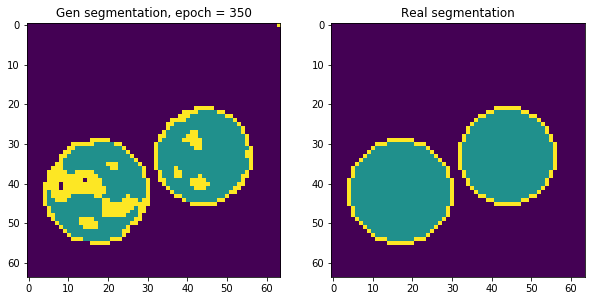

epoch - 350, loss - 2.13059830666
epoch - 351, loss - 2.15393090248
epoch - 352, loss - 2.22471761703
epoch - 353, loss - 2.29372477531
epoch - 354, loss - 2.24993419647
epoch - 355, loss - 2.15950107574
epoch - 356, loss - 2.12010669708
epoch - 357, loss - 2.14061307907
epoch - 358, loss - 2.12035679817
epoch - 359, loss - 2.11242842674
epoch - 360, loss - 2.1283082962
epoch - 361, loss - 2.09916806221
epoch - 362, loss - 2.06085133553
epoch - 363, loss - 2.07965564728
epoch - 364, loss - 2.09358477592
epoch - 365, loss - 2.05797553062
epoch - 366, loss - 2.04023623466
epoch - 367, loss - 2.06248688698
epoch - 368, loss - 2.05539083481
epoch - 369, loss - 2.0275747776
epoch - 370, loss - 2.02950286865
epoch - 371, loss - 2.04138445854
epoch - 372, loss - 2.02529096603
epoch - 373, loss - 2.01273560524
epoch - 374, loss - 2.03216791153
epoch - 375, loss - 2.08003664017
epoch - 376, loss - 2.14917349815
epoch - 377, loss - 2.19495868683
epoch - 378, loss - 2.13418936729
epoch - 379, los

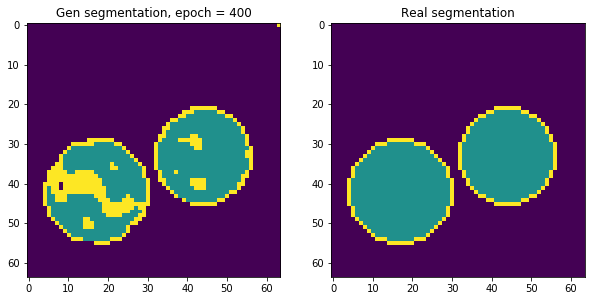

epoch - 400, loss - 1.92725431919
epoch - 401, loss - 1.91570448875
epoch - 402, loss - 1.91377437115
epoch - 403, loss - 1.92494523525
epoch - 404, loss - 1.95139837265
epoch - 405, loss - 1.98621678352
epoch - 406, loss - 2.00419425964
epoch - 407, loss - 2.00491666794
epoch - 408, loss - 1.97508215904
epoch - 409, loss - 1.91475236416
epoch - 410, loss - 1.87533676624
epoch - 411, loss - 1.88148367405
epoch - 412, loss - 1.91215443611
epoch - 413, loss - 1.9205493927
epoch - 414, loss - 1.88072729111
epoch - 415, loss - 1.84949171543
epoch - 416, loss - 1.85457110405
epoch - 417, loss - 1.87071669102
epoch - 418, loss - 1.87477099895
epoch - 419, loss - 1.87031555176
epoch - 420, loss - 1.87955987453
epoch - 421, loss - 1.88447475433
epoch - 422, loss - 1.86990177631
epoch - 423, loss - 1.84531104565
epoch - 424, loss - 1.83377718925
epoch - 425, loss - 1.82943665981
epoch - 426, loss - 1.81801056862
epoch - 427, loss - 1.80167019367
epoch - 428, loss - 1.79367399216
epoch - 429, lo

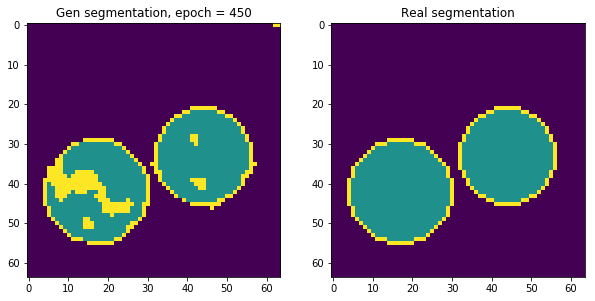

epoch - 450, loss - 1.75824725628
epoch - 451, loss - 1.75163924694
epoch - 452, loss - 1.75320744514
epoch - 453, loss - 1.78261089325
epoch - 454, loss - 1.77887070179
epoch - 455, loss - 1.77294504642
epoch - 456, loss - 1.75709605217
epoch - 457, loss - 1.72128820419
epoch - 458, loss - 1.69429409504
epoch - 459, loss - 1.68585312366
epoch - 460, loss - 1.68279588223
epoch - 461, loss - 1.69317674637
epoch - 462, loss - 1.705514431
epoch - 463, loss - 1.69524538517
epoch - 464, loss - 1.67823660374
epoch - 465, loss - 1.66655361652
epoch - 466, loss - 1.65658068657
epoch - 467, loss - 1.64289629459
epoch - 468, loss - 1.64073646069
epoch - 469, loss - 1.64923417568
epoch - 470, loss - 1.65914368629
epoch - 471, loss - 1.67829692364
epoch - 472, loss - 1.72026705742
epoch - 473, loss - 1.76809668541
epoch - 474, loss - 1.74601221085
epoch - 475, loss - 1.68102359772
epoch - 476, loss - 1.63359332085
epoch - 477, loss - 1.61099207401
epoch - 478, loss - 1.61898171902
epoch - 479, los

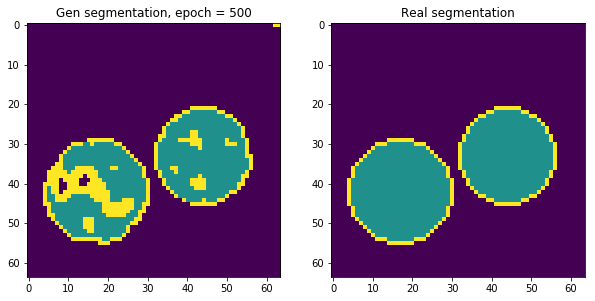

epoch - 500, loss - 1.52648866177
epoch - 501, loss - 1.51270759106
epoch - 502, loss - 1.51137089729
epoch - 503, loss - 1.52062237263
epoch - 504, loss - 1.5298422575
epoch - 505, loss - 1.53326678276
epoch - 506, loss - 1.51239943504
epoch - 507, loss - 1.49223518372
epoch - 508, loss - 1.48599016666
epoch - 509, loss - 1.51012396812
epoch - 510, loss - 1.57572305202
epoch - 511, loss - 1.64812016487
epoch - 512, loss - 1.64242577553
epoch - 513, loss - 1.59754419327
epoch - 514, loss - 1.58098006248
epoch - 515, loss - 1.57046639919
epoch - 516, loss - 1.49659717083
epoch - 517, loss - 1.46683943272
epoch - 518, loss - 1.50806748867
epoch - 519, loss - 1.52144312859
epoch - 520, loss - 1.45643997192
epoch - 521, loss - 1.43785452843
epoch - 522, loss - 1.47568821907
epoch - 523, loss - 1.46857893467
epoch - 524, loss - 1.42593050003
epoch - 525, loss - 1.4350297451
epoch - 526, loss - 1.46137523651
epoch - 527, loss - 1.44296550751
epoch - 528, loss - 1.44410502911
epoch - 529, los

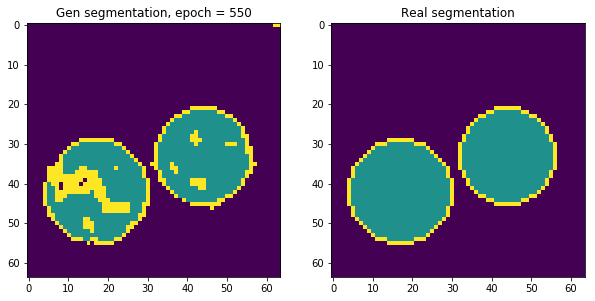

epoch - 550, loss - 1.35609567165
epoch - 551, loss - 1.3979088068
epoch - 552, loss - 1.42149877548
epoch - 553, loss - 1.41081833839
epoch - 554, loss - 1.38742983341
epoch - 555, loss - 1.35723984241
epoch - 556, loss - 1.32912957668
epoch - 557, loss - 1.31656479836
epoch - 558, loss - 1.32488894463
epoch - 559, loss - 1.33751761913
epoch - 560, loss - 1.33686995506
epoch - 561, loss - 1.32990455627
epoch - 562, loss - 1.32010710239
epoch - 563, loss - 1.29086899757
epoch - 564, loss - 1.26803731918
epoch - 565, loss - 1.27452433109
epoch - 566, loss - 1.29373812675
epoch - 567, loss - 1.29245483875
epoch - 568, loss - 1.27338671684
epoch - 569, loss - 1.26323747635
epoch - 570, loss - 1.27004635334
epoch - 571, loss - 1.28329408169
epoch - 572, loss - 1.28589558601
epoch - 573, loss - 1.25820064545
epoch - 574, loss - 1.25410687923
epoch - 575, loss - 1.27144896984
epoch - 576, loss - 1.28796994686
epoch - 577, loss - 1.29307496548
epoch - 578, loss - 1.28813588619
epoch - 579, lo

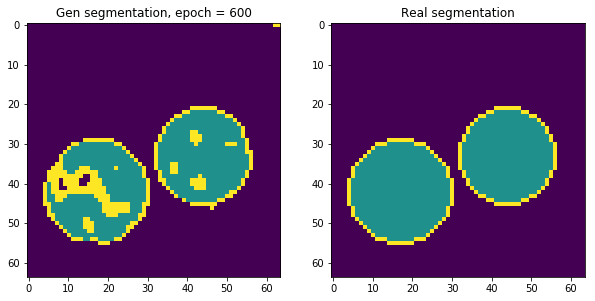

epoch - 600, loss - 1.14548873901
epoch - 601, loss - 1.13275587559
epoch - 602, loss - 1.142791152
epoch - 603, loss - 1.15072000027
epoch - 604, loss - 1.16286683083
epoch - 605, loss - 1.19280004501
epoch - 606, loss - 1.23910701275
epoch - 607, loss - 1.26028370857
epoch - 608, loss - 1.21361327171
epoch - 609, loss - 1.16422379017
epoch - 610, loss - 1.13970255852
epoch - 611, loss - 1.13031256199
epoch - 612, loss - 1.13334274292
epoch - 613, loss - 1.14747524261
epoch - 614, loss - 1.15573620796
epoch - 615, loss - 1.13719522953
epoch - 616, loss - 1.09698450565
epoch - 617, loss - 1.08325791359
epoch - 618, loss - 1.10378611088
epoch - 619, loss - 1.11348724365
epoch - 620, loss - 1.10231995583
epoch - 621, loss - 1.10637366772
epoch - 622, loss - 1.13301575184
epoch - 623, loss - 1.14554798603
epoch - 624, loss - 1.11964309216
epoch - 625, loss - 1.09998488426
epoch - 626, loss - 1.09519696236
epoch - 627, loss - 1.07368373871
epoch - 628, loss - 1.0459843874
epoch - 629, loss

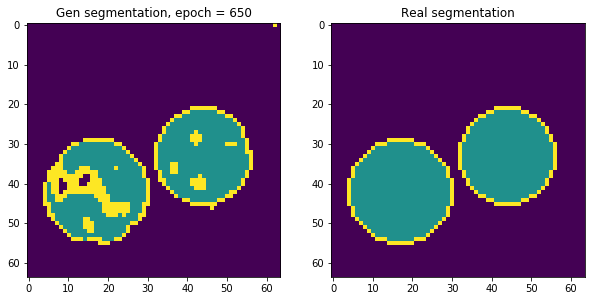

epoch - 650, loss - 1.0010612011
epoch - 651, loss - 0.975543558598
epoch - 652, loss - 0.976215422153
epoch - 653, loss - 0.993406176567
epoch - 654, loss - 1.01073253155
epoch - 655, loss - 1.03216445446
epoch - 656, loss - 1.06160712242
epoch - 657, loss - 1.10172104836
epoch - 658, loss - 1.1119171381
epoch - 659, loss - 1.06064414978
epoch - 660, loss - 0.983096241951
epoch - 661, loss - 0.950634121895
epoch - 662, loss - 0.977424144745
epoch - 663, loss - 1.01920926571
epoch - 664, loss - 1.01162791252
epoch - 665, loss - 0.95874363184
epoch - 666, loss - 0.928632616997
epoch - 667, loss - 0.945660471916
epoch - 668, loss - 0.97650462389
epoch - 669, loss - 0.97839641571
epoch - 670, loss - 0.942587018013
epoch - 671, loss - 0.920653820038
epoch - 672, loss - 0.931345820427
epoch - 673, loss - 0.936993360519
epoch - 674, loss - 0.923311769962
epoch - 675, loss - 0.901210188866
epoch - 676, loss - 0.90941375494
epoch - 677, loss - 0.937638700008
epoch - 678, loss - 0.931300699711


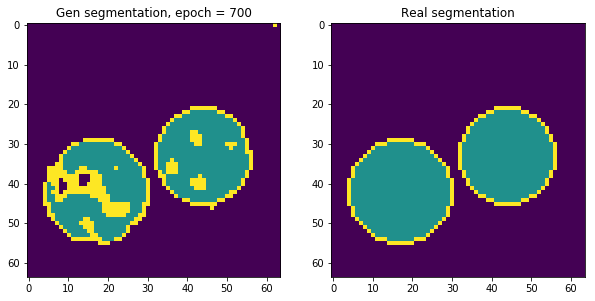

epoch - 700, loss - 0.842048704624
epoch - 701, loss - 0.835120201111
epoch - 702, loss - 0.825207650661
epoch - 703, loss - 0.819481194019
epoch - 704, loss - 0.822939276695
epoch - 705, loss - 0.831076681614
epoch - 706, loss - 0.840789079666
epoch - 707, loss - 0.850558340549
epoch - 708, loss - 0.876487314701
epoch - 709, loss - 0.925403475761
epoch - 710, loss - 0.961068868637
epoch - 711, loss - 0.933632254601
epoch - 712, loss - 0.848930120468
epoch - 713, loss - 0.81114178896
epoch - 714, loss - 0.821187257767
epoch - 715, loss - 0.83771699667
epoch - 716, loss - 0.837588429451
epoch - 717, loss - 0.817690253258
epoch - 718, loss - 0.80610960722
epoch - 719, loss - 0.807636022568
epoch - 720, loss - 0.810976862907
epoch - 721, loss - 0.803318083286
epoch - 722, loss - 0.78993076086
epoch - 723, loss - 0.774710714817
epoch - 724, loss - 0.774596810341
epoch - 725, loss - 0.786851346493
epoch - 726, loss - 0.795066535473
epoch - 727, loss - 0.785487771034
epoch - 728, loss - 0.76

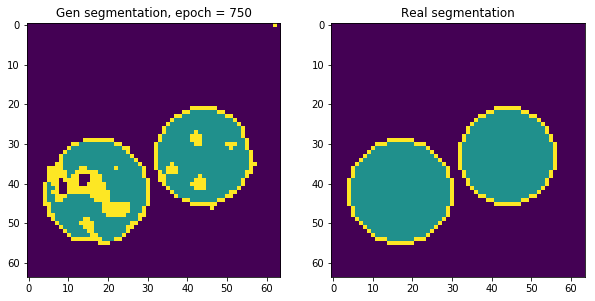

epoch - 750, loss - 0.740241587162
epoch - 751, loss - 0.728220522404
epoch - 752, loss - 0.738241314888
epoch - 753, loss - 0.791465163231
epoch - 754, loss - 0.815413594246
epoch - 755, loss - 0.784950077534
epoch - 756, loss - 0.749779701233
epoch - 757, loss - 0.734176397324
epoch - 758, loss - 0.708909928799
epoch - 759, loss - 0.694465339184
epoch - 760, loss - 0.70238751173
epoch - 761, loss - 0.709529101849
epoch - 762, loss - 0.697503328323
epoch - 763, loss - 0.692055225372
epoch - 764, loss - 0.703327894211
epoch - 765, loss - 0.706594586372
epoch - 766, loss - 0.683262705803
epoch - 767, loss - 0.671889483929
epoch - 768, loss - 0.673975944519
epoch - 769, loss - 0.677451908588
epoch - 770, loss - 0.679215610027
epoch - 771, loss - 0.674924552441
epoch - 772, loss - 0.674504041672
epoch - 773, loss - 0.669353067875
epoch - 774, loss - 0.667572081089
epoch - 775, loss - 0.685235202312
epoch - 776, loss - 0.733501195908
epoch - 777, loss - 0.787015318871
epoch - 778, loss - 0

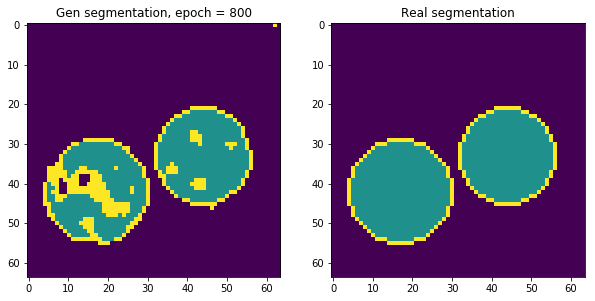

epoch - 800, loss - 0.591640591621
epoch - 801, loss - 0.591022312641
epoch - 802, loss - 0.596461594105
epoch - 803, loss - 0.599766254425
epoch - 804, loss - 0.598042905331
epoch - 805, loss - 0.59240680933
epoch - 806, loss - 0.586477458477
epoch - 807, loss - 0.581431150436
epoch - 808, loss - 0.5841319561
epoch - 809, loss - 0.60090136528
epoch - 810, loss - 0.624986946583
epoch - 811, loss - 0.638536155224
epoch - 812, loss - 0.641459822655
epoch - 813, loss - 0.652813017368
epoch - 814, loss - 0.665937066078
epoch - 815, loss - 0.656433522701
epoch - 816, loss - 0.609101593494
epoch - 817, loss - 0.565948665142
epoch - 818, loss - 0.562114655972
epoch - 819, loss - 0.587643325329
epoch - 820, loss - 0.600802183151
epoch - 821, loss - 0.578855514526
epoch - 822, loss - 0.554573893547
epoch - 823, loss - 0.558725893497
epoch - 824, loss - 0.585114240646
epoch - 825, loss - 0.579644739628
epoch - 826, loss - 0.556612610817
epoch - 827, loss - 0.539985656738
epoch - 828, loss - 0.55

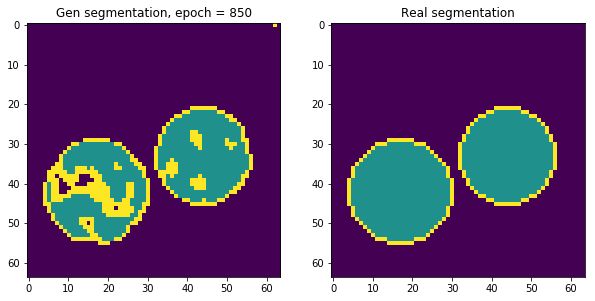

epoch - 850, loss - 0.533791422844
epoch - 851, loss - 0.518994092941
epoch - 852, loss - 0.498557537794
epoch - 853, loss - 0.497603774071
epoch - 854, loss - 0.512462496758
epoch - 855, loss - 0.520725131035
epoch - 856, loss - 0.527470946312
epoch - 857, loss - 0.549442768097
epoch - 858, loss - 0.590608656406
epoch - 859, loss - 0.605231642723
epoch - 860, loss - 0.563348770142
epoch - 861, loss - 0.527417421341
epoch - 862, loss - 0.517519652843
epoch - 863, loss - 0.513476371765
epoch - 864, loss - 0.51612919569
epoch - 865, loss - 0.52767932415
epoch - 866, loss - 0.54761081934
epoch - 867, loss - 0.536686062813
epoch - 868, loss - 0.500277280807
epoch - 869, loss - 0.480149894953
epoch - 870, loss - 0.484127134085
epoch - 871, loss - 0.489639312029
epoch - 872, loss - 0.483127832413
epoch - 873, loss - 0.480052500963
epoch - 874, loss - 0.496770232916
epoch - 875, loss - 0.501323461533
epoch - 876, loss - 0.481623768806
epoch - 877, loss - 0.47496214509
epoch - 878, loss - 0.49

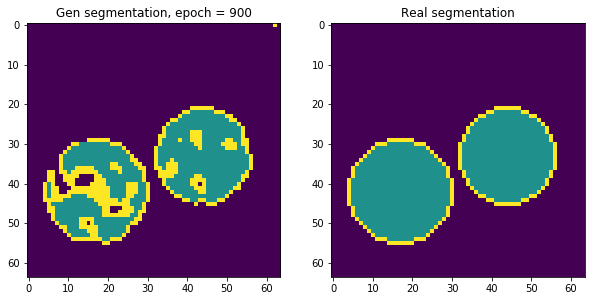

epoch - 900, loss - 0.607836902142
epoch - 901, loss - 0.618015170097
epoch - 902, loss - 0.534014046192
epoch - 903, loss - 0.447246938944
epoch - 904, loss - 0.444664359093
epoch - 905, loss - 0.487431794405
epoch - 906, loss - 0.506021261215
epoch - 907, loss - 0.487350344658
epoch - 908, loss - 0.466121524572
epoch - 909, loss - 0.451340913773
epoch - 910, loss - 0.449865102768
epoch - 911, loss - 0.460197478533
epoch - 912, loss - 0.464466392994
epoch - 913, loss - 0.444265395403
epoch - 914, loss - 0.417780786753
epoch - 915, loss - 0.426431208849
epoch - 916, loss - 0.450766205788
epoch - 917, loss - 0.447483032942
epoch - 918, loss - 0.413496732712
epoch - 919, loss - 0.397174686193
epoch - 920, loss - 0.414844483137
epoch - 921, loss - 0.432361483574
epoch - 922, loss - 0.425218433142
epoch - 923, loss - 0.407214283943
epoch - 924, loss - 0.412967294455
epoch - 925, loss - 0.435887932777
epoch - 926, loss - 0.44437405467
epoch - 927, loss - 0.416305601597
epoch - 928, loss - 0

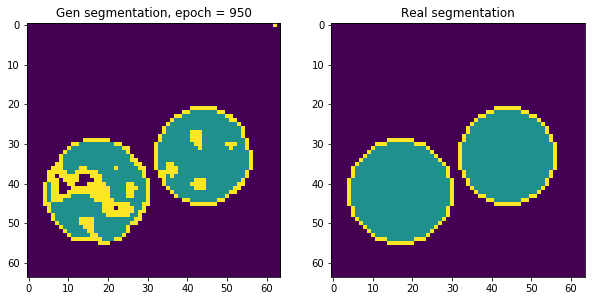

epoch - 950, loss - 0.374713927507
epoch - 951, loss - 0.38199570775
epoch - 952, loss - 0.386507809162
epoch - 953, loss - 0.38796839118
epoch - 954, loss - 0.389883518219
epoch - 955, loss - 0.392122983932
epoch - 956, loss - 0.388633131981
epoch - 957, loss - 0.376583307981
epoch - 958, loss - 0.363765180111
epoch - 959, loss - 0.353770643473
epoch - 960, loss - 0.346983164549
epoch - 961, loss - 0.345127522945
epoch - 962, loss - 0.345416516066
epoch - 963, loss - 0.351765275002
epoch - 964, loss - 0.358636707067
epoch - 965, loss - 0.366662234068
epoch - 966, loss - 0.372909784317
epoch - 967, loss - 0.381827265024
epoch - 968, loss - 0.394329488277
epoch - 969, loss - 0.401949286461
epoch - 970, loss - 0.399045944214
epoch - 971, loss - 0.381553769112
epoch - 972, loss - 0.356108993292
epoch - 973, loss - 0.335336118937
epoch - 974, loss - 0.332845121622
epoch - 975, loss - 0.341713070869
epoch - 976, loss - 0.351924866438
epoch - 977, loss - 0.35161921382
epoch - 978, loss - 0.3

In [34]:
torch.manual_seed(42)
loss_10, loss_100, segm_loss_10, segm_loss_100 = generate_and_train(network_class=Network)

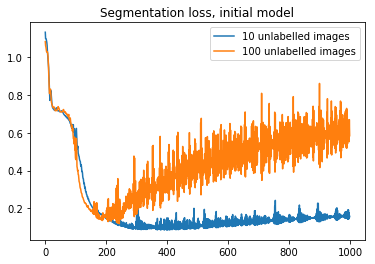

In [35]:
plt.plot(segm_loss_10, label='10 unlabelled images')
plt.plot(segm_loss_100, label='100 unlabelled images')
plt.title('Segmentation loss, initial model')
plt.legend()
plt.show()

### Unet

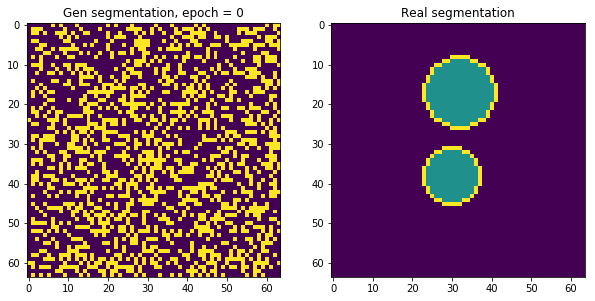

epoch - 0, loss - 96.8194732666
epoch - 1, loss - 32.12292099
epoch - 2, loss - 26.8318576813
epoch - 3, loss - 17.4383354187
epoch - 4, loss - 10.1803007126
epoch - 5, loss - 8.06122493744
epoch - 6, loss - 7.50335836411
epoch - 7, loss - 7.24668979645
epoch - 8, loss - 6.87665653229
epoch - 9, loss - 6.54531812668
epoch - 10, loss - 6.30587244034
epoch - 11, loss - 6.15295505524
epoch - 12, loss - 6.05385351181
epoch - 13, loss - 5.98687648773
epoch - 14, loss - 5.93276119232
epoch - 15, loss - 5.87685680389
epoch - 16, loss - 5.81056165695
epoch - 17, loss - 5.7483291626
epoch - 18, loss - 5.69073152542
epoch - 19, loss - 5.63998746872
epoch - 20, loss - 5.59860992432
epoch - 21, loss - 5.56274795532
epoch - 22, loss - 5.52742815018
epoch - 23, loss - 5.49097824097
epoch - 24, loss - 5.4543671608
epoch - 25, loss - 5.42379617691
epoch - 26, loss - 5.40301561356
epoch - 27, loss - 5.39254426956
epoch - 28, loss - 5.36862897873
epoch - 29, loss - 5.34315299988
epoch - 30, loss - 5.321

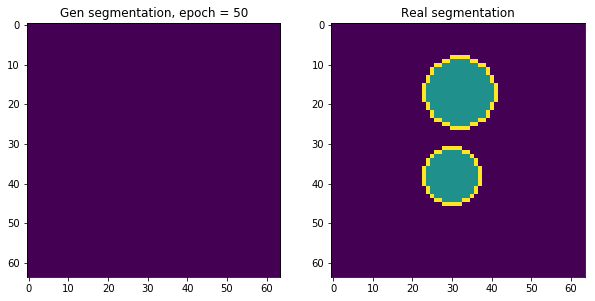

epoch - 50, loss - 4.62609481812
epoch - 51, loss - 4.58681917191
epoch - 52, loss - 4.54885625839
epoch - 53, loss - 4.51382446289
epoch - 54, loss - 4.48346471786
epoch - 55, loss - 4.45326757431
epoch - 56, loss - 4.42598104477
epoch - 57, loss - 4.40034008026
epoch - 58, loss - 4.37725353241
epoch - 59, loss - 4.35420465469
epoch - 60, loss - 4.33275318146
epoch - 61, loss - 4.31185054779
epoch - 62, loss - 4.28950309753
epoch - 63, loss - 4.26775121689
epoch - 64, loss - 4.24853229523
epoch - 65, loss - 4.23108530045
epoch - 66, loss - 4.21480703354
epoch - 67, loss - 4.19789123535
epoch - 68, loss - 4.18106985092
epoch - 69, loss - 4.16529607773
epoch - 70, loss - 4.15128993988
epoch - 71, loss - 4.13726425171
epoch - 72, loss - 4.12381076813
epoch - 73, loss - 4.11057567596
epoch - 74, loss - 4.09734106064
epoch - 75, loss - 4.08527469635
epoch - 76, loss - 4.07382774353
epoch - 77, loss - 4.06298542023
epoch - 78, loss - 4.05251026154
epoch - 79, loss - 4.04169368744
epoch - 80

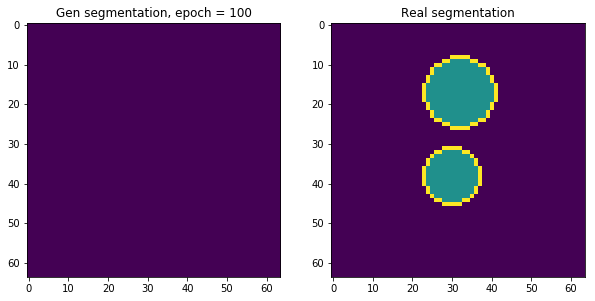

epoch - 100, loss - 3.89810585976
epoch - 101, loss - 3.87472724915
epoch - 102, loss - 3.87570571899
epoch - 103, loss - 3.85932159424
epoch - 104, loss - 3.86460828781
epoch - 105, loss - 3.84636378288
epoch - 106, loss - 3.85117530823
epoch - 107, loss - 3.83178424835
epoch - 108, loss - 3.83797025681
epoch - 109, loss - 3.8214673996
epoch - 110, loss - 3.82242822647
epoch - 111, loss - 3.81388950348
epoch - 112, loss - 3.80801677704
epoch - 113, loss - 3.80496311188
epoch - 114, loss - 3.79723072052
epoch - 115, loss - 3.7949461937
epoch - 116, loss - 3.78817987442
epoch - 117, loss - 3.78402519226
epoch - 118, loss - 3.78043985367
epoch - 119, loss - 3.77429008484
epoch - 120, loss - 3.77165722847
epoch - 121, loss - 3.76604318619
epoch - 122, loss - 3.7626349926
epoch - 123, loss - 3.75852274895
epoch - 124, loss - 3.75431156158
epoch - 125, loss - 3.75094461441
epoch - 126, loss - 3.7465441227
epoch - 127, loss - 3.7435605526
epoch - 128, loss - 3.73889541626
epoch - 129, loss -

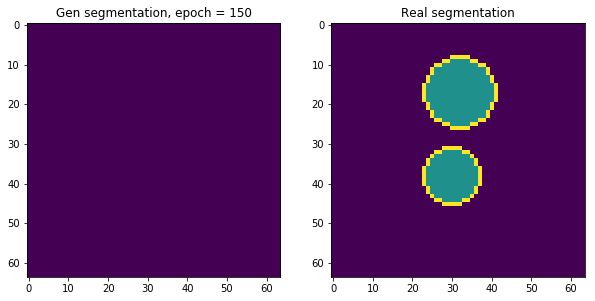

epoch - 150, loss - 3.66798019409
epoch - 151, loss - 3.66592049599
epoch - 152, loss - 3.66375350952
epoch - 153, loss - 3.65977287292
epoch - 154, loss - 3.65577101707
epoch - 155, loss - 3.65208315849
epoch - 156, loss - 3.64872741699
epoch - 157, loss - 3.64557337761
epoch - 158, loss - 3.64287686348
epoch - 159, loss - 3.64144492149
epoch - 160, loss - 3.64304351807
epoch - 161, loss - 3.64718818665
epoch - 162, loss - 3.64611673355
epoch - 163, loss - 3.63832783699
epoch - 164, loss - 3.62656641006
epoch - 165, loss - 3.62505221367
epoch - 166, loss - 3.62864971161
epoch - 167, loss - 3.62204027176
epoch - 168, loss - 3.6144323349
epoch - 169, loss - 3.61119484901
epoch - 170, loss - 3.6108045578
epoch - 171, loss - 3.60947799683
epoch - 172, loss - 3.60539340973
epoch - 173, loss - 3.60282897949
epoch - 174, loss - 3.60311627388
epoch - 175, loss - 3.59642648697
epoch - 176, loss - 3.59117984772
epoch - 177, loss - 3.59191417694
epoch - 178, loss - 3.59144735336
epoch - 179, los

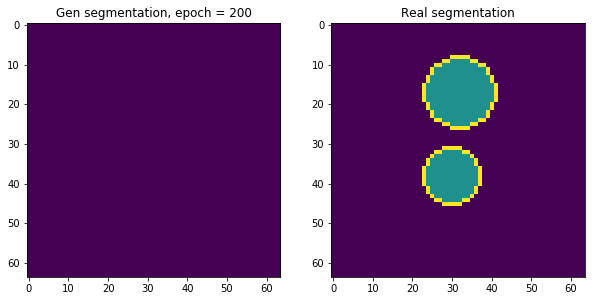

epoch - 200, loss - 3.51897549629
epoch - 201, loss - 3.52304005623
epoch - 202, loss - 3.51516723633
epoch - 203, loss - 3.50929546356
epoch - 204, loss - 3.49425268173
epoch - 205, loss - 3.48695468903
epoch - 206, loss - 3.48922896385
epoch - 207, loss - 3.48787808418
epoch - 208, loss - 3.48685312271
epoch - 209, loss - 3.47816848755
epoch - 210, loss - 3.47302412987
epoch - 211, loss - 3.46630263329
epoch - 212, loss - 3.45822286606
epoch - 213, loss - 3.45106887817
epoch - 214, loss - 3.44968700409
epoch - 215, loss - 3.4548740387
epoch - 216, loss - 3.46705150604
epoch - 217, loss - 3.49607491493
epoch - 218, loss - 3.45974063873
epoch - 219, loss - 3.43477725983
epoch - 220, loss - 3.42869305611
epoch - 221, loss - 3.43549394608
epoch - 222, loss - 3.42724084854
epoch - 223, loss - 3.4084854126
epoch - 224, loss - 3.4153277874
epoch - 225, loss - 3.42419862747
epoch - 226, loss - 3.40263772011
epoch - 227, loss - 3.38663887978
epoch - 228, loss - 3.38479804993
epoch - 229, loss

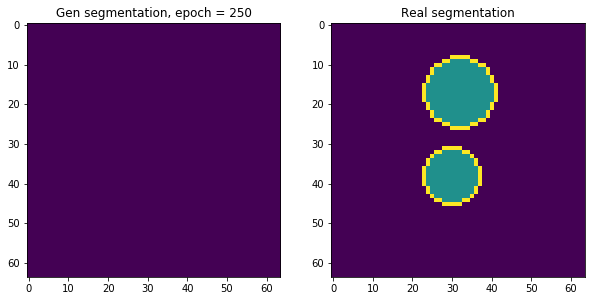

epoch - 250, loss - 3.25736999512
epoch - 251, loss - 3.26426100731
epoch - 252, loss - 3.25487780571
epoch - 253, loss - 3.25093507767
epoch - 254, loss - 3.2489991188
epoch - 255, loss - 3.24092483521
epoch - 256, loss - 3.21801638603
epoch - 257, loss - 3.20246601105
epoch - 258, loss - 3.20555734634
epoch - 259, loss - 3.20057725906
epoch - 260, loss - 3.1915769577
epoch - 261, loss - 3.19135642052
epoch - 262, loss - 3.19816946983
epoch - 263, loss - 3.16881036758
epoch - 264, loss - 3.15433597565
epoch - 265, loss - 3.14718818665
epoch - 266, loss - 3.14251565933
epoch - 267, loss - 3.13507938385
epoch - 268, loss - 3.14056491852
epoch - 269, loss - 3.16463065147
epoch - 270, loss - 3.13782000542
epoch - 271, loss - 3.11712169647
epoch - 272, loss - 3.09715127945
epoch - 273, loss - 3.10131454468
epoch - 274, loss - 3.10429286957
epoch - 275, loss - 3.07399272919
epoch - 276, loss - 3.06235098839
epoch - 277, loss - 3.05541491508
epoch - 278, loss - 3.05697631836
epoch - 279, los

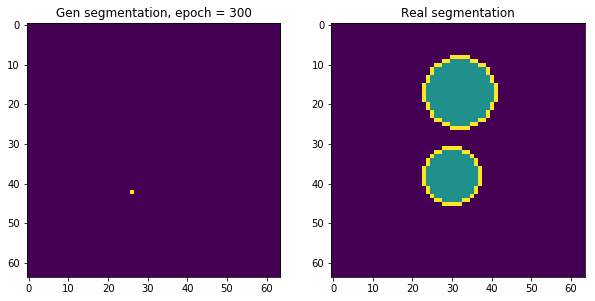

epoch - 300, loss - 2.85615134239
epoch - 301, loss - 2.83611297607
epoch - 302, loss - 2.82161664963
epoch - 303, loss - 2.8178050518
epoch - 304, loss - 2.81475687027
epoch - 305, loss - 2.82115936279
epoch - 306, loss - 2.80947637558
epoch - 307, loss - 2.80317544937
epoch - 308, loss - 2.76686763763
epoch - 309, loss - 2.7598285675
epoch - 310, loss - 2.77479910851
epoch - 311, loss - 2.7605214119
epoch - 312, loss - 2.74989652634
epoch - 313, loss - 2.72590827942
epoch - 314, loss - 2.72275972366
epoch - 315, loss - 2.72169709206
epoch - 316, loss - 2.69681239128
epoch - 317, loss - 2.68591833115
epoch - 318, loss - 2.68034887314
epoch - 319, loss - 2.67519545555
epoch - 320, loss - 2.66299986839
epoch - 321, loss - 2.64703226089
epoch - 322, loss - 2.63729786873
epoch - 323, loss - 2.63772392273
epoch - 324, loss - 2.64375829697
epoch - 325, loss - 2.6025185585
epoch - 326, loss - 2.61642742157
epoch - 327, loss - 2.60907459259
epoch - 328, loss - 2.6069214344
epoch - 329, loss -

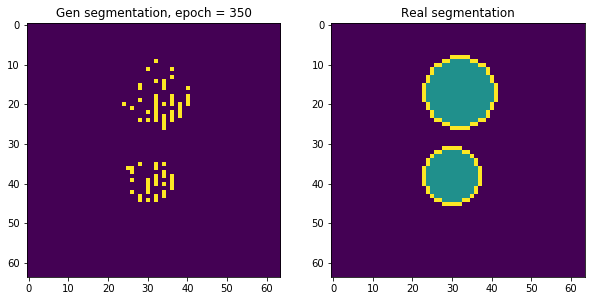

epoch - 350, loss - 2.39034628868
epoch - 351, loss - 2.37045288086
epoch - 352, loss - 2.38209033012
epoch - 353, loss - 2.37025237083
epoch - 354, loss - 2.37258291245
epoch - 355, loss - 2.32899141312
epoch - 356, loss - 2.314016819
epoch - 357, loss - 2.31666922569
epoch - 358, loss - 2.31493353844
epoch - 359, loss - 2.30372929573
epoch - 360, loss - 2.2845697403
epoch - 361, loss - 2.27303600311
epoch - 362, loss - 2.262332201
epoch - 363, loss - 2.24508857727
epoch - 364, loss - 2.24047923088
epoch - 365, loss - 2.24165487289
epoch - 366, loss - 2.2367079258
epoch - 367, loss - 2.20692586899
epoch - 368, loss - 2.18583130836
epoch - 369, loss - 2.18428707123
epoch - 370, loss - 2.18335986137
epoch - 371, loss - 2.1755797863
epoch - 372, loss - 2.17184472084
epoch - 373, loss - 2.17423796654
epoch - 374, loss - 2.16108703613
epoch - 375, loss - 2.13776516914
epoch - 376, loss - 2.11179637909
epoch - 377, loss - 2.1117579937
epoch - 378, loss - 2.12368392944
epoch - 379, loss - 2.

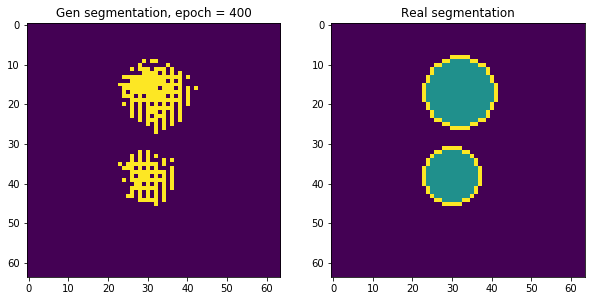

epoch - 400, loss - 1.90928602219
epoch - 401, loss - 1.92082893848
epoch - 402, loss - 1.90940487385
epoch - 403, loss - 1.90949118137
epoch - 404, loss - 1.87094712257
epoch - 405, loss - 1.86165833473
epoch - 406, loss - 1.87191832066
epoch - 407, loss - 1.84560918808
epoch - 408, loss - 1.83401727676
epoch - 409, loss - 1.85054469109
epoch - 410, loss - 1.84524929523
epoch - 411, loss - 1.86208665371
epoch - 412, loss - 1.92825424671
epoch - 413, loss - 1.81999909878
epoch - 414, loss - 1.83881723881
epoch - 415, loss - 1.84597992897
epoch - 416, loss - 1.8248257637
epoch - 417, loss - 1.83055090904
epoch - 418, loss - 1.77377235889
epoch - 419, loss - 1.79088044167
epoch - 420, loss - 1.77334821224
epoch - 421, loss - 1.76927542686
epoch - 422, loss - 1.74532222748
epoch - 423, loss - 1.7290084362
epoch - 424, loss - 1.73660421371
epoch - 425, loss - 1.71786975861
epoch - 426, loss - 1.71920657158
epoch - 427, loss - 1.69158840179
epoch - 428, loss - 1.68566524982
epoch - 429, los

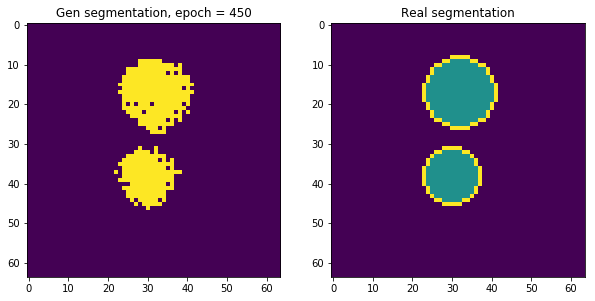

epoch - 450, loss - 1.507822752
epoch - 451, loss - 1.50688827038
epoch - 452, loss - 1.51546061039
epoch - 453, loss - 1.51330804825
epoch - 454, loss - 1.51397037506
epoch - 455, loss - 1.50672328472
epoch - 456, loss - 1.52697634697
epoch - 457, loss - 1.49672019482
epoch - 458, loss - 1.48537027836
epoch - 459, loss - 1.4485026598
epoch - 460, loss - 1.44889521599
epoch - 461, loss - 1.47807836533
epoch - 462, loss - 1.4558031559
epoch - 463, loss - 1.45185291767
epoch - 464, loss - 1.42399322987
epoch - 465, loss - 1.44500350952
epoch - 466, loss - 1.47086286545
epoch - 467, loss - 1.43750786781
epoch - 468, loss - 1.43129694462
epoch - 469, loss - 1.42543065548
epoch - 470, loss - 1.40344810486
epoch - 471, loss - 1.40002691746
epoch - 472, loss - 1.38354861736
epoch - 473, loss - 1.37394654751
epoch - 474, loss - 1.37380754948
epoch - 475, loss - 1.35226786137
epoch - 476, loss - 1.34645462036
epoch - 477, loss - 1.34449219704
epoch - 478, loss - 1.33962929249
epoch - 479, loss 

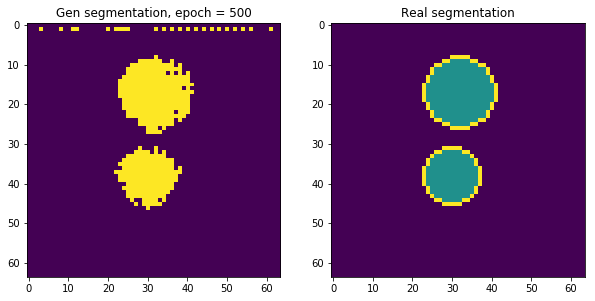

epoch - 500, loss - 1.26081335545
epoch - 501, loss - 1.23111093044
epoch - 502, loss - 1.22762537003
epoch - 503, loss - 1.18973636627
epoch - 504, loss - 1.21912825108
epoch - 505, loss - 1.20516419411
epoch - 506, loss - 1.23028755188
epoch - 507, loss - 1.20405685902
epoch - 508, loss - 1.19384026527
epoch - 509, loss - 1.18828141689
epoch - 510, loss - 1.17932415009
epoch - 511, loss - 1.17898535728
epoch - 512, loss - 1.15888416767
epoch - 513, loss - 1.15790987015
epoch - 514, loss - 1.14097070694
epoch - 515, loss - 1.13449084759
epoch - 516, loss - 1.13813996315
epoch - 517, loss - 1.11894798279
epoch - 518, loss - 1.10975599289
epoch - 519, loss - 1.11169505119
epoch - 520, loss - 1.12959361076
epoch - 521, loss - 1.11391687393
epoch - 522, loss - 1.10575139523
epoch - 523, loss - 1.09870362282
epoch - 524, loss - 1.12486052513
epoch - 525, loss - 1.12989544868
epoch - 526, loss - 1.14352428913
epoch - 527, loss - 1.12077379227
epoch - 528, loss - 1.13792741299
epoch - 529, l

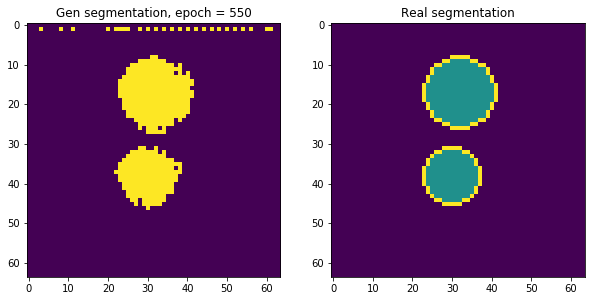

epoch - 550, loss - 0.978621900082
epoch - 551, loss - 0.971088588238
epoch - 552, loss - 0.961094975471
epoch - 553, loss - 0.963142871857
epoch - 554, loss - 0.966615319252
epoch - 555, loss - 0.950623452663
epoch - 556, loss - 0.980339348316
epoch - 557, loss - 1.0020622015
epoch - 558, loss - 1.04964411259
epoch - 559, loss - 0.981600105762
epoch - 560, loss - 0.939639210701
epoch - 561, loss - 0.940666496754
epoch - 562, loss - 0.957427024841
epoch - 563, loss - 0.932073056698
epoch - 564, loss - 0.912105798721
epoch - 565, loss - 0.930520415306
epoch - 566, loss - 0.918611645699
epoch - 567, loss - 0.898164987564
epoch - 568, loss - 0.914815485477
epoch - 569, loss - 0.92472422123
epoch - 570, loss - 0.909955203533
epoch - 571, loss - 0.934096634388
epoch - 572, loss - 0.924010872841
epoch - 573, loss - 0.91986900568
epoch - 574, loss - 0.918234109879
epoch - 575, loss - 0.942283451557
epoch - 576, loss - 0.924822151661
epoch - 577, loss - 0.885841786861
epoch - 578, loss - 0.865

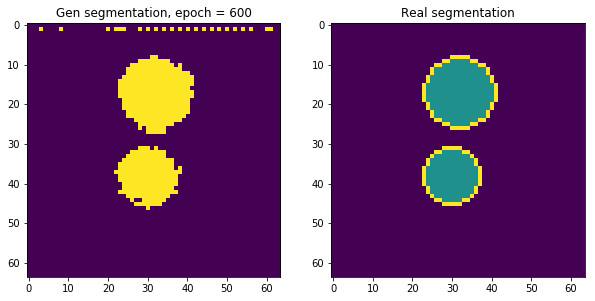

epoch - 600, loss - 0.827662289143
epoch - 601, loss - 0.795993804932
epoch - 602, loss - 0.815318226814
epoch - 603, loss - 0.814709484577
epoch - 604, loss - 0.808278620243
epoch - 605, loss - 0.786830306053
epoch - 606, loss - 0.795076966286
epoch - 607, loss - 0.792689621449
epoch - 608, loss - 0.773036241531
epoch - 609, loss - 0.777717411518
epoch - 610, loss - 0.779922127724
epoch - 611, loss - 0.776050567627
epoch - 612, loss - 0.77809715271
epoch - 613, loss - 0.807058691978
epoch - 614, loss - 0.832780718803
epoch - 615, loss - 0.821555912495
epoch - 616, loss - 0.781934738159
epoch - 617, loss - 0.793927371502
epoch - 618, loss - 0.781134486198
epoch - 619, loss - 0.767964065075
epoch - 620, loss - 0.773533821106
epoch - 621, loss - 0.766281425953
epoch - 622, loss - 0.744565963745
epoch - 623, loss - 0.746801614761
epoch - 624, loss - 0.74349206686
epoch - 625, loss - 0.723471164703
epoch - 626, loss - 0.72155880928
epoch - 627, loss - 0.721603691578
epoch - 628, loss - 0.7

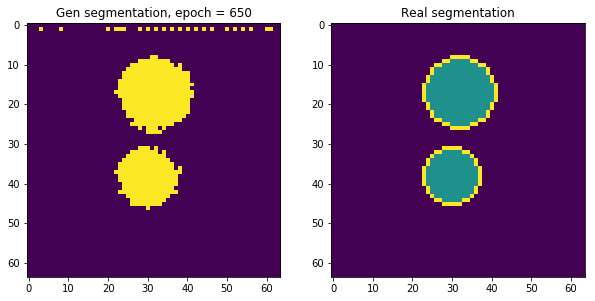

epoch - 650, loss - 0.771759390831
epoch - 651, loss - 0.732735157013
epoch - 652, loss - 0.728154838085
epoch - 653, loss - 0.722963809967
epoch - 654, loss - 0.706507444382
epoch - 655, loss - 0.71603345871
epoch - 656, loss - 0.679736196995
epoch - 657, loss - 0.696452140808
epoch - 658, loss - 0.667456924915
epoch - 659, loss - 0.672115564346
epoch - 660, loss - 0.656545877457
epoch - 661, loss - 0.662515521049
epoch - 662, loss - 0.645040929317
epoch - 663, loss - 0.649409115314
epoch - 664, loss - 0.646630942822
epoch - 665, loss - 0.655603647232
epoch - 666, loss - 0.660769402981
epoch - 667, loss - 0.684259414673
epoch - 668, loss - 0.695594906807
epoch - 669, loss - 0.704929888248
epoch - 670, loss - 0.684198737144
epoch - 671, loss - 0.642962574959
epoch - 672, loss - 0.629474818707
epoch - 673, loss - 0.636314928532
epoch - 674, loss - 0.655692398548
epoch - 675, loss - 0.649641156197
epoch - 676, loss - 0.635829210281
epoch - 677, loss - 0.613062500954
epoch - 678, loss - 0

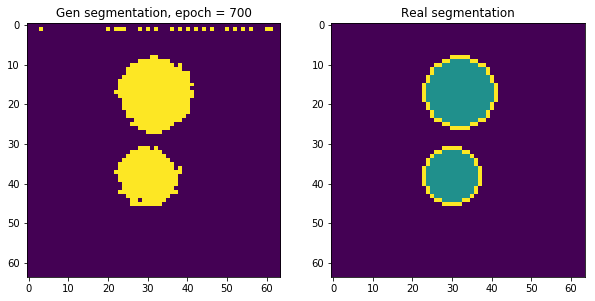

epoch - 700, loss - 0.584800422192
epoch - 701, loss - 0.591604709625
epoch - 702, loss - 0.575015187263
epoch - 703, loss - 0.565028429031
epoch - 704, loss - 0.563857376575
epoch - 705, loss - 0.568327188492
epoch - 706, loss - 0.576769113541
epoch - 707, loss - 0.578894376755
epoch - 708, loss - 0.571506917477
epoch - 709, loss - 0.586570382118
epoch - 710, loss - 0.642817914486
epoch - 711, loss - 0.658581018448
epoch - 712, loss - 0.646228969097
epoch - 713, loss - 0.615135967731
epoch - 714, loss - 0.594931662083
epoch - 715, loss - 0.572318792343
epoch - 716, loss - 0.57375395298
epoch - 717, loss - 0.576580345631
epoch - 718, loss - 0.557210326195
epoch - 719, loss - 0.562889575958
epoch - 720, loss - 0.56344050169
epoch - 721, loss - 0.528609037399
epoch - 722, loss - 0.535722851753
epoch - 723, loss - 0.551528096199
epoch - 724, loss - 0.525612592697
epoch - 725, loss - 0.519358098507
epoch - 726, loss - 0.527672767639
epoch - 727, loss - 0.521982848644
epoch - 728, loss - 0.

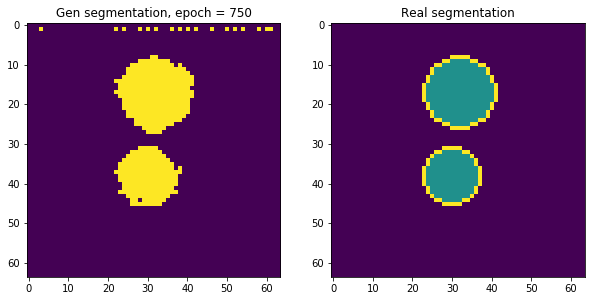

epoch - 750, loss - 0.499230265617
epoch - 751, loss - 0.49799451232
epoch - 752, loss - 0.505827963352
epoch - 753, loss - 0.501311480999
epoch - 754, loss - 0.496976613998
epoch - 755, loss - 0.492985129356
epoch - 756, loss - 0.49051079154
epoch - 757, loss - 0.503118753433
epoch - 758, loss - 0.518877387047
epoch - 759, loss - 0.529204070568
epoch - 760, loss - 0.556230783463
epoch - 761, loss - 0.588223278522
epoch - 762, loss - 0.616166234016
epoch - 763, loss - 0.540213823318
epoch - 764, loss - 0.515260577202
epoch - 765, loss - 0.557246983051
epoch - 766, loss - 0.524229705334
epoch - 767, loss - 0.499647438526
epoch - 768, loss - 0.494606286287
epoch - 769, loss - 0.484518945217
epoch - 770, loss - 0.491185665131
epoch - 771, loss - 0.48120123148
epoch - 772, loss - 0.466300159693
epoch - 773, loss - 0.483697712421
epoch - 774, loss - 0.475373774767
epoch - 775, loss - 0.468495637178
epoch - 776, loss - 0.485507726669
epoch - 777, loss - 0.475954949856
epoch - 778, loss - 0.4

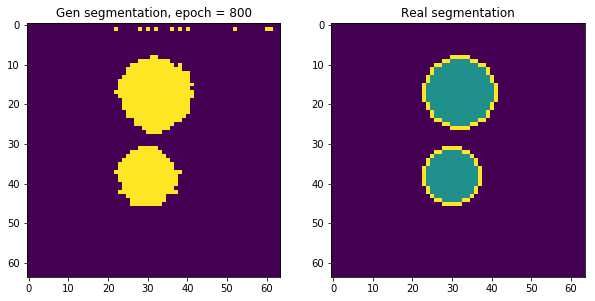

epoch - 800, loss - 0.466822326183
epoch - 801, loss - 0.481913715601
epoch - 802, loss - 0.490822076797
epoch - 803, loss - 0.488860964775
epoch - 804, loss - 0.488452732563
epoch - 805, loss - 0.481098651886
epoch - 806, loss - 0.52609872818
epoch - 807, loss - 0.603521645069
epoch - 808, loss - 0.588417828083
epoch - 809, loss - 0.576366364956
epoch - 810, loss - 0.535180926323
epoch - 811, loss - 0.484693050385
epoch - 812, loss - 0.482505202293
epoch - 813, loss - 0.491460025311
epoch - 814, loss - 0.480307489634
epoch - 815, loss - 0.470265209675
epoch - 816, loss - 0.461135566235
epoch - 817, loss - 0.46101295948
epoch - 818, loss - 0.448436915874
epoch - 819, loss - 0.44345626235
epoch - 820, loss - 0.437263786793
epoch - 821, loss - 0.429522007704
epoch - 822, loss - 0.433990120888
epoch - 823, loss - 0.424783021212
epoch - 824, loss - 0.417910575867
epoch - 825, loss - 0.418771982193
epoch - 826, loss - 0.419518858194
epoch - 827, loss - 0.40739774704
epoch - 828, loss - 0.40

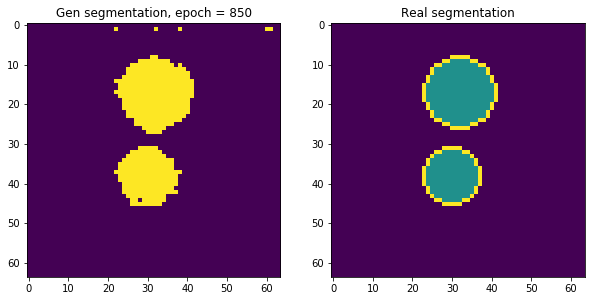

epoch - 850, loss - 0.400012731552
epoch - 851, loss - 0.407515108585
epoch - 852, loss - 0.40730214119
epoch - 853, loss - 0.393240600824
epoch - 854, loss - 0.395336210728
epoch - 855, loss - 0.396697044373
epoch - 856, loss - 0.391949295998
epoch - 857, loss - 0.39428088069
epoch - 858, loss - 0.408088505268
epoch - 859, loss - 0.418699502945
epoch - 860, loss - 0.43645554781
epoch - 861, loss - 0.444167494774
epoch - 862, loss - 0.448084890842
epoch - 863, loss - 0.459904015064
epoch - 864, loss - 0.483121037483
epoch - 865, loss - 0.491230487823
epoch - 866, loss - 0.478576034307
epoch - 867, loss - 0.444506317377
epoch - 868, loss - 0.395130515099
epoch - 869, loss - 0.394588112831
epoch - 870, loss - 0.424735248089
epoch - 871, loss - 0.420671910048
epoch - 872, loss - 0.389385402203
epoch - 873, loss - 0.386813640594
epoch - 874, loss - 0.397777616978
epoch - 875, loss - 0.383735656738
epoch - 876, loss - 0.36959323287
epoch - 877, loss - 0.371574282646
epoch - 878, loss - 0.37

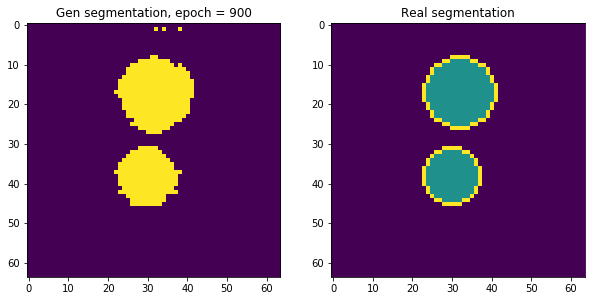

epoch - 900, loss - 0.384405046701
epoch - 901, loss - 0.375713974237
epoch - 902, loss - 0.386022150517
epoch - 903, loss - 0.366824090481
epoch - 904, loss - 0.36658757925
epoch - 905, loss - 0.366302639246
epoch - 906, loss - 0.352578282356
epoch - 907, loss - 0.352064907551
epoch - 908, loss - 0.35544487834
epoch - 909, loss - 0.341596961021
epoch - 910, loss - 0.346226155758
epoch - 911, loss - 0.345667272806
epoch - 912, loss - 0.334723442793
epoch - 913, loss - 0.337725937366
epoch - 914, loss - 0.339457005262
epoch - 915, loss - 0.332833111286
epoch - 916, loss - 0.334119677544
epoch - 917, loss - 0.336564183235
epoch - 918, loss - 0.335316956043
epoch - 919, loss - 0.342771470547
epoch - 920, loss - 0.352999925613
epoch - 921, loss - 0.368965297937
epoch - 922, loss - 0.39813670516
epoch - 923, loss - 0.420430243015
epoch - 924, loss - 0.443105041981
epoch - 925, loss - 0.441580176353
epoch - 926, loss - 0.421787202358
epoch - 927, loss - 0.397494137287
epoch - 928, loss - 0.3

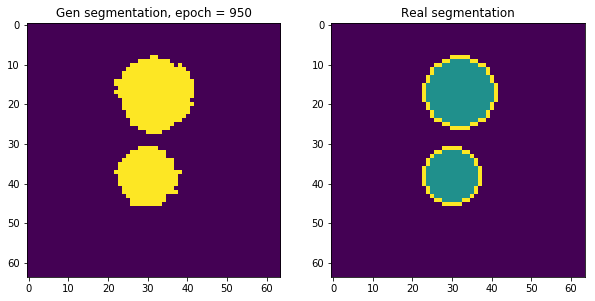

epoch - 950, loss - 0.341404497623
epoch - 951, loss - 0.345818012953
epoch - 952, loss - 0.364525467157
epoch - 953, loss - 0.387744367123
epoch - 954, loss - 0.39189234376
epoch - 955, loss - 0.385555833578
epoch - 956, loss - 0.351464152336
epoch - 957, loss - 0.335387229919
epoch - 958, loss - 0.347042322159
epoch - 959, loss - 0.344584435225
epoch - 960, loss - 0.330819487572
epoch - 961, loss - 0.321805298328
epoch - 962, loss - 0.328591704369
epoch - 963, loss - 0.346994519234
epoch - 964, loss - 0.348267674446
epoch - 965, loss - 0.33162266016
epoch - 966, loss - 0.321400642395
epoch - 967, loss - 0.340632498264
epoch - 968, loss - 0.353352278471
epoch - 969, loss - 0.346077799797
epoch - 970, loss - 0.336683422327
epoch - 971, loss - 0.348568975925
epoch - 972, loss - 0.344367146492
epoch - 973, loss - 0.336878567934
epoch - 974, loss - 0.336723446846
epoch - 975, loss - 0.361129879951
epoch - 976, loss - 0.363502025604
epoch - 977, loss - 0.344658851624
epoch - 978, loss - 0.

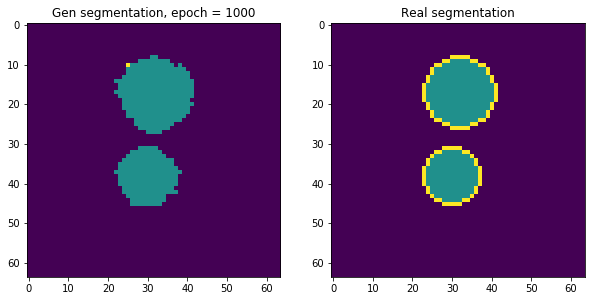

epoch - 1000, loss - 0.312318682671
epoch - 1001, loss - 0.312804281712
epoch - 1002, loss - 0.318521827459
epoch - 1003, loss - 0.313695043325
epoch - 1004, loss - 0.321534097195
epoch - 1005, loss - 0.308010667562
epoch - 1006, loss - 0.289383888245
epoch - 1007, loss - 0.296391755342
epoch - 1008, loss - 0.300980418921
epoch - 1009, loss - 0.292039036751
epoch - 1010, loss - 0.291581302881
epoch - 1011, loss - 0.290670871735
epoch - 1012, loss - 0.287473022938
epoch - 1013, loss - 0.293418258429
epoch - 1014, loss - 0.296785950661
epoch - 1015, loss - 0.289988100529
epoch - 1016, loss - 0.29110878706
epoch - 1017, loss - 0.300555467606
epoch - 1018, loss - 0.321724563837
epoch - 1019, loss - 0.348191857338
epoch - 1020, loss - 0.379427045584
epoch - 1021, loss - 0.394049823284
epoch - 1022, loss - 0.379447430372
epoch - 1023, loss - 0.387782931328
epoch - 1024, loss - 0.408922255039
epoch - 1025, loss - 0.391983836889
epoch - 1026, loss - 0.351658731699
epoch - 1027, loss - 0.338498

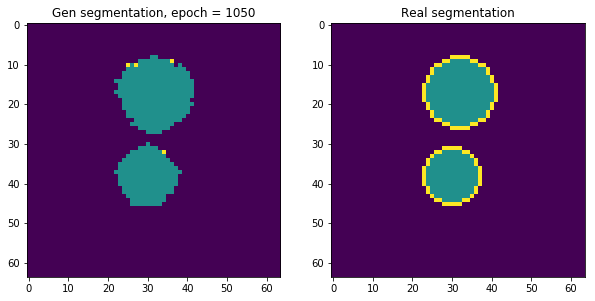

epoch - 1050, loss - 0.277437090874
epoch - 1051, loss - 0.300211131573
epoch - 1052, loss - 0.33661288023
epoch - 1053, loss - 0.422141194344
epoch - 1054, loss - 0.491044580936
epoch - 1055, loss - 0.557944893837
epoch - 1056, loss - 0.51358383894
epoch - 1057, loss - 0.409332215786
epoch - 1058, loss - 0.376936495304
epoch - 1059, loss - 0.413118064404
epoch - 1060, loss - 0.362829834223
epoch - 1061, loss - 0.362942099571
epoch - 1062, loss - 0.396976590157
epoch - 1063, loss - 0.335965573788
epoch - 1064, loss - 0.308318197727
epoch - 1065, loss - 0.339723885059
epoch - 1066, loss - 0.323000252247
epoch - 1067, loss - 0.295583635569
epoch - 1068, loss - 0.306723356247
epoch - 1069, loss - 0.30168196559
epoch - 1070, loss - 0.285167872906
epoch - 1071, loss - 0.28599563241
epoch - 1072, loss - 0.294235765934
epoch - 1073, loss - 0.280698537827
epoch - 1074, loss - 0.274582654238
epoch - 1075, loss - 0.280649513006
epoch - 1076, loss - 0.271060228348
epoch - 1077, loss - 0.267585694

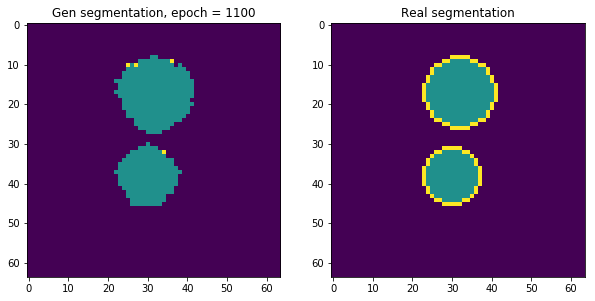

epoch - 1100, loss - 0.276742339134
epoch - 1101, loss - 0.279102265835
epoch - 1102, loss - 0.266089141369
epoch - 1103, loss - 0.267433106899
epoch - 1104, loss - 0.281850785017
epoch - 1105, loss - 0.284706711769
epoch - 1106, loss - 0.27690204978
epoch - 1107, loss - 0.265961736441
epoch - 1108, loss - 0.265842050314
epoch - 1109, loss - 0.269963264465
epoch - 1110, loss - 0.260821342468
epoch - 1111, loss - 0.251464605331
epoch - 1112, loss - 0.248315051198
epoch - 1113, loss - 0.256476670504
epoch - 1114, loss - 0.270383477211
epoch - 1115, loss - 0.274768173695
epoch - 1116, loss - 0.285301983356
epoch - 1117, loss - 0.308798134327
epoch - 1118, loss - 0.323933184147
epoch - 1119, loss - 0.329992204905
epoch - 1120, loss - 0.315938293934
epoch - 1121, loss - 0.315842926502
epoch - 1122, loss - 0.333167344332
epoch - 1123, loss - 0.327811300755
epoch - 1124, loss - 0.305402040482
epoch - 1125, loss - 0.274631917477
epoch - 1126, loss - 0.276067376137
epoch - 1127, loss - 0.293351

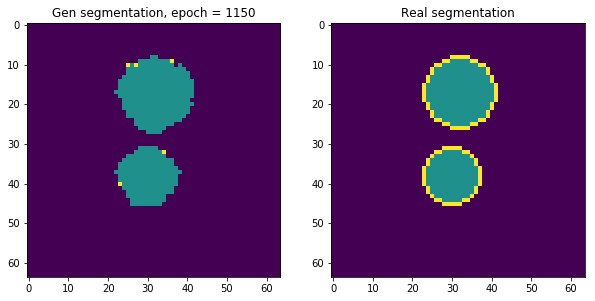

epoch - 1150, loss - 0.340808659792
epoch - 1151, loss - 0.346860319376
epoch - 1152, loss - 0.301800400019
epoch - 1153, loss - 0.31793615222
epoch - 1154, loss - 0.34427651763
epoch - 1155, loss - 0.310121953487
epoch - 1156, loss - 0.270428031683
epoch - 1157, loss - 0.269965946674
epoch - 1158, loss - 0.276807844639
epoch - 1159, loss - 0.27696454525
epoch - 1160, loss - 0.272957652807
epoch - 1161, loss - 0.258853495121
epoch - 1162, loss - 0.245749652386
epoch - 1163, loss - 0.248523265123
epoch - 1164, loss - 0.251240849495
epoch - 1165, loss - 0.245047837496
epoch - 1166, loss - 0.241562396288
epoch - 1167, loss - 0.239013582468
epoch - 1168, loss - 0.236623555422
epoch - 1169, loss - 0.236276522279
epoch - 1170, loss - 0.23159378767
epoch - 1171, loss - 0.229934960604
epoch - 1172, loss - 0.231690496206
epoch - 1173, loss - 0.230117172003
epoch - 1174, loss - 0.227848052979
epoch - 1175, loss - 0.227119624615
epoch - 1176, loss - 0.22973459959
epoch - 1177, loss - 0.2317847311

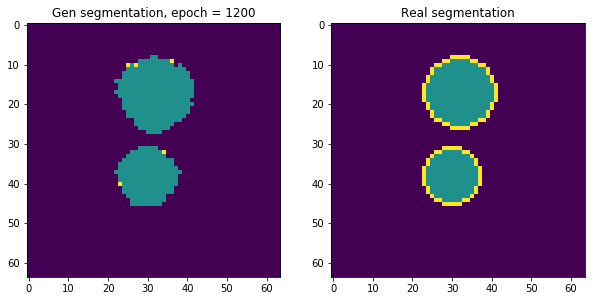

epoch - 1200, loss - 0.232851654291
epoch - 1201, loss - 0.23572999239
epoch - 1202, loss - 0.238756656647
epoch - 1203, loss - 0.235759004951
epoch - 1204, loss - 0.232482761145
epoch - 1205, loss - 0.233401358128
epoch - 1206, loss - 0.231042861938
epoch - 1207, loss - 0.222509786487
epoch - 1208, loss - 0.228316038847
epoch - 1209, loss - 0.237466067076
epoch - 1210, loss - 0.236275881529
epoch - 1211, loss - 0.240093261003
epoch - 1212, loss - 0.257913261652
epoch - 1213, loss - 0.265258073807
epoch - 1214, loss - 0.272244751453
epoch - 1215, loss - 0.280141979456
epoch - 1216, loss - 0.276528269053
epoch - 1217, loss - 0.270818859339
epoch - 1218, loss - 0.260199666023
epoch - 1219, loss - 0.261302530766
epoch - 1220, loss - 0.263092517853
epoch - 1221, loss - 0.260204434395
epoch - 1222, loss - 0.250805050135
epoch - 1223, loss - 0.25419357419
epoch - 1224, loss - 0.249363809824
epoch - 1225, loss - 0.241692811251
epoch - 1226, loss - 0.24642854929
epoch - 1227, loss - 0.25908011

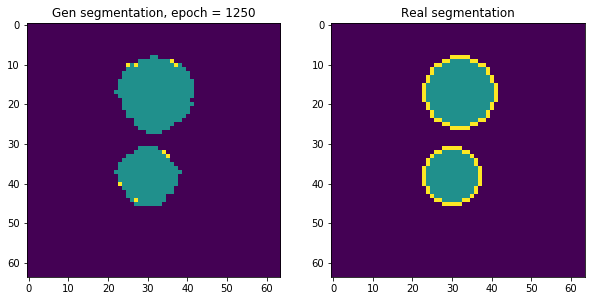

epoch - 1250, loss - 0.232566177845
epoch - 1251, loss - 0.241744995117
epoch - 1252, loss - 0.248504072428
epoch - 1253, loss - 0.252593964338
epoch - 1254, loss - 0.26889026165
epoch - 1255, loss - 0.283958941698
epoch - 1256, loss - 0.296515136957
epoch - 1257, loss - 0.295473068953
epoch - 1258, loss - 0.302997857332
epoch - 1259, loss - 0.321319818497
epoch - 1260, loss - 0.332000911236
epoch - 1261, loss - 0.329466849566
epoch - 1262, loss - 0.273392945528
epoch - 1263, loss - 0.256411969662
epoch - 1264, loss - 0.29933437705
epoch - 1265, loss - 0.290488094091
epoch - 1266, loss - 0.240631699562
epoch - 1267, loss - 0.246474325657
epoch - 1268, loss - 0.265017718077
epoch - 1269, loss - 0.244055628777
epoch - 1270, loss - 0.23421433568
epoch - 1271, loss - 0.240478336811
epoch - 1272, loss - 0.225148916245
epoch - 1273, loss - 0.224237829447
epoch - 1274, loss - 0.232386738062
epoch - 1275, loss - 0.217963606119
epoch - 1276, loss - 0.214868366718
epoch - 1277, loss - 0.21753293

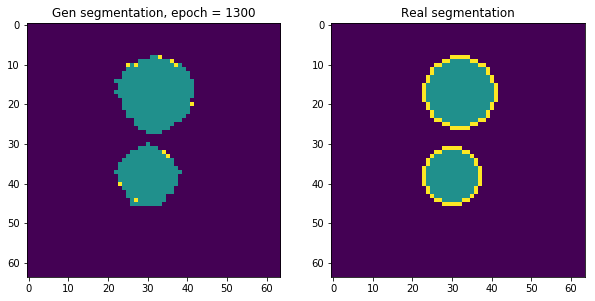

epoch - 1300, loss - 0.248858958483
epoch - 1301, loss - 0.231704205275
epoch - 1302, loss - 0.248642891645
epoch - 1303, loss - 0.258104175329
epoch - 1304, loss - 0.23880161345
epoch - 1305, loss - 0.213475689292
epoch - 1306, loss - 0.216545253992
epoch - 1307, loss - 0.231125622988
epoch - 1308, loss - 0.225660830736
epoch - 1309, loss - 0.213200122118
epoch - 1310, loss - 0.206430345774
epoch - 1311, loss - 0.208244636655
epoch - 1312, loss - 0.207225844264
epoch - 1313, loss - 0.203708589077
epoch - 1314, loss - 0.206759095192
epoch - 1315, loss - 0.20501357317
epoch - 1316, loss - 0.19673140347
epoch - 1317, loss - 0.195601463318
epoch - 1318, loss - 0.199230402708
epoch - 1319, loss - 0.20254008472
epoch - 1320, loss - 0.204702526331
epoch - 1321, loss - 0.213509991765
epoch - 1322, loss - 0.223684877157
epoch - 1323, loss - 0.246366739273
epoch - 1324, loss - 0.259087145329
epoch - 1325, loss - 0.271902352571
epoch - 1326, loss - 0.257083594799
epoch - 1327, loss - 0.229116663

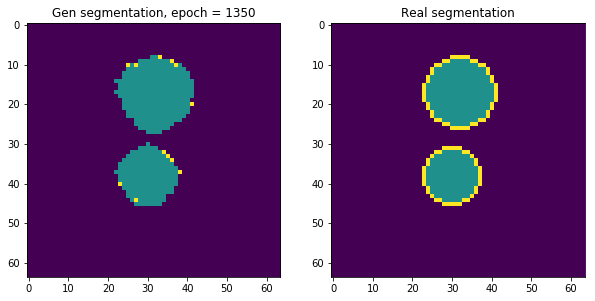

epoch - 1350, loss - 0.208640545607
epoch - 1351, loss - 0.210296720266
epoch - 1352, loss - 0.217471674085
epoch - 1353, loss - 0.226851612329
epoch - 1354, loss - 0.226279050112
epoch - 1355, loss - 0.226436197758
epoch - 1356, loss - 0.228259921074
epoch - 1357, loss - 0.241853162646
epoch - 1358, loss - 0.257623672485
epoch - 1359, loss - 0.26978880167
epoch - 1360, loss - 0.277530252934
epoch - 1361, loss - 0.259412825108
epoch - 1362, loss - 0.2409927845
epoch - 1363, loss - 0.241498798132
epoch - 1364, loss - 0.241353675723
epoch - 1365, loss - 0.237230360508
epoch - 1366, loss - 0.213491484523
epoch - 1367, loss - 0.207038864493
epoch - 1368, loss - 0.212304234505
epoch - 1369, loss - 0.21007861197
epoch - 1370, loss - 0.212694570422
epoch - 1371, loss - 0.204882413149
epoch - 1372, loss - 0.194744080305
epoch - 1373, loss - 0.196543186903
epoch - 1374, loss - 0.200886458158
epoch - 1375, loss - 0.195730268955
epoch - 1376, loss - 0.192834854126
epoch - 1377, loss - 0.195361167

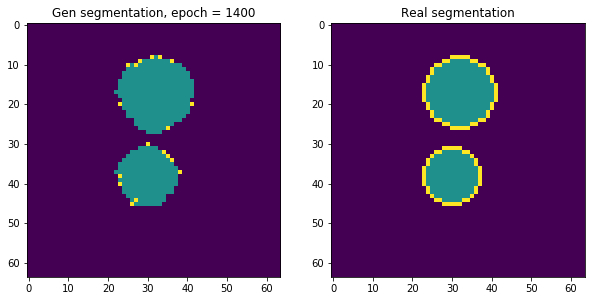

epoch - 1400, loss - 0.288607954979
epoch - 1401, loss - 0.232736945152
epoch - 1402, loss - 0.244946420193
epoch - 1403, loss - 0.274109899998
epoch - 1404, loss - 0.261444151402
epoch - 1405, loss - 0.233132392168
epoch - 1406, loss - 0.240267768502
epoch - 1407, loss - 0.226478636265
epoch - 1408, loss - 0.211089581251
epoch - 1409, loss - 0.210466071963
epoch - 1410, loss - 0.209159761667
epoch - 1411, loss - 0.213596314192
epoch - 1412, loss - 0.204759269953
epoch - 1413, loss - 0.190242141485
epoch - 1414, loss - 0.191934600472
epoch - 1415, loss - 0.197109207511
epoch - 1416, loss - 0.190987557173
epoch - 1417, loss - 0.185744076967
epoch - 1418, loss - 0.187119245529
epoch - 1419, loss - 0.185123860836
epoch - 1420, loss - 0.185887992382
epoch - 1421, loss - 0.184297859669
epoch - 1422, loss - 0.178219005466
epoch - 1423, loss - 0.176784157753
epoch - 1424, loss - 0.178229629993
epoch - 1425, loss - 0.177976742387
epoch - 1426, loss - 0.179646849632
epoch - 1427, loss - 0.18351

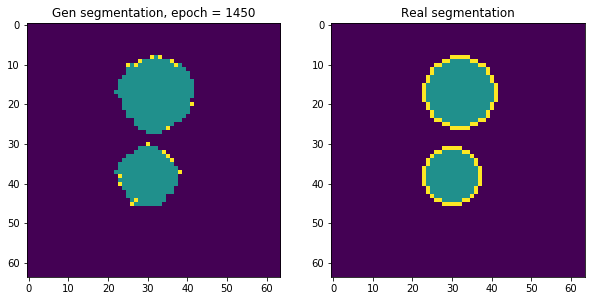

epoch - 1450, loss - 0.222059845924
epoch - 1451, loss - 0.234844923019
epoch - 1452, loss - 0.2301620543
epoch - 1453, loss - 0.215827539563
epoch - 1454, loss - 0.213700741529
epoch - 1455, loss - 0.202714383602
epoch - 1456, loss - 0.188131198287
epoch - 1457, loss - 0.192457616329
epoch - 1458, loss - 0.203335598111
epoch - 1459, loss - 0.195531785488
epoch - 1460, loss - 0.185693383217
epoch - 1461, loss - 0.182440727949
epoch - 1462, loss - 0.179707407951
epoch - 1463, loss - 0.178417906165
epoch - 1464, loss - 0.17611515522
epoch - 1465, loss - 0.174977317452
epoch - 1466, loss - 0.176180124283
epoch - 1467, loss - 0.175523236394
epoch - 1468, loss - 0.174673229456
epoch - 1469, loss - 0.174724683166
epoch - 1470, loss - 0.175946578383
epoch - 1471, loss - 0.173540189862
epoch - 1472, loss - 0.173305332661
epoch - 1473, loss - 0.178593248129
epoch - 1474, loss - 0.180768489838
epoch - 1475, loss - 0.182562187314
epoch - 1476, loss - 0.190817385912
epoch - 1477, loss - 0.20030154

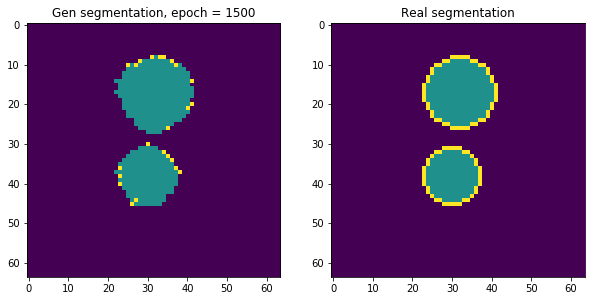

epoch - 1500, loss - 0.207137987018
epoch - 1501, loss - 0.23369383812
epoch - 1502, loss - 0.205767586827
epoch - 1503, loss - 0.195104509592
epoch - 1504, loss - 0.195365041494
epoch - 1505, loss - 0.18887911737
epoch - 1506, loss - 0.191426187754
epoch - 1507, loss - 0.183858603239
epoch - 1508, loss - 0.179913789034
epoch - 1509, loss - 0.184170588851
epoch - 1510, loss - 0.178286194801
epoch - 1511, loss - 0.172234207392
epoch - 1512, loss - 0.174511268735
epoch - 1513, loss - 0.16987234354
epoch - 1514, loss - 0.165250599384
epoch - 1515, loss - 0.17042414844
epoch - 1516, loss - 0.169698297977
epoch - 1517, loss - 0.163031101227
epoch - 1518, loss - 0.164303541183
epoch - 1519, loss - 0.163723498583
epoch - 1520, loss - 0.15953117609
epoch - 1521, loss - 0.161858379841
epoch - 1522, loss - 0.161419510841
epoch - 1523, loss - 0.15850391984
epoch - 1524, loss - 0.161544770002
epoch - 1525, loss - 0.166363939643
epoch - 1526, loss - 0.176571026444
epoch - 1527, loss - 0.19265730679

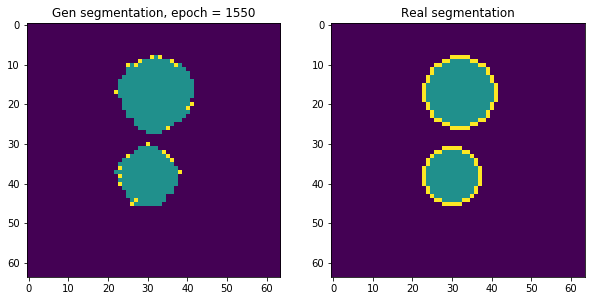

epoch - 1550, loss - 0.189909934998
epoch - 1551, loss - 0.190456867218
epoch - 1552, loss - 0.181893318892
epoch - 1553, loss - 0.170144915581
epoch - 1554, loss - 0.172591134906
epoch - 1555, loss - 0.176160395145
epoch - 1556, loss - 0.168161481619
epoch - 1557, loss - 0.167057842016
epoch - 1558, loss - 0.171090513468
epoch - 1559, loss - 0.16752949357
epoch - 1560, loss - 0.162047058344
epoch - 1561, loss - 0.163725852966
epoch - 1562, loss - 0.165070414543
epoch - 1563, loss - 0.161417633295
epoch - 1564, loss - 0.159127950668
epoch - 1565, loss - 0.16012775898
epoch - 1566, loss - 0.161994040012
epoch - 1567, loss - 0.164373397827
epoch - 1568, loss - 0.167280822992
epoch - 1569, loss - 0.173871472478
epoch - 1570, loss - 0.187016949058
epoch - 1571, loss - 0.205947071314
epoch - 1572, loss - 0.214540451765
epoch - 1573, loss - 0.210012346506
epoch - 1574, loss - 0.197705462575
epoch - 1575, loss - 0.188423603773
epoch - 1576, loss - 0.194220855832
epoch - 1577, loss - 0.2202380

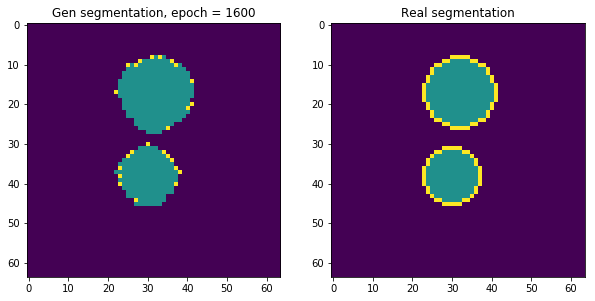

epoch - 1600, loss - 0.163970515132
epoch - 1601, loss - 0.167998492718
epoch - 1602, loss - 0.161751657724
epoch - 1603, loss - 0.157698601484
epoch - 1604, loss - 0.156231820583
epoch - 1605, loss - 0.152912378311
epoch - 1606, loss - 0.151884332299
epoch - 1607, loss - 0.15075302124
epoch - 1608, loss - 0.150923058391
epoch - 1609, loss - 0.152125671506
epoch - 1610, loss - 0.152577698231
epoch - 1611, loss - 0.154755845666
epoch - 1612, loss - 0.155254393816
epoch - 1613, loss - 0.156638473272
epoch - 1614, loss - 0.159119099379
epoch - 1615, loss - 0.163310602307
epoch - 1616, loss - 0.165253117681
epoch - 1617, loss - 0.170825973153
epoch - 1618, loss - 0.177715823054
epoch - 1619, loss - 0.180831342936
epoch - 1620, loss - 0.179650977254
epoch - 1621, loss - 0.179789572954
epoch - 1622, loss - 0.17681658268
epoch - 1623, loss - 0.17665630579
epoch - 1624, loss - 0.178234890103
epoch - 1625, loss - 0.19298222661
epoch - 1626, loss - 0.22963309288
epoch - 1627, loss - 0.2742606699

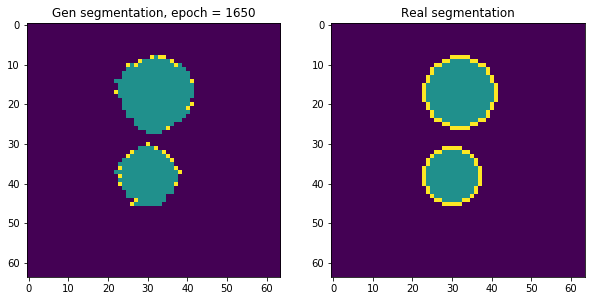

epoch - 1650, loss - 0.151894152164
epoch - 1651, loss - 0.156496435404
epoch - 1652, loss - 0.150822728872
epoch - 1653, loss - 0.147982761264
epoch - 1654, loss - 0.150190547109
epoch - 1655, loss - 0.149465784431
epoch - 1656, loss - 0.145770013332
epoch - 1657, loss - 0.147955387831
epoch - 1658, loss - 0.15110835433
epoch - 1659, loss - 0.152247786522
epoch - 1660, loss - 0.15908664465
epoch - 1661, loss - 0.172288581729
epoch - 1662, loss - 0.190182387829
epoch - 1663, loss - 0.225419402122
epoch - 1664, loss - 0.269847214222
epoch - 1665, loss - 0.340502500534
epoch - 1666, loss - 0.366912543774
epoch - 1667, loss - 0.369476407766
epoch - 1668, loss - 0.285761117935
epoch - 1669, loss - 0.194531321526
epoch - 1670, loss - 0.164186909795
epoch - 1671, loss - 0.210301607847
epoch - 1672, loss - 0.255288809538
epoch - 1673, loss - 0.231013521552
epoch - 1674, loss - 0.180340230465
epoch - 1675, loss - 0.158983260393
epoch - 1676, loss - 0.185231983662
epoch - 1677, loss - 0.2150896

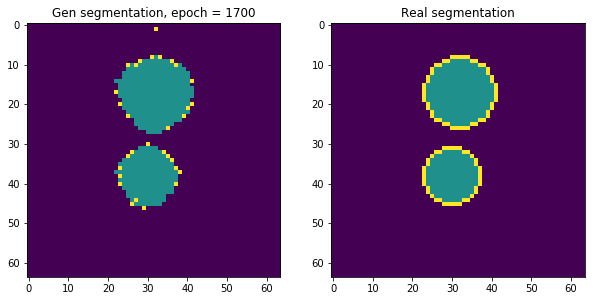

epoch - 1700, loss - 0.177401006222
epoch - 1701, loss - 0.162805706263
epoch - 1702, loss - 0.164578169584
epoch - 1703, loss - 0.172100752592
epoch - 1704, loss - 0.174832165241
epoch - 1705, loss - 0.161815166473
epoch - 1706, loss - 0.151370435953
epoch - 1707, loss - 0.156402140856
epoch - 1708, loss - 0.164848774672
epoch - 1709, loss - 0.161867797375
epoch - 1710, loss - 0.148918196559
epoch - 1711, loss - 0.145918220282
epoch - 1712, loss - 0.148159831762
epoch - 1713, loss - 0.151725411415
epoch - 1714, loss - 0.152565091848
epoch - 1715, loss - 0.152592360973
epoch - 1716, loss - 0.15917801857
epoch - 1717, loss - 0.167753458023
epoch - 1718, loss - 0.175275176764
epoch - 1719, loss - 0.191739886999
epoch - 1720, loss - 0.21058575809
epoch - 1721, loss - 0.241118237376
epoch - 1722, loss - 0.243792533875
epoch - 1723, loss - 0.248248010874
epoch - 1724, loss - 0.246688336134
epoch - 1725, loss - 0.220751315355
epoch - 1726, loss - 0.183606222272
epoch - 1727, loss - 0.1684116

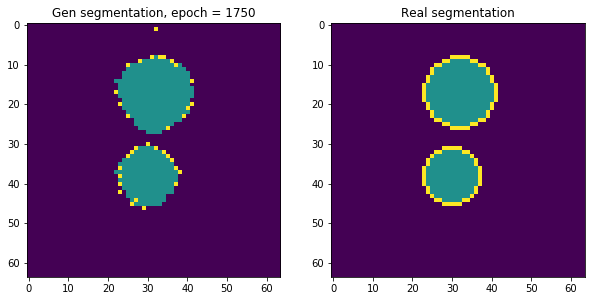

epoch - 1750, loss - 0.153476133943
epoch - 1751, loss - 0.146779984236
epoch - 1752, loss - 0.14636605978
epoch - 1753, loss - 0.14007024467
epoch - 1754, loss - 0.136479377747
epoch - 1755, loss - 0.141985207796
epoch - 1756, loss - 0.146842464805
epoch - 1757, loss - 0.151425540447
epoch - 1758, loss - 0.15821403265
epoch - 1759, loss - 0.170954018831
epoch - 1760, loss - 0.181963205338
epoch - 1761, loss - 0.19876229763
epoch - 1762, loss - 0.210582792759
epoch - 1763, loss - 0.229022875428
epoch - 1764, loss - 0.24809782207
epoch - 1765, loss - 0.26507794857
epoch - 1766, loss - 0.280567467213
epoch - 1767, loss - 0.22589224577
epoch - 1768, loss - 0.165014952421
epoch - 1769, loss - 0.185469985008
epoch - 1770, loss - 0.2294498384
epoch - 1771, loss - 0.217655658722
epoch - 1772, loss - 0.170799165964
epoch - 1773, loss - 0.173897951841
epoch - 1774, loss - 0.201962471008
epoch - 1775, loss - 0.176507741213
epoch - 1776, loss - 0.154053613544
epoch - 1777, loss - 0.162496313453
e

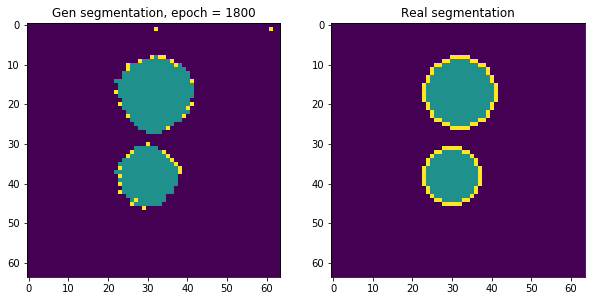

epoch - 1800, loss - 0.235979408026
epoch - 1801, loss - 0.186150163412
epoch - 1802, loss - 0.149180218577
epoch - 1803, loss - 0.145598515868
epoch - 1804, loss - 0.177011966705
epoch - 1805, loss - 0.202452927828
epoch - 1806, loss - 0.196373969316
epoch - 1807, loss - 0.166966795921
epoch - 1808, loss - 0.147736638784
epoch - 1809, loss - 0.141472652555
epoch - 1810, loss - 0.148827582598
epoch - 1811, loss - 0.162918478251
epoch - 1812, loss - 0.166969865561
epoch - 1813, loss - 0.163288518786
epoch - 1814, loss - 0.151084706187
epoch - 1815, loss - 0.144296139479
epoch - 1816, loss - 0.14283375442
epoch - 1817, loss - 0.144245773554
epoch - 1818, loss - 0.149937599897
epoch - 1819, loss - 0.153119593859
epoch - 1820, loss - 0.154076099396
epoch - 1821, loss - 0.15010201931
epoch - 1822, loss - 0.143803983927
epoch - 1823, loss - 0.137744769454
epoch - 1824, loss - 0.131976783276
epoch - 1825, loss - 0.131174772978
epoch - 1826, loss - 0.136225402355
epoch - 1827, loss - 0.1411883

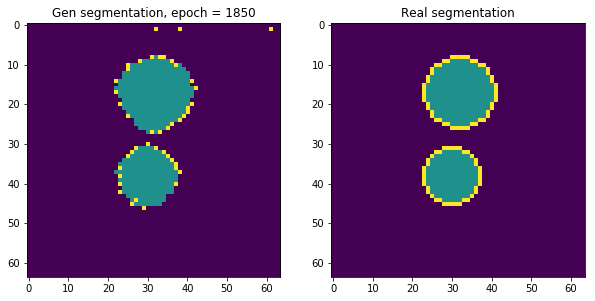

epoch - 1850, loss - 0.181146651506
epoch - 1851, loss - 0.16784453392
epoch - 1852, loss - 0.162786990404
epoch - 1853, loss - 0.161276400089
epoch - 1854, loss - 0.150193572044
epoch - 1855, loss - 0.15814191103
epoch - 1856, loss - 0.148595422506
epoch - 1857, loss - 0.138241827488
epoch - 1858, loss - 0.146304905415
epoch - 1859, loss - 0.136604681611
epoch - 1860, loss - 0.132033526897
epoch - 1861, loss - 0.138883471489
epoch - 1862, loss - 0.130411237478
epoch - 1863, loss - 0.127356916666
epoch - 1864, loss - 0.132751584053
epoch - 1865, loss - 0.127523377538
epoch - 1866, loss - 0.125472813845
epoch - 1867, loss - 0.128835201263
epoch - 1868, loss - 0.127070948482
epoch - 1869, loss - 0.127941474319
epoch - 1870, loss - 0.131275817752
epoch - 1871, loss - 0.134682804346
epoch - 1872, loss - 0.143602818251
epoch - 1873, loss - 0.157462477684
epoch - 1874, loss - 0.180352300406
epoch - 1875, loss - 0.211703747511
epoch - 1876, loss - 0.261778086424
epoch - 1877, loss - 0.2961531

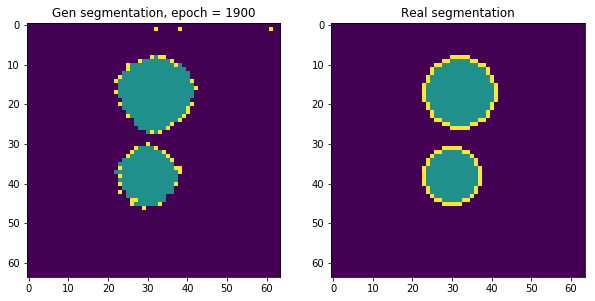

epoch - 1900, loss - 0.139499887824
epoch - 1901, loss - 0.13336250186
epoch - 1902, loss - 0.129374146461
epoch - 1903, loss - 0.129348143935
epoch - 1904, loss - 0.130056977272
epoch - 1905, loss - 0.130699589849
epoch - 1906, loss - 0.127125144005
epoch - 1907, loss - 0.123519740999
epoch - 1908, loss - 0.123224876821
epoch - 1909, loss - 0.122486755252
epoch - 1910, loss - 0.122565612197
epoch - 1911, loss - 0.122545532882
epoch - 1912, loss - 0.121876493096
epoch - 1913, loss - 0.120784088969
epoch - 1914, loss - 0.119151756167
epoch - 1915, loss - 0.119206465781
epoch - 1916, loss - 0.122670650482
epoch - 1917, loss - 0.128048017621
epoch - 1918, loss - 0.134703427553
epoch - 1919, loss - 0.14851140976
epoch - 1920, loss - 0.167203307152
epoch - 1921, loss - 0.196818739176
epoch - 1922, loss - 0.211586371064
epoch - 1923, loss - 0.216076090932
epoch - 1924, loss - 0.209831252694
epoch - 1925, loss - 0.197820693254
epoch - 1926, loss - 0.213880285621
epoch - 1927, loss - 0.1989938

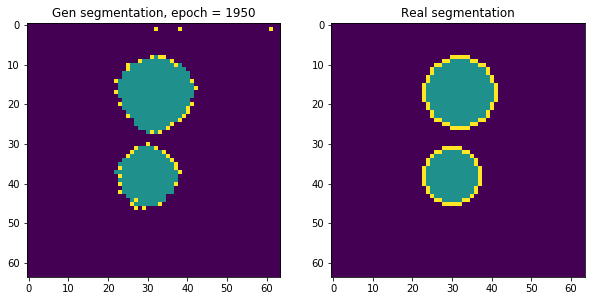

epoch - 1950, loss - 0.127343192697
epoch - 1951, loss - 0.13297060132
epoch - 1952, loss - 0.135276675224
epoch - 1953, loss - 0.144383251667
epoch - 1954, loss - 0.162436708808
epoch - 1955, loss - 0.171776950359
epoch - 1956, loss - 0.183336943388
epoch - 1957, loss - 0.196335196495
epoch - 1958, loss - 0.235764205456
epoch - 1959, loss - 0.279799997807
epoch - 1960, loss - 0.364423036575
epoch - 1961, loss - 0.364380627871
epoch - 1962, loss - 0.277192384005
epoch - 1963, loss - 0.169387340546
epoch - 1964, loss - 0.173771351576
epoch - 1965, loss - 0.231535762548
epoch - 1966, loss - 0.224543839693
epoch - 1967, loss - 0.177858144045
epoch - 1968, loss - 0.158223301172
epoch - 1969, loss - 0.169249117374
epoch - 1970, loss - 0.171764761209
epoch - 1971, loss - 0.157763943076
epoch - 1972, loss - 0.149771690369
epoch - 1973, loss - 0.154213503003
epoch - 1974, loss - 0.144586801529
epoch - 1975, loss - 0.131957367063
epoch - 1976, loss - 0.142853841186
epoch - 1977, loss - 0.142396

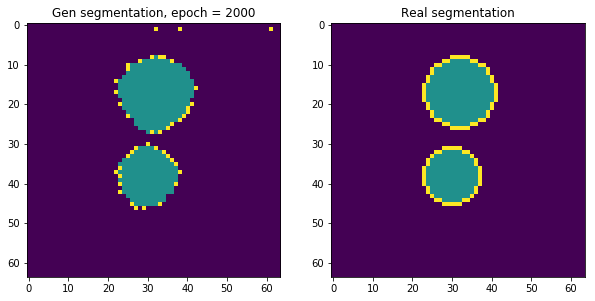

epoch - 2000, loss - 0.143984362483
epoch - 2001, loss - 0.148666605353
epoch - 2002, loss - 0.155132353306
epoch - 2003, loss - 0.154163494706
epoch - 2004, loss - 0.156078234315
epoch - 2005, loss - 0.157504603267
epoch - 2006, loss - 0.170609816909
epoch - 2007, loss - 0.186015561223
epoch - 2008, loss - 0.189879566431
epoch - 2009, loss - 0.179948508739
epoch - 2010, loss - 0.156913563609
epoch - 2011, loss - 0.152714252472
epoch - 2012, loss - 0.169731676579
epoch - 2013, loss - 0.17305418849
epoch - 2014, loss - 0.154567450285
epoch - 2015, loss - 0.135235533118
epoch - 2016, loss - 0.131347879767
epoch - 2017, loss - 0.138345271349
epoch - 2018, loss - 0.133796364069
epoch - 2019, loss - 0.125908061862
epoch - 2020, loss - 0.127816602588
epoch - 2021, loss - 0.129689529538
epoch - 2022, loss - 0.125428169966
epoch - 2023, loss - 0.120335005224
epoch - 2024, loss - 0.11993791908
epoch - 2025, loss - 0.120451033115
epoch - 2026, loss - 0.118769153953
epoch - 2027, loss - 0.1186583

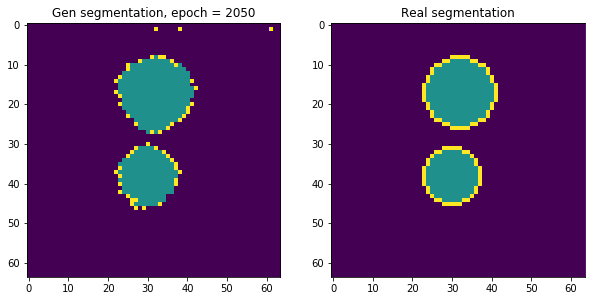

epoch - 2050, loss - 0.1482488662
epoch - 2051, loss - 0.144261270761
epoch - 2052, loss - 0.134037584066
epoch - 2053, loss - 0.146602258086
epoch - 2054, loss - 0.145459234715
epoch - 2055, loss - 0.123702682555
epoch - 2056, loss - 0.127391025424
epoch - 2057, loss - 0.131891101599
epoch - 2058, loss - 0.126650154591
epoch - 2059, loss - 0.127668142319
epoch - 2060, loss - 0.118781045079
epoch - 2061, loss - 0.116179913282
epoch - 2062, loss - 0.120843105018
epoch - 2063, loss - 0.118007272482
epoch - 2064, loss - 0.116724550724
epoch - 2065, loss - 0.114564009011
epoch - 2066, loss - 0.111315742135
epoch - 2067, loss - 0.112420476973
epoch - 2068, loss - 0.111445188522
epoch - 2069, loss - 0.110561266541
epoch - 2070, loss - 0.113925755024
epoch - 2071, loss - 0.116535387933
epoch - 2072, loss - 0.121247150004
epoch - 2073, loss - 0.133919924498
epoch - 2074, loss - 0.153950899839
epoch - 2075, loss - 0.183485895395
epoch - 2076, loss - 0.230949401855
epoch - 2077, loss - 0.2673098

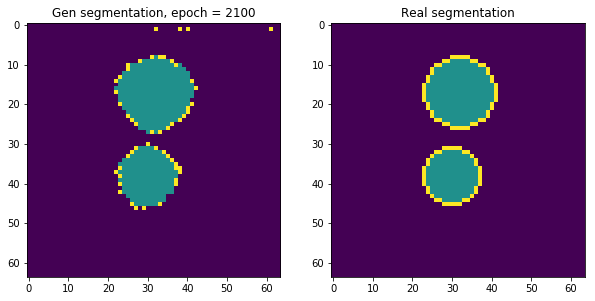

epoch - 2100, loss - 0.11129976809
epoch - 2101, loss - 0.109578408301
epoch - 2102, loss - 0.110283344984
epoch - 2103, loss - 0.110986538231
epoch - 2104, loss - 0.109396450222
epoch - 2105, loss - 0.106176957488
epoch - 2106, loss - 0.105769634247
epoch - 2107, loss - 0.106986388564
epoch - 2108, loss - 0.107306003571
epoch - 2109, loss - 0.105858244002
epoch - 2110, loss - 0.104224890471
epoch - 2111, loss - 0.104510501027
epoch - 2112, loss - 0.107990242541
epoch - 2113, loss - 0.111834987998
epoch - 2114, loss - 0.114258930087
epoch - 2115, loss - 0.118687778711
epoch - 2116, loss - 0.12504902482
epoch - 2117, loss - 0.13273306191
epoch - 2118, loss - 0.138571932912
epoch - 2119, loss - 0.137200683355
epoch - 2120, loss - 0.129799604416
epoch - 2121, loss - 0.125174030662
epoch - 2122, loss - 0.135384321213
epoch - 2123, loss - 0.160247758031
epoch - 2124, loss - 0.179751262069
epoch - 2125, loss - 0.183950901031
epoch - 2126, loss - 0.15714751184
epoch - 2127, loss - 0.159909158

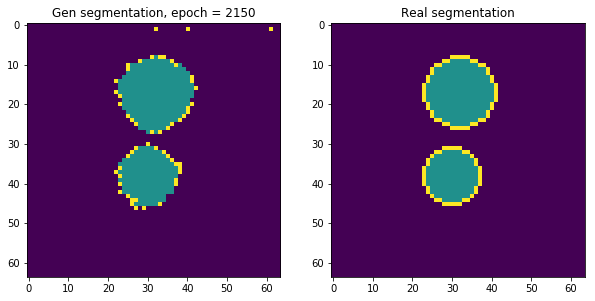

epoch - 2150, loss - 0.125969931483
epoch - 2151, loss - 0.11576539278
epoch - 2152, loss - 0.113425754011
epoch - 2153, loss - 0.114885151386
epoch - 2154, loss - 0.109054043889
epoch - 2155, loss - 0.112400427461
epoch - 2156, loss - 0.113090142608
epoch - 2157, loss - 0.10728764534
epoch - 2158, loss - 0.108427673578
epoch - 2159, loss - 0.109897196293
epoch - 2160, loss - 0.105556048453
epoch - 2161, loss - 0.107537932694
epoch - 2162, loss - 0.110282123089
epoch - 2163, loss - 0.108434587717
epoch - 2164, loss - 0.109886795282
epoch - 2165, loss - 0.113583035767
epoch - 2166, loss - 0.114867769182
epoch - 2167, loss - 0.121283084154
epoch - 2168, loss - 0.131001919508
epoch - 2169, loss - 0.146449282765
epoch - 2170, loss - 0.162453591824
epoch - 2171, loss - 0.193104445934
epoch - 2172, loss - 0.208621069789
epoch - 2173, loss - 0.228518590331
epoch - 2174, loss - 0.218398347497
epoch - 2175, loss - 0.204973399639
epoch - 2176, loss - 0.176603883505
epoch - 2177, loss - 0.1572273

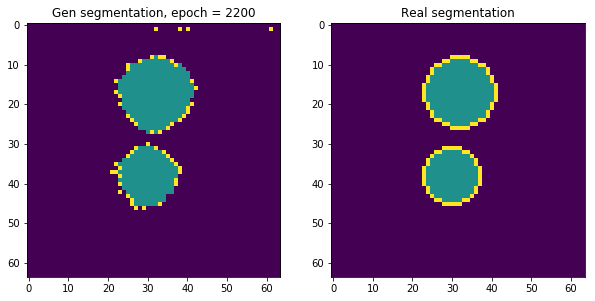

epoch - 2200, loss - 0.10549429059
epoch - 2201, loss - 0.108429357409
epoch - 2202, loss - 0.110593259335
epoch - 2203, loss - 0.11030459404
epoch - 2204, loss - 0.111763447523
epoch - 2205, loss - 0.11826658994
epoch - 2206, loss - 0.132549732924
epoch - 2207, loss - 0.146311193705
epoch - 2208, loss - 0.158558055758
epoch - 2209, loss - 0.164157688618
epoch - 2210, loss - 0.181352242827
epoch - 2211, loss - 0.209797918797
epoch - 2212, loss - 0.234494164586
epoch - 2213, loss - 0.252600938082
epoch - 2214, loss - 0.240822553635
epoch - 2215, loss - 0.252318382263
epoch - 2216, loss - 0.215506464243
epoch - 2217, loss - 0.161988094449
epoch - 2218, loss - 0.125395387411
epoch - 2219, loss - 0.15546426177
epoch - 2220, loss - 0.171464920044
epoch - 2221, loss - 0.14506059885
epoch - 2222, loss - 0.143564969301
epoch - 2223, loss - 0.140437573195
epoch - 2224, loss - 0.118019670248
epoch - 2225, loss - 0.119816876948
epoch - 2226, loss - 0.131219103932
epoch - 2227, loss - 0.1190342456

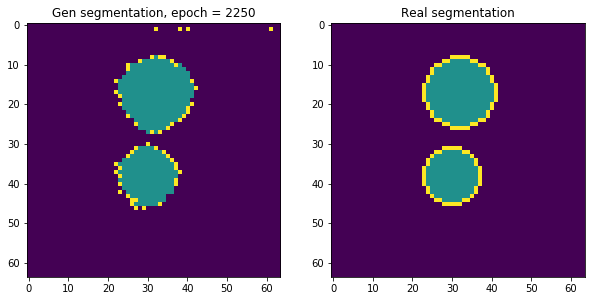

epoch - 2250, loss - 0.149740025401
epoch - 2251, loss - 0.194493100047
epoch - 2252, loss - 0.277633100748
epoch - 2253, loss - 0.339481204748
epoch - 2254, loss - 0.400667250156
epoch - 2255, loss - 0.331749022007
epoch - 2256, loss - 0.242339074612
epoch - 2257, loss - 0.211552500725
epoch - 2258, loss - 0.229810208082
epoch - 2259, loss - 0.188362434506
epoch - 2260, loss - 0.190267309546
epoch - 2261, loss - 0.220119386911
epoch - 2262, loss - 0.159560635686
epoch - 2263, loss - 0.132724285126
epoch - 2264, loss - 0.164553746581
epoch - 2265, loss - 0.161994248629
epoch - 2266, loss - 0.137782484293
epoch - 2267, loss - 0.127171054482
epoch - 2268, loss - 0.133779972792
epoch - 2269, loss - 0.131728440523
epoch - 2270, loss - 0.118996247649
epoch - 2271, loss - 0.121108293533
epoch - 2272, loss - 0.121397092938
epoch - 2273, loss - 0.111691147089
epoch - 2274, loss - 0.109268218279
epoch - 2275, loss - 0.11175340414
epoch - 2276, loss - 0.110565051436
epoch - 2277, loss - 0.107088

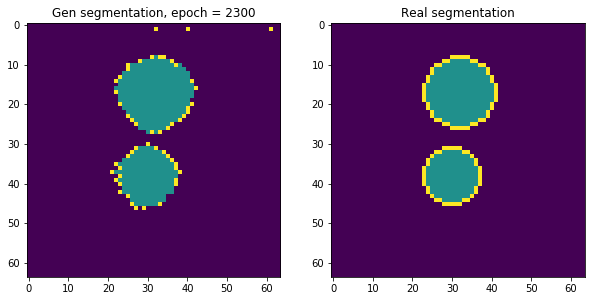

epoch - 2300, loss - 0.139587908983
epoch - 2301, loss - 0.145393759012
epoch - 2302, loss - 0.151349186897
epoch - 2303, loss - 0.146811321378
epoch - 2304, loss - 0.138674125075
epoch - 2305, loss - 0.13529792428
epoch - 2306, loss - 0.128505825996
epoch - 2307, loss - 0.123407192528
epoch - 2308, loss - 0.120154537261
epoch - 2309, loss - 0.125450581312
epoch - 2310, loss - 0.127242088318
epoch - 2311, loss - 0.121890679002
epoch - 2312, loss - 0.115210577846
epoch - 2313, loss - 0.12205734849
epoch - 2314, loss - 0.132325202227
epoch - 2315, loss - 0.141448959708
epoch - 2316, loss - 0.146553084254
epoch - 2317, loss - 0.163884013891
epoch - 2318, loss - 0.174690037966
epoch - 2319, loss - 0.184504672885
epoch - 2320, loss - 0.171973749995
epoch - 2321, loss - 0.162489056587
epoch - 2322, loss - 0.14520816505
epoch - 2323, loss - 0.121683821082
epoch - 2324, loss - 0.103096976876
epoch - 2325, loss - 0.105804175138
epoch - 2326, loss - 0.118771985173
epoch - 2327, loss - 0.12648782

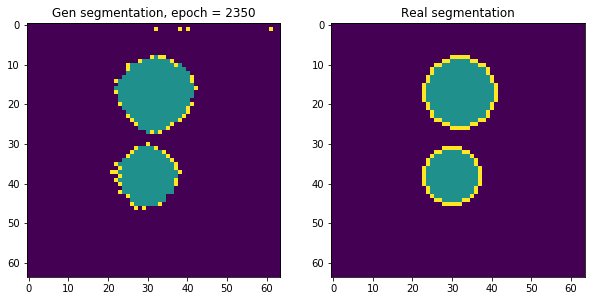

epoch - 2350, loss - 0.162388056517
epoch - 2351, loss - 0.16054071486
epoch - 2352, loss - 0.152732223272
epoch - 2353, loss - 0.123745709658
epoch - 2354, loss - 0.12287773937
epoch - 2355, loss - 0.140797704458
epoch - 2356, loss - 0.145227402449
epoch - 2357, loss - 0.136059224606
epoch - 2358, loss - 0.121643073857
epoch - 2359, loss - 0.123235985637
epoch - 2360, loss - 0.141106888652
epoch - 2361, loss - 0.149425655603
epoch - 2362, loss - 0.151741266251
epoch - 2363, loss - 0.160250157118
epoch - 2364, loss - 0.188098043203
epoch - 2365, loss - 0.203181892633
epoch - 2366, loss - 0.208274200559
epoch - 2367, loss - 0.189502760768
epoch - 2368, loss - 0.163974285126
epoch - 2369, loss - 0.137844890356
epoch - 2370, loss - 0.118500165641
epoch - 2371, loss - 0.105507835746
epoch - 2372, loss - 0.111429020762
epoch - 2373, loss - 0.129343658686
epoch - 2374, loss - 0.134782522917
epoch - 2375, loss - 0.128788918257
epoch - 2376, loss - 0.116229563951
epoch - 2377, loss - 0.1080014

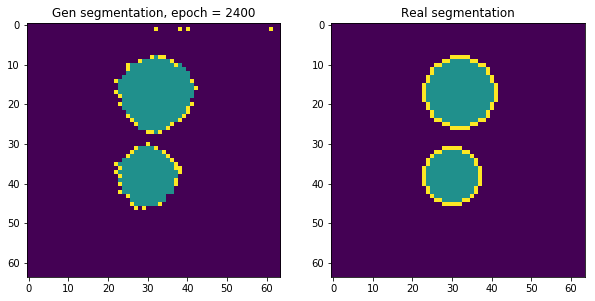

epoch - 2400, loss - 0.168230861425
epoch - 2401, loss - 0.198063328862
epoch - 2402, loss - 0.220749795437
epoch - 2403, loss - 0.231950283051
epoch - 2404, loss - 0.220854014158
epoch - 2405, loss - 0.20775398612
epoch - 2406, loss - 0.224631011486
epoch - 2407, loss - 0.232070013881
epoch - 2408, loss - 0.202055305243
epoch - 2409, loss - 0.16753911972
epoch - 2410, loss - 0.173777967691
epoch - 2411, loss - 0.170989781618
epoch - 2412, loss - 0.147281244397
epoch - 2413, loss - 0.139070287347
epoch - 2414, loss - 0.148142814636
epoch - 2415, loss - 0.12949848175
epoch - 2416, loss - 0.115177348256
epoch - 2417, loss - 0.128712505102
epoch - 2418, loss - 0.124285884202
epoch - 2419, loss - 0.112434834242
epoch - 2420, loss - 0.113363489509
epoch - 2421, loss - 0.110303416848
epoch - 2422, loss - 0.104186914861
epoch - 2423, loss - 0.103038787842
epoch - 2424, loss - 0.10556396842
epoch - 2425, loss - 0.100984483957
epoch - 2426, loss - 0.0979644283652
epoch - 2427, loss - 0.09983429

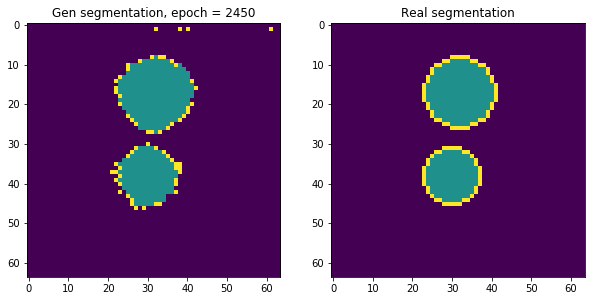

epoch - 2450, loss - 0.259046584368
epoch - 2451, loss - 0.257765233517
epoch - 2452, loss - 0.20281329751
epoch - 2453, loss - 0.15457251668
epoch - 2454, loss - 0.130634889007
epoch - 2455, loss - 0.183094188571
epoch - 2456, loss - 0.216939657927
epoch - 2457, loss - 0.147106319666
epoch - 2458, loss - 0.103473320603
epoch - 2459, loss - 0.131977632642
epoch - 2460, loss - 0.148187547922
epoch - 2461, loss - 0.130426287651
epoch - 2462, loss - 0.114127926528
epoch - 2463, loss - 0.119760781527
epoch - 2464, loss - 0.118126399815
epoch - 2465, loss - 0.107679635286
epoch - 2466, loss - 0.106727808714
epoch - 2467, loss - 0.11103207618
epoch - 2468, loss - 0.108893573284
epoch - 2469, loss - 0.100983411074
epoch - 2470, loss - 0.0941595211625
epoch - 2471, loss - 0.0973013862967
epoch - 2472, loss - 0.101993530989
epoch - 2473, loss - 0.097711250186
epoch - 2474, loss - 0.0923257023096
epoch - 2475, loss - 0.0921711623669
epoch - 2476, loss - 0.0925424396992
epoch - 2477, loss - 0.090

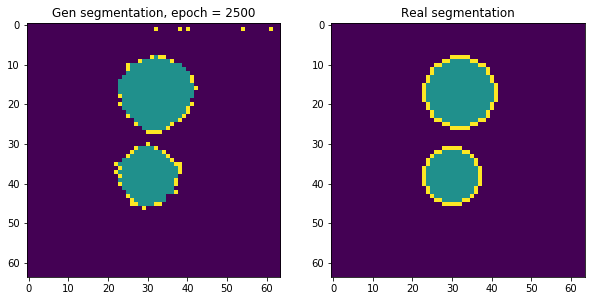

epoch - 2500, loss - 0.204516664147
epoch - 2501, loss - 0.187477812171
epoch - 2502, loss - 0.19571852684
epoch - 2503, loss - 0.192671626806
epoch - 2504, loss - 0.176442146301
epoch - 2505, loss - 0.134109035134
epoch - 2506, loss - 0.127246931195
epoch - 2507, loss - 0.149780839682
epoch - 2508, loss - 0.128162428737
epoch - 2509, loss - 0.107176974416
epoch - 2510, loss - 0.120083734393
epoch - 2511, loss - 0.123918816447
epoch - 2512, loss - 0.108561143279
epoch - 2513, loss - 0.104188084602
epoch - 2514, loss - 0.104575738311
epoch - 2515, loss - 0.0982656478882
epoch - 2516, loss - 0.0969889611006
epoch - 2517, loss - 0.0979054868221
epoch - 2518, loss - 0.0951837971807
epoch - 2519, loss - 0.0950417593122
epoch - 2520, loss - 0.0927741378546
epoch - 2521, loss - 0.0903659015894
epoch - 2522, loss - 0.0922465324402
epoch - 2523, loss - 0.0908544361591
epoch - 2524, loss - 0.0876468867064
epoch - 2525, loss - 0.0882220119238
epoch - 2526, loss - 0.0888933092356
epoch - 2527, los

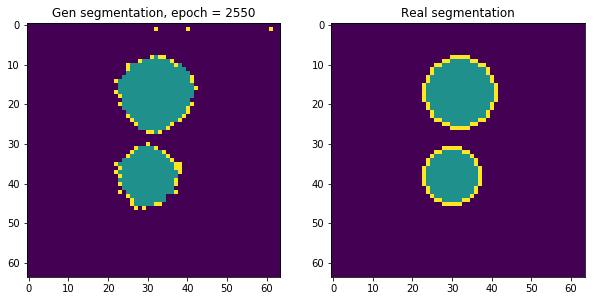

epoch - 2550, loss - 0.109040766954
epoch - 2551, loss - 0.0977096706629
epoch - 2552, loss - 0.102660953999
epoch - 2553, loss - 0.109754316509
epoch - 2554, loss - 0.10168159008
epoch - 2555, loss - 0.0893785953522
epoch - 2556, loss - 0.0902717858553
epoch - 2557, loss - 0.0967687815428
epoch - 2558, loss - 0.0954062640667
epoch - 2559, loss - 0.0876052975655
epoch - 2560, loss - 0.0851420983672
epoch - 2561, loss - 0.0896126329899
epoch - 2562, loss - 0.0912280008197
epoch - 2563, loss - 0.0873881205916
epoch - 2564, loss - 0.0834204554558
epoch - 2565, loss - 0.0847401991487
epoch - 2566, loss - 0.0871091037989
epoch - 2567, loss - 0.0874202400446
epoch - 2568, loss - 0.0872484594584
epoch - 2569, loss - 0.0895030498505
epoch - 2570, loss - 0.0916108191013
epoch - 2571, loss - 0.0961114093661
epoch - 2572, loss - 0.103472486138
epoch - 2573, loss - 0.115546666086
epoch - 2574, loss - 0.122699595988
epoch - 2575, loss - 0.137657105923
epoch - 2576, loss - 0.148781165481
epoch - 257

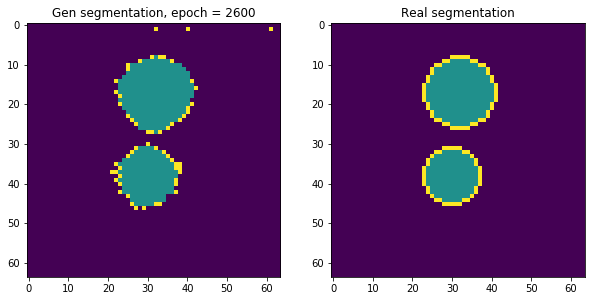

epoch - 2600, loss - 0.0883450061083
epoch - 2601, loss - 0.086305975914
epoch - 2602, loss - 0.0851989537477
epoch - 2603, loss - 0.0873820632696
epoch - 2604, loss - 0.0886477977037
epoch - 2605, loss - 0.085457354784
epoch - 2606, loss - 0.0849773734808
epoch - 2607, loss - 0.0872457176447
epoch - 2608, loss - 0.0868349894881
epoch - 2609, loss - 0.0839731991291
epoch - 2610, loss - 0.0851697400212
epoch - 2611, loss - 0.0864418596029
epoch - 2612, loss - 0.0858312323689
epoch - 2613, loss - 0.0842261910439
epoch - 2614, loss - 0.0870621278882
epoch - 2615, loss - 0.0902736783028
epoch - 2616, loss - 0.0941328853369
epoch - 2617, loss - 0.0978370755911
epoch - 2618, loss - 0.107958346605
epoch - 2619, loss - 0.120769418776
epoch - 2620, loss - 0.15147434175
epoch - 2621, loss - 0.182657852769
epoch - 2622, loss - 0.252602338791
epoch - 2623, loss - 0.307059675455
epoch - 2624, loss - 0.366991996765
epoch - 2625, loss - 0.391631156206
epoch - 2626, loss - 0.231675803661
epoch - 2627,

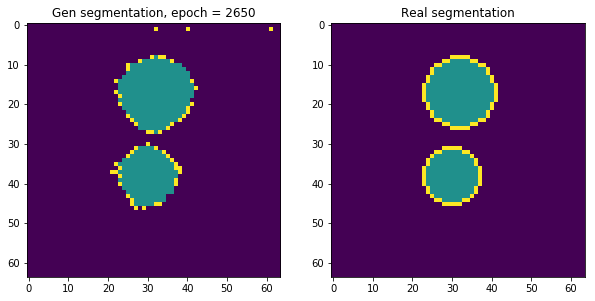

epoch - 2650, loss - 0.0889936536551
epoch - 2651, loss - 0.0907673090696
epoch - 2652, loss - 0.0878941044211
epoch - 2653, loss - 0.086104542017
epoch - 2654, loss - 0.086381688714
epoch - 2655, loss - 0.0844881981611
epoch - 2656, loss - 0.0838795751333
epoch - 2657, loss - 0.0823617875576
epoch - 2658, loss - 0.0810414850712
epoch - 2659, loss - 0.0806351974607
epoch - 2660, loss - 0.0798384845257
epoch - 2661, loss - 0.0794058963656
epoch - 2662, loss - 0.0785839259624
epoch - 2663, loss - 0.0776902660728
epoch - 2664, loss - 0.0774141252041
epoch - 2665, loss - 0.0766745507717
epoch - 2666, loss - 0.0765964835882
epoch - 2667, loss - 0.0765576735139
epoch - 2668, loss - 0.0758970826864
epoch - 2669, loss - 0.0760194882751
epoch - 2670, loss - 0.0765810459852
epoch - 2671, loss - 0.0772289633751
epoch - 2672, loss - 0.0805910676718
epoch - 2673, loss - 0.0865676775575
epoch - 2674, loss - 0.0993866175413
epoch - 2675, loss - 0.119400158525
epoch - 2676, loss - 0.154072955251
epoch

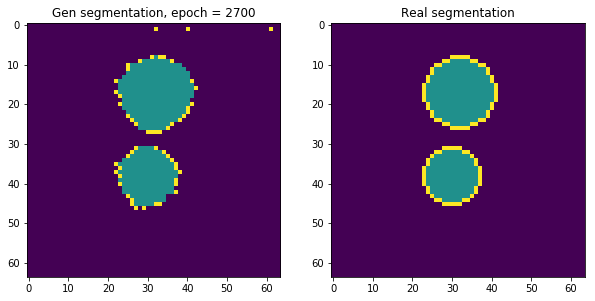

epoch - 2700, loss - 0.0863854289055
epoch - 2701, loss - 0.088087901473
epoch - 2702, loss - 0.0864096581936
epoch - 2703, loss - 0.0856149792671
epoch - 2704, loss - 0.0841486304998
epoch - 2705, loss - 0.0804796814919
epoch - 2706, loss - 0.0794169306755
epoch - 2707, loss - 0.0798038393259
epoch - 2708, loss - 0.0792827904224
epoch - 2709, loss - 0.0785858482122
epoch - 2710, loss - 0.0776849091053
epoch - 2711, loss - 0.0774361118674
epoch - 2712, loss - 0.0778088718653
epoch - 2713, loss - 0.0772835314274
epoch - 2714, loss - 0.0764727368951
epoch - 2715, loss - 0.076700180769
epoch - 2716, loss - 0.077901661396
epoch - 2717, loss - 0.0784239545465
epoch - 2718, loss - 0.0804400295019
epoch - 2719, loss - 0.0851827412844
epoch - 2720, loss - 0.0950937047601
epoch - 2721, loss - 0.104425758123
epoch - 2722, loss - 0.114646233618
epoch - 2723, loss - 0.113317973912
epoch - 2724, loss - 0.108791336417
epoch - 2725, loss - 0.0921421349049
epoch - 2726, loss - 0.0842710137367
epoch - 

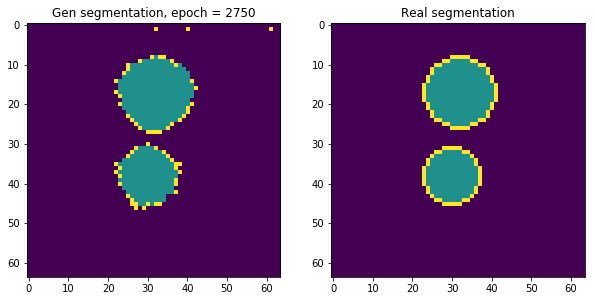

epoch - 2750, loss - 0.110666722059
epoch - 2751, loss - 0.120713062584
epoch - 2752, loss - 0.108666986227
epoch - 2753, loss - 0.0975842550397
epoch - 2754, loss - 0.0953070223331
epoch - 2755, loss - 0.101125709713
epoch - 2756, loss - 0.104196317494
epoch - 2757, loss - 0.089383482933
epoch - 2758, loss - 0.08306350559
epoch - 2759, loss - 0.0895369648933
epoch - 2760, loss - 0.0878527835011
epoch - 2761, loss - 0.0818585753441
epoch - 2762, loss - 0.0828049629927
epoch - 2763, loss - 0.0843476355076
epoch - 2764, loss - 0.0810102820396
epoch - 2765, loss - 0.0783544480801
epoch - 2766, loss - 0.0785765647888
epoch - 2767, loss - 0.078627474606
epoch - 2768, loss - 0.0765260905027
epoch - 2769, loss - 0.0749758034945
epoch - 2770, loss - 0.0737356320024
epoch - 2771, loss - 0.0747446864843
epoch - 2772, loss - 0.0760757029057
epoch - 2773, loss - 0.0760872364044
epoch - 2774, loss - 0.0770203098655
epoch - 2775, loss - 0.0810849070549
epoch - 2776, loss - 0.0852912515402
epoch - 27

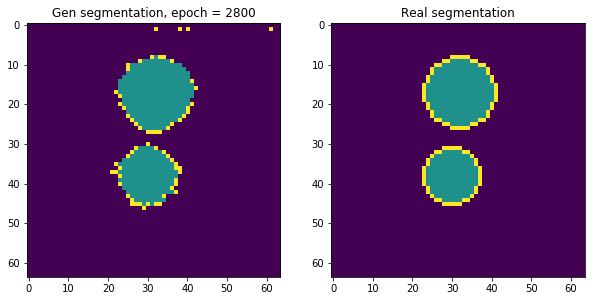

epoch - 2800, loss - 0.158505469561
epoch - 2801, loss - 0.120518609881
epoch - 2802, loss - 0.112094186246
epoch - 2803, loss - 0.131603598595
epoch - 2804, loss - 0.117595173419
epoch - 2805, loss - 0.102279640734
epoch - 2806, loss - 0.109523035586
epoch - 2807, loss - 0.103793017566
epoch - 2808, loss - 0.0904285982251
epoch - 2809, loss - 0.0980470776558
epoch - 2810, loss - 0.0990839749575
epoch - 2811, loss - 0.0882684737444
epoch - 2812, loss - 0.0866543650627
epoch - 2813, loss - 0.087420232594
epoch - 2814, loss - 0.0860417932272
epoch - 2815, loss - 0.0822507739067
epoch - 2816, loss - 0.0805656164885
epoch - 2817, loss - 0.0835015028715
epoch - 2818, loss - 0.0792587324977
epoch - 2819, loss - 0.0761310309172
epoch - 2820, loss - 0.0776461660862
epoch - 2821, loss - 0.0771446377039
epoch - 2822, loss - 0.07513217628
epoch - 2823, loss - 0.073535323143
epoch - 2824, loss - 0.0733204334974
epoch - 2825, loss - 0.0733763724566
epoch - 2826, loss - 0.0723591968417
epoch - 2827,

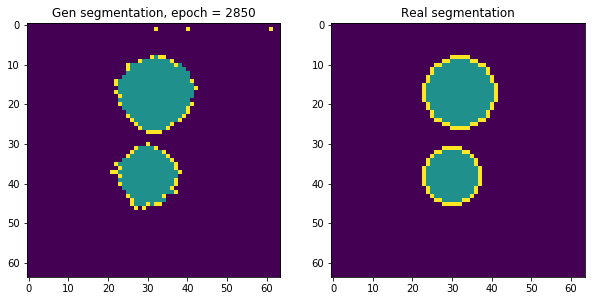

epoch - 2850, loss - 0.116460308433
epoch - 2851, loss - 0.126341804862
epoch - 2852, loss - 0.107024095953
epoch - 2853, loss - 0.0901565700769
epoch - 2854, loss - 0.10100466013
epoch - 2855, loss - 0.10427506268
epoch - 2856, loss - 0.092265099287
epoch - 2857, loss - 0.0829084292054
epoch - 2858, loss - 0.0904130190611
epoch - 2859, loss - 0.093561321497
epoch - 2860, loss - 0.0821492224932
epoch - 2861, loss - 0.0761897712946
epoch - 2862, loss - 0.0826577246189
epoch - 2863, loss - 0.0828102380037
epoch - 2864, loss - 0.0760964155197
epoch - 2865, loss - 0.0747464746237
epoch - 2866, loss - 0.0771003812551
epoch - 2867, loss - 0.0759984403849
epoch - 2868, loss - 0.073085270822
epoch - 2869, loss - 0.0729888379574
epoch - 2870, loss - 0.073136292398
epoch - 2871, loss - 0.0728030279279
epoch - 2872, loss - 0.071861051023
epoch - 2873, loss - 0.0718137174845
epoch - 2874, loss - 0.0726706311107
epoch - 2875, loss - 0.0739646703005
epoch - 2876, loss - 0.0768088251352
epoch - 2877,

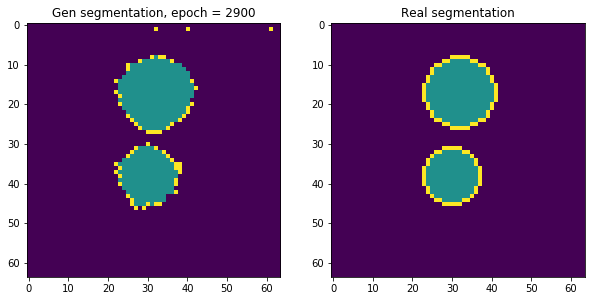

epoch - 2900, loss - 0.0830516964197
epoch - 2901, loss - 0.0806906074286
epoch - 2902, loss - 0.0843926072121
epoch - 2903, loss - 0.0848324075341
epoch - 2904, loss - 0.0795244798064
epoch - 2905, loss - 0.0753052383661
epoch - 2906, loss - 0.0746985822916
epoch - 2907, loss - 0.072862111032
epoch - 2908, loss - 0.0718900635839
epoch - 2909, loss - 0.0738279223442
epoch - 2910, loss - 0.0749048441648
epoch - 2911, loss - 0.0732934325933
epoch - 2912, loss - 0.0708508864045
epoch - 2913, loss - 0.071560755372
epoch - 2914, loss - 0.0721726790071
epoch - 2915, loss - 0.0701805353165
epoch - 2916, loss - 0.0685749799013
epoch - 2917, loss - 0.0698961764574
epoch - 2918, loss - 0.0719029009342
epoch - 2919, loss - 0.074087485671
epoch - 2920, loss - 0.0826001614332
epoch - 2921, loss - 0.0959879979491
epoch - 2922, loss - 0.124323636293
epoch - 2923, loss - 0.140148818493
epoch - 2924, loss - 0.161923751235
epoch - 2925, loss - 0.14056006074
epoch - 2926, loss - 0.12174911797
epoch - 292

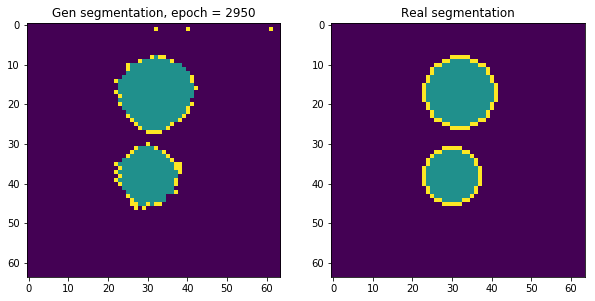

epoch - 2950, loss - 0.0744715332985
epoch - 2951, loss - 0.0713495463133
epoch - 2952, loss - 0.0716541409492
epoch - 2953, loss - 0.0724680796266
epoch - 2954, loss - 0.0709146112204
epoch - 2955, loss - 0.0704616308212
epoch - 2956, loss - 0.0730732083321
epoch - 2957, loss - 0.0751650780439
epoch - 2958, loss - 0.0790548995137
epoch - 2959, loss - 0.0862268060446
epoch - 2960, loss - 0.102490648627
epoch - 2961, loss - 0.123788356781
epoch - 2962, loss - 0.16657346487
epoch - 2963, loss - 0.211948931217
epoch - 2964, loss - 0.282283693552
epoch - 2965, loss - 0.290655583143
epoch - 2966, loss - 0.254556149244
epoch - 2967, loss - 0.155810981989
epoch - 2968, loss - 0.0936816185713
epoch - 2969, loss - 0.110627964139
epoch - 2970, loss - 0.155878216028
epoch - 2971, loss - 0.161030083895
epoch - 2972, loss - 0.12292060256
epoch - 2973, loss - 0.0926597267389
epoch - 2974, loss - 0.0972457379103
epoch - 2975, loss - 0.118541970849
epoch - 2976, loss - 0.117554292083
epoch - 2977, los

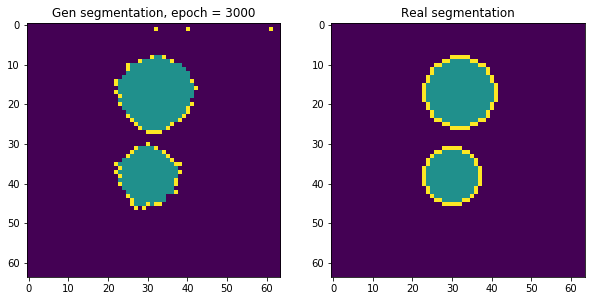

epoch - 3000, loss - 0.0743212103844
epoch - 3001, loss - 0.0728168562055
epoch - 3002, loss - 0.0729518532753
epoch - 3003, loss - 0.0747937858105
epoch - 3004, loss - 0.0766904726624
epoch - 3005, loss - 0.0771951675415
epoch - 3006, loss - 0.0787786990404
epoch - 3007, loss - 0.0795125365257
epoch - 3008, loss - 0.078581161797
epoch - 3009, loss - 0.0776985883713
epoch - 3010, loss - 0.0767612680793
epoch - 3011, loss - 0.0773653388023
epoch - 3012, loss - 0.0737929344177
epoch - 3013, loss - 0.0727093070745
epoch - 3014, loss - 0.0726079121232
epoch - 3015, loss - 0.0743251293898
epoch - 3016, loss - 0.0807303115726
epoch - 3017, loss - 0.089564666152
epoch - 3018, loss - 0.0987964421511
epoch - 3019, loss - 0.109687939286
epoch - 3020, loss - 0.115517944098
epoch - 3021, loss - 0.125459909439
epoch - 3022, loss - 0.133104562759
epoch - 3023, loss - 0.143614649773
epoch - 3024, loss - 0.141615942121
epoch - 3025, loss - 0.124770283699
epoch - 3026, loss - 0.103092208505
epoch - 302

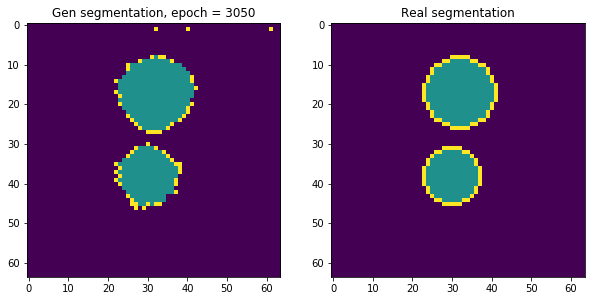

epoch - 3050, loss - 0.0673118233681
epoch - 3051, loss - 0.0676727741957
epoch - 3052, loss - 0.0668909698725
epoch - 3053, loss - 0.0688954591751
epoch - 3054, loss - 0.0740053504705
epoch - 3055, loss - 0.0784465223551
epoch - 3056, loss - 0.0876401439309
epoch - 3057, loss - 0.100816547871
epoch - 3058, loss - 0.118478268385
epoch - 3059, loss - 0.122094854712
epoch - 3060, loss - 0.132214397192
epoch - 3061, loss - 0.137451916933
epoch - 3062, loss - 0.182726442814
epoch - 3063, loss - 0.265321969986
epoch - 3064, loss - 0.422011613846
epoch - 3065, loss - 0.385139137506
epoch - 3066, loss - 0.26551002264
epoch - 3067, loss - 0.178455024958
epoch - 3068, loss - 0.206300720572
epoch - 3069, loss - 0.211506322026
epoch - 3070, loss - 0.163264706731
epoch - 3071, loss - 0.169495001435
epoch - 3072, loss - 0.159699499607
epoch - 3073, loss - 0.122343979776
epoch - 3074, loss - 0.122253492475
epoch - 3075, loss - 0.138772681355
epoch - 3076, loss - 0.119242757559
epoch - 3077, loss - 0

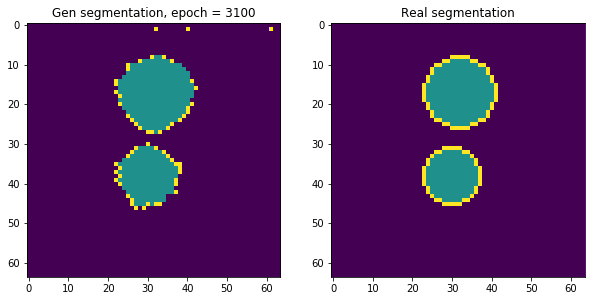

epoch - 3100, loss - 0.0653491988778
epoch - 3101, loss - 0.0647960156202
epoch - 3102, loss - 0.0639387220144
epoch - 3103, loss - 0.0640551149845
epoch - 3104, loss - 0.0627404376864
epoch - 3105, loss - 0.0624146386981
epoch - 3106, loss - 0.062685392797
epoch - 3107, loss - 0.061795912683
epoch - 3108, loss - 0.0629243552685
epoch - 3109, loss - 0.0642661601305
epoch - 3110, loss - 0.0671284794807
epoch - 3111, loss - 0.0723126158118
epoch - 3112, loss - 0.082215256989
epoch - 3113, loss - 0.0909375473857
epoch - 3114, loss - 0.104307442904
epoch - 3115, loss - 0.0999739915133
epoch - 3116, loss - 0.0903426855803
epoch - 3117, loss - 0.0723115131259
epoch - 3118, loss - 0.0702108442783
epoch - 3119, loss - 0.0854715704918
epoch - 3120, loss - 0.0969437211752
epoch - 3121, loss - 0.104175984859
epoch - 3122, loss - 0.0958457589149
epoch - 3123, loss - 0.0979065448046
epoch - 3124, loss - 0.116799384356
epoch - 3125, loss - 0.151470795274
epoch - 3126, loss - 0.178728967905
epoch - 3

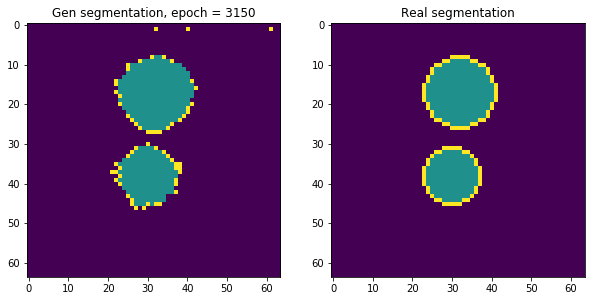

epoch - 3150, loss - 0.0655034705997
epoch - 3151, loss - 0.0665803104639
epoch - 3152, loss - 0.0659189373255
epoch - 3153, loss - 0.0643521696329
epoch - 3154, loss - 0.0638049840927
epoch - 3155, loss - 0.0643409639597
epoch - 3156, loss - 0.0653337538242
epoch - 3157, loss - 0.0657471343875
epoch - 3158, loss - 0.0662142708898
epoch - 3159, loss - 0.0667924135923
epoch - 3160, loss - 0.0696855634451
epoch - 3161, loss - 0.0736921802163
epoch - 3162, loss - 0.0797140151262
epoch - 3163, loss - 0.0841733440757
epoch - 3164, loss - 0.095256768167
epoch - 3165, loss - 0.107302986085
epoch - 3166, loss - 0.126947879791
epoch - 3167, loss - 0.141145512462
epoch - 3168, loss - 0.156134933233
epoch - 3169, loss - 0.155673757195
epoch - 3170, loss - 0.152370512486
epoch - 3171, loss - 0.133464366198
epoch - 3172, loss - 0.114115938544
epoch - 3173, loss - 0.0959593132138
epoch - 3174, loss - 0.0937045142055
epoch - 3175, loss - 0.104298979044
epoch - 3176, loss - 0.115320332348
epoch - 3177

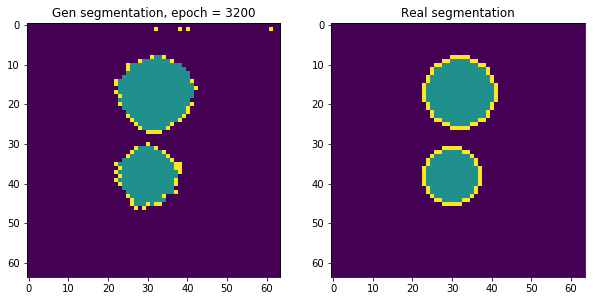

epoch - 3200, loss - 0.0642523020506
epoch - 3201, loss - 0.0668019801378
epoch - 3202, loss - 0.0694675147533
epoch - 3203, loss - 0.0713560581207
epoch - 3204, loss - 0.0781211405993
epoch - 3205, loss - 0.091953933239
epoch - 3206, loss - 0.112359970808
epoch - 3207, loss - 0.143190786242
epoch - 3208, loss - 0.183306634426
epoch - 3209, loss - 0.210392996669
epoch - 3210, loss - 0.264034539461
epoch - 3211, loss - 0.259045362473
epoch - 3212, loss - 0.257078528404
epoch - 3213, loss - 0.202631101012
epoch - 3214, loss - 0.158315360546
epoch - 3215, loss - 0.122841790318
epoch - 3216, loss - 0.14492842555
epoch - 3217, loss - 0.176525756717
epoch - 3218, loss - 0.140263348818
epoch - 3219, loss - 0.0925970524549
epoch - 3220, loss - 0.0962991267443
epoch - 3221, loss - 0.120608910918
epoch - 3222, loss - 0.11064428091
epoch - 3223, loss - 0.0898919999599
epoch - 3224, loss - 0.0919047817588
epoch - 3225, loss - 0.0858779251575
epoch - 3226, loss - 0.0818891972303
epoch - 3227, loss 

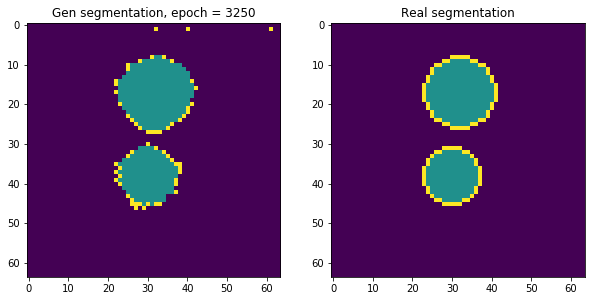

epoch - 3250, loss - 0.0583537220955
epoch - 3251, loss - 0.0600987710059
epoch - 3252, loss - 0.0627100616693
epoch - 3253, loss - 0.0685293674469
epoch - 3254, loss - 0.076123252511
epoch - 3255, loss - 0.0885833129287
epoch - 3256, loss - 0.098222874105
epoch - 3257, loss - 0.109305396676
epoch - 3258, loss - 0.106608435512
epoch - 3259, loss - 0.102101519704
epoch - 3260, loss - 0.10077573359
epoch - 3261, loss - 0.104974158108
epoch - 3262, loss - 0.119962468743
epoch - 3263, loss - 0.126636490226
epoch - 3264, loss - 0.137056648731
epoch - 3265, loss - 0.126897484064
epoch - 3266, loss - 0.123896241188
epoch - 3267, loss - 0.135521382093
epoch - 3268, loss - 0.143936365843
epoch - 3269, loss - 0.133502572775
epoch - 3270, loss - 0.112227298319
epoch - 3271, loss - 0.0973513945937
epoch - 3272, loss - 0.0925363749266
epoch - 3273, loss - 0.0864208638668
epoch - 3274, loss - 0.0794008076191
epoch - 3275, loss - 0.0813961923122
epoch - 3276, loss - 0.0878518372774
epoch - 3277, loss

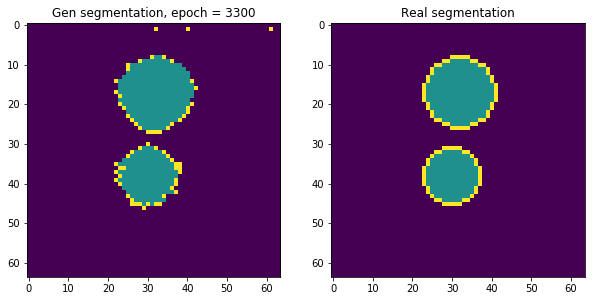

epoch - 3300, loss - 0.175662949681
epoch - 3301, loss - 0.162464946508
epoch - 3302, loss - 0.141164213419
epoch - 3303, loss - 0.114734441042
epoch - 3304, loss - 0.111294858158
epoch - 3305, loss - 0.10895524919
epoch - 3306, loss - 0.107032328844
epoch - 3307, loss - 0.105371028185
epoch - 3308, loss - 0.114179894328
epoch - 3309, loss - 0.113381713629
epoch - 3310, loss - 0.0882775634527
epoch - 3311, loss - 0.07387329638
epoch - 3312, loss - 0.0770120546222
epoch - 3313, loss - 0.0861020535231
epoch - 3314, loss - 0.0890470147133
epoch - 3315, loss - 0.0815973728895
epoch - 3316, loss - 0.072488732636
epoch - 3317, loss - 0.0681107118726
epoch - 3318, loss - 0.0695955455303
epoch - 3319, loss - 0.0704388841987
epoch - 3320, loss - 0.0683096051216
epoch - 3321, loss - 0.0647957548499
epoch - 3322, loss - 0.0639858618379
epoch - 3323, loss - 0.0669640153646
epoch - 3324, loss - 0.0668669044971
epoch - 3325, loss - 0.0635857880116
epoch - 3326, loss - 0.0597634315491
epoch - 3327, l

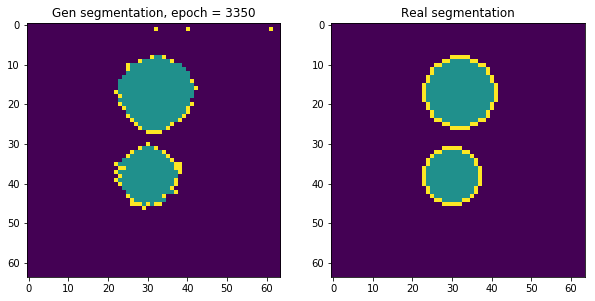

epoch - 3350, loss - 0.165370941162
epoch - 3351, loss - 0.166861906648
epoch - 3352, loss - 0.137799650431
epoch - 3353, loss - 0.135786503553
epoch - 3354, loss - 0.130128160119
epoch - 3355, loss - 0.1108789891
epoch - 3356, loss - 0.0951739624143
epoch - 3357, loss - 0.108979105949
epoch - 3358, loss - 0.101680859923
epoch - 3359, loss - 0.0758227929473
epoch - 3360, loss - 0.0895164757967
epoch - 3361, loss - 0.0941319316626
epoch - 3362, loss - 0.0753784179688
epoch - 3363, loss - 0.0799539759755
epoch - 3364, loss - 0.0778265297413
epoch - 3365, loss - 0.0680810511112
epoch - 3366, loss - 0.0713551566005
epoch - 3367, loss - 0.0708907097578
epoch - 3368, loss - 0.066802598536
epoch - 3369, loss - 0.0672010481358
epoch - 3370, loss - 0.0655318275094
epoch - 3371, loss - 0.0632090345025
epoch - 3372, loss - 0.0622030831873
epoch - 3373, loss - 0.0613500326872
epoch - 3374, loss - 0.0597458966076
epoch - 3375, loss - 0.0585499107838
epoch - 3376, loss - 0.0584209635854
epoch - 3377

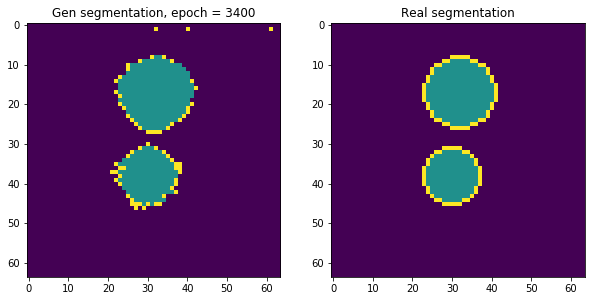

epoch - 3400, loss - 0.139918029308
epoch - 3401, loss - 0.14807023108
epoch - 3402, loss - 0.0966778844595
epoch - 3403, loss - 0.0767149999738
epoch - 3404, loss - 0.102017469704
epoch - 3405, loss - 0.102929644287
epoch - 3406, loss - 0.0862149298191
epoch - 3407, loss - 0.0792983025312
epoch - 3408, loss - 0.0839795917273
epoch - 3409, loss - 0.0787907168269
epoch - 3410, loss - 0.0690434873104
epoch - 3411, loss - 0.0738343298435
epoch - 3412, loss - 0.0785690248013
epoch - 3413, loss - 0.071050979197
epoch - 3414, loss - 0.0647971406579
epoch - 3415, loss - 0.0634704381227
epoch - 3416, loss - 0.0645932406187
epoch - 3417, loss - 0.0653041452169
epoch - 3418, loss - 0.0627393946052
epoch - 3419, loss - 0.0610364601016
epoch - 3420, loss - 0.0615021586418
epoch - 3421, loss - 0.0598463565111
epoch - 3422, loss - 0.057989500463
epoch - 3423, loss - 0.0561263523996
epoch - 3424, loss - 0.0554585941136
epoch - 3425, loss - 0.0565966106951
epoch - 3426, loss - 0.0564895309508
epoch - 

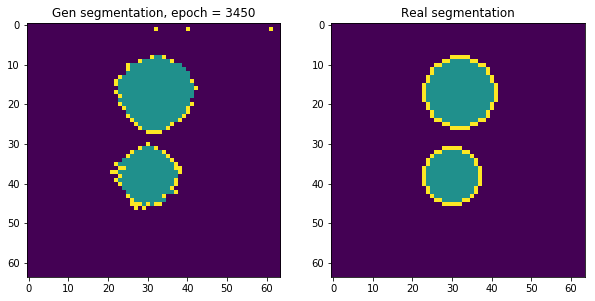

epoch - 3450, loss - 0.0976000800729
epoch - 3451, loss - 0.096572726965
epoch - 3452, loss - 0.0815432593226
epoch - 3453, loss - 0.0765133947134
epoch - 3454, loss - 0.0839037895203
epoch - 3455, loss - 0.0821561664343
epoch - 3456, loss - 0.0773816332221
epoch - 3457, loss - 0.0704520791769
epoch - 3458, loss - 0.0722353234887
epoch - 3459, loss - 0.0765188112855
epoch - 3460, loss - 0.0688895732164
epoch - 3461, loss - 0.0629371777177
epoch - 3462, loss - 0.0664981752634
epoch - 3463, loss - 0.0703264996409
epoch - 3464, loss - 0.0692600607872
epoch - 3465, loss - 0.0644632577896
epoch - 3466, loss - 0.0671774595976
epoch - 3467, loss - 0.0716352313757
epoch - 3468, loss - 0.072559773922
epoch - 3469, loss - 0.0744287595153
epoch - 3470, loss - 0.0822619721293
epoch - 3471, loss - 0.087304726243
epoch - 3472, loss - 0.0975478813052
epoch - 3473, loss - 0.106322467327
epoch - 3474, loss - 0.121609136462
epoch - 3475, loss - 0.12986086309
epoch - 3476, loss - 0.137316599488
epoch - 3

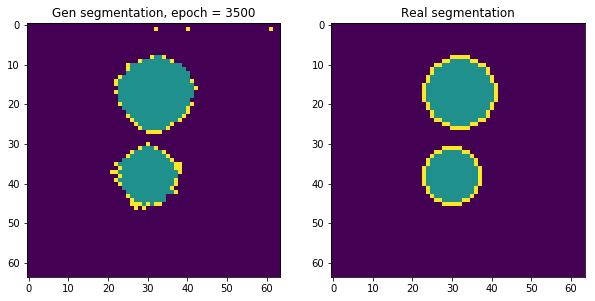

epoch - 3500, loss - 0.0648042932153
epoch - 3501, loss - 0.0652092024684
epoch - 3502, loss - 0.0616920366883
epoch - 3503, loss - 0.0581035092473
epoch - 3504, loss - 0.0595694445074
epoch - 3505, loss - 0.0647587776184
epoch - 3506, loss - 0.0643370822072
epoch - 3507, loss - 0.0627957135439
epoch - 3508, loss - 0.0599310845137
epoch - 3509, loss - 0.0638110488653
epoch - 3510, loss - 0.0700813233852
epoch - 3511, loss - 0.0743697956204
epoch - 3512, loss - 0.0732550472021
epoch - 3513, loss - 0.0749906674027
epoch - 3514, loss - 0.0762650519609
epoch - 3515, loss - 0.0794357359409
epoch - 3516, loss - 0.0825775191188
epoch - 3517, loss - 0.0982760936022
epoch - 3518, loss - 0.14141690731
epoch - 3519, loss - 0.190957635641
epoch - 3520, loss - 0.289210617542
epoch - 3521, loss - 0.289591014385
epoch - 3522, loss - 0.260973840952
epoch - 3523, loss - 0.201401591301
epoch - 3524, loss - 0.165161982179
epoch - 3525, loss - 0.169573515654
epoch - 3526, loss - 0.156382679939
epoch - 352

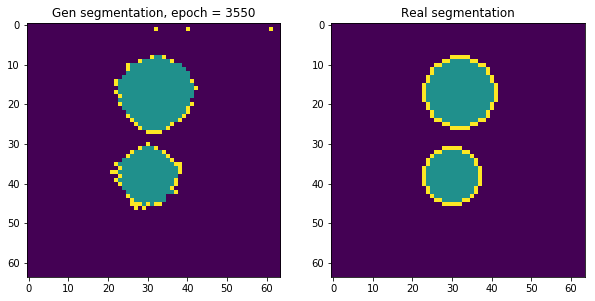

epoch - 3550, loss - 0.0559246093035
epoch - 3551, loss - 0.0561377927661
epoch - 3552, loss - 0.055562518537
epoch - 3553, loss - 0.0539718344808
epoch - 3554, loss - 0.0543138831854
epoch - 3555, loss - 0.0538610219955
epoch - 3556, loss - 0.053001537919
epoch - 3557, loss - 0.0534731000662
epoch - 3558, loss - 0.0539320781827
epoch - 3559, loss - 0.0545575581491
epoch - 3560, loss - 0.0571243241429
epoch - 3561, loss - 0.0602922216058
epoch - 3562, loss - 0.0654257163405
epoch - 3563, loss - 0.0705659836531
epoch - 3564, loss - 0.0757085680962
epoch - 3565, loss - 0.0744995102286
epoch - 3566, loss - 0.0690460801125
epoch - 3567, loss - 0.0587725378573
epoch - 3568, loss - 0.0511059612036
epoch - 3569, loss - 0.0519646145403
epoch - 3570, loss - 0.0586256235838
epoch - 3571, loss - 0.0657003521919
epoch - 3572, loss - 0.0686359554529
epoch - 3573, loss - 0.0686360448599
epoch - 3574, loss - 0.0626190304756
epoch - 3575, loss - 0.0561327636242
epoch - 3576, loss - 0.0559661015868
epo

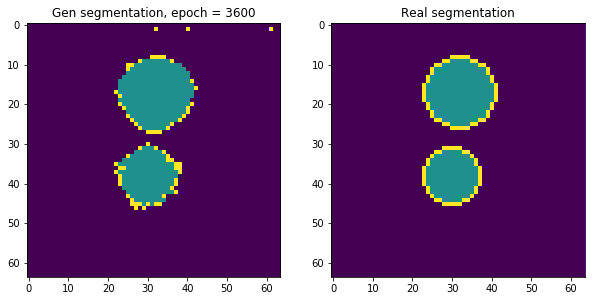

epoch - 3600, loss - 0.09759311378
epoch - 3601, loss - 0.0842520669103
epoch - 3602, loss - 0.0878804773092
epoch - 3603, loss - 0.0779740586877
epoch - 3604, loss - 0.0720273330808
epoch - 3605, loss - 0.0803332254291
epoch - 3606, loss - 0.0741922780871
epoch - 3607, loss - 0.0646350383759
epoch - 3608, loss - 0.0671125501394
epoch - 3609, loss - 0.0666710212827
epoch - 3610, loss - 0.0646073520184
epoch - 3611, loss - 0.0628166496754
epoch - 3612, loss - 0.0600232370198
epoch - 3613, loss - 0.0585886910558
epoch - 3614, loss - 0.0588018409908
epoch - 3615, loss - 0.0585676804185
epoch - 3616, loss - 0.0573491714895
epoch - 3617, loss - 0.0549263358116
epoch - 3618, loss - 0.0534820258617
epoch - 3619, loss - 0.0538238584995
epoch - 3620, loss - 0.0540607795119
epoch - 3621, loss - 0.0530298948288
epoch - 3622, loss - 0.0522566698492
epoch - 3623, loss - 0.0514969006181
epoch - 3624, loss - 0.0505260750651
epoch - 3625, loss - 0.0502470433712
epoch - 3626, loss - 0.0500882454216
epo

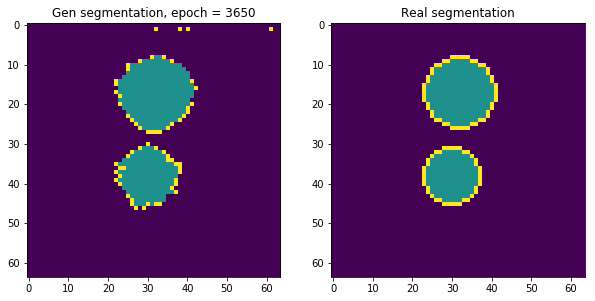

epoch - 3650, loss - 0.0673816800117
epoch - 3651, loss - 0.0624127388
epoch - 3652, loss - 0.0718789845705
epoch - 3653, loss - 0.0855632871389
epoch - 3654, loss - 0.0886738970876
epoch - 3655, loss - 0.0830475986004
epoch - 3656, loss - 0.0846821591258
epoch - 3657, loss - 0.0954138711095
epoch - 3658, loss - 0.0998114347458
epoch - 3659, loss - 0.0934051573277
epoch - 3660, loss - 0.0947584062815
epoch - 3661, loss - 0.10463296622
epoch - 3662, loss - 0.112338863313
epoch - 3663, loss - 0.0982331335545
epoch - 3664, loss - 0.0870433151722
epoch - 3665, loss - 0.0786071270704
epoch - 3666, loss - 0.0654291063547
epoch - 3667, loss - 0.0580256134272
epoch - 3668, loss - 0.0647825449705
epoch - 3669, loss - 0.0704341903329
epoch - 3670, loss - 0.0671541392803
epoch - 3671, loss - 0.0650723129511
epoch - 3672, loss - 0.0651542618871
epoch - 3673, loss - 0.0652710795403
epoch - 3674, loss - 0.0626791790128
epoch - 3675, loss - 0.0652654841542
epoch - 3676, loss - 0.0664820075035
epoch -

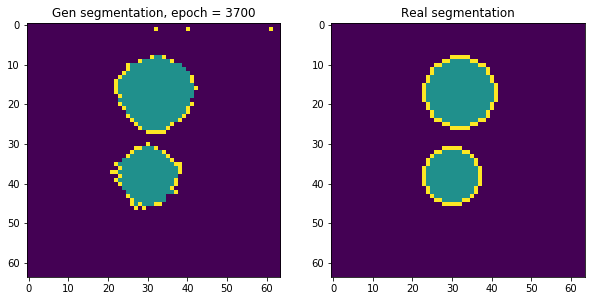

epoch - 3700, loss - 0.250373214483
epoch - 3701, loss - 0.246618270874
epoch - 3702, loss - 0.215805351734
epoch - 3703, loss - 0.142190843821
epoch - 3704, loss - 0.127613216639
epoch - 3705, loss - 0.160651341081
epoch - 3706, loss - 0.161489933729
epoch - 3707, loss - 0.124730750918
epoch - 3708, loss - 0.10659404099
epoch - 3709, loss - 0.0955031216145
epoch - 3710, loss - 0.0972527116537
epoch - 3711, loss - 0.10965397954
epoch - 3712, loss - 0.0945499539375
epoch - 3713, loss - 0.0752438008785
epoch - 3714, loss - 0.0749293416739
epoch - 3715, loss - 0.0811141580343
epoch - 3716, loss - 0.0801945999265
epoch - 3717, loss - 0.0715198367834
epoch - 3718, loss - 0.0674948841333
epoch - 3719, loss - 0.0657594799995
epoch - 3720, loss - 0.0644981563091
epoch - 3721, loss - 0.0648792386055
epoch - 3722, loss - 0.0619558244944
epoch - 3723, loss - 0.0603892058134
epoch - 3724, loss - 0.0575896650553
epoch - 3725, loss - 0.0560864396393
epoch - 3726, loss - 0.0566312596202
epoch - 3727,

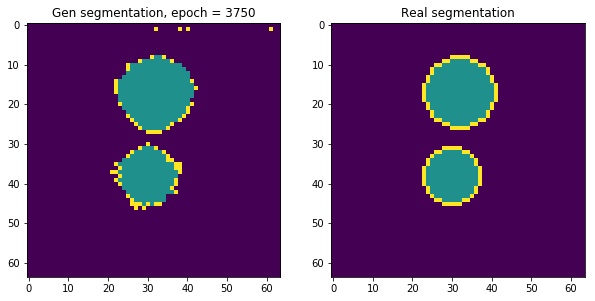

epoch - 3750, loss - 0.0813600048423
epoch - 3751, loss - 0.0998307466507
epoch - 3752, loss - 0.128852337599
epoch - 3753, loss - 0.13017231226
epoch - 3754, loss - 0.115394696593
epoch - 3755, loss - 0.0888404399157
epoch - 3756, loss - 0.0901084840298
epoch - 3757, loss - 0.100321665406
epoch - 3758, loss - 0.0900977477431
epoch - 3759, loss - 0.065992757678
epoch - 3760, loss - 0.0582327581942
epoch - 3761, loss - 0.0736080557108
epoch - 3762, loss - 0.0766358450055
epoch - 3763, loss - 0.0650868341327
epoch - 3764, loss - 0.0617742612958
epoch - 3765, loss - 0.0672182589769
epoch - 3766, loss - 0.0642429664731
epoch - 3767, loss - 0.0573670789599
epoch - 3768, loss - 0.0547127649188
epoch - 3769, loss - 0.0570774897933
epoch - 3770, loss - 0.0565627478063
epoch - 3771, loss - 0.0525619648397
epoch - 3772, loss - 0.053819000721
epoch - 3773, loss - 0.0562496595085
epoch - 3774, loss - 0.0556141994894
epoch - 3775, loss - 0.0547602474689
epoch - 3776, loss - 0.0560994446278
epoch - 

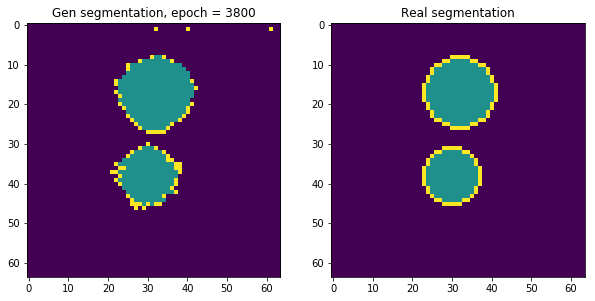

epoch - 3800, loss - 0.0952639430761
epoch - 3801, loss - 0.10250107199
epoch - 3802, loss - 0.0780239105225
epoch - 3803, loss - 0.0668852105737
epoch - 3804, loss - 0.0745892375708
epoch - 3805, loss - 0.0734888240695
epoch - 3806, loss - 0.0716815441847
epoch - 3807, loss - 0.0718471109867
epoch - 3808, loss - 0.0645435452461
epoch - 3809, loss - 0.0561797842383
epoch - 3810, loss - 0.0581553727388
epoch - 3811, loss - 0.0625438392162
epoch - 3812, loss - 0.0590776689351
epoch - 3813, loss - 0.0569166876376
epoch - 3814, loss - 0.0551458597183
epoch - 3815, loss - 0.0512304380536
epoch - 3816, loss - 0.0491679385304
epoch - 3817, loss - 0.0520848408341
epoch - 3818, loss - 0.0536202043295
epoch - 3819, loss - 0.0504471585155
epoch - 3820, loss - 0.04869498685
epoch - 3821, loss - 0.0488458313048
epoch - 3822, loss - 0.0478605851531
epoch - 3823, loss - 0.0478808283806
epoch - 3824, loss - 0.0493022724986
epoch - 3825, loss - 0.052637450397
epoch - 3826, loss - 0.0560352057219
epoch 

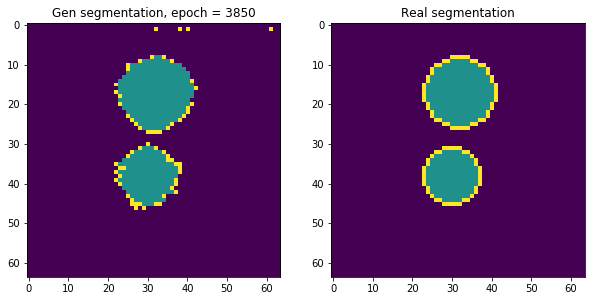

epoch - 3850, loss - 0.0496928207576
epoch - 3851, loss - 0.0517811737955
epoch - 3852, loss - 0.0540401749313
epoch - 3853, loss - 0.0548278838396
epoch - 3854, loss - 0.0526570565999
epoch - 3855, loss - 0.0539800338447
epoch - 3856, loss - 0.061239913106
epoch - 3857, loss - 0.0728224217892
epoch - 3858, loss - 0.0876862406731
epoch - 3859, loss - 0.106127634645
epoch - 3860, loss - 0.131500586867
epoch - 3861, loss - 0.175005435944
epoch - 3862, loss - 0.186685860157
epoch - 3863, loss - 0.185094341636
epoch - 3864, loss - 0.135740727186
epoch - 3865, loss - 0.109219521284
epoch - 3866, loss - 0.117079243064
epoch - 3867, loss - 0.134028241038
epoch - 3868, loss - 0.108872003853
epoch - 3869, loss - 0.0867638140917
epoch - 3870, loss - 0.0908508896828
epoch - 3871, loss - 0.101014688611
epoch - 3872, loss - 0.0906990915537
epoch - 3873, loss - 0.0676354542375
epoch - 3874, loss - 0.0679437071085
epoch - 3875, loss - 0.0746155008674
epoch - 3876, loss - 0.0672720223665
epoch - 3877,

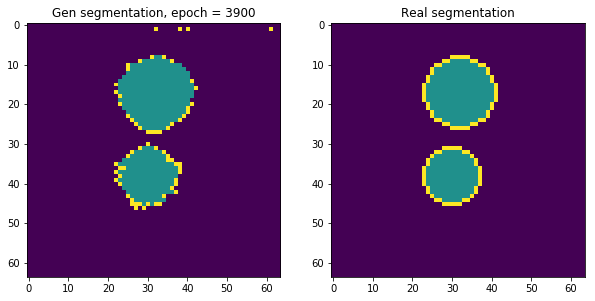

epoch - 3900, loss - 0.0464845597744
epoch - 3901, loss - 0.0495257079601
epoch - 3902, loss - 0.0522663965821
epoch - 3903, loss - 0.0588126890361
epoch - 3904, loss - 0.0652302131057
epoch - 3905, loss - 0.0731173083186
epoch - 3906, loss - 0.0749039426446
epoch - 3907, loss - 0.0764622837305
epoch - 3908, loss - 0.070697888732
epoch - 3909, loss - 0.070023059845
epoch - 3910, loss - 0.0881882160902
epoch - 3911, loss - 0.11933414638
epoch - 3912, loss - 0.166459977627
epoch - 3913, loss - 0.18727697432
epoch - 3914, loss - 0.198405534029
epoch - 3915, loss - 0.197959974408
epoch - 3916, loss - 0.23578850925
epoch - 3917, loss - 0.242969483137
epoch - 3918, loss - 0.174903810024
epoch - 3919, loss - 0.101948291063
epoch - 3920, loss - 0.107278451324
epoch - 3921, loss - 0.131843283772
epoch - 3922, loss - 0.117661684752
epoch - 3923, loss - 0.104247227311
epoch - 3924, loss - 0.096127294004
epoch - 3925, loss - 0.0841325893998
epoch - 3926, loss - 0.0744482576847
epoch - 3927, loss -

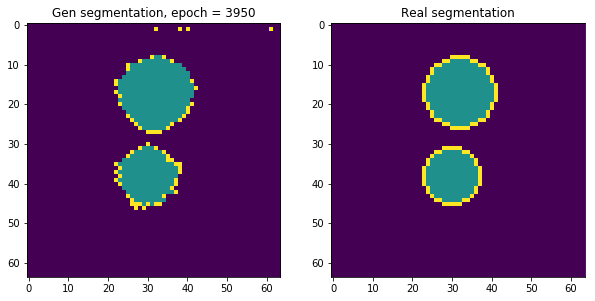

epoch - 3950, loss - 0.0439474210143
epoch - 3951, loss - 0.0444369614124
epoch - 3952, loss - 0.0446218326688
epoch - 3953, loss - 0.0438385009766
epoch - 3954, loss - 0.0440037362278
epoch - 3955, loss - 0.0444691516459
epoch - 3956, loss - 0.0444319695234
epoch - 3957, loss - 0.04506418854
epoch - 3958, loss - 0.0452360361814
epoch - 3959, loss - 0.0468360930681
epoch - 3960, loss - 0.0478459820151
epoch - 3961, loss - 0.0495630651712
epoch - 3962, loss - 0.0515257194638
epoch - 3963, loss - 0.0550570115447
epoch - 3964, loss - 0.0593444667757
epoch - 3965, loss - 0.0690625011921
epoch - 3966, loss - 0.0843340903521
epoch - 3967, loss - 0.113595224917
epoch - 3968, loss - 0.160580933094
epoch - 3969, loss - 0.218941748142
epoch - 3970, loss - 0.269898563623
epoch - 3971, loss - 0.245048284531
epoch - 3972, loss - 0.170811578631
epoch - 3973, loss - 0.146918073297
epoch - 3974, loss - 0.141422182322
epoch - 3975, loss - 0.129911780357
epoch - 3976, loss - 0.104657687247
epoch - 3977,

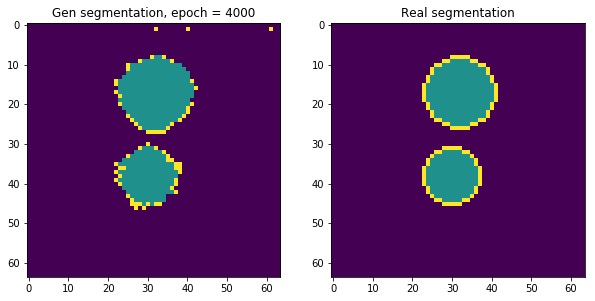

epoch - 4000, loss - 0.0469255596399
epoch - 4001, loss - 0.0474791675806
epoch - 4002, loss - 0.0480666011572
epoch - 4003, loss - 0.0453075021505
epoch - 4004, loss - 0.0451605059206
epoch - 4005, loss - 0.0456856004894
epoch - 4006, loss - 0.0437588319182
epoch - 4007, loss - 0.0436821877956
epoch - 4008, loss - 0.0442290976644
epoch - 4009, loss - 0.043298996985
epoch - 4010, loss - 0.043880417943
epoch - 4011, loss - 0.0455304682255
epoch - 4012, loss - 0.0466658771038
epoch - 4013, loss - 0.050727263093
epoch - 4014, loss - 0.0559652596712
epoch - 4015, loss - 0.0661356896162
epoch - 4016, loss - 0.0777117162943
epoch - 4017, loss - 0.099426060915
epoch - 4018, loss - 0.122296482325
epoch - 4019, loss - 0.159430667758
epoch - 4020, loss - 0.180298954248
epoch - 4021, loss - 0.202675700188
epoch - 4022, loss - 0.175769165158
epoch - 4023, loss - 0.122240722179
epoch - 4024, loss - 0.072481662035
epoch - 4025, loss - 0.0610660240054
epoch - 4026, loss - 0.0901796445251
epoch - 4027

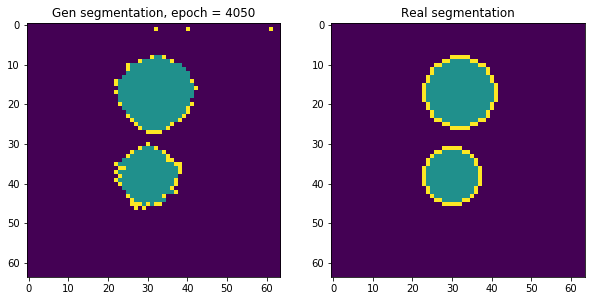

epoch - 4050, loss - 0.0465676523745
epoch - 4051, loss - 0.0474702268839
epoch - 4052, loss - 0.0484273582697
epoch - 4053, loss - 0.0500676333904
epoch - 4054, loss - 0.0511268526316
epoch - 4055, loss - 0.0519944056869
epoch - 4056, loss - 0.0523822680116
epoch - 4057, loss - 0.0542668476701
epoch - 4058, loss - 0.0563280805945
epoch - 4059, loss - 0.0572748780251
epoch - 4060, loss - 0.0544844530523
epoch - 4061, loss - 0.0515725389123
epoch - 4062, loss - 0.0512108057737
epoch - 4063, loss - 0.0549358539283
epoch - 4064, loss - 0.0552729032934
epoch - 4065, loss - 0.0548119097948
epoch - 4066, loss - 0.0577786788344
epoch - 4067, loss - 0.0607683956623
epoch - 4068, loss - 0.0674125254154
epoch - 4069, loss - 0.0703766494989
epoch - 4070, loss - 0.0745092704892
epoch - 4071, loss - 0.0743593499064
epoch - 4072, loss - 0.0702787637711
epoch - 4073, loss - 0.0726168230176
epoch - 4074, loss - 0.0709855630994
epoch - 4075, loss - 0.0711566433311
epoch - 4076, loss - 0.0753208473325
e

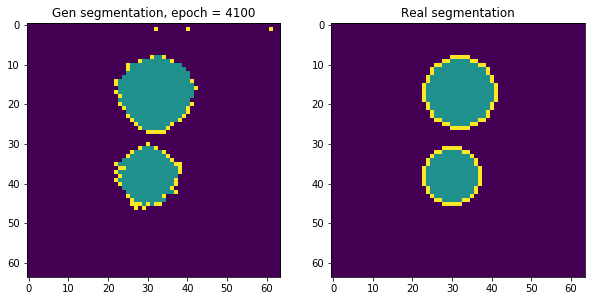

epoch - 4100, loss - 0.047004353255
epoch - 4101, loss - 0.0482922457159
epoch - 4102, loss - 0.0456888005137
epoch - 4103, loss - 0.043104082346
epoch - 4104, loss - 0.0434853509068
epoch - 4105, loss - 0.0435264855623
epoch - 4106, loss - 0.0422622412443
epoch - 4107, loss - 0.043125744909
epoch - 4108, loss - 0.0461680181324
epoch - 4109, loss - 0.0515810474753
epoch - 4110, loss - 0.0597738921642
epoch - 4111, loss - 0.0772712156177
epoch - 4112, loss - 0.102920547128
epoch - 4113, loss - 0.158354908228
epoch - 4114, loss - 0.223363414407
epoch - 4115, loss - 0.336540281773
epoch - 4116, loss - 0.350108087063
epoch - 4117, loss - 0.30850866437
epoch - 4118, loss - 0.169071704149
epoch - 4119, loss - 0.103915348649
epoch - 4120, loss - 0.157634228468
epoch - 4121, loss - 0.19490647316
epoch - 4122, loss - 0.144184291363
epoch - 4123, loss - 0.0891188383102
epoch - 4124, loss - 0.111428536475
epoch - 4125, loss - 0.125367954373
epoch - 4126, loss - 0.10639116168
epoch - 4127, loss - 

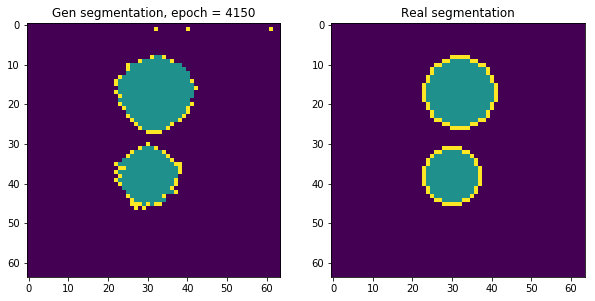

epoch - 4150, loss - 0.0482247248292
epoch - 4151, loss - 0.0476505383849
epoch - 4152, loss - 0.0501043461263
epoch - 4153, loss - 0.053263284266
epoch - 4154, loss - 0.0579308867455
epoch - 4155, loss - 0.0615918040276
epoch - 4156, loss - 0.0644814819098
epoch - 4157, loss - 0.0597337111831
epoch - 4158, loss - 0.0522465370595
epoch - 4159, loss - 0.0447403341532
epoch - 4160, loss - 0.0437011942267
epoch - 4161, loss - 0.0468892045319
epoch - 4162, loss - 0.0508328899741
epoch - 4163, loss - 0.0544948577881
epoch - 4164, loss - 0.0531796291471
epoch - 4165, loss - 0.0510525628924
epoch - 4166, loss - 0.0482572615147
epoch - 4167, loss - 0.045956812799
epoch - 4168, loss - 0.0445399060845
epoch - 4169, loss - 0.0448105633259
epoch - 4170, loss - 0.0463146716356
epoch - 4171, loss - 0.0481795892119
epoch - 4172, loss - 0.048988699913
epoch - 4173, loss - 0.0467572510242
epoch - 4174, loss - 0.0427652597427
epoch - 4175, loss - 0.041490547359
epoch - 4176, loss - 0.0440533608198
epoch

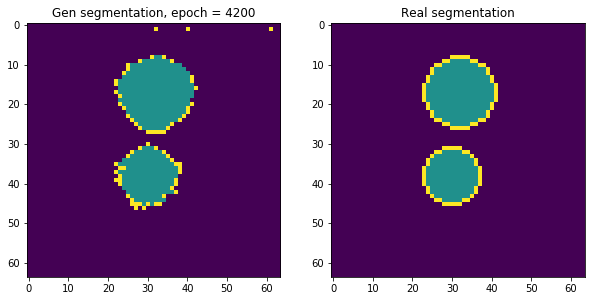

epoch - 4200, loss - 0.0579327270389
epoch - 4201, loss - 0.0678629279137
epoch - 4202, loss - 0.0718526765704
epoch - 4203, loss - 0.0576005727053
epoch - 4204, loss - 0.0494114458561
epoch - 4205, loss - 0.0617442317307
epoch - 4206, loss - 0.0631126314402
epoch - 4207, loss - 0.0468725413084
epoch - 4208, loss - 0.0487036928535
epoch - 4209, loss - 0.0559222586453
epoch - 4210, loss - 0.0471396930516
epoch - 4211, loss - 0.0421908833086
epoch - 4212, loss - 0.0465666130185
epoch - 4213, loss - 0.0456653162837
epoch - 4214, loss - 0.0421212166548
epoch - 4215, loss - 0.0410031862557
epoch - 4216, loss - 0.0416946485639
epoch - 4217, loss - 0.041859716177
epoch - 4218, loss - 0.0402491055429
epoch - 4219, loss - 0.0389030426741
epoch - 4220, loss - 0.039612300694
epoch - 4221, loss - 0.0397759303451
epoch - 4222, loss - 0.0384602099657
epoch - 4223, loss - 0.0383353456855
epoch - 4224, loss - 0.0393380485475
epoch - 4225, loss - 0.040623806417
epoch - 4226, loss - 0.042178787291
epoch

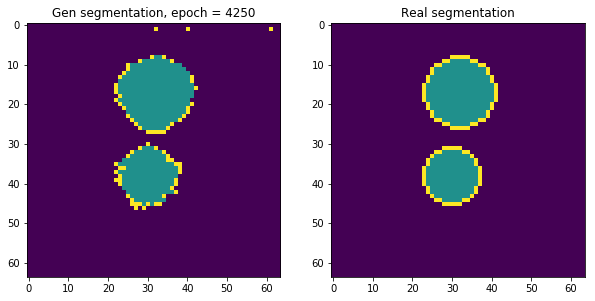

epoch - 4250, loss - 0.0897196084261
epoch - 4251, loss - 0.0660887137055
epoch - 4252, loss - 0.0719205290079
epoch - 4253, loss - 0.0730117410421
epoch - 4254, loss - 0.0597312822938
epoch - 4255, loss - 0.0676360279322
epoch - 4256, loss - 0.0608778595924
epoch - 4257, loss - 0.0563640780747
epoch - 4258, loss - 0.0577028393745
epoch - 4259, loss - 0.0530502945185
epoch - 4260, loss - 0.0534108094871
epoch - 4261, loss - 0.0529039166868
epoch - 4262, loss - 0.0482451990247
epoch - 4263, loss - 0.0488394647837
epoch - 4264, loss - 0.0472617074847
epoch - 4265, loss - 0.0451005958021
epoch - 4266, loss - 0.0462601818144
epoch - 4267, loss - 0.0437397733331
epoch - 4268, loss - 0.0434218496084
epoch - 4269, loss - 0.0433994233608
epoch - 4270, loss - 0.0410783588886
epoch - 4271, loss - 0.0418196544051
epoch - 4272, loss - 0.0405147001147
epoch - 4273, loss - 0.0396859869361
epoch - 4274, loss - 0.0398575700819
epoch - 4275, loss - 0.0386664904654
epoch - 4276, loss - 0.0383698418736
e

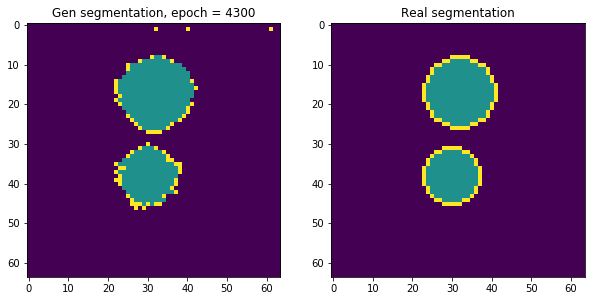

epoch - 4300, loss - 0.0455943793058
epoch - 4301, loss - 0.045578006655
epoch - 4302, loss - 0.0553014352918
epoch - 4303, loss - 0.0656623095274
epoch - 4304, loss - 0.0669536218047
epoch - 4305, loss - 0.0622831210494
epoch - 4306, loss - 0.0549351796508
epoch - 4307, loss - 0.053150113672
epoch - 4308, loss - 0.0553166046739
epoch - 4309, loss - 0.0575614199042
epoch - 4310, loss - 0.0555998086929
epoch - 4311, loss - 0.0492347441614
epoch - 4312, loss - 0.0468990728259
epoch - 4313, loss - 0.047604188323
epoch - 4314, loss - 0.0487397313118
epoch - 4315, loss - 0.0477147400379
epoch - 4316, loss - 0.0451076589525
epoch - 4317, loss - 0.0436684377491
epoch - 4318, loss - 0.0438480786979
epoch - 4319, loss - 0.0441236495972
epoch - 4320, loss - 0.0450552329421
epoch - 4321, loss - 0.0444224774837
epoch - 4322, loss - 0.0462383255363
epoch - 4323, loss - 0.0485017485917
epoch - 4324, loss - 0.0518336519599
epoch - 4325, loss - 0.0585524663329
epoch - 4326, loss - 0.0668421387672
epoc

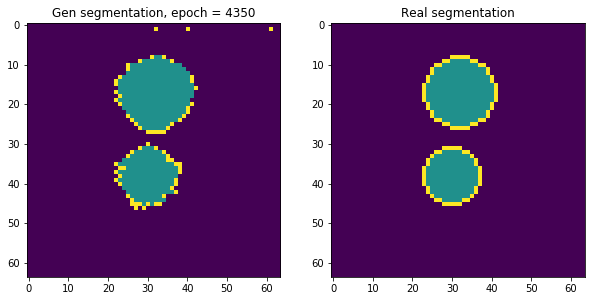

epoch - 4350, loss - 0.0535164549947
epoch - 4351, loss - 0.0487227216363
epoch - 4352, loss - 0.047049857676
epoch - 4353, loss - 0.0483920350671
epoch - 4354, loss - 0.0456651225686
epoch - 4355, loss - 0.0432878509164
epoch - 4356, loss - 0.0430159941316
epoch - 4357, loss - 0.0411419160664
epoch - 4358, loss - 0.0400241389871
epoch - 4359, loss - 0.0401926338673
epoch - 4360, loss - 0.0399599373341
epoch - 4361, loss - 0.0394731462002
epoch - 4362, loss - 0.0390312075615
epoch - 4363, loss - 0.0389395654202
epoch - 4364, loss - 0.0386674255133
epoch - 4365, loss - 0.0383008494973
epoch - 4366, loss - 0.0373433455825
epoch - 4367, loss - 0.0371497608721
epoch - 4368, loss - 0.0372726693749
epoch - 4369, loss - 0.0371663086116
epoch - 4370, loss - 0.0369480252266
epoch - 4371, loss - 0.0372486375272
epoch - 4372, loss - 0.0378597229719
epoch - 4373, loss - 0.0396277159452
epoch - 4374, loss - 0.0412495806813
epoch - 4375, loss - 0.0452549643815
epoch - 4376, loss - 0.0492784678936
ep

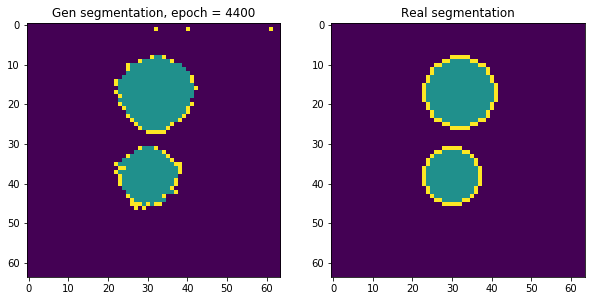

epoch - 4400, loss - 0.0635510608554
epoch - 4401, loss - 0.0649985000491
epoch - 4402, loss - 0.0580008402467
epoch - 4403, loss - 0.0587005764246
epoch - 4404, loss - 0.0591533109546
epoch - 4405, loss - 0.0479330718517
epoch - 4406, loss - 0.044028699398
epoch - 4407, loss - 0.0495144948363
epoch - 4408, loss - 0.0469068959355
epoch - 4409, loss - 0.0447836816311
epoch - 4410, loss - 0.0483932048082
epoch - 4411, loss - 0.0455454289913
epoch - 4412, loss - 0.0406821966171
epoch - 4413, loss - 0.0414375737309
epoch - 4414, loss - 0.0399394258857
epoch - 4415, loss - 0.0376949943602
epoch - 4416, loss - 0.0384284704924
epoch - 4417, loss - 0.038982283324
epoch - 4418, loss - 0.0384256206453
epoch - 4419, loss - 0.0384708568454
epoch - 4420, loss - 0.0394327044487
epoch - 4421, loss - 0.0390958189964
epoch - 4422, loss - 0.0388292521238
epoch - 4423, loss - 0.0389914512634
epoch - 4424, loss - 0.0397301316261
epoch - 4425, loss - 0.0395241118968
epoch - 4426, loss - 0.0397245809436
epo

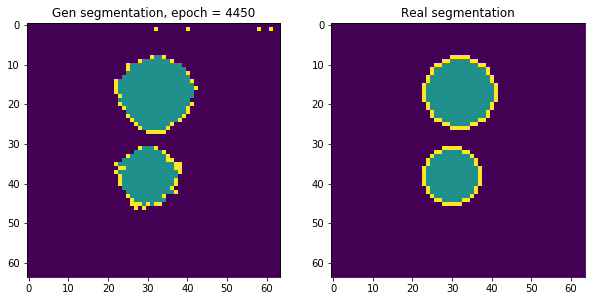

epoch - 4450, loss - 0.0683994069695
epoch - 4451, loss - 0.0558340847492
epoch - 4452, loss - 0.0475342012942
epoch - 4453, loss - 0.0509095527232
epoch - 4454, loss - 0.0539666973054
epoch - 4455, loss - 0.049004919827
epoch - 4456, loss - 0.0474044568837
epoch - 4457, loss - 0.0463851094246
epoch - 4458, loss - 0.0447325892746
epoch - 4459, loss - 0.0442591570318
epoch - 4460, loss - 0.0415754728019
epoch - 4461, loss - 0.0388559922576
epoch - 4462, loss - 0.0401292145252
epoch - 4463, loss - 0.0411301106215
epoch - 4464, loss - 0.039414934814
epoch - 4465, loss - 0.0379206910729
epoch - 4466, loss - 0.0375913828611
epoch - 4467, loss - 0.0371507257223
epoch - 4468, loss - 0.036374785006
epoch - 4469, loss - 0.0357864648104
epoch - 4470, loss - 0.0350397527218
epoch - 4471, loss - 0.0347925052047
epoch - 4472, loss - 0.0352171063423
epoch - 4473, loss - 0.0350833982229
epoch - 4474, loss - 0.0348078645766
epoch - 4475, loss - 0.035353269428
epoch - 4476, loss - 0.0374849438667
epoch

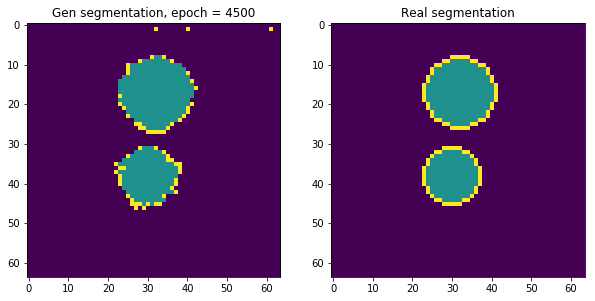

epoch - 4500, loss - 0.096024684608
epoch - 4501, loss - 0.0643937885761
epoch - 4502, loss - 0.0701739639044
epoch - 4503, loss - 0.0686794221401
epoch - 4504, loss - 0.058009210974
epoch - 4505, loss - 0.0612519644201
epoch - 4506, loss - 0.066758044064
epoch - 4507, loss - 0.0606632679701
epoch - 4508, loss - 0.0494571141899
epoch - 4509, loss - 0.0477814078331
epoch - 4510, loss - 0.0501139685512
epoch - 4511, loss - 0.0463814511895
epoch - 4512, loss - 0.0443327799439
epoch - 4513, loss - 0.0476291589439
epoch - 4514, loss - 0.0468348413706
epoch - 4515, loss - 0.0418393164873
epoch - 4516, loss - 0.0402574017644
epoch - 4517, loss - 0.0403520911932
epoch - 4518, loss - 0.0383296608925
epoch - 4519, loss - 0.0367403924465
epoch - 4520, loss - 0.0368868336082
epoch - 4521, loss - 0.0371432341635
epoch - 4522, loss - 0.0365771725774
epoch - 4523, loss - 0.03628539294
epoch - 4524, loss - 0.0363560244441
epoch - 4525, loss - 0.0369505435228
epoch - 4526, loss - 0.0371823534369
epoch 

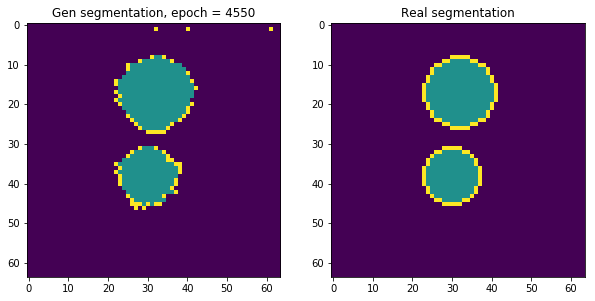

epoch - 4550, loss - 0.0827559232712
epoch - 4551, loss - 0.0680919438601
epoch - 4552, loss - 0.0749313682318
epoch - 4553, loss - 0.0680852532387
epoch - 4554, loss - 0.0577189177275
epoch - 4555, loss - 0.0595919564366
epoch - 4556, loss - 0.0566867738962
epoch - 4557, loss - 0.0499081872404
epoch - 4558, loss - 0.0476813614368
epoch - 4559, loss - 0.0486386753619
epoch - 4560, loss - 0.0472412668169
epoch - 4561, loss - 0.0439358055592
epoch - 4562, loss - 0.0436202026904
epoch - 4563, loss - 0.0442973300815
epoch - 4564, loss - 0.043274872005
epoch - 4565, loss - 0.0417402461171
epoch - 4566, loss - 0.0422168932855
epoch - 4567, loss - 0.0398969203234
epoch - 4568, loss - 0.0393523946404
epoch - 4569, loss - 0.0391789153218
epoch - 4570, loss - 0.0374969318509
epoch - 4571, loss - 0.0369301587343
epoch - 4572, loss - 0.0381908304989
epoch - 4573, loss - 0.0392305329442
epoch - 4574, loss - 0.0443960130215
epoch - 4575, loss - 0.0534127056599
epoch - 4576, loss - 0.0703852400184
ep

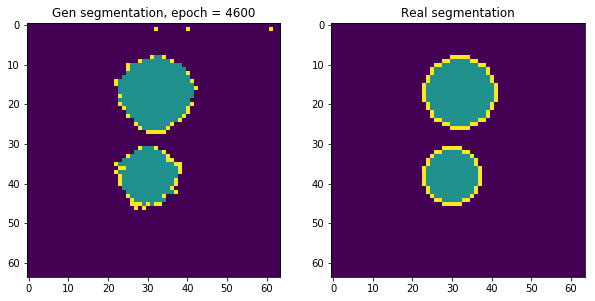

epoch - 4600, loss - 0.0510507673025
epoch - 4601, loss - 0.0479398369789
epoch - 4602, loss - 0.0528539605439
epoch - 4603, loss - 0.0487982183695
epoch - 4604, loss - 0.0415724515915
epoch - 4605, loss - 0.0447086133063
epoch - 4606, loss - 0.0446703881025
epoch - 4607, loss - 0.040179759264
epoch - 4608, loss - 0.0408166572452
epoch - 4609, loss - 0.0406758114696
epoch - 4610, loss - 0.0386321470141
epoch - 4611, loss - 0.03818288818
epoch - 4612, loss - 0.0373743325472
epoch - 4613, loss - 0.0365762710571
epoch - 4614, loss - 0.0361808761954
epoch - 4615, loss - 0.0353398658335
epoch - 4616, loss - 0.034773491323
epoch - 4617, loss - 0.0346274524927
epoch - 4618, loss - 0.0340325385332
epoch - 4619, loss - 0.0336145982146
epoch - 4620, loss - 0.0334656499326
epoch - 4621, loss - 0.033137395978
epoch - 4622, loss - 0.0331937223673
epoch - 4623, loss - 0.0331646502018
epoch - 4624, loss - 0.0333631820977
epoch - 4625, loss - 0.0339760445058
epoch - 4626, loss - 0.034937389195
epoch -

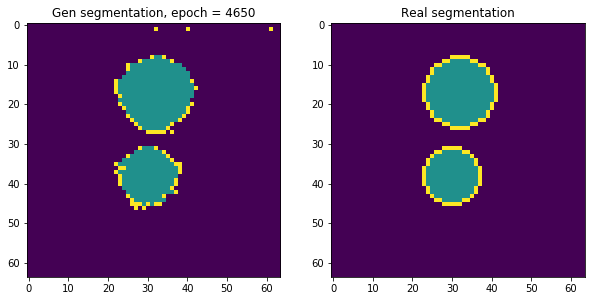

epoch - 4650, loss - 0.076712757349
epoch - 4651, loss - 0.0560685545206
epoch - 4652, loss - 0.0589859783649
epoch - 4653, loss - 0.0776614770293
epoch - 4654, loss - 0.0788305103779
epoch - 4655, loss - 0.0569537803531
epoch - 4656, loss - 0.0455000624061
epoch - 4657, loss - 0.0556844100356
epoch - 4658, loss - 0.0618508607149
epoch - 4659, loss - 0.0513379797339
epoch - 4660, loss - 0.043162625283
epoch - 4661, loss - 0.0455700792372
epoch - 4662, loss - 0.0482783466578
epoch - 4663, loss - 0.0427471660078
epoch - 4664, loss - 0.0386001616716
epoch - 4665, loss - 0.0415002927184
epoch - 4666, loss - 0.042288415134
epoch - 4667, loss - 0.0376940369606
epoch - 4668, loss - 0.0359845981002
epoch - 4669, loss - 0.0386392176151
epoch - 4670, loss - 0.0396213829517
epoch - 4671, loss - 0.0375041812658
epoch - 4672, loss - 0.0378192141652
epoch - 4673, loss - 0.0414985343814
epoch - 4674, loss - 0.0464717820287
epoch - 4675, loss - 0.0515397563577
epoch - 4676, loss - 0.0655393749475
epoc

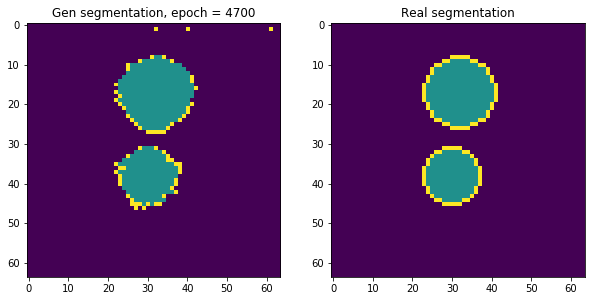

epoch - 4700, loss - 0.0459941476583
epoch - 4701, loss - 0.0456423982978
epoch - 4702, loss - 0.0471922196448
epoch - 4703, loss - 0.0464287512004
epoch - 4704, loss - 0.0410101115704
epoch - 4705, loss - 0.0393785648048
epoch - 4706, loss - 0.0396647639573
epoch - 4707, loss - 0.0374193303287
epoch - 4708, loss - 0.0379494354129
epoch - 4709, loss - 0.0390640646219
epoch - 4710, loss - 0.0364993028343
epoch - 4711, loss - 0.0354478135705
epoch - 4712, loss - 0.0348118618131
epoch - 4713, loss - 0.0331250503659
epoch - 4714, loss - 0.0332587808371
epoch - 4715, loss - 0.0344731882215
epoch - 4716, loss - 0.0338753536344
epoch - 4717, loss - 0.0332435555756
epoch - 4718, loss - 0.0334558039904
epoch - 4719, loss - 0.033172391355
epoch - 4720, loss - 0.0330507643521
epoch - 4721, loss - 0.034855209291
epoch - 4722, loss - 0.0377192944288
epoch - 4723, loss - 0.0428039431572
epoch - 4724, loss - 0.0478696972132
epoch - 4725, loss - 0.0540705695748
epoch - 4726, loss - 0.0540766492486
epo

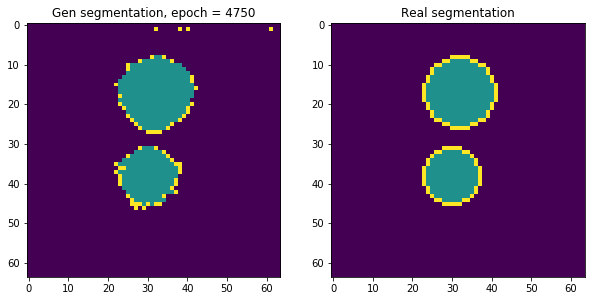

epoch - 4750, loss - 0.0522070676088
epoch - 4751, loss - 0.0702860057354
epoch - 4752, loss - 0.0875718519092
epoch - 4753, loss - 0.124085880816
epoch - 4754, loss - 0.152840346098
epoch - 4755, loss - 0.205201655626
epoch - 4756, loss - 0.206568062305
epoch - 4757, loss - 0.205070614815
epoch - 4758, loss - 0.197260707617
epoch - 4759, loss - 0.185389056802
epoch - 4760, loss - 0.17847135663
epoch - 4761, loss - 0.107939094305
epoch - 4762, loss - 0.12222353369
epoch - 4763, loss - 0.162508875132
epoch - 4764, loss - 0.093939833343
epoch - 4765, loss - 0.0879316329956
epoch - 4766, loss - 0.117979750037
epoch - 4767, loss - 0.0675746202469
epoch - 4768, loss - 0.0876047387719
epoch - 4769, loss - 0.105654284358
epoch - 4770, loss - 0.0603147186339
epoch - 4771, loss - 0.0800354033709
epoch - 4772, loss - 0.0790064483881
epoch - 4773, loss - 0.0575479343534
epoch - 4774, loss - 0.0764999762177
epoch - 4775, loss - 0.0669275522232
epoch - 4776, loss - 0.0525468066335
epoch - 4777, los

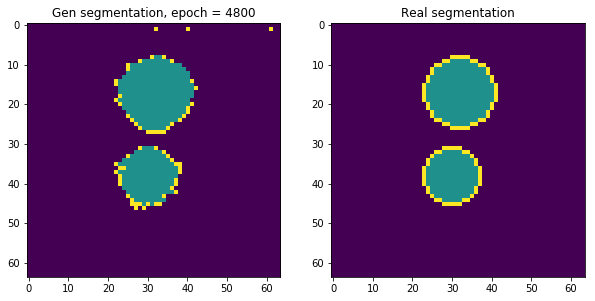

epoch - 4800, loss - 0.0322142764926
epoch - 4801, loss - 0.0319451987743
epoch - 4802, loss - 0.0323408171535
epoch - 4803, loss - 0.0326793082058
epoch - 4804, loss - 0.033562976867
epoch - 4805, loss - 0.0356175862253
epoch - 4806, loss - 0.0375640206039
epoch - 4807, loss - 0.0407823100686
epoch - 4808, loss - 0.0440126210451
epoch - 4809, loss - 0.0469624772668
epoch - 4810, loss - 0.0498302876949
epoch - 4811, loss - 0.0516504198313
epoch - 4812, loss - 0.056742798537
epoch - 4813, loss - 0.064732901752
epoch - 4814, loss - 0.0833105072379
epoch - 4815, loss - 0.101182572544
epoch - 4816, loss - 0.127228543162
epoch - 4817, loss - 0.132201686502
epoch - 4818, loss - 0.126376494765
epoch - 4819, loss - 0.0918398499489
epoch - 4820, loss - 0.0574976578355
epoch - 4821, loss - 0.0452143400908
epoch - 4822, loss - 0.0578541457653
epoch - 4823, loss - 0.0765181258321
epoch - 4824, loss - 0.0768939852715
epoch - 4825, loss - 0.0629678592086
epoch - 4826, loss - 0.0467100962996
epoch - 

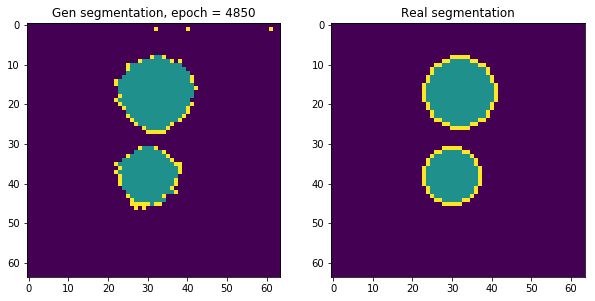

epoch - 4850, loss - 0.0640596747398
epoch - 4851, loss - 0.0753191933036
epoch - 4852, loss - 0.0907248109579
epoch - 4853, loss - 0.100842870772
epoch - 4854, loss - 0.105015277863
epoch - 4855, loss - 0.0983053743839
epoch - 4856, loss - 0.0883114114404
epoch - 4857, loss - 0.0783441066742
epoch - 4858, loss - 0.0696715265512
epoch - 4859, loss - 0.058617554605
epoch - 4860, loss - 0.0534367375076
epoch - 4861, loss - 0.0620266273618
epoch - 4862, loss - 0.0657861307263
epoch - 4863, loss - 0.0621850304306
epoch - 4864, loss - 0.057315081358
epoch - 4865, loss - 0.0516487285495
epoch - 4866, loss - 0.0439336299896
epoch - 4867, loss - 0.0399219505489
epoch - 4868, loss - 0.0417824573815
epoch - 4869, loss - 0.042263917625
epoch - 4870, loss - 0.0388067141175
epoch - 4871, loss - 0.0398658663034
epoch - 4872, loss - 0.0422602519393
epoch - 4873, loss - 0.0399537011981
epoch - 4874, loss - 0.0383575074375
epoch - 4875, loss - 0.0383823215961
epoch - 4876, loss - 0.0367563478649
epoch 

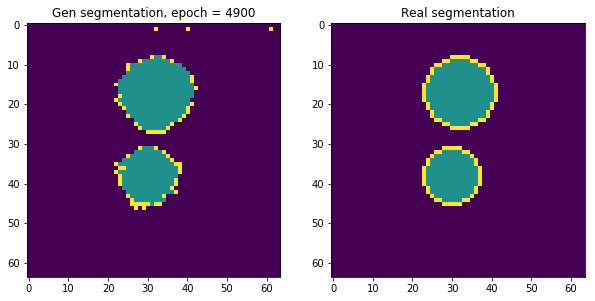

epoch - 4900, loss - 0.203789949417
epoch - 4901, loss - 0.235836908221
epoch - 4902, loss - 0.261597514153
epoch - 4903, loss - 0.240991443396
epoch - 4904, loss - 0.202046662569
epoch - 4905, loss - 0.12591907382
epoch - 4906, loss - 0.0774164423347
epoch - 4907, loss - 0.114990718663
epoch - 4908, loss - 0.139747008681
epoch - 4909, loss - 0.100819818676
epoch - 4910, loss - 0.075832657516
epoch - 4911, loss - 0.0796891078353
epoch - 4912, loss - 0.0756935179234
epoch - 4913, loss - 0.0837199687958
epoch - 4914, loss - 0.0758175104856
epoch - 4915, loss - 0.0507429949939
epoch - 4916, loss - 0.0590974129736
epoch - 4917, loss - 0.0633441209793
epoch - 4918, loss - 0.0548684149981
epoch - 4919, loss - 0.0559091940522
epoch - 4920, loss - 0.0470593422651
epoch - 4921, loss - 0.0452063828707
epoch - 4922, loss - 0.048087656498
epoch - 4923, loss - 0.0442940853536
epoch - 4924, loss - 0.0457905977964
epoch - 4925, loss - 0.0421161204576
epoch - 4926, loss - 0.0377958416939
epoch - 4927,

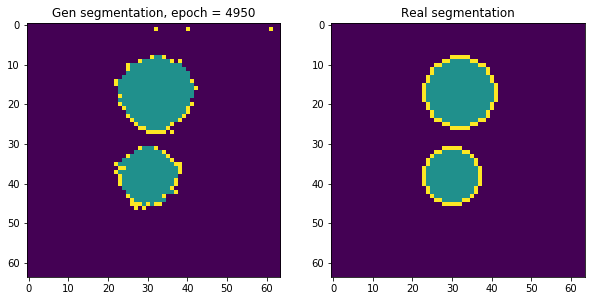

epoch - 4950, loss - 0.0287180952728
epoch - 4951, loss - 0.0296948347241
epoch - 4952, loss - 0.030989985913
epoch - 4953, loss - 0.0334935896099
epoch - 4954, loss - 0.0367264784873
epoch - 4955, loss - 0.0426999852061
epoch - 4956, loss - 0.0473538786173
epoch - 4957, loss - 0.0550625771284
epoch - 4958, loss - 0.0612805262208
epoch - 4959, loss - 0.067519068718
epoch - 4960, loss - 0.0793903917074
epoch - 4961, loss - 0.0925113111734
epoch - 4962, loss - 0.115955092013
epoch - 4963, loss - 0.121511489153
epoch - 4964, loss - 0.1198797822
epoch - 4965, loss - 0.0915885865688
epoch - 4966, loss - 0.0688068792224
epoch - 4967, loss - 0.0591678619385
epoch - 4968, loss - 0.0616510510445
epoch - 4969, loss - 0.0655290484428
epoch - 4970, loss - 0.060906894505
epoch - 4971, loss - 0.0596259534359
epoch - 4972, loss - 0.0582247152925
epoch - 4973, loss - 0.0512667447329
epoch - 4974, loss - 0.0428746417165
epoch - 4975, loss - 0.0413680672646
epoch - 4976, loss - 0.0471890121698
epoch - 4

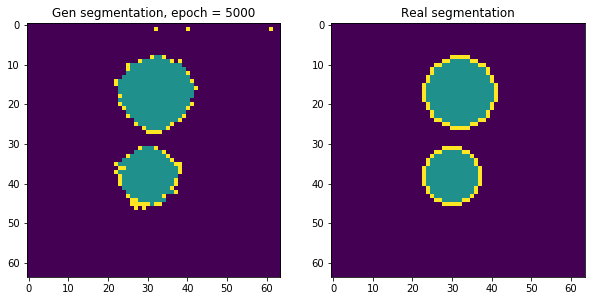

epoch - 5000, loss - 0.108956389129
epoch - 5001, loss - 0.133654922247
epoch - 5002, loss - 0.155150562525
epoch - 5003, loss - 0.158869788051
epoch - 5004, loss - 0.135547399521
epoch - 5005, loss - 0.103409335017
epoch - 5006, loss - 0.0859491974115
epoch - 5007, loss - 0.0864638462663
epoch - 5008, loss - 0.0904647111893
epoch - 5009, loss - 0.0643179416656
epoch - 5010, loss - 0.0658629536629
epoch - 5011, loss - 0.0826680511236
epoch - 5012, loss - 0.0670453310013
epoch - 5013, loss - 0.0538025051355
epoch - 5014, loss - 0.0475018620491
epoch - 5015, loss - 0.0475637093186
epoch - 5016, loss - 0.0522100478411
epoch - 5017, loss - 0.0481445230544
epoch - 5018, loss - 0.0444883778691
epoch - 5019, loss - 0.043339394033
epoch - 5020, loss - 0.0415686257184
epoch - 5021, loss - 0.0410587862134
epoch - 5022, loss - 0.0368317216635
epoch - 5023, loss - 0.0328963361681
epoch - 5024, loss - 0.0355707444251
epoch - 5025, loss - 0.0357206501067
epoch - 5026, loss - 0.0334842763841
epoch - 

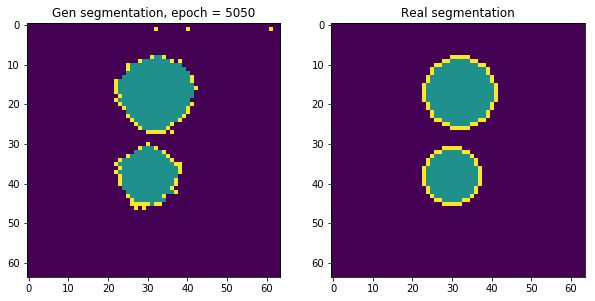

epoch - 5050, loss - 0.0513021834195
epoch - 5051, loss - 0.0560075938702
epoch - 5052, loss - 0.0594307258725
epoch - 5053, loss - 0.0653371140361
epoch - 5054, loss - 0.0798553153872
epoch - 5055, loss - 0.11839544028
epoch - 5056, loss - 0.156759291887
epoch - 5057, loss - 0.217640504241
epoch - 5058, loss - 0.219438627362
epoch - 5059, loss - 0.214311122894
epoch - 5060, loss - 0.172561779618
epoch - 5061, loss - 0.126509591937
epoch - 5062, loss - 0.0945795103908
epoch - 5063, loss - 0.104695215821
epoch - 5064, loss - 0.127997010946
epoch - 5065, loss - 0.1030806005
epoch - 5066, loss - 0.0721589997411
epoch - 5067, loss - 0.0726869106293
epoch - 5068, loss - 0.0750508755445
epoch - 5069, loss - 0.0672367364168
epoch - 5070, loss - 0.0689273774624
epoch - 5071, loss - 0.0650756582618
epoch - 5072, loss - 0.0466418229043
epoch - 5073, loss - 0.0501681566238
epoch - 5074, loss - 0.0586494132876
epoch - 5075, loss - 0.0472604259849
epoch - 5076, loss - 0.0432784110308
epoch - 5077, 

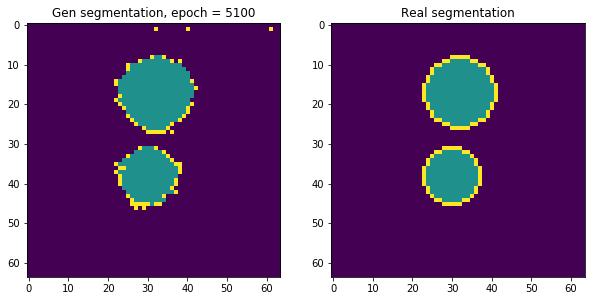

epoch - 5100, loss - 0.0268474444747
epoch - 5101, loss - 0.0272115916014
epoch - 5102, loss - 0.02795766294
epoch - 5103, loss - 0.0295475460589
epoch - 5104, loss - 0.0332100689411
epoch - 5105, loss - 0.0386657454073
epoch - 5106, loss - 0.048484954983
epoch - 5107, loss - 0.0608877614141
epoch - 5108, loss - 0.0780149698257
epoch - 5109, loss - 0.0964198932052
epoch - 5110, loss - 0.108719669282
epoch - 5111, loss - 0.124573729932
epoch - 5112, loss - 0.128010779619
epoch - 5113, loss - 0.13971811533
epoch - 5114, loss - 0.123935051262
epoch - 5115, loss - 0.101062774658
epoch - 5116, loss - 0.063724398613
epoch - 5117, loss - 0.0469090752304
epoch - 5118, loss - 0.0647333115339
epoch - 5119, loss - 0.0872038081288
epoch - 5120, loss - 0.0823841840029
epoch - 5121, loss - 0.0521790459752
epoch - 5122, loss - 0.0381241738796
epoch - 5123, loss - 0.0498910732567
epoch - 5124, loss - 0.0570340789855
epoch - 5125, loss - 0.0513937473297
epoch - 5126, loss - 0.0418876111507
epoch - 5127

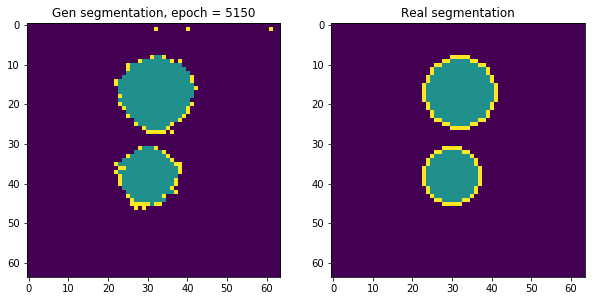

epoch - 5150, loss - 0.030900914222
epoch - 5151, loss - 0.0316988602281
epoch - 5152, loss - 0.0337591692805
epoch - 5153, loss - 0.0369155928493
epoch - 5154, loss - 0.0399344041944
epoch - 5155, loss - 0.0437424108386
epoch - 5156, loss - 0.0469284579158
epoch - 5157, loss - 0.0530276149511
epoch - 5158, loss - 0.0679568126798
epoch - 5159, loss - 0.0889151319861
epoch - 5160, loss - 0.124444946647
epoch - 5161, loss - 0.143721267581
epoch - 5162, loss - 0.167380794883
epoch - 5163, loss - 0.166605651379
epoch - 5164, loss - 0.145917341113
epoch - 5165, loss - 0.133780613542
epoch - 5166, loss - 0.0986683666706
epoch - 5167, loss - 0.107756108046
epoch - 5168, loss - 0.119356095791
epoch - 5169, loss - 0.0933244228363
epoch - 5170, loss - 0.0826454237103
epoch - 5171, loss - 0.0835932046175
epoch - 5172, loss - 0.0647192895412
epoch - 5173, loss - 0.0584264993668
epoch - 5174, loss - 0.0635437965393
epoch - 5175, loss - 0.0549366921186
epoch - 5176, loss - 0.0560658350587
epoch - 51

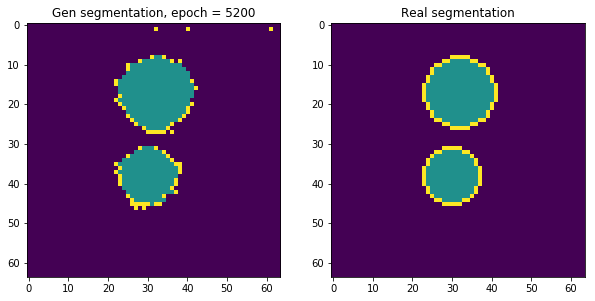

epoch - 5200, loss - 0.0296900831163
epoch - 5201, loss - 0.029537839815
epoch - 5202, loss - 0.0305851940066
epoch - 5203, loss - 0.0315558686852
epoch - 5204, loss - 0.0334217846394
epoch - 5205, loss - 0.0354373529553
epoch - 5206, loss - 0.0394089072943
epoch - 5207, loss - 0.0443543717265
epoch - 5208, loss - 0.0527195073664
epoch - 5209, loss - 0.062371045351
epoch - 5210, loss - 0.0777416005731
epoch - 5211, loss - 0.0919196382165
epoch - 5212, loss - 0.105014950037
epoch - 5213, loss - 0.106158845127
epoch - 5214, loss - 0.0930267646909
epoch - 5215, loss - 0.0675337612629
epoch - 5216, loss - 0.0503384396434
epoch - 5217, loss - 0.0492048934102
epoch - 5218, loss - 0.05780306831
epoch - 5219, loss - 0.0552249997854
epoch - 5220, loss - 0.0505465269089
epoch - 5221, loss - 0.0525503121316
epoch - 5222, loss - 0.0559232011437
epoch - 5223, loss - 0.0532826259732
epoch - 5224, loss - 0.0388325639069
epoch - 5225, loss - 0.0328428260982
epoch - 5226, loss - 0.0407019555569
epoch -

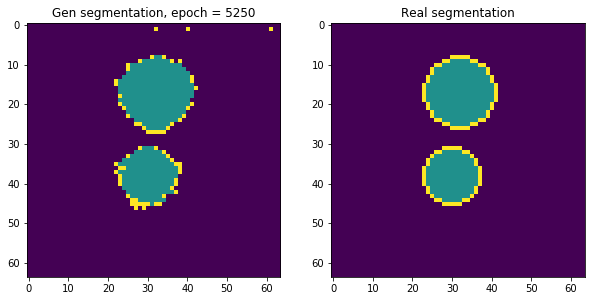

epoch - 5250, loss - 0.113867931068
epoch - 5251, loss - 0.12063600868
epoch - 5252, loss - 0.122260443866
epoch - 5253, loss - 0.106286041439
epoch - 5254, loss - 0.0914009064436
epoch - 5255, loss - 0.0667385682464
epoch - 5256, loss - 0.0515300780535
epoch - 5257, loss - 0.0544334501028
epoch - 5258, loss - 0.0766840726137
epoch - 5259, loss - 0.0924449190497
epoch - 5260, loss - 0.0755700618029
epoch - 5261, loss - 0.0473190844059
epoch - 5262, loss - 0.0389479547739
epoch - 5263, loss - 0.0467317402363
epoch - 5264, loss - 0.051632553339
epoch - 5265, loss - 0.0498311296105
epoch - 5266, loss - 0.0487353801727
epoch - 5267, loss - 0.0479561090469
epoch - 5268, loss - 0.0421505831182
epoch - 5269, loss - 0.03784205392
epoch - 5270, loss - 0.0390431322157
epoch - 5271, loss - 0.0391485020518
epoch - 5272, loss - 0.0356034561992
epoch - 5273, loss - 0.0316139571369
epoch - 5274, loss - 0.0318999402225
epoch - 5275, loss - 0.0339541397989
epoch - 5276, loss - 0.0335124544799
epoch - 5

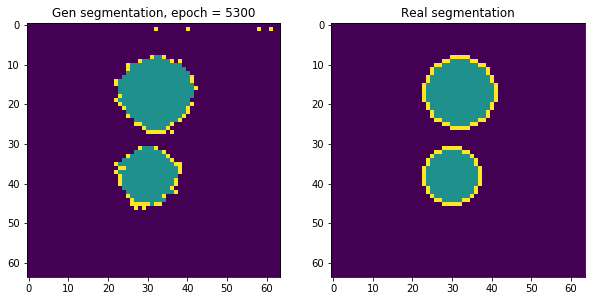

epoch - 5300, loss - 0.0676010325551
epoch - 5301, loss - 0.0863141268492
epoch - 5302, loss - 0.101774960756
epoch - 5303, loss - 0.126232862473
epoch - 5304, loss - 0.135144710541
epoch - 5305, loss - 0.163296505809
epoch - 5306, loss - 0.170676067472
epoch - 5307, loss - 0.177396759391
epoch - 5308, loss - 0.179041594267
epoch - 5309, loss - 0.144792601466
epoch - 5310, loss - 0.114541769028
epoch - 5311, loss - 0.0995311290026
epoch - 5312, loss - 0.103365540504
epoch - 5313, loss - 0.099998190999
epoch - 5314, loss - 0.085717625916
epoch - 5315, loss - 0.0691358447075
epoch - 5316, loss - 0.0622533299029
epoch - 5317, loss - 0.0653194785118
epoch - 5318, loss - 0.0639475807548
epoch - 5319, loss - 0.0543129183352
epoch - 5320, loss - 0.0530814193189
epoch - 5321, loss - 0.0528819076717
epoch - 5322, loss - 0.0439781658351
epoch - 5323, loss - 0.0435126051307
epoch - 5324, loss - 0.0420437157154
epoch - 5325, loss - 0.0394080132246
epoch - 5326, loss - 0.041209474206
epoch - 5327, 

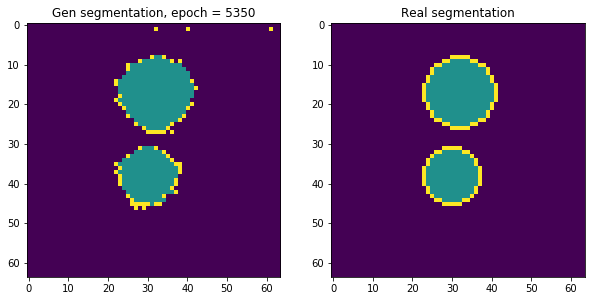

epoch - 5350, loss - 0.0286387074739
epoch - 5351, loss - 0.0310896895826
epoch - 5352, loss - 0.0344844982028
epoch - 5353, loss - 0.0408767350018
epoch - 5354, loss - 0.0482359677553
epoch - 5355, loss - 0.061447031796
epoch - 5356, loss - 0.0755932107568
epoch - 5357, loss - 0.0996645763516
epoch - 5358, loss - 0.118628956378
epoch - 5359, loss - 0.144327655435
epoch - 5360, loss - 0.147996857762
epoch - 5361, loss - 0.139089927077
epoch - 5362, loss - 0.107217684388
epoch - 5363, loss - 0.0706570893526
epoch - 5364, loss - 0.0609238259494
epoch - 5365, loss - 0.0751134082675
epoch - 5366, loss - 0.0936431065202
epoch - 5367, loss - 0.0945391654968
epoch - 5368, loss - 0.0738957673311
epoch - 5369, loss - 0.0502642206848
epoch - 5370, loss - 0.0446259230375
epoch - 5371, loss - 0.0517180711031
epoch - 5372, loss - 0.0609412454069
epoch - 5373, loss - 0.0615656599402
epoch - 5374, loss - 0.0490222424269
epoch - 5375, loss - 0.0372667759657
epoch - 5376, loss - 0.036124099046
epoch - 

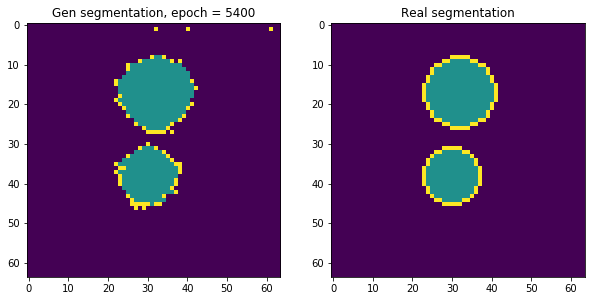

epoch - 5400, loss - 0.0256021879613
epoch - 5401, loss - 0.0261402018368
epoch - 5402, loss - 0.0277255997062
epoch - 5403, loss - 0.0286009609699
epoch - 5404, loss - 0.0307992585003
epoch - 5405, loss - 0.0333144441247
epoch - 5406, loss - 0.0384436324239
epoch - 5407, loss - 0.0414614900947
epoch - 5408, loss - 0.0450800806284
epoch - 5409, loss - 0.0439382717013
epoch - 5410, loss - 0.0410618670285
epoch - 5411, loss - 0.0367315970361
epoch - 5412, loss - 0.037942007184
epoch - 5413, loss - 0.0433430708945
epoch - 5414, loss - 0.0500902533531
epoch - 5415, loss - 0.059338234365
epoch - 5416, loss - 0.0631739795208
epoch - 5417, loss - 0.0697347521782
epoch - 5418, loss - 0.0766700208187
epoch - 5419, loss - 0.101809471846
epoch - 5420, loss - 0.143498048186
epoch - 5421, loss - 0.159616038203
epoch - 5422, loss - 0.165281072259
epoch - 5423, loss - 0.142974004149
epoch - 5424, loss - 0.157533109188
epoch - 5425, loss - 0.15050573647
epoch - 5426, loss - 0.0783839970827
epoch - 542

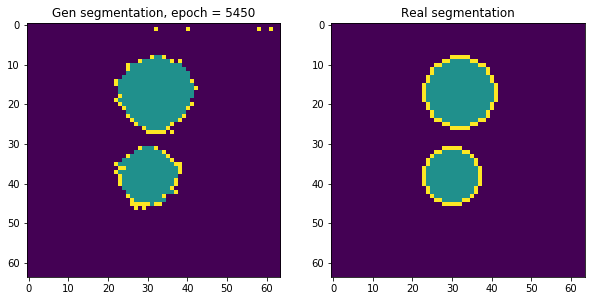

epoch - 5450, loss - 0.0284763760865
epoch - 5451, loss - 0.0278234928846
epoch - 5452, loss - 0.0282354466617
epoch - 5453, loss - 0.0276976600289
epoch - 5454, loss - 0.0290205404162
epoch - 5455, loss - 0.0292766951025
epoch - 5456, loss - 0.0307973213494
epoch - 5457, loss - 0.0322776809335
epoch - 5458, loss - 0.0340233854949
epoch - 5459, loss - 0.0353950038552
epoch - 5460, loss - 0.0361280143261
epoch - 5461, loss - 0.0349176116288
epoch - 5462, loss - 0.0329000502825
epoch - 5463, loss - 0.0291519574821
epoch - 5464, loss - 0.0256481580436
epoch - 5465, loss - 0.0240018274635
epoch - 5466, loss - 0.0242911819369
epoch - 5467, loss - 0.0264896694571
epoch - 5468, loss - 0.0291375257075
epoch - 5469, loss - 0.0320065505803
epoch - 5470, loss - 0.0345762111247
epoch - 5471, loss - 0.0379885472357
epoch - 5472, loss - 0.0397093258798
epoch - 5473, loss - 0.0429954603314
epoch - 5474, loss - 0.047018840909
epoch - 5475, loss - 0.0587116107345
epoch - 5476, loss - 0.0800626203418
ep

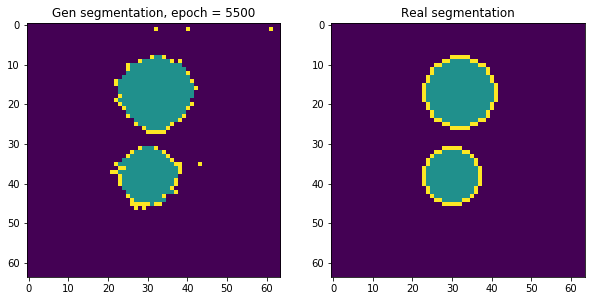

epoch - 5500, loss - 0.042684212327
epoch - 5501, loss - 0.0364761948586
epoch - 5502, loss - 0.0370554365218
epoch - 5503, loss - 0.0388280935585
epoch - 5504, loss - 0.0345832407475
epoch - 5505, loss - 0.0339417755604
epoch - 5506, loss - 0.0336137078702
epoch - 5507, loss - 0.0305447168648
epoch - 5508, loss - 0.0307859294116
epoch - 5509, loss - 0.0300771202892
epoch - 5510, loss - 0.0285325888544
epoch - 5511, loss - 0.0288260653615
epoch - 5512, loss - 0.0278410762548
epoch - 5513, loss - 0.0273988936096
epoch - 5514, loss - 0.0272157490253
epoch - 5515, loss - 0.026153171435
epoch - 5516, loss - 0.0258256252855
epoch - 5517, loss - 0.025572668761
epoch - 5518, loss - 0.0250707771629
epoch - 5519, loss - 0.0243002846837
epoch - 5520, loss - 0.0241482555866
epoch - 5521, loss - 0.0240874756128
epoch - 5522, loss - 0.0233355164528
epoch - 5523, loss - 0.0229574330151
epoch - 5524, loss - 0.0232200659811
epoch - 5525, loss - 0.0228505376726
epoch - 5526, loss - 0.022449394688
epoch

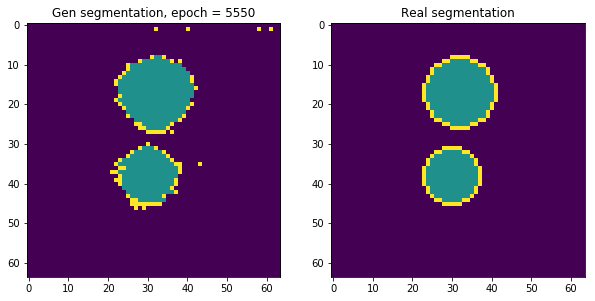

epoch - 5550, loss - 0.105054244399
epoch - 5551, loss - 0.0554649606347
epoch - 5552, loss - 0.0475386790931
epoch - 5553, loss - 0.0668585896492
epoch - 5554, loss - 0.0724964514375
epoch - 5555, loss - 0.0627104267478
epoch - 5556, loss - 0.0529971644282
epoch - 5557, loss - 0.0415921956301
epoch - 5558, loss - 0.0417513698339
epoch - 5559, loss - 0.0494916327298
epoch - 5560, loss - 0.0472040399909
epoch - 5561, loss - 0.0409522913396
epoch - 5562, loss - 0.036282710731
epoch - 5563, loss - 0.033464692533
epoch - 5564, loss - 0.0342931933701
epoch - 5565, loss - 0.0359664708376
epoch - 5566, loss - 0.0350866653025
epoch - 5567, loss - 0.0321803800762
epoch - 5568, loss - 0.0289509445429
epoch - 5569, loss - 0.0276904031634
epoch - 5570, loss - 0.0280325952917
epoch - 5571, loss - 0.0285948701203
epoch - 5572, loss - 0.0286502055824
epoch - 5573, loss - 0.0280816741288
epoch - 5574, loss - 0.026802495122
epoch - 5575, loss - 0.0253357961774
epoch - 5576, loss - 0.0243857502937
epoch

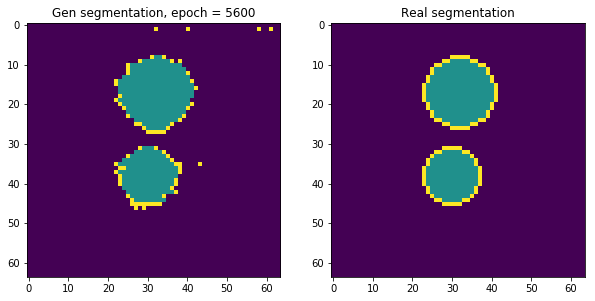

epoch - 5600, loss - 0.0505118146539
epoch - 5601, loss - 0.051026340574
epoch - 5602, loss - 0.0447417907417
epoch - 5603, loss - 0.039263535291
epoch - 5604, loss - 0.0382128022611
epoch - 5605, loss - 0.0441009998322
epoch - 5606, loss - 0.0522098764777
epoch - 5607, loss - 0.0527208894491
epoch - 5608, loss - 0.0464342944324
epoch - 5609, loss - 0.0417120680213
epoch - 5610, loss - 0.0453097894788
epoch - 5611, loss - 0.0507226660848
epoch - 5612, loss - 0.0488418936729
epoch - 5613, loss - 0.0435034967959
epoch - 5614, loss - 0.0436577647924
epoch - 5615, loss - 0.0486969128251
epoch - 5616, loss - 0.04804892838
epoch - 5617, loss - 0.0429808869958
epoch - 5618, loss - 0.0433472022414
epoch - 5619, loss - 0.0475703701377
epoch - 5620, loss - 0.0456321239471
epoch - 5621, loss - 0.0392306596041
epoch - 5622, loss - 0.0376614630222
epoch - 5623, loss - 0.0416085533798
epoch - 5624, loss - 0.0413319319487
epoch - 5625, loss - 0.038344912231
epoch - 5626, loss - 0.0389657095075
epoch 

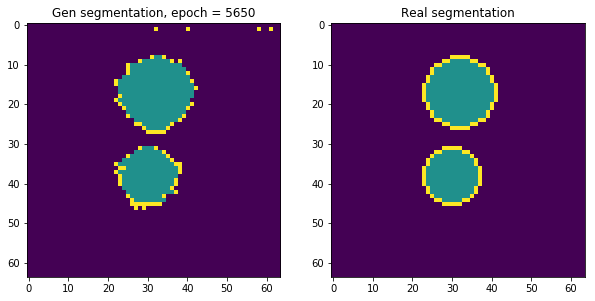

epoch - 5650, loss - 0.0643413364887
epoch - 5651, loss - 0.067460745573
epoch - 5652, loss - 0.0577559098601
epoch - 5653, loss - 0.0501469857991
epoch - 5654, loss - 0.0524231083691
epoch - 5655, loss - 0.0603892579675
epoch - 5656, loss - 0.0666277036071
epoch - 5657, loss - 0.0629844069481
epoch - 5658, loss - 0.0557844676077
epoch - 5659, loss - 0.0518227741122
epoch - 5660, loss - 0.0483027659357
epoch - 5661, loss - 0.0500710830092
epoch - 5662, loss - 0.0474471375346
epoch - 5663, loss - 0.0420059077442
epoch - 5664, loss - 0.0362290740013
epoch - 5665, loss - 0.0344538167119
epoch - 5666, loss - 0.0318499021232
epoch - 5667, loss - 0.0296193137765
epoch - 5668, loss - 0.0304019358009
epoch - 5669, loss - 0.029828440398
epoch - 5670, loss - 0.0279558598995
epoch - 5671, loss - 0.0259720087051
epoch - 5672, loss - 0.0259823128581
epoch - 5673, loss - 0.0269661061466
epoch - 5674, loss - 0.0265349205583
epoch - 5675, loss - 0.0258169323206
epoch - 5676, loss - 0.0274522565305
epo

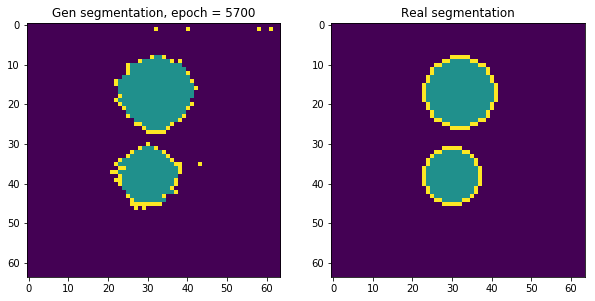

epoch - 5700, loss - 0.0327827222645
epoch - 5701, loss - 0.0405804142356
epoch - 5702, loss - 0.0446067862213
epoch - 5703, loss - 0.0429032072425
epoch - 5704, loss - 0.0343441367149
epoch - 5705, loss - 0.0283430479467
epoch - 5706, loss - 0.0290857590735
epoch - 5707, loss - 0.032864138484
epoch - 5708, loss - 0.0339820533991
epoch - 5709, loss - 0.0310603156686
epoch - 5710, loss - 0.0279779396951
epoch - 5711, loss - 0.0254329778254
epoch - 5712, loss - 0.0250671692193
epoch - 5713, loss - 0.0263028945774
epoch - 5714, loss - 0.0266906302422
epoch - 5715, loss - 0.0264278464019
epoch - 5716, loss - 0.0253455135971
epoch - 5717, loss - 0.0239866822958
epoch - 5718, loss - 0.0229787770659
epoch - 5719, loss - 0.022804254666
epoch - 5720, loss - 0.0240251272917
epoch - 5721, loss - 0.0263185985386
epoch - 5722, loss - 0.0278323255479
epoch - 5723, loss - 0.0303700100631
epoch - 5724, loss - 0.0346588753164
epoch - 5725, loss - 0.0417333841324
epoch - 5726, loss - 0.051237989217
epoc

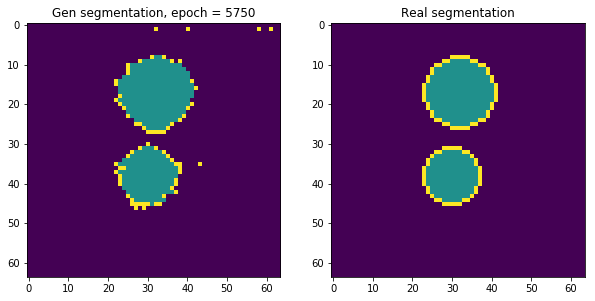

epoch - 5750, loss - 0.0294096469879
epoch - 5751, loss - 0.0256729722023
epoch - 5752, loss - 0.0272649489343
epoch - 5753, loss - 0.0276393741369
epoch - 5754, loss - 0.025551373139
epoch - 5755, loss - 0.0252763181925
epoch - 5756, loss - 0.0256804786623
epoch - 5757, loss - 0.0262325294316
epoch - 5758, loss - 0.0264029540122
epoch - 5759, loss - 0.0264465417713
epoch - 5760, loss - 0.0286908727139
epoch - 5761, loss - 0.032589495182
epoch - 5762, loss - 0.0359192527831
epoch - 5763, loss - 0.0434242077172
epoch - 5764, loss - 0.0529641918838
epoch - 5765, loss - 0.0699320212007
epoch - 5766, loss - 0.0881011933088
epoch - 5767, loss - 0.113217942417
epoch - 5768, loss - 0.130725666881
epoch - 5769, loss - 0.153285443783
epoch - 5770, loss - 0.147065967321
epoch - 5771, loss - 0.138346776366
epoch - 5772, loss - 0.104669183493
epoch - 5773, loss - 0.0845456644893
epoch - 5774, loss - 0.0703777521849
epoch - 5775, loss - 0.0776927396655
epoch - 5776, loss - 0.0974695682526
epoch - 5

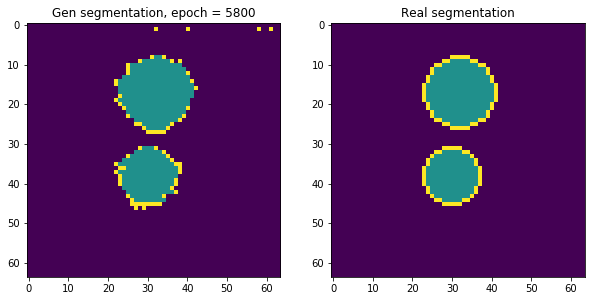

epoch - 5800, loss - 0.0231712087989
epoch - 5801, loss - 0.0220771282911
epoch - 5802, loss - 0.0231322795153
epoch - 5803, loss - 0.0234000347555
epoch - 5804, loss - 0.0223820582032
epoch - 5805, loss - 0.0212408229709
epoch - 5806, loss - 0.0216156318784
epoch - 5807, loss - 0.0223390124738
epoch - 5808, loss - 0.0219155661762
epoch - 5809, loss - 0.0211440436542
epoch - 5810, loss - 0.0216625183821
epoch - 5811, loss - 0.0227885358036
epoch - 5812, loss - 0.0235042013228
epoch - 5813, loss - 0.0246755219996
epoch - 5814, loss - 0.0269162785262
epoch - 5815, loss - 0.0304173920304
epoch - 5816, loss - 0.0334067717195
epoch - 5817, loss - 0.0360909104347
epoch - 5818, loss - 0.0372739806771
epoch - 5819, loss - 0.0401062592864
epoch - 5820, loss - 0.0439931377769
epoch - 5821, loss - 0.0514884963632
epoch - 5822, loss - 0.0633898824453
epoch - 5823, loss - 0.0879101008177
epoch - 5824, loss - 0.120022788644
epoch - 5825, loss - 0.147562265396
epoch - 5826, loss - 0.142092272639
epoc

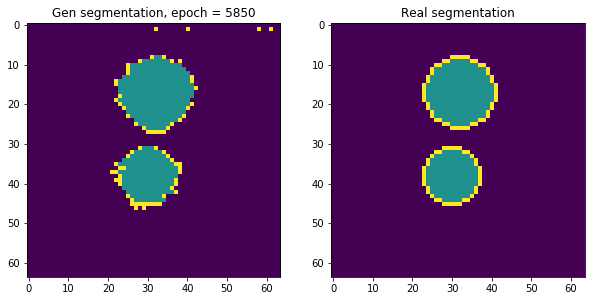

epoch - 5850, loss - 0.0259076040238
epoch - 5851, loss - 0.026213971898
epoch - 5852, loss - 0.0269593112171
epoch - 5853, loss - 0.0263115707785
epoch - 5854, loss - 0.0261024963111
epoch - 5855, loss - 0.0260289311409
epoch - 5856, loss - 0.025559168309
epoch - 5857, loss - 0.0244186948985
epoch - 5858, loss - 0.0241540148854
epoch - 5859, loss - 0.0235758274794
epoch - 5860, loss - 0.0232635475695
epoch - 5861, loss - 0.024396918714
epoch - 5862, loss - 0.0255479048938
epoch - 5863, loss - 0.0282562337816
epoch - 5864, loss - 0.0322102680802
epoch - 5865, loss - 0.0392131619155
epoch - 5866, loss - 0.047891754657
epoch - 5867, loss - 0.0628486573696
epoch - 5868, loss - 0.0787998661399
epoch - 5869, loss - 0.106156535447
epoch - 5870, loss - 0.126693710685
epoch - 5871, loss - 0.147474199533
epoch - 5872, loss - 0.143864348531
epoch - 5873, loss - 0.109584249556
epoch - 5874, loss - 0.0771284103394
epoch - 5875, loss - 0.0692971497774
epoch - 5876, loss - 0.0919933468103
epoch - 58

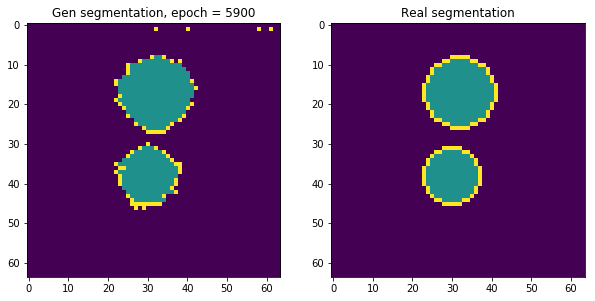

epoch - 5900, loss - 0.0243768170476
epoch - 5901, loss - 0.0234718285501
epoch - 5902, loss - 0.0243213251233
epoch - 5903, loss - 0.0236585773528
epoch - 5904, loss - 0.0226312018931
epoch - 5905, loss - 0.0226598680019
epoch - 5906, loss - 0.0219678338617
epoch - 5907, loss - 0.0213108882308
epoch - 5908, loss - 0.021459184587
epoch - 5909, loss - 0.0211941078305
epoch - 5910, loss - 0.0207819007337
epoch - 5911, loss - 0.0205968618393
epoch - 5912, loss - 0.0207592509687
epoch - 5913, loss - 0.0213309824467
epoch - 5914, loss - 0.0224980358034
epoch - 5915, loss - 0.0237576439977
epoch - 5916, loss - 0.0266776680946
epoch - 5917, loss - 0.0307473875582
epoch - 5918, loss - 0.0384017005563
epoch - 5919, loss - 0.0457548461854
epoch - 5920, loss - 0.0576602220535
epoch - 5921, loss - 0.065973252058
epoch - 5922, loss - 0.0771215185523
epoch - 5923, loss - 0.0855950564146
epoch - 5924, loss - 0.108640879393
epoch - 5925, loss - 0.137914896011
epoch - 5926, loss - 0.183578312397
epoch 

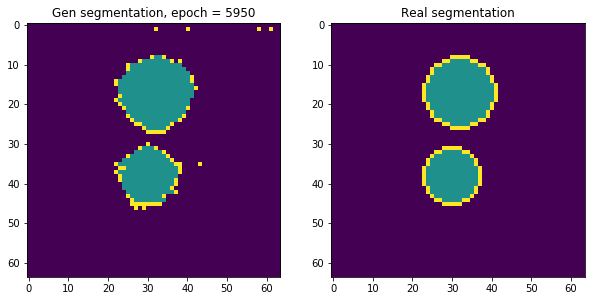

epoch - 5950, loss - 0.033216457814
epoch - 5951, loss - 0.0346323251724
epoch - 5952, loss - 0.0343247950077
epoch - 5953, loss - 0.031151752919
epoch - 5954, loss - 0.0305753797293
epoch - 5955, loss - 0.0297985635698
epoch - 5956, loss - 0.0280159711838
epoch - 5957, loss - 0.0262061059475
epoch - 5958, loss - 0.0263912864029
epoch - 5959, loss - 0.0260784961283
epoch - 5960, loss - 0.0246884264052
epoch - 5961, loss - 0.0247030667961
epoch - 5962, loss - 0.0246162600815
epoch - 5963, loss - 0.0238546468318
epoch - 5964, loss - 0.0232855379581
epoch - 5965, loss - 0.0230063144118
epoch - 5966, loss - 0.0227971933782
epoch - 5967, loss - 0.02236543037
epoch - 5968, loss - 0.0220699496567
epoch - 5969, loss - 0.0217999443412
epoch - 5970, loss - 0.0218246132135
epoch - 5971, loss - 0.0217612851411
epoch - 5972, loss - 0.0214828811586
epoch - 5973, loss - 0.0218035615981
epoch - 5974, loss - 0.0223416462541
epoch - 5975, loss - 0.0228412561119
epoch - 5976, loss - 0.0235713664442
epoch

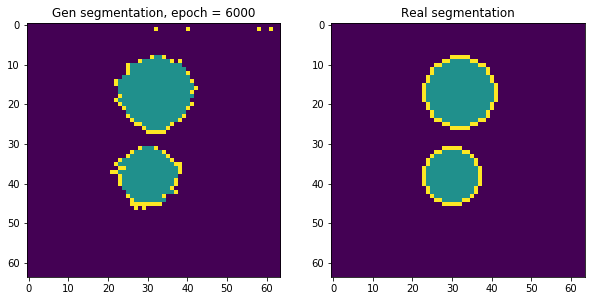

epoch - 6000, loss - 0.0465085357428
epoch - 6001, loss - 0.0419863983989
epoch - 6002, loss - 0.0343530848622
epoch - 6003, loss - 0.0330506265163
epoch - 6004, loss - 0.0335638634861
epoch - 6005, loss - 0.0301022231579
epoch - 6006, loss - 0.0315451174974
epoch - 6007, loss - 0.0328665189445
epoch - 6008, loss - 0.0279786400497
epoch - 6009, loss - 0.025374174118
epoch - 6010, loss - 0.026690274477
epoch - 6011, loss - 0.0268748141825
epoch - 6012, loss - 0.0254148542881
epoch - 6013, loss - 0.0260833725333
epoch - 6014, loss - 0.0258511882275
epoch - 6015, loss - 0.0233311634511
epoch - 6016, loss - 0.0217477418482
epoch - 6017, loss - 0.0223570093513
epoch - 6018, loss - 0.0221259556711
epoch - 6019, loss - 0.0214232243598
epoch - 6020, loss - 0.0219711735845
epoch - 6021, loss - 0.0218894667923
epoch - 6022, loss - 0.0213272199035
epoch - 6023, loss - 0.0210092402995
epoch - 6024, loss - 0.0207244381309
epoch - 6025, loss - 0.0201013088226
epoch - 6026, loss - 0.0194111615419
epo

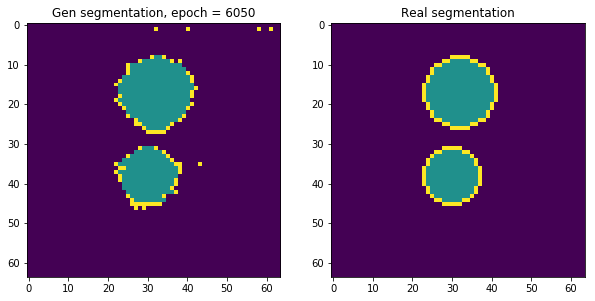

epoch - 6050, loss - 0.0891962870955
epoch - 6051, loss - 0.0597220249474
epoch - 6052, loss - 0.0558788105845
epoch - 6053, loss - 0.071115039289
epoch - 6054, loss - 0.0536542795599
epoch - 6055, loss - 0.0478198155761
epoch - 6056, loss - 0.0517133623362
epoch - 6057, loss - 0.0444598793983
epoch - 6058, loss - 0.0400097630918
epoch - 6059, loss - 0.0396137759089
epoch - 6060, loss - 0.0403799302876
epoch - 6061, loss - 0.0364334657788
epoch - 6062, loss - 0.0336078703403
epoch - 6063, loss - 0.0345151908696
epoch - 6064, loss - 0.0311821009964
epoch - 6065, loss - 0.029697643593
epoch - 6066, loss - 0.0291744917631
epoch - 6067, loss - 0.028093945235
epoch - 6068, loss - 0.0277249850333
epoch - 6069, loss - 0.0258784648031
epoch - 6070, loss - 0.0259617120028
epoch - 6071, loss - 0.0252370499074
epoch - 6072, loss - 0.0236027911305
epoch - 6073, loss - 0.0238743219525
epoch - 6074, loss - 0.0227703973651
epoch - 6075, loss - 0.0218325518072
epoch - 6076, loss - 0.0221759546548
epoc

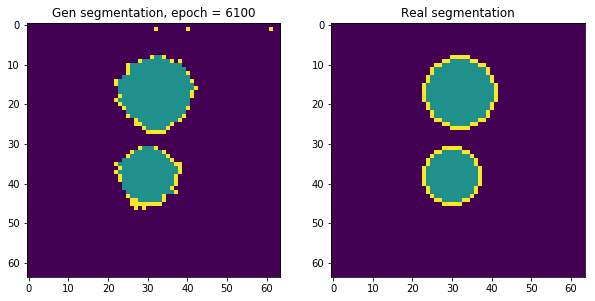

epoch - 6100, loss - 0.147740200162
epoch - 6101, loss - 0.119533374906
epoch - 6102, loss - 0.079646743834
epoch - 6103, loss - 0.0490030199289
epoch - 6104, loss - 0.0601260736585
epoch - 6105, loss - 0.0945902317762
epoch - 6106, loss - 0.0953636914492
epoch - 6107, loss - 0.0587196238339
epoch - 6108, loss - 0.0344043299556
epoch - 6109, loss - 0.0429190024734
epoch - 6110, loss - 0.0534057840705
epoch - 6111, loss - 0.0549818947911
epoch - 6112, loss - 0.051607709378
epoch - 6113, loss - 0.0377914495766
epoch - 6114, loss - 0.0289676710963
epoch - 6115, loss - 0.0328033864498
epoch - 6116, loss - 0.0376266501844
epoch - 6117, loss - 0.0361085347831
epoch - 6118, loss - 0.0327676311135
epoch - 6119, loss - 0.0299508422613
epoch - 6120, loss - 0.0265116505325
epoch - 6121, loss - 0.0241112820804
epoch - 6122, loss - 0.0262099374086
epoch - 6123, loss - 0.0287976842374
epoch - 6124, loss - 0.0265942029655
epoch - 6125, loss - 0.0240988917649
epoch - 6126, loss - 0.0233276560903
epoch

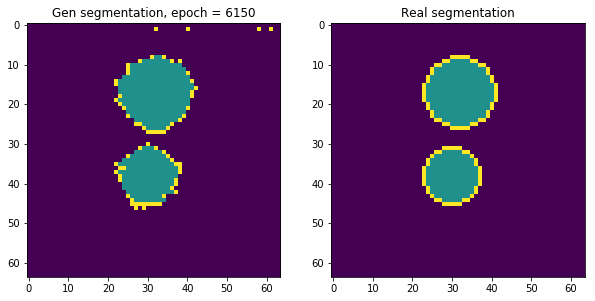

epoch - 6150, loss - 0.0230025686324
epoch - 6151, loss - 0.0226623639464
epoch - 6152, loss - 0.0222916938365
epoch - 6153, loss - 0.0224844515324
epoch - 6154, loss - 0.0231560729444
epoch - 6155, loss - 0.0253902561963
epoch - 6156, loss - 0.0272831693292
epoch - 6157, loss - 0.0314859449863
epoch - 6158, loss - 0.0346104055643
epoch - 6159, loss - 0.0389697961509
epoch - 6160, loss - 0.0401046089828
epoch - 6161, loss - 0.0422656610608
epoch - 6162, loss - 0.0494618527591
epoch - 6163, loss - 0.0677327364683
epoch - 6164, loss - 0.0936320275068
epoch - 6165, loss - 0.133870452642
epoch - 6166, loss - 0.171108171344
epoch - 6167, loss - 0.200300619006
epoch - 6168, loss - 0.191519230604
epoch - 6169, loss - 0.171682089567
epoch - 6170, loss - 0.128309369087
epoch - 6171, loss - 0.109214007854
epoch - 6172, loss - 0.0886982083321
epoch - 6173, loss - 0.0957709029317
epoch - 6174, loss - 0.0995750650764
epoch - 6175, loss - 0.082295447588
epoch - 6176, loss - 0.0711035355926
epoch - 6

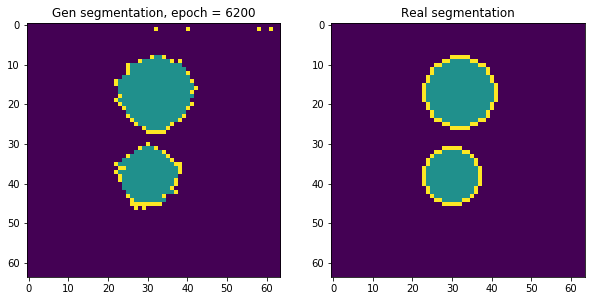

epoch - 6200, loss - 0.021762913093
epoch - 6201, loss - 0.0203432235867
epoch - 6202, loss - 0.0200306773186
epoch - 6203, loss - 0.019851192832
epoch - 6204, loss - 0.0193074755371
epoch - 6205, loss - 0.01921280846
epoch - 6206, loss - 0.0191202349961
epoch - 6207, loss - 0.0188476033509
epoch - 6208, loss - 0.0185053925961
epoch - 6209, loss - 0.0184601899236
epoch - 6210, loss - 0.0184319838881
epoch - 6211, loss - 0.0183106027544
epoch - 6212, loss - 0.0183193162084
epoch - 6213, loss - 0.01879885979
epoch - 6214, loss - 0.0193780586123
epoch - 6215, loss - 0.020351158455
epoch - 6216, loss - 0.0223108120263
epoch - 6217, loss - 0.0254876483232
epoch - 6218, loss - 0.030544411391
epoch - 6219, loss - 0.0366980358958
epoch - 6220, loss - 0.0445365384221
epoch - 6221, loss - 0.0487557947636
epoch - 6222, loss - 0.0490708872676
epoch - 6223, loss - 0.0455226302147
epoch - 6224, loss - 0.0441486276686
epoch - 6225, loss - 0.0497994981706
epoch - 6226, loss - 0.0554699674249
epoch - 6

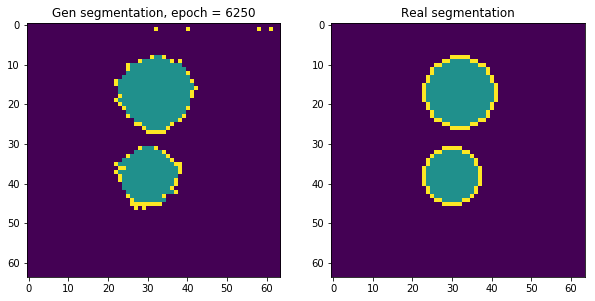

epoch - 6250, loss - 0.0260206963867
epoch - 6251, loss - 0.0261725746095
epoch - 6252, loss - 0.0275464393198
epoch - 6253, loss - 0.030514691025
epoch - 6254, loss - 0.0353966318071
epoch - 6255, loss - 0.0392955727875
epoch - 6256, loss - 0.047669544816
epoch - 6257, loss - 0.0557328611612
epoch - 6258, loss - 0.0703688189387
epoch - 6259, loss - 0.0824174806476
epoch - 6260, loss - 0.0955549404025
epoch - 6261, loss - 0.0969046354294
epoch - 6262, loss - 0.0899939239025
epoch - 6263, loss - 0.070111207664
epoch - 6264, loss - 0.0484542474151
epoch - 6265, loss - 0.0317669808865
epoch - 6266, loss - 0.0323724001646
epoch - 6267, loss - 0.0438310652971
epoch - 6268, loss - 0.0506132915616
epoch - 6269, loss - 0.0485053360462
epoch - 6270, loss - 0.0404204688966
epoch - 6271, loss - 0.0355395898223
epoch - 6272, loss - 0.0319418087602
epoch - 6273, loss - 0.0293953977525
epoch - 6274, loss - 0.0276597067714
epoch - 6275, loss - 0.0278349518776
epoch - 6276, loss - 0.0283903628588
epoc

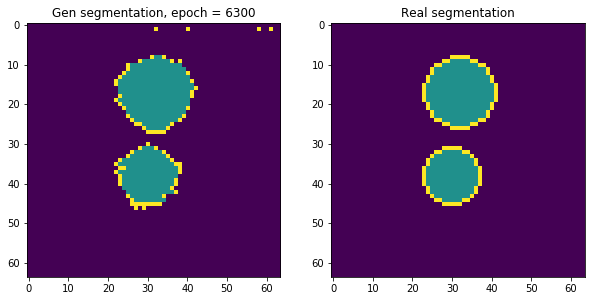

epoch - 6300, loss - 0.0312396474183
epoch - 6301, loss - 0.0369191691279
epoch - 6302, loss - 0.0433750003576
epoch - 6303, loss - 0.0541985780001
epoch - 6304, loss - 0.0689039379358
epoch - 6305, loss - 0.0906090661883
epoch - 6306, loss - 0.121301166713
epoch - 6307, loss - 0.140339493752
epoch - 6308, loss - 0.146366521716
epoch - 6309, loss - 0.124402813613
epoch - 6310, loss - 0.0942532494664
epoch - 6311, loss - 0.0751880928874
epoch - 6312, loss - 0.0635024532676
epoch - 6313, loss - 0.0678762272
epoch - 6314, loss - 0.0663505122066
epoch - 6315, loss - 0.0571632087231
epoch - 6316, loss - 0.053587153554
epoch - 6317, loss - 0.0503741204739
epoch - 6318, loss - 0.0438136234879
epoch - 6319, loss - 0.0398493409157
epoch - 6320, loss - 0.0389845520258
epoch - 6321, loss - 0.0361654087901
epoch - 6322, loss - 0.0320992656052
epoch - 6323, loss - 0.0316651239991
epoch - 6324, loss - 0.0333930365741
epoch - 6325, loss - 0.030724408105
epoch - 6326, loss - 0.0259699802846
epoch - 63

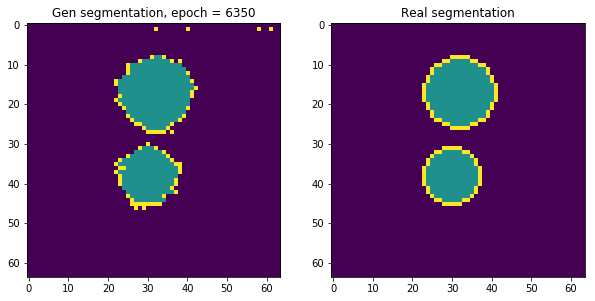

epoch - 6350, loss - 0.0827096402645
epoch - 6351, loss - 0.112417720258
epoch - 6352, loss - 0.13044705987
epoch - 6353, loss - 0.15241445601
epoch - 6354, loss - 0.144111603498
epoch - 6355, loss - 0.121572159231
epoch - 6356, loss - 0.0922470167279
epoch - 6357, loss - 0.0667504146695
epoch - 6358, loss - 0.0641816183925
epoch - 6359, loss - 0.0717580243945
epoch - 6360, loss - 0.0880603641272
epoch - 6361, loss - 0.0852071195841
epoch - 6362, loss - 0.0574393831193
epoch - 6363, loss - 0.0349684581161
epoch - 6364, loss - 0.0389441624284
epoch - 6365, loss - 0.0563413947821
epoch - 6366, loss - 0.0600481145084
epoch - 6367, loss - 0.0456308722496
epoch - 6368, loss - 0.0309847332537
epoch - 6369, loss - 0.0299890898168
epoch - 6370, loss - 0.0353143513203
epoch - 6371, loss - 0.0385556556284
epoch - 6372, loss - 0.0362266264856
epoch - 6373, loss - 0.0288947671652
epoch - 6374, loss - 0.0252319592983
epoch - 6375, loss - 0.0264886282384
epoch - 6376, loss - 0.0276476107538
epoch - 

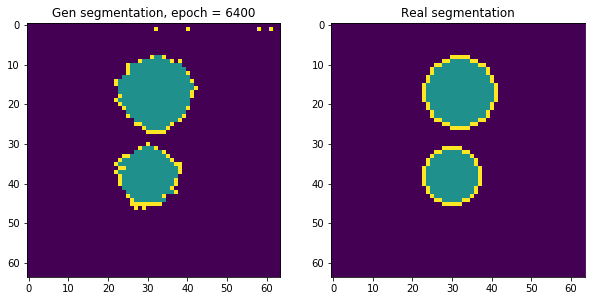

epoch - 6400, loss - 0.0190453138202
epoch - 6401, loss - 0.019298736006
epoch - 6402, loss - 0.0193213783205
epoch - 6403, loss - 0.020273886621
epoch - 6404, loss - 0.0214042980224
epoch - 6405, loss - 0.0224708467722
epoch - 6406, loss - 0.0247061718255
epoch - 6407, loss - 0.0284419320524
epoch - 6408, loss - 0.0343748368323
epoch - 6409, loss - 0.041059397161
epoch - 6410, loss - 0.0502937436104
epoch - 6411, loss - 0.0584901943803
epoch - 6412, loss - 0.0688048005104
epoch - 6413, loss - 0.0731059163809
epoch - 6414, loss - 0.0750190764666
epoch - 6415, loss - 0.0681226551533
epoch - 6416, loss - 0.0616057515144
epoch - 6417, loss - 0.0599844604731
epoch - 6418, loss - 0.083519436419
epoch - 6419, loss - 0.100947700441
epoch - 6420, loss - 0.099580809474
epoch - 6421, loss - 0.0790020674467
epoch - 6422, loss - 0.0743261426687
epoch - 6423, loss - 0.0948240384459
epoch - 6424, loss - 0.0756604969501
epoch - 6425, loss - 0.0512255877256
epoch - 6426, loss - 0.0579566955566
epoch -

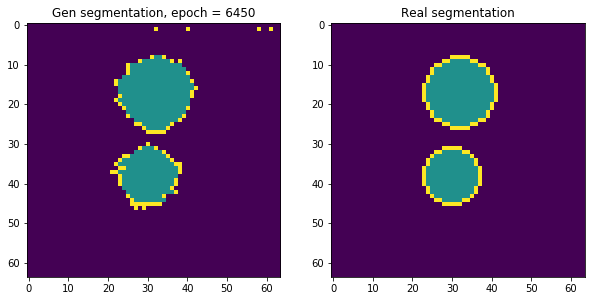

epoch - 6450, loss - 0.0178802814335
epoch - 6451, loss - 0.0180942714214
epoch - 6452, loss - 0.0183030832559
epoch - 6453, loss - 0.0186376422644
epoch - 6454, loss - 0.0201584137976
epoch - 6455, loss - 0.022261749953
epoch - 6456, loss - 0.0266425125301
epoch - 6457, loss - 0.0330998525023
epoch - 6458, loss - 0.0460690334439
epoch - 6459, loss - 0.0618372894824
epoch - 6460, loss - 0.093543164432
epoch - 6461, loss - 0.125637561083
epoch - 6462, loss - 0.182363450527
epoch - 6463, loss - 0.204032078385
epoch - 6464, loss - 0.217394173145
epoch - 6465, loss - 0.182748243213
epoch - 6466, loss - 0.139797404408
epoch - 6467, loss - 0.153595641255
epoch - 6468, loss - 0.129126116633
epoch - 6469, loss - 0.132114395499
epoch - 6470, loss - 0.132351979613
epoch - 6471, loss - 0.0877158045769
epoch - 6472, loss - 0.0669147148728
epoch - 6473, loss - 0.0784412175417
epoch - 6474, loss - 0.0893342867494
epoch - 6475, loss - 0.0801065266132
epoch - 6476, loss - 0.0515906251967
epoch - 6477,

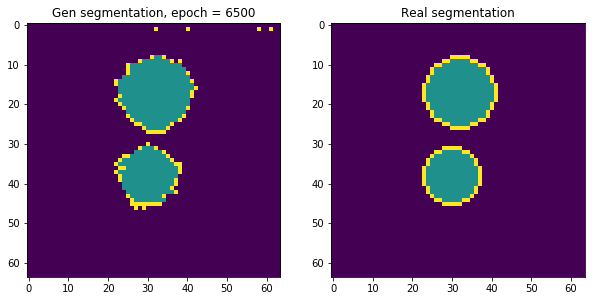

epoch - 6500, loss - 0.0196008086205
epoch - 6501, loss - 0.0190818607807
epoch - 6502, loss - 0.0190633907914
epoch - 6503, loss - 0.0183012951165
epoch - 6504, loss - 0.0176361463964
epoch - 6505, loss - 0.0173817537725
epoch - 6506, loss - 0.0169048905373
epoch - 6507, loss - 0.0166993681341
epoch - 6508, loss - 0.0167922452092
epoch - 6509, loss - 0.016551733017
epoch - 6510, loss - 0.0164550375193
epoch - 6511, loss - 0.01638642326
epoch - 6512, loss - 0.0161292180419
epoch - 6513, loss - 0.0159609429538
epoch - 6514, loss - 0.0157541763037
epoch - 6515, loss - 0.0156700313091
epoch - 6516, loss - 0.0155722098425
epoch - 6517, loss - 0.0155500490218
epoch - 6518, loss - 0.015682619065
epoch - 6519, loss - 0.0159416403621
epoch - 6520, loss - 0.0161322578788
epoch - 6521, loss - 0.01671570912
epoch - 6522, loss - 0.0170216672122
epoch - 6523, loss - 0.0175045039505
epoch - 6524, loss - 0.0175797045231
epoch - 6525, loss - 0.0175859704614
epoch - 6526, loss - 0.0171239711344
epoch -

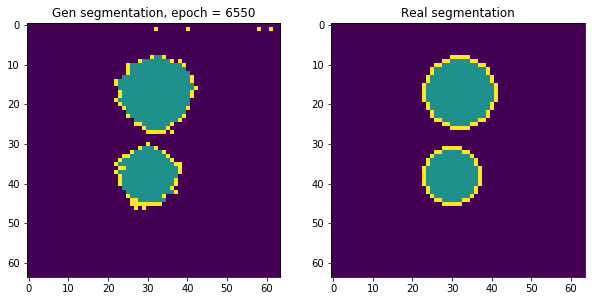

epoch - 6550, loss - 0.124747134745
epoch - 6551, loss - 0.0858936682343
epoch - 6552, loss - 0.0590084791183
epoch - 6553, loss - 0.0730026215315
epoch - 6554, loss - 0.078701660037
epoch - 6555, loss - 0.0584273524582
epoch - 6556, loss - 0.0603421293199
epoch - 6557, loss - 0.0608890093863
epoch - 6558, loss - 0.0414104573429
epoch - 6559, loss - 0.0356570109725
epoch - 6560, loss - 0.04520817101
epoch - 6561, loss - 0.043659478426
epoch - 6562, loss - 0.0368249565363
epoch - 6563, loss - 0.0356356650591
epoch - 6564, loss - 0.0320851802826
epoch - 6565, loss - 0.0270960368216
epoch - 6566, loss - 0.0300041288137
epoch - 6567, loss - 0.0292100459337
epoch - 6568, loss - 0.025620047003
epoch - 6569, loss - 0.0269580036402
epoch - 6570, loss - 0.0245800577104
epoch - 6571, loss - 0.0209974646568
epoch - 6572, loss - 0.0213652756065
epoch - 6573, loss - 0.0222084447742
epoch - 6574, loss - 0.0204623863101
epoch - 6575, loss - 0.0204451531172
epoch - 6576, loss - 0.0211355872452
epoch -

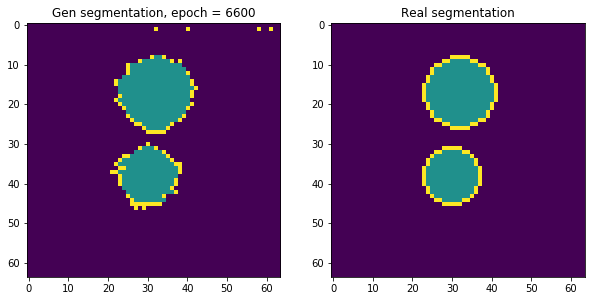

epoch - 6600, loss - 0.026387643069
epoch - 6601, loss - 0.0237223058939
epoch - 6602, loss - 0.0348479375243
epoch - 6603, loss - 0.0414861813188
epoch - 6604, loss - 0.0345785170794
epoch - 6605, loss - 0.0254515632987
epoch - 6606, loss - 0.0258965864778
epoch - 6607, loss - 0.0312747433782
epoch - 6608, loss - 0.0316833481193
epoch - 6609, loss - 0.0263506341726
epoch - 6610, loss - 0.0223517045379
epoch - 6611, loss - 0.0235104523599
epoch - 6612, loss - 0.0254344362766
epoch - 6613, loss - 0.0247125439346
epoch - 6614, loss - 0.0216247290373
epoch - 6615, loss - 0.0198027007282
epoch - 6616, loss - 0.0199717059731
epoch - 6617, loss - 0.0202446300536
epoch - 6618, loss - 0.0196115113795
epoch - 6619, loss - 0.0186905302107
epoch - 6620, loss - 0.017946979031
epoch - 6621, loss - 0.0174531340599
epoch - 6622, loss - 0.0173278301954
epoch - 6623, loss - 0.0173162333667
epoch - 6624, loss - 0.0171022508293
epoch - 6625, loss - 0.0169568583369
epoch - 6626, loss - 0.0165706072003
epo

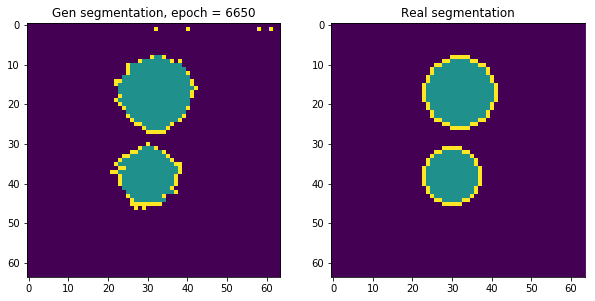

epoch - 6650, loss - 0.0712941810489
epoch - 6651, loss - 0.0542456842959
epoch - 6652, loss - 0.0495388545096
epoch - 6653, loss - 0.053847450763
epoch - 6654, loss - 0.0544210970402
epoch - 6655, loss - 0.0440545491874
epoch - 6656, loss - 0.0386888161302
epoch - 6657, loss - 0.0397326499224
epoch - 6658, loss - 0.0366915091872
epoch - 6659, loss - 0.0387390293181
epoch - 6660, loss - 0.0332861170173
epoch - 6661, loss - 0.0290113128722
epoch - 6662, loss - 0.030777040869
epoch - 6663, loss - 0.0286834146827
epoch - 6664, loss - 0.028094291687
epoch - 6665, loss - 0.0267111565918
epoch - 6666, loss - 0.0246433541179
epoch - 6667, loss - 0.0231380239129
epoch - 6668, loss - 0.0230792891234
epoch - 6669, loss - 0.0226551257074
epoch - 6670, loss - 0.0216162577271
epoch - 6671, loss - 0.0208683181554
epoch - 6672, loss - 0.0196399614215
epoch - 6673, loss - 0.0191273242235
epoch - 6674, loss - 0.0190435871482
epoch - 6675, loss - 0.01873543486
epoch - 6676, loss - 0.0181243941188
epoch 

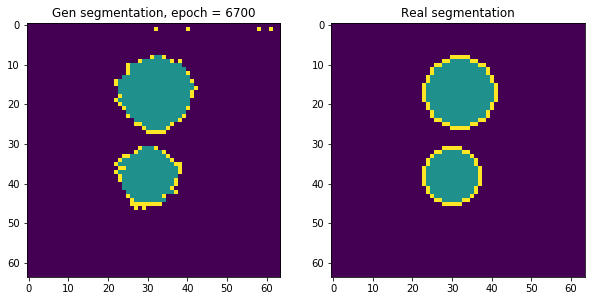

epoch - 6700, loss - 0.0347899645567
epoch - 6701, loss - 0.0238818060607
epoch - 6702, loss - 0.0238256268203
epoch - 6703, loss - 0.0301293171942
epoch - 6704, loss - 0.0337494760752
epoch - 6705, loss - 0.0282900854945
epoch - 6706, loss - 0.0220341961831
epoch - 6707, loss - 0.0221344828606
epoch - 6708, loss - 0.0256804190576
epoch - 6709, loss - 0.026909051463
epoch - 6710, loss - 0.0236843246967
epoch - 6711, loss - 0.0197574589401
epoch - 6712, loss - 0.0196483545005
epoch - 6713, loss - 0.0216898173094
epoch - 6714, loss - 0.0221085753292
epoch - 6715, loss - 0.0199612826109
epoch - 6716, loss - 0.0180452093482
epoch - 6717, loss - 0.0182611532509
epoch - 6718, loss - 0.0190345011652
epoch - 6719, loss - 0.0196102261543
epoch - 6720, loss - 0.0192555617541
epoch - 6721, loss - 0.0188508778811
epoch - 6722, loss - 0.0186662599444
epoch - 6723, loss - 0.0188782438636
epoch - 6724, loss - 0.0199499819428
epoch - 6725, loss - 0.0211707130075
epoch - 6726, loss - 0.0225228592753
ep

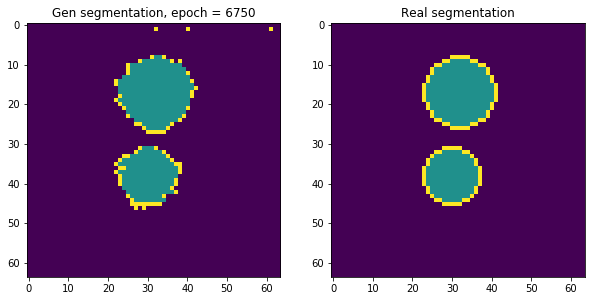

epoch - 6750, loss - 0.0300070028752
epoch - 6751, loss - 0.0291626565158
epoch - 6752, loss - 0.0297382287681
epoch - 6753, loss - 0.0273761898279
epoch - 6754, loss - 0.0228788461536
epoch - 6755, loss - 0.0215157140046
epoch - 6756, loss - 0.0219228491187
epoch - 6757, loss - 0.021343588829
epoch - 6758, loss - 0.0207198448479
epoch - 6759, loss - 0.0197588093579
epoch - 6760, loss - 0.0187325365841
epoch - 6761, loss - 0.019057739526
epoch - 6762, loss - 0.0186250731349
epoch - 6763, loss - 0.0175898894668
epoch - 6764, loss - 0.0170804001391
epoch - 6765, loss - 0.0168608948588
epoch - 6766, loss - 0.0161497127265
epoch - 6767, loss - 0.0154425539076
epoch - 6768, loss - 0.0154847241938
epoch - 6769, loss - 0.0154693899676
epoch - 6770, loss - 0.0149820074439
epoch - 6771, loss - 0.0146612394601
epoch - 6772, loss - 0.0146419638768
epoch - 6773, loss - 0.0145452953875
epoch - 6774, loss - 0.0145892575383
epoch - 6775, loss - 0.0150990569964
epoch - 6776, loss - 0.0162469185889
epo

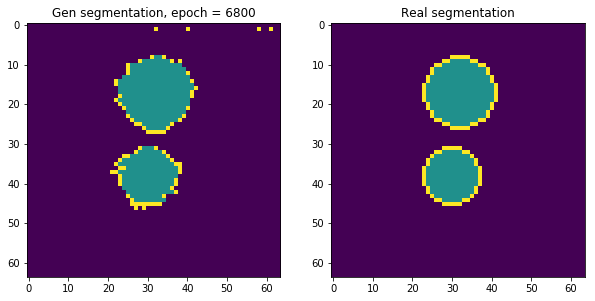

epoch - 6800, loss - 0.0354316979647
epoch - 6801, loss - 0.028882343322
epoch - 6802, loss - 0.0352027453482
epoch - 6803, loss - 0.0334725528955
epoch - 6804, loss - 0.0253256745636
epoch - 6805, loss - 0.0258245933801
epoch - 6806, loss - 0.027236327529
epoch - 6807, loss - 0.0231669396162
epoch - 6808, loss - 0.0217102020979
epoch - 6809, loss - 0.0227116979659
epoch - 6810, loss - 0.0215699411929
epoch - 6811, loss - 0.0199635457247
epoch - 6812, loss - 0.0200709067285
epoch - 6813, loss - 0.0195891931653
epoch - 6814, loss - 0.01822302863
epoch - 6815, loss - 0.0179195795208
epoch - 6816, loss - 0.0175335630774
epoch - 6817, loss - 0.0167611278594
epoch - 6818, loss - 0.0163499601185
epoch - 6819, loss - 0.0159527864307
epoch - 6820, loss - 0.0154053913429
epoch - 6821, loss - 0.01519177109
epoch - 6822, loss - 0.0150107536465
epoch - 6823, loss - 0.0147217493504
epoch - 6824, loss - 0.0145785054192
epoch - 6825, loss - 0.0144740305841
epoch - 6826, loss - 0.0144051620737
epoch -

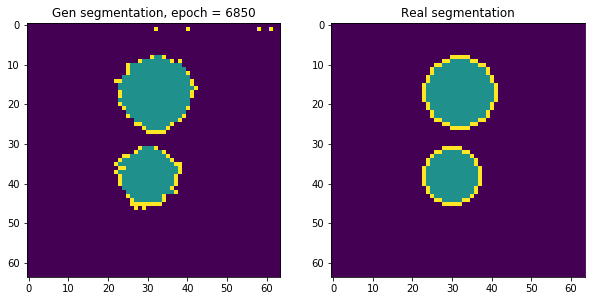

epoch - 6850, loss - 0.0779155641794
epoch - 6851, loss - 0.0466008223593
epoch - 6852, loss - 0.0451162084937
epoch - 6853, loss - 0.0554423741996
epoch - 6854, loss - 0.0556290447712
epoch - 6855, loss - 0.0488856732845
epoch - 6856, loss - 0.0408098623157
epoch - 6857, loss - 0.0405763164163
epoch - 6858, loss - 0.0364254303277
epoch - 6859, loss - 0.0272999815643
epoch - 6860, loss - 0.0304979998618
epoch - 6861, loss - 0.0357170924544
epoch - 6862, loss - 0.0305297914892
epoch - 6863, loss - 0.0242474079132
epoch - 6864, loss - 0.0229026414454
epoch - 6865, loss - 0.0236183349043
epoch - 6866, loss - 0.0226641669869
epoch - 6867, loss - 0.0206087399274
epoch - 6868, loss - 0.0213608257473
epoch - 6869, loss - 0.0222533456981
epoch - 6870, loss - 0.0195409413427
epoch - 6871, loss - 0.0173189435154
epoch - 6872, loss - 0.0172976385802
epoch - 6873, loss - 0.0175654999912
epoch - 6874, loss - 0.0167855583131
epoch - 6875, loss - 0.0160913728178
epoch - 6876, loss - 0.016248492524
ep

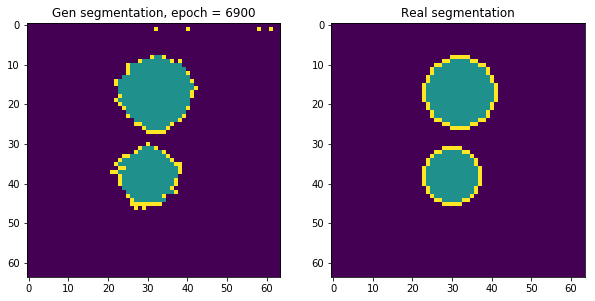

epoch - 6900, loss - 0.0199375934899
epoch - 6901, loss - 0.025209615007
epoch - 6902, loss - 0.0333034992218
epoch - 6903, loss - 0.0447246991098
epoch - 6904, loss - 0.0589380711317
epoch - 6905, loss - 0.0804420933127
epoch - 6906, loss - 0.0961710289121
epoch - 6907, loss - 0.121698513627
epoch - 6908, loss - 0.125707790256
epoch - 6909, loss - 0.134942144156
epoch - 6910, loss - 0.124961726367
epoch - 6911, loss - 0.123430855572
epoch - 6912, loss - 0.0851286873221
epoch - 6913, loss - 0.0496210716665
epoch - 6914, loss - 0.0609910711646
epoch - 6915, loss - 0.0818430110812
epoch - 6916, loss - 0.0677748769522
epoch - 6917, loss - 0.0424272231758
epoch - 6918, loss - 0.0465869903564
epoch - 6919, loss - 0.0509723052382
epoch - 6920, loss - 0.0361848175526
epoch - 6921, loss - 0.0326155945659
epoch - 6922, loss - 0.0415917187929
epoch - 6923, loss - 0.0370778888464
epoch - 6924, loss - 0.0271119512618
epoch - 6925, loss - 0.0271372795105
epoch - 6926, loss - 0.0290410630405
epoch -

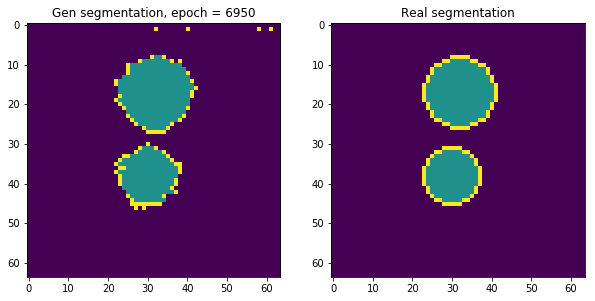

epoch - 6950, loss - 0.0155943799764
epoch - 6951, loss - 0.0154503118247
epoch - 6952, loss - 0.015267140232
epoch - 6953, loss - 0.0154986325651
epoch - 6954, loss - 0.0164573546499
epoch - 6955, loss - 0.0177365206182
epoch - 6956, loss - 0.020496815443
epoch - 6957, loss - 0.0239800326526
epoch - 6958, loss - 0.0304326154292
epoch - 6959, loss - 0.0364613831043
epoch - 6960, loss - 0.0462502352893
epoch - 6961, loss - 0.0520679950714
epoch - 6962, loss - 0.0581010058522
epoch - 6963, loss - 0.0690616369247
epoch - 6964, loss - 0.0885388627648
epoch - 6965, loss - 0.129184231162
epoch - 6966, loss - 0.143307223916
epoch - 6967, loss - 0.145429983735
epoch - 6968, loss - 0.100312404335
epoch - 6969, loss - 0.0551863312721
epoch - 6970, loss - 0.0490368157625
epoch - 6971, loss - 0.0612062700093
epoch - 6972, loss - 0.0698126852512
epoch - 6973, loss - 0.0574552491307
epoch - 6974, loss - 0.0485417358577
epoch - 6975, loss - 0.0521583482623
epoch - 6976, loss - 0.0452848896384
epoch -

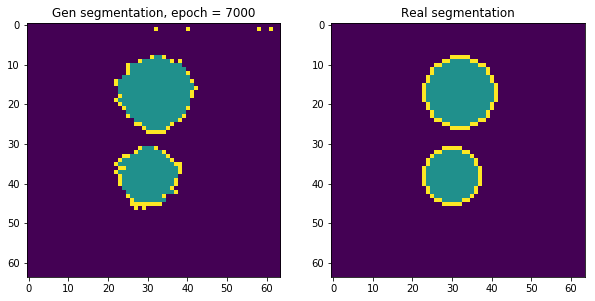

epoch - 7000, loss - 0.0155297713354
epoch - 7001, loss - 0.0148448655382
epoch - 7002, loss - 0.0142194721848
epoch - 7003, loss - 0.0149640999734
epoch - 7004, loss - 0.0156418066472
epoch - 7005, loss - 0.0157462675124
epoch - 7006, loss - 0.0167161207646
epoch - 7007, loss - 0.0184175744653
epoch - 7008, loss - 0.020955434069
epoch - 7009, loss - 0.024755647406
epoch - 7010, loss - 0.0302963405848
epoch - 7011, loss - 0.0381764806807
epoch - 7012, loss - 0.0481910631061
epoch - 7013, loss - 0.0594948269427
epoch - 7014, loss - 0.0756539702415
epoch - 7015, loss - 0.0856522917747
epoch - 7016, loss - 0.101678095758
epoch - 7017, loss - 0.0989299118519
epoch - 7018, loss - 0.0875191092491
epoch - 7019, loss - 0.0620267465711
epoch - 7020, loss - 0.0460691936314
epoch - 7021, loss - 0.0398912206292
epoch - 7022, loss - 0.042983520776
epoch - 7023, loss - 0.0504305139184
epoch - 7024, loss - 0.0534571893513
epoch - 7025, loss - 0.0473938509822
epoch - 7026, loss - 0.0359180346131
epoch

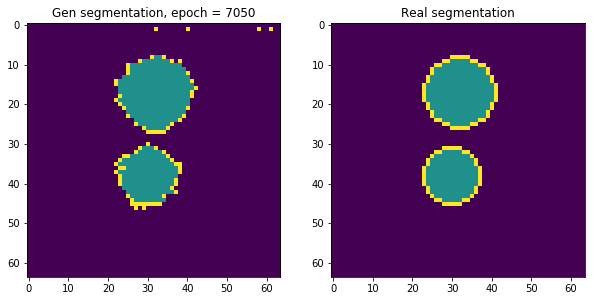

epoch - 7050, loss - 0.0140234492719
epoch - 7051, loss - 0.0141172651201
epoch - 7052, loss - 0.0137579357252
epoch - 7053, loss - 0.0135701224208
epoch - 7054, loss - 0.0140181742609
epoch - 7055, loss - 0.0148244481534
epoch - 7056, loss - 0.0159598719329
epoch - 7057, loss - 0.0183278415352
epoch - 7058, loss - 0.0228365771472
epoch - 7059, loss - 0.0302557703108
epoch - 7060, loss - 0.0432540513575
epoch - 7061, loss - 0.0624652355909
epoch - 7062, loss - 0.0890175849199
epoch - 7063, loss - 0.12241268158
epoch - 7064, loss - 0.148196220398
epoch - 7065, loss - 0.161580845714
epoch - 7066, loss - 0.141155913472
epoch - 7067, loss - 0.127594307065
epoch - 7068, loss - 0.107108213007
epoch - 7069, loss - 0.107339568436
epoch - 7070, loss - 0.0757953450084
epoch - 7071, loss - 0.0567838735878
epoch - 7072, loss - 0.076263859868
epoch - 7073, loss - 0.0771702677011
epoch - 7074, loss - 0.0575221627951
epoch - 7075, loss - 0.0410080850124
epoch - 7076, loss - 0.0428705811501
epoch - 70

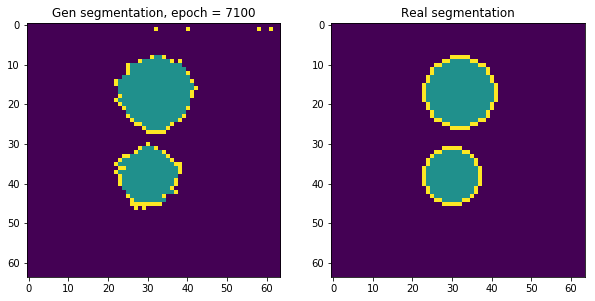

epoch - 7100, loss - 0.0145431514829
epoch - 7101, loss - 0.0140569508076
epoch - 7102, loss - 0.0139152035117
epoch - 7103, loss - 0.0138351526111
epoch - 7104, loss - 0.013552678749
epoch - 7105, loss - 0.0136859938502
epoch - 7106, loss - 0.0138329062611
epoch - 7107, loss - 0.0139019936323
epoch - 7108, loss - 0.0144163556397
epoch - 7109, loss - 0.0148569410667
epoch - 7110, loss - 0.015529833734
epoch - 7111, loss - 0.0163672808558
epoch - 7112, loss - 0.0173877608031
epoch - 7113, loss - 0.0184894539416
epoch - 7114, loss - 0.0204898063093
epoch - 7115, loss - 0.0234336424619
epoch - 7116, loss - 0.0276680774987
epoch - 7117, loss - 0.034568272531
epoch - 7118, loss - 0.0426254086196
epoch - 7119, loss - 0.0552167408168
epoch - 7120, loss - 0.065476603806
epoch - 7121, loss - 0.077258490026
epoch - 7122, loss - 0.0760491341352
epoch - 7123, loss - 0.0697530135512
epoch - 7124, loss - 0.0545568875968
epoch - 7125, loss - 0.0413824319839
epoch - 7126, loss - 0.0358175039291
epoch 

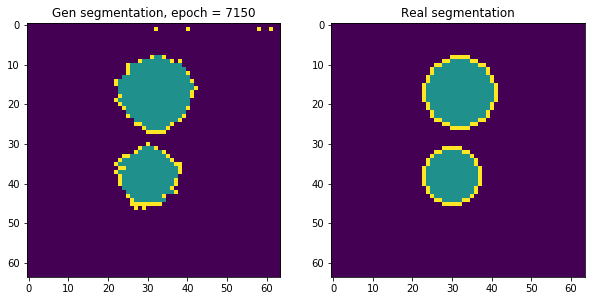

epoch - 7150, loss - 0.0161294993013
epoch - 7151, loss - 0.0182014312595
epoch - 7152, loss - 0.0194335728884
epoch - 7153, loss - 0.0204302091151
epoch - 7154, loss - 0.0234373454005
epoch - 7155, loss - 0.0289870947599
epoch - 7156, loss - 0.0366103947163
epoch - 7157, loss - 0.0469287931919
epoch - 7158, loss - 0.058588989079
epoch - 7159, loss - 0.0768564864993
epoch - 7160, loss - 0.089278422296
epoch - 7161, loss - 0.102543689311
epoch - 7162, loss - 0.0977685153484
epoch - 7163, loss - 0.0858604088426
epoch - 7164, loss - 0.0652838423848
epoch - 7165, loss - 0.0485732629895
epoch - 7166, loss - 0.0338918119669
epoch - 7167, loss - 0.0349586606026
epoch - 7168, loss - 0.0480171106756
epoch - 7169, loss - 0.0578287951648
epoch - 7170, loss - 0.0513698905706
epoch - 7171, loss - 0.0401959940791
epoch - 7172, loss - 0.03472366184
epoch - 7173, loss - 0.0276044141501
epoch - 7174, loss - 0.0233523864299
epoch - 7175, loss - 0.0274411551654
epoch - 7176, loss - 0.0323398187757
epoch 

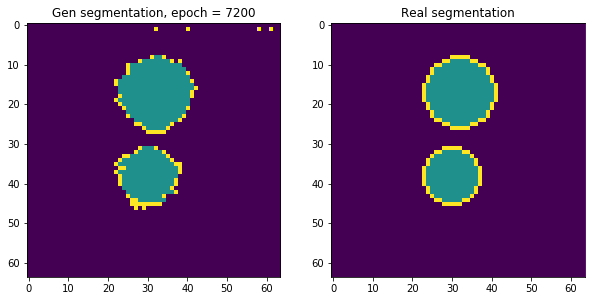

epoch - 7200, loss - 0.0159920696169
epoch - 7201, loss - 0.0159499123693
epoch - 7202, loss - 0.0159388724715
epoch - 7203, loss - 0.0165312923491
epoch - 7204, loss - 0.0184006728232
epoch - 7205, loss - 0.0211854986846
epoch - 7206, loss - 0.0266633443534
epoch - 7207, loss - 0.0341198928654
epoch - 7208, loss - 0.046032782644
epoch - 7209, loss - 0.0585067719221
epoch - 7210, loss - 0.0765458866954
epoch - 7211, loss - 0.0911851301789
epoch - 7212, loss - 0.10764195025
epoch - 7213, loss - 0.111206144094
epoch - 7214, loss - 0.106866762042
epoch - 7215, loss - 0.102034948766
epoch - 7216, loss - 0.0965811908245
epoch - 7217, loss - 0.0914234817028
epoch - 7218, loss - 0.0763714015484
epoch - 7219, loss - 0.0674108490348
epoch - 7220, loss - 0.0781517326832
epoch - 7221, loss - 0.0710726603866
epoch - 7222, loss - 0.0518200322986
epoch - 7223, loss - 0.045455802232
epoch - 7224, loss - 0.0420609116554
epoch - 7225, loss - 0.0352666154504
epoch - 7226, loss - 0.0354258641601
epoch - 

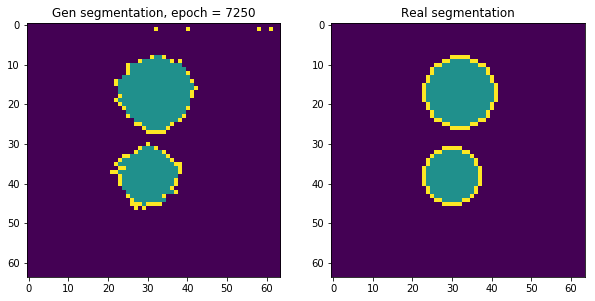

epoch - 7250, loss - 0.0150118358433
epoch - 7251, loss - 0.0153960585594
epoch - 7252, loss - 0.0157742071897
epoch - 7253, loss - 0.0160068478435
epoch - 7254, loss - 0.0165957249701
epoch - 7255, loss - 0.0158829912543
epoch - 7256, loss - 0.0155018288642
epoch - 7257, loss - 0.0147008523345
epoch - 7258, loss - 0.0135269416496
epoch - 7259, loss - 0.0126566644758
epoch - 7260, loss - 0.0127144353464
epoch - 7261, loss - 0.013395392336
epoch - 7262, loss - 0.0146497189999
epoch - 7263, loss - 0.0172193553299
epoch - 7264, loss - 0.0198512598872
epoch - 7265, loss - 0.0239289700985
epoch - 7266, loss - 0.0274775344878
epoch - 7267, loss - 0.0341824218631
epoch - 7268, loss - 0.0409912317991
epoch - 7269, loss - 0.0557359978557
epoch - 7270, loss - 0.0769618749619
epoch - 7271, loss - 0.118368126452
epoch - 7272, loss - 0.172852411866
epoch - 7273, loss - 0.237171053886
epoch - 7274, loss - 0.283200383186
epoch - 7275, loss - 0.208000212908
epoch - 7276, loss - 0.117392890155
epoch - 

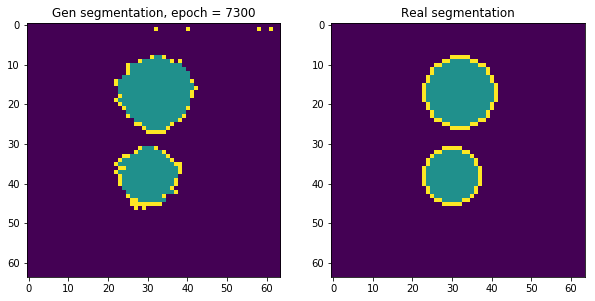

epoch - 7300, loss - 0.0222510583699
epoch - 7301, loss - 0.0228506475687
epoch - 7302, loss - 0.0221766605973
epoch - 7303, loss - 0.0196152944118
epoch - 7304, loss - 0.0191809572279
epoch - 7305, loss - 0.0171367265284
epoch - 7306, loss - 0.0177925080061
epoch - 7307, loss - 0.0169371813536
epoch - 7308, loss - 0.0170147046447
epoch - 7309, loss - 0.0166761763394
epoch - 7310, loss - 0.0156241357327
epoch - 7311, loss - 0.0151412412524
epoch - 7312, loss - 0.0143570955843
epoch - 7313, loss - 0.0139958839864
epoch - 7314, loss - 0.0138084441423
epoch - 7315, loss - 0.0137354023755
epoch - 7316, loss - 0.0137959411368
epoch - 7317, loss - 0.0139646464959
epoch - 7318, loss - 0.0140605475754
epoch - 7319, loss - 0.014320647344
epoch - 7320, loss - 0.014970141463
epoch - 7321, loss - 0.0154925715178
epoch - 7322, loss - 0.0164880827069
epoch - 7323, loss - 0.017410075292
epoch - 7324, loss - 0.0182017143816
epoch - 7325, loss - 0.018135657534
epoch - 7326, loss - 0.0173342041671
epoch

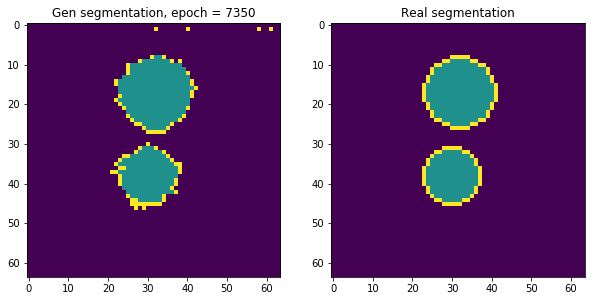

epoch - 7350, loss - 0.0603738129139
epoch - 7351, loss - 0.0593417361379
epoch - 7352, loss - 0.0482918173075
epoch - 7353, loss - 0.0426434278488
epoch - 7354, loss - 0.0425327830017
epoch - 7355, loss - 0.0439592786133
epoch - 7356, loss - 0.0375689305365
epoch - 7357, loss - 0.0284850411117
epoch - 7358, loss - 0.0292971171439
epoch - 7359, loss - 0.0317564755678
epoch - 7360, loss - 0.0272384192795
epoch - 7361, loss - 0.0233341269195
epoch - 7362, loss - 0.025522807613
epoch - 7363, loss - 0.0250948406756
epoch - 7364, loss - 0.0212722923607
epoch - 7365, loss - 0.0213765203953
epoch - 7366, loss - 0.0224373750389
epoch - 7367, loss - 0.0191475786269
epoch - 7368, loss - 0.0162795335054
epoch - 7369, loss - 0.0189343001693
epoch - 7370, loss - 0.0201670415699
epoch - 7371, loss - 0.0160852540284
epoch - 7372, loss - 0.015208914876
epoch - 7373, loss - 0.0177882798016
epoch - 7374, loss - 0.0172558054328
epoch - 7375, loss - 0.0155368689448
epoch - 7376, loss - 0.0166641213
epoch 

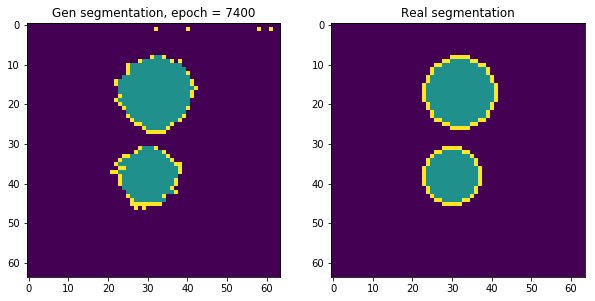

epoch - 7400, loss - 0.0179267264903
epoch - 7401, loss - 0.0147899966687
epoch - 7402, loss - 0.0195094943047
epoch - 7403, loss - 0.0243435800076
epoch - 7404, loss - 0.0261094402522
epoch - 7405, loss - 0.0240646935999
epoch - 7406, loss - 0.0218258462846
epoch - 7407, loss - 0.0183546990156
epoch - 7408, loss - 0.0163321271539
epoch - 7409, loss - 0.0170178040862
epoch - 7410, loss - 0.017847487703
epoch - 7411, loss - 0.0177248809487
epoch - 7412, loss - 0.0166506934911
epoch - 7413, loss - 0.016511157155
epoch - 7414, loss - 0.0164647195488
epoch - 7415, loss - 0.0160229299217
epoch - 7416, loss - 0.0154638756067
epoch - 7417, loss - 0.0154570695013
epoch - 7418, loss - 0.0154680218548
epoch - 7419, loss - 0.0143996458501
epoch - 7420, loss - 0.0131147168577
epoch - 7421, loss - 0.0132548147812
epoch - 7422, loss - 0.014522023499
epoch - 7423, loss - 0.0155186606571
epoch - 7424, loss - 0.0156417712569
epoch - 7425, loss - 0.0160421021283
epoch - 7426, loss - 0.0158550199121
epoc

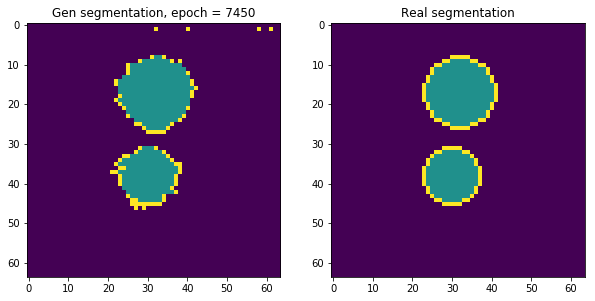

epoch - 7450, loss - 0.0545112863183
epoch - 7451, loss - 0.0441754311323
epoch - 7452, loss - 0.0415019281209
epoch - 7453, loss - 0.0372828878462
epoch - 7454, loss - 0.032655775547
epoch - 7455, loss - 0.037691693753
epoch - 7456, loss - 0.0323342978954
epoch - 7457, loss - 0.0298178773373
epoch - 7458, loss - 0.0304518956691
epoch - 7459, loss - 0.0246269907802
epoch - 7460, loss - 0.0231148935854
epoch - 7461, loss - 0.024769384414
epoch - 7462, loss - 0.022725250572
epoch - 7463, loss - 0.0220800638199
epoch - 7464, loss - 0.0207874290645
epoch - 7465, loss - 0.0188675560057
epoch - 7466, loss - 0.0181819684803
epoch - 7467, loss - 0.017458839342
epoch - 7468, loss - 0.0166144538671
epoch - 7469, loss - 0.0163322556764
epoch - 7470, loss - 0.0161090679467
epoch - 7471, loss - 0.0156454257667
epoch - 7472, loss - 0.0149220861495
epoch - 7473, loss - 0.0144381355494
epoch - 7474, loss - 0.0141796600074
epoch - 7475, loss - 0.0133018726483
epoch - 7476, loss - 0.0132649112493
epoch 

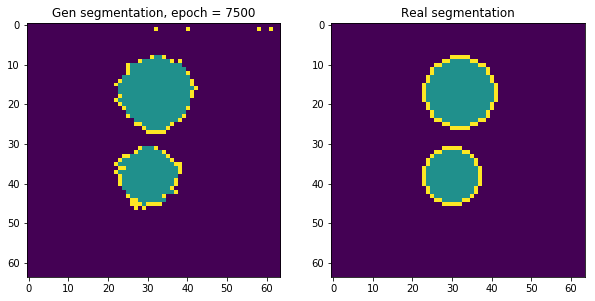

epoch - 7500, loss - 0.0458336621523
epoch - 7501, loss - 0.0510730519891
epoch - 7502, loss - 0.0601993836462
epoch - 7503, loss - 0.063896112144
epoch - 7504, loss - 0.0678222551942
epoch - 7505, loss - 0.0592438913882
epoch - 7506, loss - 0.0474673174322
epoch - 7507, loss - 0.0337623134255
epoch - 7508, loss - 0.027728818357
epoch - 7509, loss - 0.0325489453971
epoch - 7510, loss - 0.037943765521
epoch - 7511, loss - 0.0407155454159
epoch - 7512, loss - 0.0359694547951
epoch - 7513, loss - 0.031981870532
epoch - 7514, loss - 0.0296464618295
epoch - 7515, loss - 0.0279074795544
epoch - 7516, loss - 0.0260953344405
epoch - 7517, loss - 0.0230779238045
epoch - 7518, loss - 0.0233233831823
epoch - 7519, loss - 0.0232094600797
epoch - 7520, loss - 0.0193131603301
epoch - 7521, loss - 0.0164024252445
epoch - 7522, loss - 0.0176713615656
epoch - 7523, loss - 0.0195529852062
epoch - 7524, loss - 0.0174084138125
epoch - 7525, loss - 0.0139108411968
epoch - 7526, loss - 0.0150005966425
epoch

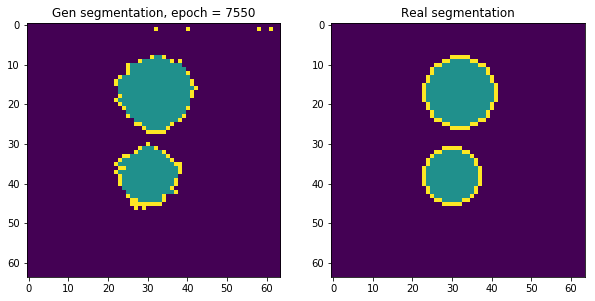

epoch - 7550, loss - 0.0230860970914
epoch - 7551, loss - 0.0246862582862
epoch - 7552, loss - 0.0300479717553
epoch - 7553, loss - 0.0357213914394
epoch - 7554, loss - 0.0363038405776
epoch - 7555, loss - 0.0335357747972
epoch - 7556, loss - 0.0285848900676
epoch - 7557, loss - 0.0236198287457
epoch - 7558, loss - 0.0161241665483
epoch - 7559, loss - 0.0126048056409
epoch - 7560, loss - 0.015625545755
epoch - 7561, loss - 0.019830301404
epoch - 7562, loss - 0.0225290991366
epoch - 7563, loss - 0.0229230877012
epoch - 7564, loss - 0.0222223624587
epoch - 7565, loss - 0.0200255680829
epoch - 7566, loss - 0.0177597310394
epoch - 7567, loss - 0.0159663427621
epoch - 7568, loss - 0.0148719698191
epoch - 7569, loss - 0.0147922541946
epoch - 7570, loss - 0.0148648042232
epoch - 7571, loss - 0.0139485783875
epoch - 7572, loss - 0.0127275213599
epoch - 7573, loss - 0.012548584491
epoch - 7574, loss - 0.0128660555929
epoch - 7575, loss - 0.0128629617393
epoch - 7576, loss - 0.0126717165112
epoc

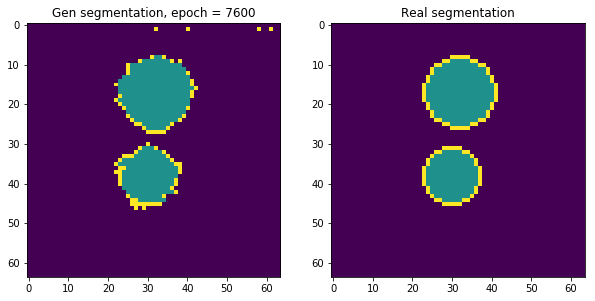

epoch - 7600, loss - 0.0383985750377
epoch - 7601, loss - 0.0332226753235
epoch - 7602, loss - 0.0304979030043
epoch - 7603, loss - 0.0297134164721
epoch - 7604, loss - 0.0244890339673
epoch - 7605, loss - 0.0235399585217
epoch - 7606, loss - 0.0231430549175
epoch - 7607, loss - 0.0200046692044
epoch - 7608, loss - 0.0197769142687
epoch - 7609, loss - 0.0199038051069
epoch - 7610, loss - 0.0186628513038
epoch - 7611, loss - 0.0176780596375
epoch - 7612, loss - 0.0157404784113
epoch - 7613, loss - 0.0156358946115
epoch - 7614, loss - 0.0157978255302
epoch - 7615, loss - 0.0147744975984
epoch - 7616, loss - 0.0137178115547
epoch - 7617, loss - 0.0139780249447
epoch - 7618, loss - 0.0146542564034
epoch - 7619, loss - 0.0143001712859
epoch - 7620, loss - 0.0145080313087
epoch - 7621, loss - 0.0155794825405
epoch - 7622, loss - 0.0162529163063
epoch - 7623, loss - 0.01720572263
epoch - 7624, loss - 0.0186724811792
epoch - 7625, loss - 0.0202909912914
epoch - 7626, loss - 0.0221959762275
epo

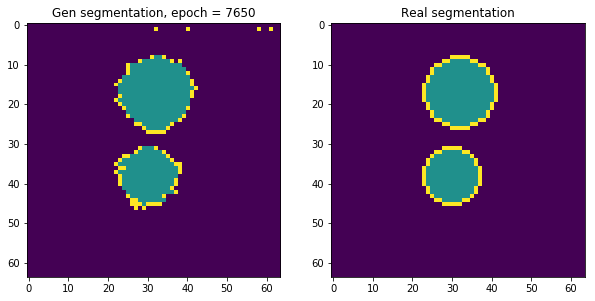

epoch - 7650, loss - 0.0164749808609
epoch - 7651, loss - 0.016584534198
epoch - 7652, loss - 0.0198701396585
epoch - 7653, loss - 0.0214277952909
epoch - 7654, loss - 0.0195775348693
epoch - 7655, loss - 0.016685700044
epoch - 7656, loss - 0.0166556145996
epoch - 7657, loss - 0.0180252827704
epoch - 7658, loss - 0.0191880092025
epoch - 7659, loss - 0.0186472889036
epoch - 7660, loss - 0.0175255369395
epoch - 7661, loss - 0.0176598951221
epoch - 7662, loss - 0.0190328303725
epoch - 7663, loss - 0.0203224979341
epoch - 7664, loss - 0.0202658381313
epoch - 7665, loss - 0.0216411575675
epoch - 7666, loss - 0.0261721629649
epoch - 7667, loss - 0.0327857062221
epoch - 7668, loss - 0.0422126315534
epoch - 7669, loss - 0.050422616303
epoch - 7670, loss - 0.0565257482231
epoch - 7671, loss - 0.0619181320071
epoch - 7672, loss - 0.0648657530546
epoch - 7673, loss - 0.0703915804625
epoch - 7674, loss - 0.0685708299279
epoch - 7675, loss - 0.0627505257726
epoch - 7676, loss - 0.0461226031184
epoc

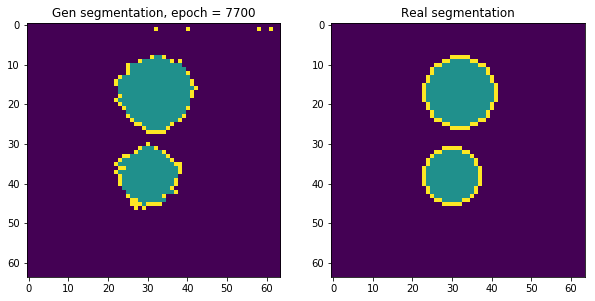

epoch - 7700, loss - 0.0150441750884
epoch - 7701, loss - 0.0150204151869
epoch - 7702, loss - 0.0146811921149
epoch - 7703, loss - 0.0141408909112
epoch - 7704, loss - 0.0141022801399
epoch - 7705, loss - 0.0138223040849
epoch - 7706, loss - 0.0130422888324
epoch - 7707, loss - 0.0125555209816
epoch - 7708, loss - 0.0128762722015
epoch - 7709, loss - 0.0136936800554
epoch - 7710, loss - 0.0140637867153
epoch - 7711, loss - 0.0147152189165
epoch - 7712, loss - 0.0155523214489
epoch - 7713, loss - 0.0167320389301
epoch - 7714, loss - 0.0178337376565
epoch - 7715, loss - 0.0205141343176
epoch - 7716, loss - 0.0247325114906
epoch - 7717, loss - 0.0332422219217
epoch - 7718, loss - 0.0455827377737
epoch - 7719, loss - 0.0680641829967
epoch - 7720, loss - 0.098357796669
epoch - 7721, loss - 0.146597117186
epoch - 7722, loss - 0.188186168671
epoch - 7723, loss - 0.218734800816
epoch - 7724, loss - 0.229420766234
epoch - 7725, loss - 0.233343690634
epoch - 7726, loss - 0.208661705256
epoch - 

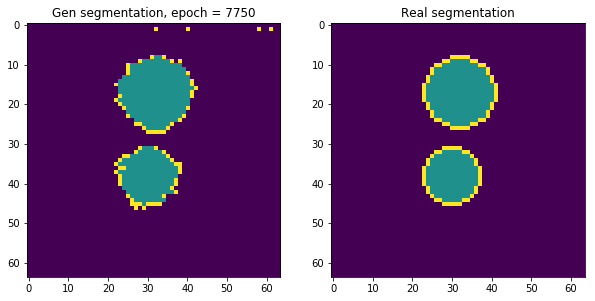

epoch - 7750, loss - 0.0234600901604
epoch - 7751, loss - 0.0240285601467
epoch - 7752, loss - 0.020797483623
epoch - 7753, loss - 0.022623244673
epoch - 7754, loss - 0.0199868902564
epoch - 7755, loss - 0.0193166974932
epoch - 7756, loss - 0.0179422162473
epoch - 7757, loss - 0.0168119184673
epoch - 7758, loss - 0.0162327233702
epoch - 7759, loss - 0.0158927775919
epoch - 7760, loss - 0.0152636636049
epoch - 7761, loss - 0.0149465799332
epoch - 7762, loss - 0.014424036257
epoch - 7763, loss - 0.0139229279011
epoch - 7764, loss - 0.013457746245
epoch - 7765, loss - 0.0130066694692
epoch - 7766, loss - 0.0126333199441
epoch - 7767, loss - 0.01208711043
epoch - 7768, loss - 0.0118922069669
epoch - 7769, loss - 0.0114748384804
epoch - 7770, loss - 0.0112379183993
epoch - 7771, loss - 0.0111089833081
epoch - 7772, loss - 0.010816141963
epoch - 7773, loss - 0.0107116261497
epoch - 7774, loss - 0.0105330785736
epoch - 7775, loss - 0.0104289557785
epoch - 7776, loss - 0.0103513179347
epoch - 

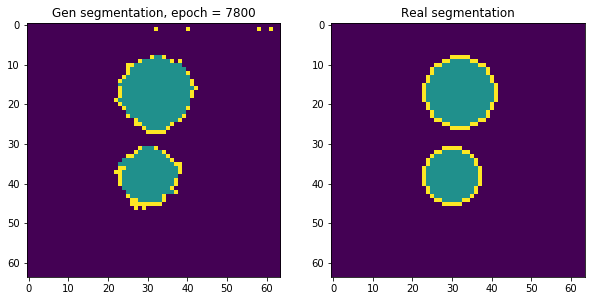

epoch - 7800, loss - 0.0592862293124
epoch - 7801, loss - 0.0420956276357
epoch - 7802, loss - 0.0385960415006
epoch - 7803, loss - 0.0510430559516
epoch - 7804, loss - 0.0483098477125
epoch - 7805, loss - 0.0296832583845
epoch - 7806, loss - 0.0324969664216
epoch - 7807, loss - 0.040655080229
epoch - 7808, loss - 0.0266522690654
epoch - 7809, loss - 0.0192363038659
epoch - 7810, loss - 0.0275239162147
epoch - 7811, loss - 0.0254050027579
epoch - 7812, loss - 0.0179352499545
epoch - 7813, loss - 0.0201900172979
epoch - 7814, loss - 0.0224668942392
epoch - 7815, loss - 0.0177350491285
epoch - 7816, loss - 0.0154315251857
epoch - 7817, loss - 0.0177390240133
epoch - 7818, loss - 0.0159958098084
epoch - 7819, loss - 0.0133779197931
epoch - 7820, loss - 0.0142276827246
epoch - 7821, loss - 0.0141057763249
epoch - 7822, loss - 0.0122349765152
epoch - 7823, loss - 0.0122160743922
epoch - 7824, loss - 0.013100810349
epoch - 7825, loss - 0.0120833255351
epoch - 7826, loss - 0.0113866664469
epo

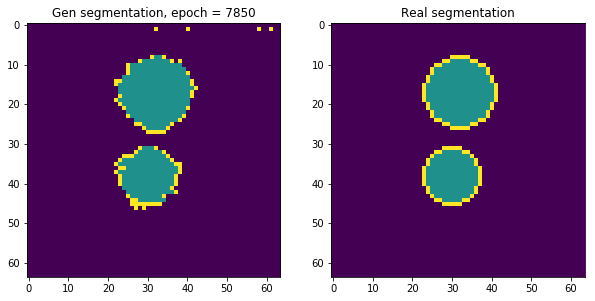

epoch - 7850, loss - 0.0173638742417
epoch - 7851, loss - 0.0275202840567
epoch - 7852, loss - 0.0392271727324
epoch - 7853, loss - 0.0436221137643
epoch - 7854, loss - 0.037974819541
epoch - 7855, loss - 0.0245532952249
epoch - 7856, loss - 0.0142888547853
epoch - 7857, loss - 0.0130963679403
epoch - 7858, loss - 0.0179292764515
epoch - 7859, loss - 0.0231345891953
epoch - 7860, loss - 0.0245968904346
epoch - 7861, loss - 0.0232551805675
epoch - 7862, loss - 0.019388884306
epoch - 7863, loss - 0.0160752646625
epoch - 7864, loss - 0.0148768462241
epoch - 7865, loss - 0.0157038364559
epoch - 7866, loss - 0.0175807327032
epoch - 7867, loss - 0.0173703078181
epoch - 7868, loss - 0.0164908319712
epoch - 7869, loss - 0.0156086552888
epoch - 7870, loss - 0.0146577227861
epoch - 7871, loss - 0.0136844776571
epoch - 7872, loss - 0.0130287203938
epoch - 7873, loss - 0.0130281411111
epoch - 7874, loss - 0.0138053577393
epoch - 7875, loss - 0.0144846364856
epoch - 7876, loss - 0.0141885764897
epo

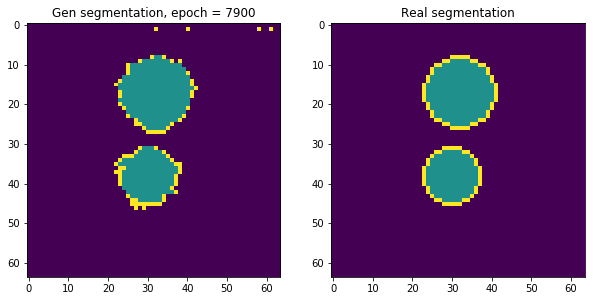

epoch - 7900, loss - 0.149227365851
epoch - 7901, loss - 0.137154489756
epoch - 7902, loss - 0.116909749806
epoch - 7903, loss - 0.0941618233919
epoch - 7904, loss - 0.071728721261
epoch - 7905, loss - 0.062227960676
epoch - 7906, loss - 0.0742931738496
epoch - 7907, loss - 0.0797787159681
epoch - 7908, loss - 0.0662755966187
epoch - 7909, loss - 0.0476617440581
epoch - 7910, loss - 0.0375278219581
epoch - 7911, loss - 0.0411374568939
epoch - 7912, loss - 0.0433754324913
epoch - 7913, loss - 0.0396253690124
epoch - 7914, loss - 0.034919179976
epoch - 7915, loss - 0.0310624241829
epoch - 7916, loss - 0.0269062966108
epoch - 7917, loss - 0.0236514694989
epoch - 7918, loss - 0.0241019539535
epoch - 7919, loss - 0.0256121642888
epoch - 7920, loss - 0.0237524379045
epoch - 7921, loss - 0.0210263356566
epoch - 7922, loss - 0.0186049714684
epoch - 7923, loss - 0.017314273864
epoch - 7924, loss - 0.0168098211288
epoch - 7925, loss - 0.0161019898951
epoch - 7926, loss - 0.0168672893196
epoch - 

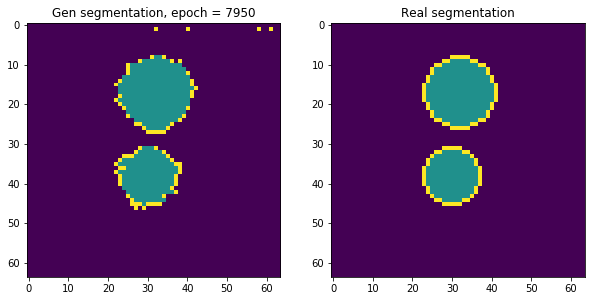

epoch - 7950, loss - 0.0196116268635
epoch - 7951, loss - 0.0207111556083
epoch - 7952, loss - 0.0220630317926
epoch - 7953, loss - 0.0231324415654
epoch - 7954, loss - 0.0253190249205
epoch - 7955, loss - 0.0271960087121
epoch - 7956, loss - 0.0306992940605
epoch - 7957, loss - 0.0321241505444
epoch - 7958, loss - 0.0343574658036
epoch - 7959, loss - 0.0330144129694
epoch - 7960, loss - 0.030929049477
epoch - 7961, loss - 0.0254074670374
epoch - 7962, loss - 0.0193970873952
epoch - 7963, loss - 0.0155713669956
epoch - 7964, loss - 0.0168582480401
epoch - 7965, loss - 0.0213767960668
epoch - 7966, loss - 0.0246970802546
epoch - 7967, loss - 0.0263508707285
epoch - 7968, loss - 0.0234735459089
epoch - 7969, loss - 0.0202256068587
epoch - 7970, loss - 0.0175147913396
epoch - 7971, loss - 0.017871953547
epoch - 7972, loss - 0.0199610330164
epoch - 7973, loss - 0.0198577009141
epoch - 7974, loss - 0.0184225123376
epoch - 7975, loss - 0.0164455100894
epoch - 7976, loss - 0.0166207868606
epo

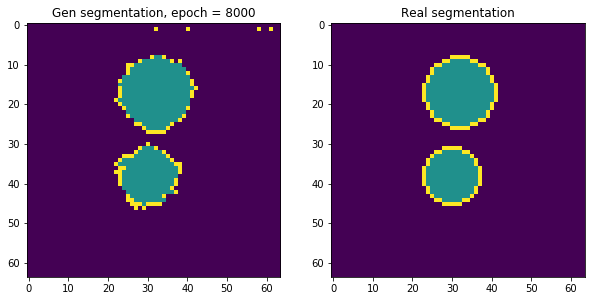

epoch - 8000, loss - 0.0401492118835
epoch - 8001, loss - 0.0419239811599
epoch - 8002, loss - 0.0383492894471
epoch - 8003, loss - 0.0381330177188
epoch - 8004, loss - 0.0366483256221
epoch - 8005, loss - 0.0292622447014
epoch - 8006, loss - 0.0242134239525
epoch - 8007, loss - 0.0250494573265
epoch - 8008, loss - 0.0241032075137
epoch - 8009, loss - 0.0224304124713
epoch - 8010, loss - 0.0233116652817
epoch - 8011, loss - 0.0211874321103
epoch - 8012, loss - 0.0176821034402
epoch - 8013, loss - 0.017270622775
epoch - 8014, loss - 0.0160588826984
epoch - 8015, loss - 0.0156609024853
epoch - 8016, loss - 0.0163657497615
epoch - 8017, loss - 0.0153296003118
epoch - 8018, loss - 0.0141833871603
epoch - 8019, loss - 0.013480052352
epoch - 8020, loss - 0.0130203291774
epoch - 8021, loss - 0.0121714221314
epoch - 8022, loss - 0.0113825891167
epoch - 8023, loss - 0.0120319593698
epoch - 8024, loss - 0.0113747809082
epoch - 8025, loss - 0.0109734777361
epoch - 8026, loss - 0.011308141984
epoc

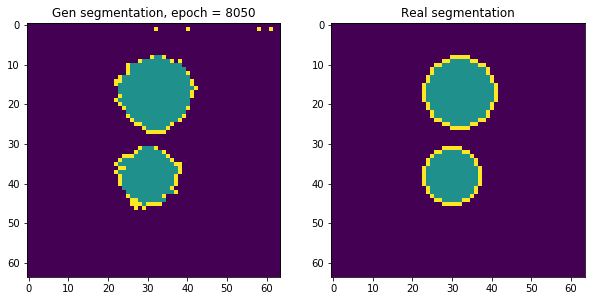

epoch - 8050, loss - 0.0146133862436
epoch - 8051, loss - 0.0168578401208
epoch - 8052, loss - 0.0236382931471
epoch - 8053, loss - 0.0321006439626
epoch - 8054, loss - 0.0409257262945
epoch - 8055, loss - 0.0478676483035
epoch - 8056, loss - 0.051901333034
epoch - 8057, loss - 0.0588793642819
epoch - 8058, loss - 0.0706012621522
epoch - 8059, loss - 0.0936514660716
epoch - 8060, loss - 0.101700983942
epoch - 8061, loss - 0.102428287268
epoch - 8062, loss - 0.0704997032881
epoch - 8063, loss - 0.0453260727227
epoch - 8064, loss - 0.0437230616808
epoch - 8065, loss - 0.0516521111131
epoch - 8066, loss - 0.0447719693184
epoch - 8067, loss - 0.0288680531085
epoch - 8068, loss - 0.0339811854064
epoch - 8069, loss - 0.0443005748093
epoch - 8070, loss - 0.0349433682859
epoch - 8071, loss - 0.0208793953061
epoch - 8072, loss - 0.0219179578125
epoch - 8073, loss - 0.0262282583863
epoch - 8074, loss - 0.0220033731312
epoch - 8075, loss - 0.0173472221941
epoch - 8076, loss - 0.0196526609361
epoc

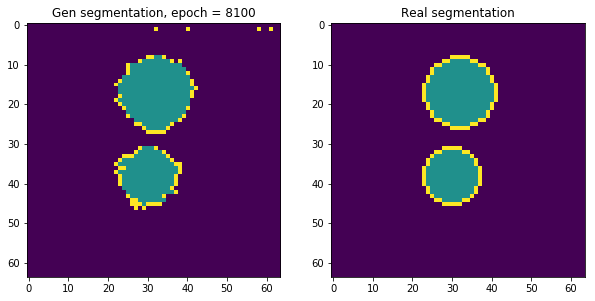

epoch - 8100, loss - 0.0143685620278
epoch - 8101, loss - 0.0161984153092
epoch - 8102, loss - 0.0185760967433
epoch - 8103, loss - 0.0211679115891
epoch - 8104, loss - 0.0248425751925
epoch - 8105, loss - 0.0281852986664
epoch - 8106, loss - 0.0331075266004
epoch - 8107, loss - 0.0377882681787
epoch - 8108, loss - 0.0446365252137
epoch - 8109, loss - 0.0514891967177
epoch - 8110, loss - 0.0637429580092
epoch - 8111, loss - 0.0718097612262
epoch - 8112, loss - 0.0829901844263
epoch - 8113, loss - 0.077701754868
epoch - 8114, loss - 0.0664576664567
epoch - 8115, loss - 0.040638577193
epoch - 8116, loss - 0.0204390436411
epoch - 8117, loss - 0.0235487781465
epoch - 8118, loss - 0.0406816340983
epoch - 8119, loss - 0.0517380349338
epoch - 8120, loss - 0.0431806817651
epoch - 8121, loss - 0.0280024372041
epoch - 8122, loss - 0.0211821738631
epoch - 8123, loss - 0.024400504306
epoch - 8124, loss - 0.0269691813737
epoch - 8125, loss - 0.0241808481514
epoch - 8126, loss - 0.0198307335377
epoc

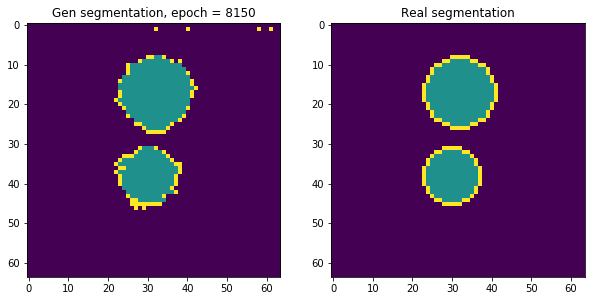

epoch - 8150, loss - 0.034701090306
epoch - 8151, loss - 0.0429245755076
epoch - 8152, loss - 0.0546120479703
epoch - 8153, loss - 0.0617466308177
epoch - 8154, loss - 0.0701849535108
epoch - 8155, loss - 0.0722043216228
epoch - 8156, loss - 0.0689125433564
epoch - 8157, loss - 0.0540507510304
epoch - 8158, loss - 0.0333064123988
epoch - 8159, loss - 0.0199755150825
epoch - 8160, loss - 0.0215594731271
epoch - 8161, loss - 0.0289647895843
epoch - 8162, loss - 0.0332857221365
epoch - 8163, loss - 0.0329486094415
epoch - 8164, loss - 0.0337171405554
epoch - 8165, loss - 0.0344253331423
epoch - 8166, loss - 0.0283071659505
epoch - 8167, loss - 0.0210184361786
epoch - 8168, loss - 0.0179058182985
epoch - 8169, loss - 0.0173288695514
epoch - 8170, loss - 0.0168639346957
epoch - 8171, loss - 0.0169235132635
epoch - 8172, loss - 0.0188562311232
epoch - 8173, loss - 0.0186671130359
epoch - 8174, loss - 0.0170129295439
epoch - 8175, loss - 0.0162176061422
epoch - 8176, loss - 0.0156480651349
ep

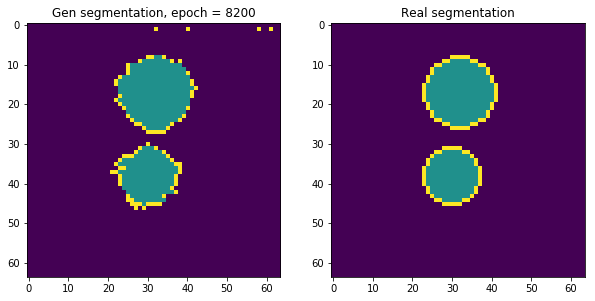

epoch - 8200, loss - 0.0407779142261
epoch - 8201, loss - 0.0541734173894
epoch - 8202, loss - 0.0720348656178
epoch - 8203, loss - 0.0906666442752
epoch - 8204, loss - 0.106466680765
epoch - 8205, loss - 0.115103058517
epoch - 8206, loss - 0.116957090795
epoch - 8207, loss - 0.127136796713
epoch - 8208, loss - 0.137576401234
epoch - 8209, loss - 0.110548555851
epoch - 8210, loss - 0.0604413971305
epoch - 8211, loss - 0.063482157886
epoch - 8212, loss - 0.0901902243495
epoch - 8213, loss - 0.0682623907924
epoch - 8214, loss - 0.0409733019769
epoch - 8215, loss - 0.0532803982496
epoch - 8216, loss - 0.0510773435235
epoch - 8217, loss - 0.0377076007426
epoch - 8218, loss - 0.0371164493263
epoch - 8219, loss - 0.0338331982493
epoch - 8220, loss - 0.0343911871314
epoch - 8221, loss - 0.0323081314564
epoch - 8222, loss - 0.0269179549068
epoch - 8223, loss - 0.026765467599
epoch - 8224, loss - 0.0235838294029
epoch - 8225, loss - 0.0224526487291
epoch - 8226, loss - 0.0205087251961
epoch - 8

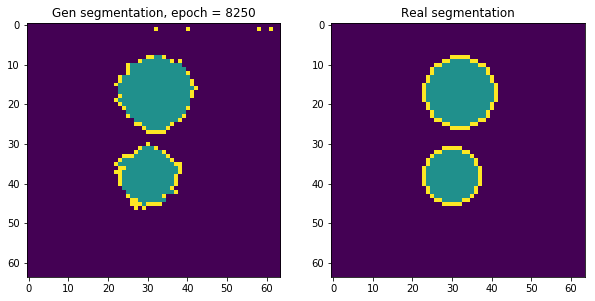

epoch - 8250, loss - 0.00927708484232
epoch - 8251, loss - 0.00966512784362
epoch - 8252, loss - 0.0105380527675
epoch - 8253, loss - 0.0122100664303
epoch - 8254, loss - 0.0144036337733
epoch - 8255, loss - 0.0185804646462
epoch - 8256, loss - 0.0236876029521
epoch - 8257, loss - 0.0325158052146
epoch - 8258, loss - 0.0416841730475
epoch - 8259, loss - 0.0569368600845
epoch - 8260, loss - 0.0707863941789
epoch - 8261, loss - 0.0952349379659
epoch - 8262, loss - 0.118528775871
epoch - 8263, loss - 0.155084505677
epoch - 8264, loss - 0.186911374331
epoch - 8265, loss - 0.191716134548
epoch - 8266, loss - 0.178823009133
epoch - 8267, loss - 0.0778507813811
epoch - 8268, loss - 0.064270965755
epoch - 8269, loss - 0.12446333468
epoch - 8270, loss - 0.0989473462105
epoch - 8271, loss - 0.077020034194
epoch - 8272, loss - 0.0723985284567
epoch - 8273, loss - 0.0429419204593
epoch - 8274, loss - 0.0608493424952
epoch - 8275, loss - 0.067992836237
epoch - 8276, loss - 0.0504854135215
epoch - 8

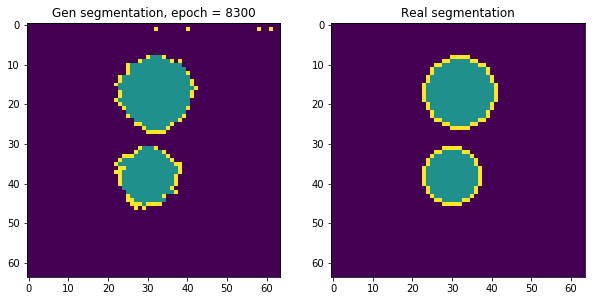

epoch - 8300, loss - 0.011860538274
epoch - 8301, loss - 0.0119614563882
epoch - 8302, loss - 0.011284487322
epoch - 8303, loss - 0.0108750406653
epoch - 8304, loss - 0.0101973339915
epoch - 8305, loss - 0.00970349088311
epoch - 8306, loss - 0.00940305739641
epoch - 8307, loss - 0.00918552093208
epoch - 8308, loss - 0.00914889574051
epoch - 8309, loss - 0.00911574810743
epoch - 8310, loss - 0.00915569067001
epoch - 8311, loss - 0.00910790078342
epoch - 8312, loss - 0.00908663310111
epoch - 8313, loss - 0.00904079340398
epoch - 8314, loss - 0.00904389284551
epoch - 8315, loss - 0.00898753106594
epoch - 8316, loss - 0.00897554121912
epoch - 8317, loss - 0.00899016857147
epoch - 8318, loss - 0.00898699276149
epoch - 8319, loss - 0.00900821574032
epoch - 8320, loss - 0.00908522773534
epoch - 8321, loss - 0.00915742479265
epoch - 8322, loss - 0.00934154167771
epoch - 8323, loss - 0.00965251028538
epoch - 8324, loss - 0.0100274765864
epoch - 8325, loss - 0.0106253279373
epoch - 8326, loss - 

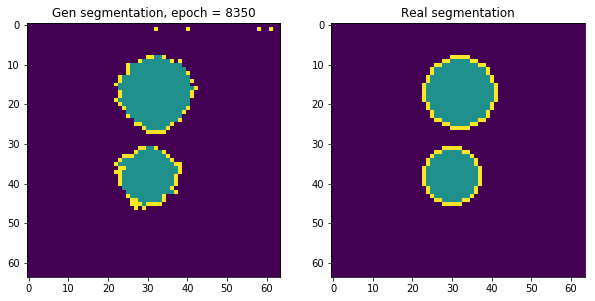

epoch - 8350, loss - 0.0285195931792
epoch - 8351, loss - 0.0259900260717
epoch - 8352, loss - 0.0186496265233
epoch - 8353, loss - 0.0187848303467
epoch - 8354, loss - 0.0205099694431
epoch - 8355, loss - 0.0168554950505
epoch - 8356, loss - 0.0143236313015
epoch - 8357, loss - 0.0160727482289
epoch - 8358, loss - 0.0146813243628
epoch - 8359, loss - 0.0122061800212
epoch - 8360, loss - 0.0133256353438
epoch - 8361, loss - 0.0137237953022
epoch - 8362, loss - 0.0114673227072
epoch - 8363, loss - 0.0107100550085
epoch - 8364, loss - 0.01180399023
epoch - 8365, loss - 0.0111871697009
epoch - 8366, loss - 0.00977447535843
epoch - 8367, loss - 0.0102553628385
epoch - 8368, loss - 0.0109036359936
epoch - 8369, loss - 0.00998322479427
epoch - 8370, loss - 0.00956085510552
epoch - 8371, loss - 0.0103059466928
epoch - 8372, loss - 0.0106658777222
epoch - 8373, loss - 0.0106550659984
epoch - 8374, loss - 0.0112706739455
epoch - 8375, loss - 0.0128129757941
epoch - 8376, loss - 0.0143365096301


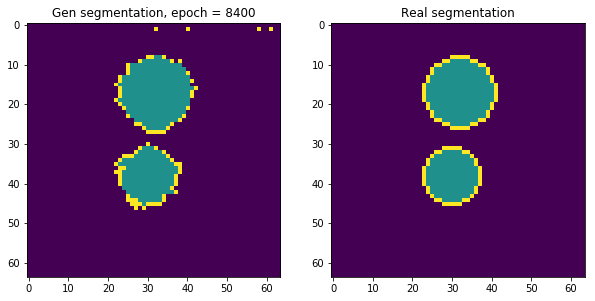

epoch - 8400, loss - 0.0195944234729
epoch - 8401, loss - 0.0232224464417
epoch - 8402, loss - 0.0217561069876
epoch - 8403, loss - 0.018348256126
epoch - 8404, loss - 0.0140435965732
epoch - 8405, loss - 0.0112859895453
epoch - 8406, loss - 0.0113792065531
epoch - 8407, loss - 0.0133046684787
epoch - 8408, loss - 0.0151575244963
epoch - 8409, loss - 0.0145657556131
epoch - 8410, loss - 0.0132462643087
epoch - 8411, loss - 0.0120154703036
epoch - 8412, loss - 0.0115394871682
epoch - 8413, loss - 0.0108907194808
epoch - 8414, loss - 0.010428911075
epoch - 8415, loss - 0.0112151345238
epoch - 8416, loss - 0.0114152701572
epoch - 8417, loss - 0.0111958682537
epoch - 8418, loss - 0.0109347505495
epoch - 8419, loss - 0.0110276266932
epoch - 8420, loss - 0.0106488130987
epoch - 8421, loss - 0.00972572527826
epoch - 8422, loss - 0.00915767252445
epoch - 8423, loss - 0.00877595040947
epoch - 8424, loss - 0.00906736962497
epoch - 8425, loss - 0.0100424904376
epoch - 8426, loss - 0.0107693299651

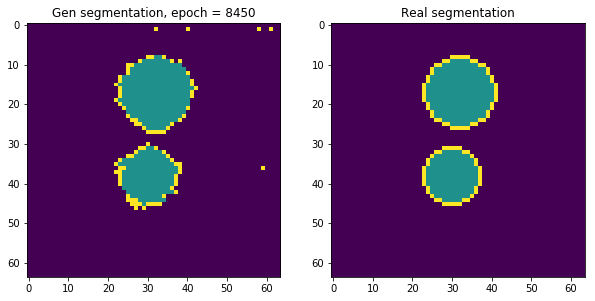

epoch - 8450, loss - 0.0616790056229
epoch - 8451, loss - 0.0477245748043
epoch - 8452, loss - 0.0481165274978
epoch - 8453, loss - 0.0523108541965
epoch - 8454, loss - 0.0517950989306
epoch - 8455, loss - 0.0386834740639
epoch - 8456, loss - 0.0316506773233
epoch - 8457, loss - 0.0314404070377
epoch - 8458, loss - 0.0327684283257
epoch - 8459, loss - 0.0324743576348
epoch - 8460, loss - 0.0261111985892
epoch - 8461, loss - 0.0239579863846
epoch - 8462, loss - 0.0221828240901
epoch - 8463, loss - 0.0210372488946
epoch - 8464, loss - 0.0217421445996
epoch - 8465, loss - 0.0183088742197
epoch - 8466, loss - 0.0180076956749
epoch - 8467, loss - 0.0176205337048
epoch - 8468, loss - 0.0154420956969
epoch - 8469, loss - 0.0157795213163
epoch - 8470, loss - 0.014571622014
epoch - 8471, loss - 0.0136567335576
epoch - 8472, loss - 0.0133793037385
epoch - 8473, loss - 0.0130330268294
epoch - 8474, loss - 0.0123960440978
epoch - 8475, loss - 0.0113911526278
epoch - 8476, loss - 0.0114033753052
ep

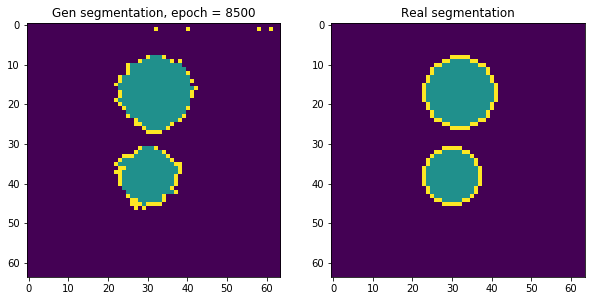

epoch - 8500, loss - 0.0157198607922
epoch - 8501, loss - 0.014402590692
epoch - 8502, loss - 0.0111742634326
epoch - 8503, loss - 0.00851592421532
epoch - 8504, loss - 0.00822330079973
epoch - 8505, loss - 0.00983542576432
epoch - 8506, loss - 0.0120312739164
epoch - 8507, loss - 0.0132346730679
epoch - 8508, loss - 0.01295032911
epoch - 8509, loss - 0.0108661372215
epoch - 8510, loss - 0.00854670349509
epoch - 8511, loss - 0.00799559988081
epoch - 8512, loss - 0.00941231939942
epoch - 8513, loss - 0.0114932395518
epoch - 8514, loss - 0.013042178005
epoch - 8515, loss - 0.0136946476996
epoch - 8516, loss - 0.0138899981976
epoch - 8517, loss - 0.0151978712529
epoch - 8518, loss - 0.0201239660382
epoch - 8519, loss - 0.0287394933403
epoch - 8520, loss - 0.043642628938
epoch - 8521, loss - 0.0586801730096
epoch - 8522, loss - 0.0823702663183
epoch - 8523, loss - 0.0968382284045
epoch - 8524, loss - 0.121111676097
epoch - 8525, loss - 0.131222859025
epoch - 8526, loss - 0.134662479162
epo

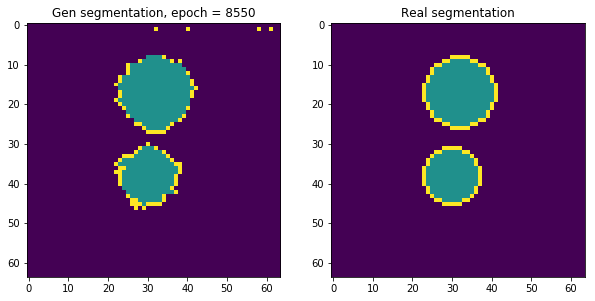

epoch - 8550, loss - 0.013825468719
epoch - 8551, loss - 0.0134410923347
epoch - 8552, loss - 0.0127697419375
epoch - 8553, loss - 0.0128454063088
epoch - 8554, loss - 0.0114249652252
epoch - 8555, loss - 0.0106526818126
epoch - 8556, loss - 0.0102117657661
epoch - 8557, loss - 0.00963135994971
epoch - 8558, loss - 0.00969935208559
epoch - 8559, loss - 0.00945541542023
epoch - 8560, loss - 0.00968327280134
epoch - 8561, loss - 0.0100261038169
epoch - 8562, loss - 0.00964486226439
epoch - 8563, loss - 0.0100903622806
epoch - 8564, loss - 0.0102571574971
epoch - 8565, loss - 0.010325152427
epoch - 8566, loss - 0.0114799402654
epoch - 8567, loss - 0.0128195974976
epoch - 8568, loss - 0.0144254527986
epoch - 8569, loss - 0.0165972355753
epoch - 8570, loss - 0.0186525508761
epoch - 8571, loss - 0.0187724549323
epoch - 8572, loss - 0.0175072867423
epoch - 8573, loss - 0.0147034404799
epoch - 8574, loss - 0.0115023013204
epoch - 8575, loss - 0.0113187972456
epoch - 8576, loss - 0.013371650129

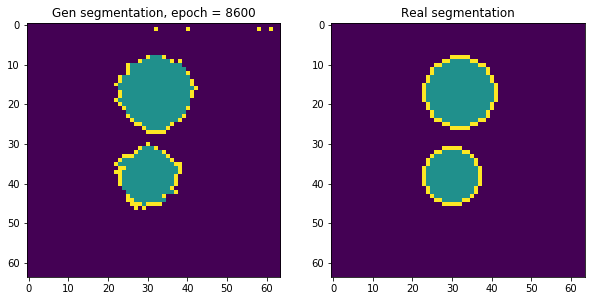

epoch - 8600, loss - 0.0567922666669
epoch - 8601, loss - 0.0444684699178
epoch - 8602, loss - 0.0346044935286
epoch - 8603, loss - 0.0403201580048
epoch - 8604, loss - 0.0482308380306
epoch - 8605, loss - 0.0437849722803
epoch - 8606, loss - 0.032555308193
epoch - 8607, loss - 0.027965568006
epoch - 8608, loss - 0.0292734466493
epoch - 8609, loss - 0.0227454043925
epoch - 8610, loss - 0.0181440953165
epoch - 8611, loss - 0.020470129326
epoch - 8612, loss - 0.021613445133
epoch - 8613, loss - 0.0196373201907
epoch - 8614, loss - 0.0181187335402
epoch - 8615, loss - 0.0179614778608
epoch - 8616, loss - 0.0158729683608
epoch - 8617, loss - 0.0129875782877
epoch - 8618, loss - 0.0125936046243
epoch - 8619, loss - 0.0123368930072
epoch - 8620, loss - 0.0107048302889
epoch - 8621, loss - 0.0107382768765
epoch - 8622, loss - 0.0118429083377
epoch - 8623, loss - 0.0112797971815
epoch - 8624, loss - 0.0103279892355
epoch - 8625, loss - 0.0106275621802
epoch - 8626, loss - 0.0110635589808
epoch

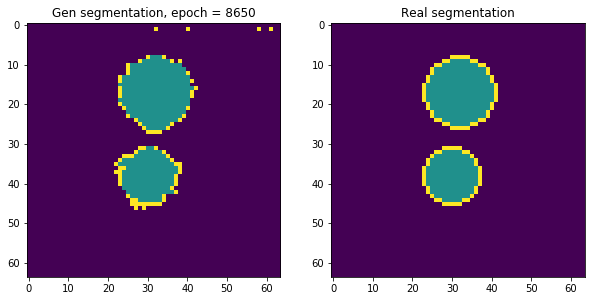

epoch - 8650, loss - 0.0755283161998
epoch - 8651, loss - 0.0852375775576
epoch - 8652, loss - 0.0999447256327
epoch - 8653, loss - 0.109259784222
epoch - 8654, loss - 0.128513976932
epoch - 8655, loss - 0.129332348704
epoch - 8656, loss - 0.132110819221
epoch - 8657, loss - 0.0928524509072
epoch - 8658, loss - 0.0465876795352
epoch - 8659, loss - 0.0635524392128
epoch - 8660, loss - 0.0952968522906
epoch - 8661, loss - 0.0868822336197
epoch - 8662, loss - 0.0461447127163
epoch - 8663, loss - 0.0339982546866
epoch - 8664, loss - 0.0467108860612
epoch - 8665, loss - 0.0476032719016
epoch - 8666, loss - 0.03918755427
epoch - 8667, loss - 0.0359173119068
epoch - 8668, loss - 0.0381828285754
epoch - 8669, loss - 0.0304032135755
epoch - 8670, loss - 0.0238959118724
epoch - 8671, loss - 0.0260934401304
epoch - 8672, loss - 0.0271467603743
epoch - 8673, loss - 0.0219136811793
epoch - 8674, loss - 0.0212997607887
epoch - 8675, loss - 0.0214169621468
epoch - 8676, loss - 0.0188472829759
epoch -

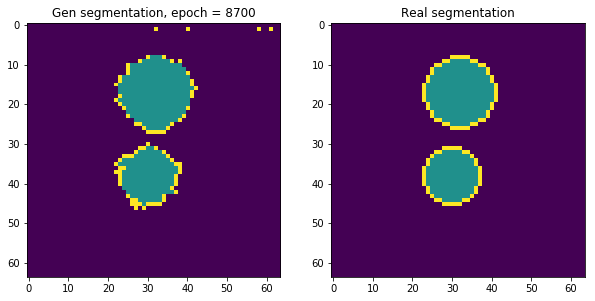

epoch - 8700, loss - 0.00755456276238
epoch - 8701, loss - 0.007703169249
epoch - 8702, loss - 0.00801321677864
epoch - 8703, loss - 0.00857033580542
epoch - 8704, loss - 0.00929854996502
epoch - 8705, loss - 0.0108449338004
epoch - 8706, loss - 0.0135736875236
epoch - 8707, loss - 0.0176724530756
epoch - 8708, loss - 0.0235791839659
epoch - 8709, loss - 0.0317839793861
epoch - 8710, loss - 0.0420904755592
epoch - 8711, loss - 0.0532125607133
epoch - 8712, loss - 0.0655543208122
epoch - 8713, loss - 0.071688733995
epoch - 8714, loss - 0.0807276889682
epoch - 8715, loss - 0.0825923606753
epoch - 8716, loss - 0.0852354764938
epoch - 8717, loss - 0.0676587000489
epoch - 8718, loss - 0.0478868298233
epoch - 8719, loss - 0.0274402946234
epoch - 8720, loss - 0.0272215530276
epoch - 8721, loss - 0.0409303605556
epoch - 8722, loss - 0.044862922281
epoch - 8723, loss - 0.0375628843904
epoch - 8724, loss - 0.0273548774421
epoch - 8725, loss - 0.0231186076999
epoch - 8726, loss - 0.0233027096838


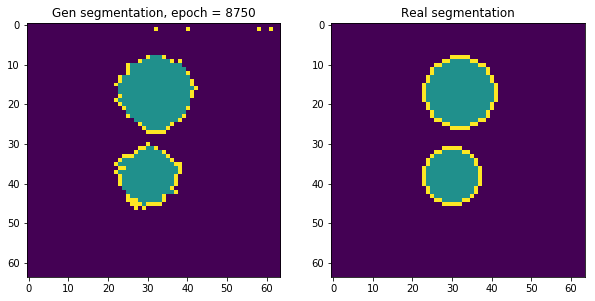

epoch - 8750, loss - 0.00822955742478
epoch - 8751, loss - 0.00808200985193
epoch - 8752, loss - 0.00808800570667
epoch - 8753, loss - 0.00807331874967
epoch - 8754, loss - 0.00818524695933
epoch - 8755, loss - 0.00838095974177
epoch - 8756, loss - 0.00855678319931
epoch - 8757, loss - 0.00887556560338
epoch - 8758, loss - 0.00928276125342
epoch - 8759, loss - 0.00992111302912
epoch - 8760, loss - 0.0106317177415
epoch - 8761, loss - 0.0122057572007
epoch - 8762, loss - 0.0148104447871
epoch - 8763, loss - 0.0190781019628
epoch - 8764, loss - 0.0248066112399
epoch - 8765, loss - 0.0351889133453
epoch - 8766, loss - 0.0476932674646
epoch - 8767, loss - 0.0677437856793
epoch - 8768, loss - 0.0835707336664
epoch - 8769, loss - 0.103426516056
epoch - 8770, loss - 0.104400955141
epoch - 8771, loss - 0.092660240829
epoch - 8772, loss - 0.067397788167
epoch - 8773, loss - 0.0458798967302
epoch - 8774, loss - 0.0443523079157
epoch - 8775, loss - 0.0539045520127
epoch - 8776, loss - 0.062240716

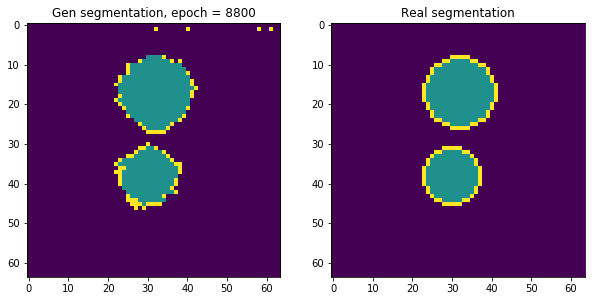

epoch - 8800, loss - 0.00923709478229
epoch - 8801, loss - 0.00962242670357
epoch - 8802, loss - 0.00830036960542
epoch - 8803, loss - 0.00809168070555
epoch - 8804, loss - 0.008604420349
epoch - 8805, loss - 0.00778394099325
epoch - 8806, loss - 0.00742763327435
epoch - 8807, loss - 0.00781670771539
epoch - 8808, loss - 0.00756256468594
epoch - 8809, loss - 0.00722132157534
epoch - 8810, loss - 0.00750784622505
epoch - 8811, loss - 0.00766323320568
epoch - 8812, loss - 0.00790465530008
epoch - 8813, loss - 0.0084513835609
epoch - 8814, loss - 0.00931488908827
epoch - 8815, loss - 0.0104662338272
epoch - 8816, loss - 0.0126255061477
epoch - 8817, loss - 0.0155543666333
epoch - 8818, loss - 0.020149147138
epoch - 8819, loss - 0.0260875709355
epoch - 8820, loss - 0.0354596674442
epoch - 8821, loss - 0.0461769849062
epoch - 8822, loss - 0.0613436587155
epoch - 8823, loss - 0.0749363824725
epoch - 8824, loss - 0.0916188582778
epoch - 8825, loss - 0.103322610259
epoch - 8826, loss - 0.10692

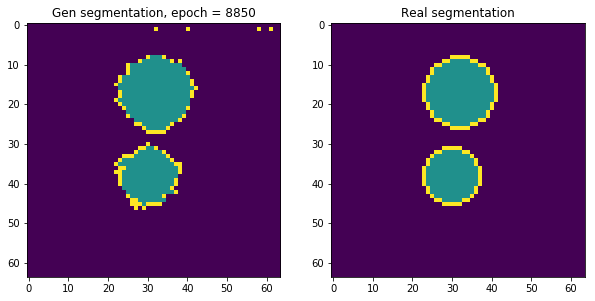

epoch - 8850, loss - 0.0136173982173
epoch - 8851, loss - 0.0116452965885
epoch - 8852, loss - 0.0115291792899
epoch - 8853, loss - 0.0110742077231
epoch - 8854, loss - 0.00972591526806
epoch - 8855, loss - 0.00986182317138
epoch - 8856, loss - 0.00997890159488
epoch - 8857, loss - 0.00902633555233
epoch - 8858, loss - 0.00899696163833
epoch - 8859, loss - 0.00896431226283
epoch - 8860, loss - 0.00837005674839
epoch - 8861, loss - 0.00856945663691
epoch - 8862, loss - 0.00833867676556
epoch - 8863, loss - 0.00787896569818
epoch - 8864, loss - 0.00832135789096
epoch - 8865, loss - 0.0081055983901
epoch - 8866, loss - 0.00765267387033
epoch - 8867, loss - 0.00776586076245
epoch - 8868, loss - 0.00746105378494
epoch - 8869, loss - 0.00714226346463
epoch - 8870, loss - 0.00704751955345
epoch - 8871, loss - 0.0067380387336
epoch - 8872, loss - 0.00654573086649
epoch - 8873, loss - 0.00663390476257
epoch - 8874, loss - 0.00660485308617
epoch - 8875, loss - 0.00670743780211
epoch - 8876, loss

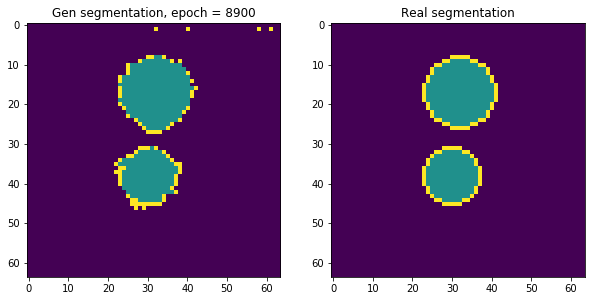

epoch - 8900, loss - 0.0435690954328
epoch - 8901, loss - 0.041942179203
epoch - 8902, loss - 0.0344188585877
epoch - 8903, loss - 0.0293456297368
epoch - 8904, loss - 0.0260480586439
epoch - 8905, loss - 0.0216003507376
epoch - 8906, loss - 0.0219511073083
epoch - 8907, loss - 0.0231707058847
epoch - 8908, loss - 0.0203055460006
epoch - 8909, loss - 0.0195924118161
epoch - 8910, loss - 0.0188658256084
epoch - 8911, loss - 0.0140982531011
epoch - 8912, loss - 0.0135408677161
epoch - 8913, loss - 0.0146393366158
epoch - 8914, loss - 0.0121573936194
epoch - 8915, loss - 0.0126305986196
epoch - 8916, loss - 0.0137200783938
epoch - 8917, loss - 0.0113562550396
epoch - 8918, loss - 0.0104206893593
epoch - 8919, loss - 0.0104127023369
epoch - 8920, loss - 0.0090453941375
epoch - 8921, loss - 0.00867022573948
epoch - 8922, loss - 0.00916487816721
epoch - 8923, loss - 0.00850862264633
epoch - 8924, loss - 0.00840480159968
epoch - 8925, loss - 0.00883980561048
epoch - 8926, loss - 0.00824200361

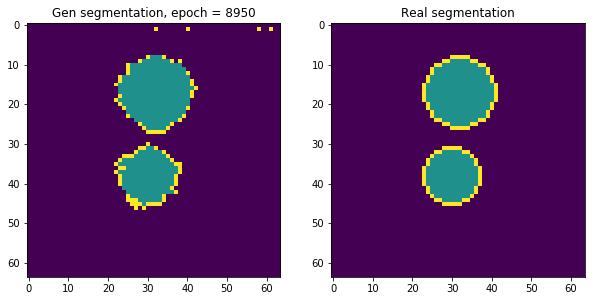

epoch - 8950, loss - 0.0114532001317
epoch - 8951, loss - 0.0130027495325
epoch - 8952, loss - 0.0168056078255
epoch - 8953, loss - 0.0221570022404
epoch - 8954, loss - 0.0322313383222
epoch - 8955, loss - 0.0434143431485
epoch - 8956, loss - 0.0601006634533
epoch - 8957, loss - 0.0717897191644
epoch - 8958, loss - 0.0816460102797
epoch - 8959, loss - 0.0794252380729
epoch - 8960, loss - 0.0777402892709
epoch - 8961, loss - 0.0816343352199
epoch - 8962, loss - 0.091302536428
epoch - 8963, loss - 0.109644323587
epoch - 8964, loss - 0.0835617259145
epoch - 8965, loss - 0.0553445257246
epoch - 8966, loss - 0.0617881640792
epoch - 8967, loss - 0.0727996230125
epoch - 8968, loss - 0.0639297142625
epoch - 8969, loss - 0.042448155582
epoch - 8970, loss - 0.0406598746777
epoch - 8971, loss - 0.0421994775534
epoch - 8972, loss - 0.030898841098
epoch - 8973, loss - 0.0313830822706
epoch - 8974, loss - 0.0337961092591
epoch - 8975, loss - 0.0244838520885
epoch - 8976, loss - 0.0273040905595
epoch

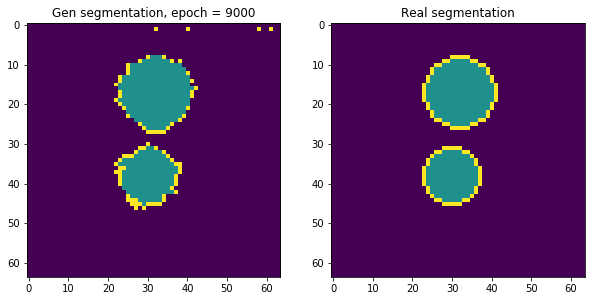

epoch - 9000, loss - 0.00762492697686
epoch - 9001, loss - 0.00737136323005
epoch - 9002, loss - 0.00734482891858
epoch - 9003, loss - 0.00730473268777
epoch - 9004, loss - 0.00736142788082
epoch - 9005, loss - 0.00759709160775
epoch - 9006, loss - 0.00787600222975
epoch - 9007, loss - 0.00840508006513
epoch - 9008, loss - 0.0092723313719
epoch - 9009, loss - 0.0104108965024
epoch - 9010, loss - 0.0123071782291
epoch - 9011, loss - 0.0148549769074
epoch - 9012, loss - 0.0188011974096
epoch - 9013, loss - 0.0235700309277
epoch - 9014, loss - 0.0314501188695
epoch - 9015, loss - 0.0398617684841
epoch - 9016, loss - 0.0530111193657
epoch - 9017, loss - 0.063429236412
epoch - 9018, loss - 0.0762360543013
epoch - 9019, loss - 0.0759030506015
epoch - 9020, loss - 0.0688757747412
epoch - 9021, loss - 0.047083593905
epoch - 9022, loss - 0.0253627952188
epoch - 9023, loss - 0.014499289915
epoch - 9024, loss - 0.0201992876828
epoch - 9025, loss - 0.0331207849085
epoch - 9026, loss - 0.0411816351

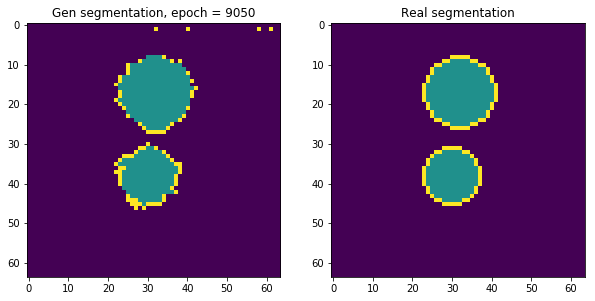

epoch - 9050, loss - 0.00852992944419
epoch - 9051, loss - 0.0090604564175
epoch - 9052, loss - 0.00848027970642
epoch - 9053, loss - 0.00728300586343
epoch - 9054, loss - 0.00702413590625
epoch - 9055, loss - 0.00764730013907
epoch - 9056, loss - 0.00812236405909
epoch - 9057, loss - 0.00796121079475
epoch - 9058, loss - 0.00755765289068
epoch - 9059, loss - 0.00733853224665
epoch - 9060, loss - 0.00761193642393
epoch - 9061, loss - 0.00826394278556
epoch - 9062, loss - 0.00892321206629
epoch - 9063, loss - 0.00967267155647
epoch - 9064, loss - 0.0104667190462
epoch - 9065, loss - 0.0118179805577
epoch - 9066, loss - 0.0147692495957
epoch - 9067, loss - 0.0194865111262
epoch - 9068, loss - 0.0265147797763
epoch - 9069, loss - 0.0343602895737
epoch - 9070, loss - 0.045551083982
epoch - 9071, loss - 0.0616936273873
epoch - 9072, loss - 0.0857672467828
epoch - 9073, loss - 0.119190484285
epoch - 9074, loss - 0.139212951064
epoch - 9075, loss - 0.147261917591
epoch - 9076, loss - 0.123370

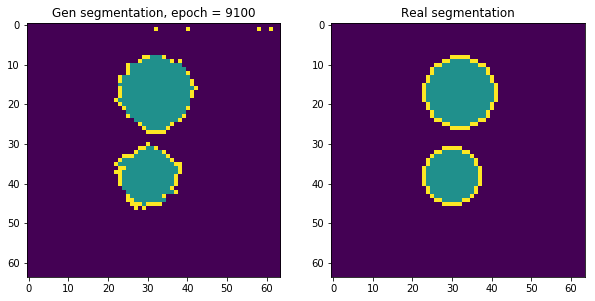

epoch - 9100, loss - 0.0126003855839
epoch - 9101, loss - 0.0122241396457
epoch - 9102, loss - 0.0118547305465
epoch - 9103, loss - 0.0113049447536
epoch - 9104, loss - 0.0107191726565
epoch - 9105, loss - 0.0101745026186
epoch - 9106, loss - 0.00944907404482
epoch - 9107, loss - 0.00923656858504
epoch - 9108, loss - 0.0088820848614
epoch - 9109, loss - 0.00838244985789
epoch - 9110, loss - 0.00857497565448
epoch - 9111, loss - 0.00786203425378
epoch - 9112, loss - 0.00754317361861
epoch - 9113, loss - 0.00744794635102
epoch - 9114, loss - 0.00716288667172
epoch - 9115, loss - 0.00713246688247
epoch - 9116, loss - 0.00696087721735
epoch - 9117, loss - 0.00679538398981
epoch - 9118, loss - 0.00654123816639
epoch - 9119, loss - 0.00635124370456
epoch - 9120, loss - 0.00624175136909
epoch - 9121, loss - 0.00619822274894
epoch - 9122, loss - 0.00613295845687
epoch - 9123, loss - 0.00600061472505
epoch - 9124, loss - 0.00588394608349
epoch - 9125, loss - 0.00578122772276
epoch - 9126, loss 

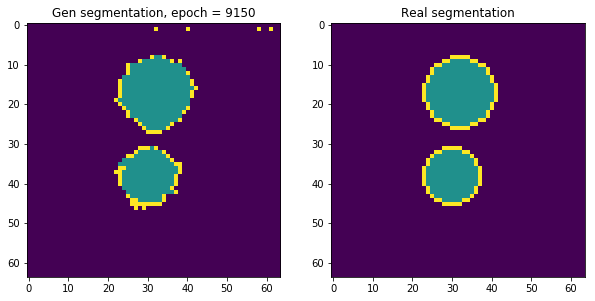

epoch - 9150, loss - 0.189133524895
epoch - 9151, loss - 0.0974010154605
epoch - 9152, loss - 0.102895617485
epoch - 9153, loss - 0.122486367822
epoch - 9154, loss - 0.0963581725955
epoch - 9155, loss - 0.0840047001839
epoch - 9156, loss - 0.0619920790195
epoch - 9157, loss - 0.064650118351
epoch - 9158, loss - 0.0812198519707
epoch - 9159, loss - 0.0499357692897
epoch - 9160, loss - 0.0558615811169
epoch - 9161, loss - 0.0552822835743
epoch - 9162, loss - 0.0396044850349
epoch - 9163, loss - 0.0539730116725
epoch - 9164, loss - 0.040869500488
epoch - 9165, loss - 0.0344044528902
epoch - 9166, loss - 0.0402127504349
epoch - 9167, loss - 0.0318849161267
epoch - 9168, loss - 0.0298424642533
epoch - 9169, loss - 0.0286649502814
epoch - 9170, loss - 0.025864912197
epoch - 9171, loss - 0.024690579623
epoch - 9172, loss - 0.0224209874868
epoch - 9173, loss - 0.0217950660735
epoch - 9174, loss - 0.0183530561626
epoch - 9175, loss - 0.0190570559353
epoch - 9176, loss - 0.0172107946128
epoch - 

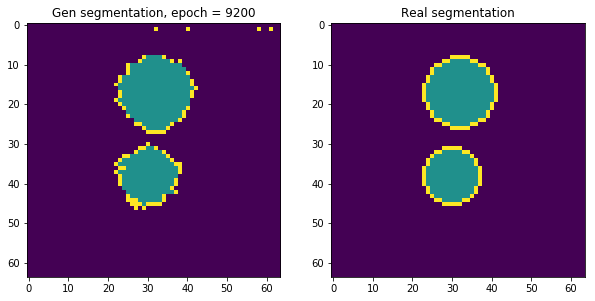

epoch - 9200, loss - 0.00694608036429
epoch - 9201, loss - 0.00693281786516
epoch - 9202, loss - 0.00709207076579
epoch - 9203, loss - 0.00707129295915
epoch - 9204, loss - 0.0071555133909
epoch - 9205, loss - 0.00733669800684
epoch - 9206, loss - 0.00739657040685
epoch - 9207, loss - 0.00745809357613
epoch - 9208, loss - 0.0075662182644
epoch - 9209, loss - 0.00748242577538
epoch - 9210, loss - 0.00734778027982
epoch - 9211, loss - 0.00726146344095
epoch - 9212, loss - 0.00709486659616
epoch - 9213, loss - 0.007040431723
epoch - 9214, loss - 0.00709612201899
epoch - 9215, loss - 0.00735209835693
epoch - 9216, loss - 0.00774510996416
epoch - 9217, loss - 0.00852501671761
epoch - 9218, loss - 0.00940680783242
epoch - 9219, loss - 0.0108895665035
epoch - 9220, loss - 0.0123586729169
epoch - 9221, loss - 0.0146632008255
epoch - 9222, loss - 0.0165920257568
epoch - 9223, loss - 0.0192873831838
epoch - 9224, loss - 0.020714154467
epoch - 9225, loss - 0.0221964698285
epoch - 9226, loss - 0.0

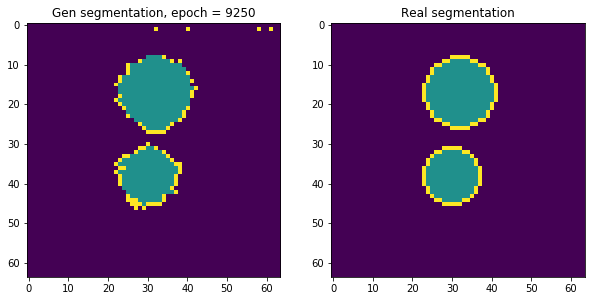

epoch - 9250, loss - 0.0155256344005
epoch - 9251, loss - 0.0116924801841
epoch - 9252, loss - 0.0105205597356
epoch - 9253, loss - 0.0126408943906
epoch - 9254, loss - 0.0120840286836
epoch - 9255, loss - 0.00982214510441
epoch - 9256, loss - 0.0103669576347
epoch - 9257, loss - 0.0117238163948
epoch - 9258, loss - 0.0110166296363
epoch - 9259, loss - 0.0102955624461
epoch - 9260, loss - 0.0118216928095
epoch - 9261, loss - 0.0132112167776
epoch - 9262, loss - 0.0138965789229
epoch - 9263, loss - 0.0150373606011
epoch - 9264, loss - 0.0182019285858
epoch - 9265, loss - 0.021243467927
epoch - 9266, loss - 0.025355912745
epoch - 9267, loss - 0.0299007631838
epoch - 9268, loss - 0.03741921857
epoch - 9269, loss - 0.0430146120489
epoch - 9270, loss - 0.0498049668968
epoch - 9271, loss - 0.0516163744032
epoch - 9272, loss - 0.0521196648479
epoch - 9273, loss - 0.0446985624731
epoch - 9274, loss - 0.0325473248959
epoch - 9275, loss - 0.0192557815462
epoch - 9276, loss - 0.0110549675301
epoc

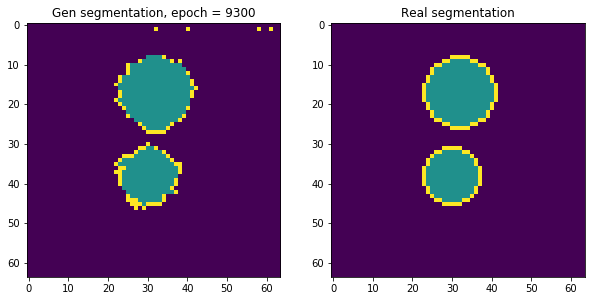

epoch - 9300, loss - 0.00859450455755
epoch - 9301, loss - 0.00888617802411
epoch - 9302, loss - 0.00887695886195
epoch - 9303, loss - 0.0087714381516
epoch - 9304, loss - 0.00869533978403
epoch - 9305, loss - 0.00911008287221
epoch - 9306, loss - 0.00973707903177
epoch - 9307, loss - 0.0107376165688
epoch - 9308, loss - 0.0119355935603
epoch - 9309, loss - 0.0132942963392
epoch - 9310, loss - 0.0141229573637
epoch - 9311, loss - 0.0152102410793
epoch - 9312, loss - 0.0163023564965
epoch - 9313, loss - 0.0182173885405
epoch - 9314, loss - 0.0197116062045
epoch - 9315, loss - 0.0221426002681
epoch - 9316, loss - 0.0247694477439
epoch - 9317, loss - 0.0298138745129
epoch - 9318, loss - 0.0360012613237
epoch - 9319, loss - 0.0451607592404
epoch - 9320, loss - 0.0550415441394
epoch - 9321, loss - 0.0622214227915
epoch - 9322, loss - 0.060047801584
epoch - 9323, loss - 0.0521761029959
epoch - 9324, loss - 0.0486330017447
epoch - 9325, loss - 0.0548671111465
epoch - 9326, loss - 0.0526983067

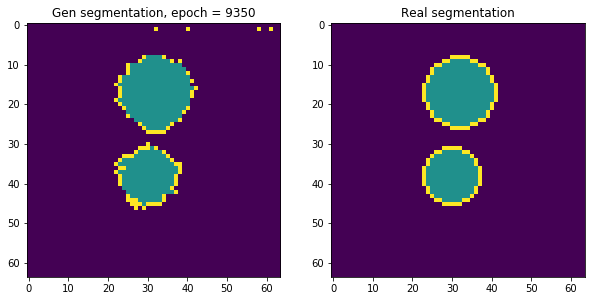

epoch - 9350, loss - 0.0106635941193
epoch - 9351, loss - 0.00991674978286
epoch - 9352, loss - 0.00994788482785
epoch - 9353, loss - 0.0107507323846
epoch - 9354, loss - 0.01021385286
epoch - 9355, loss - 0.0100704142824
epoch - 9356, loss - 0.0105355223641
epoch - 9357, loss - 0.0103126494214
epoch - 9358, loss - 0.00979606062174
epoch - 9359, loss - 0.0105801932514
epoch - 9360, loss - 0.0113468533382
epoch - 9361, loss - 0.0128495451063
epoch - 9362, loss - 0.0159109104425
epoch - 9363, loss - 0.0214124079794
epoch - 9364, loss - 0.0290739573538
epoch - 9365, loss - 0.0417966805398
epoch - 9366, loss - 0.0602904036641
epoch - 9367, loss - 0.0851915553212
epoch - 9368, loss - 0.113947845995
epoch - 9369, loss - 0.13303616643
epoch - 9370, loss - 0.13008864224
epoch - 9371, loss - 0.100548297167
epoch - 9372, loss - 0.0737405791879
epoch - 9373, loss - 0.0722994282842
epoch - 9374, loss - 0.0676837861538
epoch - 9375, loss - 0.0639399960637
epoch - 9376, loss - 0.0432969816029
epoch 

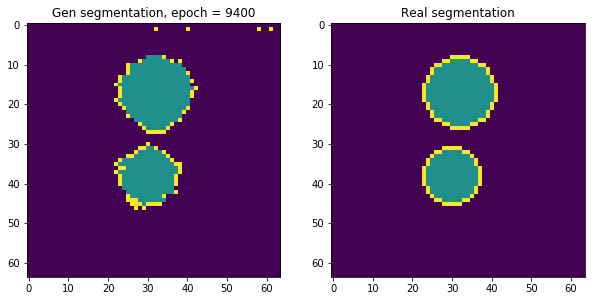

epoch - 9400, loss - 0.00930051226169
epoch - 9401, loss - 0.00785681605339
epoch - 9402, loss - 0.00796873494983
epoch - 9403, loss - 0.00783197954297
epoch - 9404, loss - 0.00747371651232
epoch - 9405, loss - 0.00735692773014
epoch - 9406, loss - 0.00699667166919
epoch - 9407, loss - 0.00670066289604
epoch - 9408, loss - 0.00680266134441
epoch - 9409, loss - 0.00664869090542
epoch - 9410, loss - 0.00654597394168
epoch - 9411, loss - 0.00666397437453
epoch - 9412, loss - 0.00688336696476
epoch - 9413, loss - 0.00714406464249
epoch - 9414, loss - 0.00759892212227
epoch - 9415, loss - 0.00834749080241
epoch - 9416, loss - 0.00994517654181
epoch - 9417, loss - 0.0118676805869
epoch - 9418, loss - 0.0152840083465
epoch - 9419, loss - 0.0196859389544
epoch - 9420, loss - 0.0269785299897
epoch - 9421, loss - 0.0355569534004
epoch - 9422, loss - 0.0488416701555
epoch - 9423, loss - 0.0610694289207
epoch - 9424, loss - 0.0771833285689
epoch - 9425, loss - 0.0828653201461
epoch - 9426, loss - 

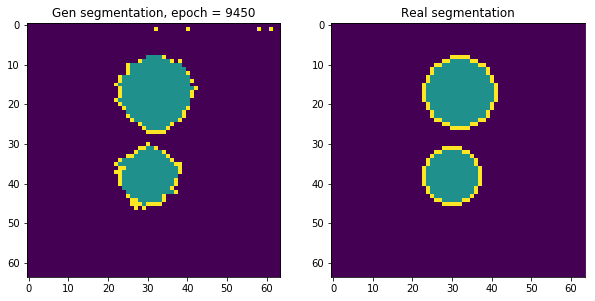

epoch - 9450, loss - 0.00901495851576
epoch - 9451, loss - 0.0081138657406
epoch - 9452, loss - 0.00818136893213
epoch - 9453, loss - 0.00794560275972
epoch - 9454, loss - 0.00782620720565
epoch - 9455, loss - 0.00801404006779
epoch - 9456, loss - 0.00854535680264
epoch - 9457, loss - 0.00872994400561
epoch - 9458, loss - 0.00801155157387
epoch - 9459, loss - 0.0068218074739
epoch - 9460, loss - 0.00597989466041
epoch - 9461, loss - 0.00590234389529
epoch - 9462, loss - 0.0061465818435
epoch - 9463, loss - 0.00615613069385
epoch - 9464, loss - 0.00615540053695
epoch - 9465, loss - 0.00627161934972
epoch - 9466, loss - 0.00644185068086
epoch - 9467, loss - 0.00671338615939
epoch - 9468, loss - 0.00675441790372
epoch - 9469, loss - 0.00668547861278
epoch - 9470, loss - 0.00658703222871
epoch - 9471, loss - 0.00650091655552
epoch - 9472, loss - 0.00625038007274
epoch - 9473, loss - 0.00591683853418
epoch - 9474, loss - 0.00575891602784
epoch - 9475, loss - 0.00597095163539
epoch - 9476, l

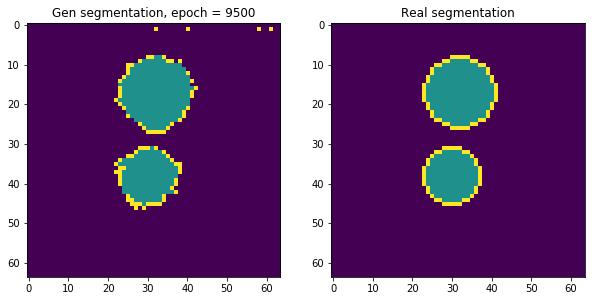

epoch - 9500, loss - 0.0511729717255
epoch - 9501, loss - 0.0544126965106
epoch - 9502, loss - 0.0487388409674
epoch - 9503, loss - 0.0372566618025
epoch - 9504, loss - 0.038999132812
epoch - 9505, loss - 0.0390555784106
epoch - 9506, loss - 0.0316910669208
epoch - 9507, loss - 0.0282193534076
epoch - 9508, loss - 0.0278689768165
epoch - 9509, loss - 0.025733936578
epoch - 9510, loss - 0.0212733522058
epoch - 9511, loss - 0.0203019529581
epoch - 9512, loss - 0.0215061120689
epoch - 9513, loss - 0.0185736063868
epoch - 9514, loss - 0.0161066763103
epoch - 9515, loss - 0.0165411531925
epoch - 9516, loss - 0.0156775601208
epoch - 9517, loss - 0.013096710667
epoch - 9518, loss - 0.0128447664902
epoch - 9519, loss - 0.0123380990699
epoch - 9520, loss - 0.0113604720682
epoch - 9521, loss - 0.0104435877874
epoch - 9522, loss - 0.00994053948671
epoch - 9523, loss - 0.0100107947364
epoch - 9524, loss - 0.00923427939415
epoch - 9525, loss - 0.00877462700009
epoch - 9526, loss - 0.00858127232641


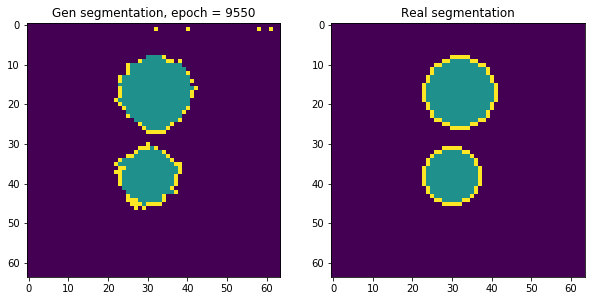

epoch - 9550, loss - 0.0282585471869
epoch - 9551, loss - 0.0115819498897
epoch - 9552, loss - 0.0110217956826
epoch - 9553, loss - 0.022358680144
epoch - 9554, loss - 0.034108068794
epoch - 9555, loss - 0.0373285450041
epoch - 9556, loss - 0.0289245732129
epoch - 9557, loss - 0.0160266738385
epoch - 9558, loss - 0.00847106985748
epoch - 9559, loss - 0.00995410140604
epoch - 9560, loss - 0.0160583555698
epoch - 9561, loss - 0.0201726183295
epoch - 9562, loss - 0.020264390856
epoch - 9563, loss - 0.0169459301978
epoch - 9564, loss - 0.0129938488826
epoch - 9565, loss - 0.00954885035753
epoch - 9566, loss - 0.00817028060555
epoch - 9567, loss - 0.00976310297847
epoch - 9568, loss - 0.0121658816934
epoch - 9569, loss - 0.013407157734
epoch - 9570, loss - 0.0120610771701
epoch - 9571, loss - 0.00985475908965
epoch - 9572, loss - 0.00826602987945
epoch - 9573, loss - 0.00768200214952
epoch - 9574, loss - 0.00769790261984
epoch - 9575, loss - 0.00772407092154
epoch - 9576, loss - 0.007924256

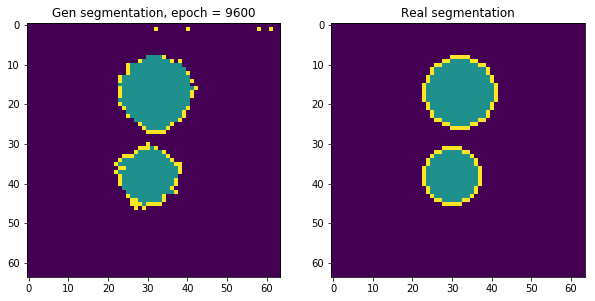

epoch - 9600, loss - 0.0190641917288
epoch - 9601, loss - 0.0207848325372
epoch - 9602, loss - 0.0269073117524
epoch - 9603, loss - 0.0332244224846
epoch - 9604, loss - 0.042340811342
epoch - 9605, loss - 0.0464740395546
epoch - 9606, loss - 0.0525568276644
epoch - 9607, loss - 0.0567527972162
epoch - 9608, loss - 0.0625181868672
epoch - 9609, loss - 0.0783486887813
epoch - 9610, loss - 0.0863978043199
epoch - 9611, loss - 0.0872603654861
epoch - 9612, loss - 0.0577197000384
epoch - 9613, loss - 0.0470373742282
epoch - 9614, loss - 0.0552120618522
epoch - 9615, loss - 0.044843647629
epoch - 9616, loss - 0.0319075211883
epoch - 9617, loss - 0.0300922747701
epoch - 9618, loss - 0.0323115959764
epoch - 9619, loss - 0.0283497311175
epoch - 9620, loss - 0.0243472773582
epoch - 9621, loss - 0.0265494734049
epoch - 9622, loss - 0.0238407552242
epoch - 9623, loss - 0.018596868962
epoch - 9624, loss - 0.0191301535815
epoch - 9625, loss - 0.0178167037666
epoch - 9626, loss - 0.0140256285667
epoc

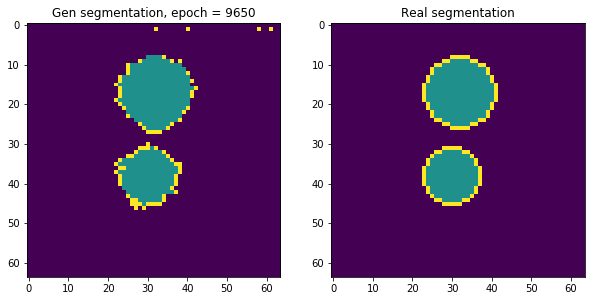

epoch - 9650, loss - 0.0367361940444
epoch - 9651, loss - 0.0416257046163
epoch - 9652, loss - 0.0488213710487
epoch - 9653, loss - 0.0519174262881
epoch - 9654, loss - 0.0554323382676
epoch - 9655, loss - 0.0530361868441
epoch - 9656, loss - 0.0479253977537
epoch - 9657, loss - 0.0413502641022
epoch - 9658, loss - 0.0331268832088
epoch - 9659, loss - 0.0284898560494
epoch - 9660, loss - 0.0274360589683
epoch - 9661, loss - 0.0318994857371
epoch - 9662, loss - 0.0372278727591
epoch - 9663, loss - 0.0401310063899
epoch - 9664, loss - 0.0384303890169
epoch - 9665, loss - 0.0310636740178
epoch - 9666, loss - 0.0197728909552
epoch - 9667, loss - 0.0134267173707
epoch - 9668, loss - 0.0167890228331
epoch - 9669, loss - 0.0218294560909
epoch - 9670, loss - 0.0201217960566
epoch - 9671, loss - 0.0145950783044
epoch - 9672, loss - 0.0134058771655
epoch - 9673, loss - 0.0164521858096
epoch - 9674, loss - 0.0175977181643
epoch - 9675, loss - 0.0151254404336
epoch - 9676, loss - 0.0136998035014
e

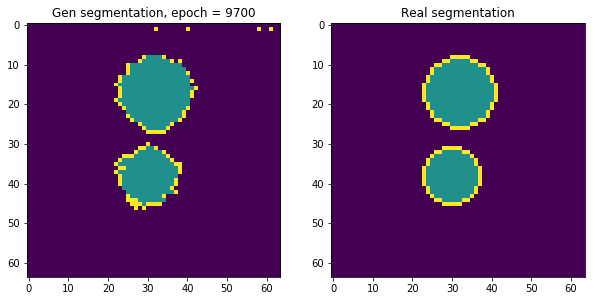

epoch - 9700, loss - 0.0227040890604
epoch - 9701, loss - 0.0286123305559
epoch - 9702, loss - 0.0347946099937
epoch - 9703, loss - 0.04481459409
epoch - 9704, loss - 0.0530288629234
epoch - 9705, loss - 0.0645374730229
epoch - 9706, loss - 0.0650894939899
epoch - 9707, loss - 0.0604663230479
epoch - 9708, loss - 0.0452988818288
epoch - 9709, loss - 0.0316443443298
epoch - 9710, loss - 0.0236119478941
epoch - 9711, loss - 0.02330696024
epoch - 9712, loss - 0.026254940778
epoch - 9713, loss - 0.0298780854791
epoch - 9714, loss - 0.0298837274313
epoch - 9715, loss - 0.0266675148159
epoch - 9716, loss - 0.0258028358221
epoch - 9717, loss - 0.027481559664
epoch - 9718, loss - 0.0224462635815
epoch - 9719, loss - 0.0150440866128
epoch - 9720, loss - 0.0126685984433
epoch - 9721, loss - 0.015597358346
epoch - 9722, loss - 0.0168606415391
epoch - 9723, loss - 0.0138106737286
epoch - 9724, loss - 0.0133216539398
epoch - 9725, loss - 0.0148743912578
epoch - 9726, loss - 0.0135559663177
epoch - 

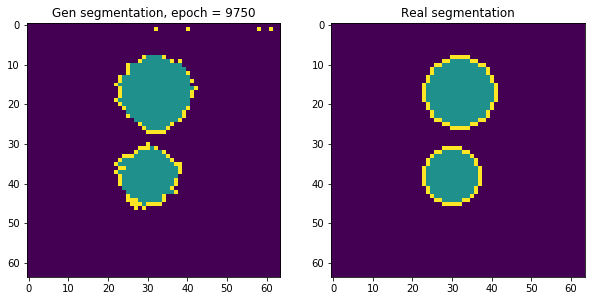

epoch - 9750, loss - 0.0101427547634
epoch - 9751, loss - 0.011622977443
epoch - 9752, loss - 0.0145355593413
epoch - 9753, loss - 0.0186093151569
epoch - 9754, loss - 0.0267646387219
epoch - 9755, loss - 0.0368617139757
epoch - 9756, loss - 0.0515262261033
epoch - 9757, loss - 0.0622998178005
epoch - 9758, loss - 0.0719198808074
epoch - 9759, loss - 0.0686487108469
epoch - 9760, loss - 0.0642054229975
epoch - 9761, loss - 0.0650218650699
epoch - 9762, loss - 0.0822964906693
epoch - 9763, loss - 0.114299453795
epoch - 9764, loss - 0.126649811864
epoch - 9765, loss - 0.127648666501
epoch - 9766, loss - 0.082344353199
epoch - 9767, loss - 0.082578368485
epoch - 9768, loss - 0.0919735506177
epoch - 9769, loss - 0.0479372702539
epoch - 9770, loss - 0.0540077351034
epoch - 9771, loss - 0.0708445236087
epoch - 9772, loss - 0.0367577746511
epoch - 9773, loss - 0.0461601242423
epoch - 9774, loss - 0.0503142736852
epoch - 9775, loss - 0.0272327959538
epoch - 9776, loss - 0.0396619960666
epoch -

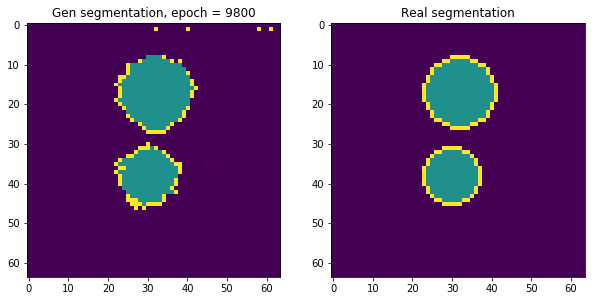

epoch - 9800, loss - 0.00777999870479
epoch - 9801, loss - 0.0078187789768
epoch - 9802, loss - 0.00742361787707
epoch - 9803, loss - 0.007384727709
epoch - 9804, loss - 0.00741704134271
epoch - 9805, loss - 0.00736717227846
epoch - 9806, loss - 0.00776546355337
epoch - 9807, loss - 0.008329981938
epoch - 9808, loss - 0.00924962572753
epoch - 9809, loss - 0.0110602863133
epoch - 9810, loss - 0.0135008078068
epoch - 9811, loss - 0.0178555939347
epoch - 9812, loss - 0.0237081032246
epoch - 9813, loss - 0.0335317254066
epoch - 9814, loss - 0.0451912507415
epoch - 9815, loss - 0.0636600255966
epoch - 9816, loss - 0.0797053724527
epoch - 9817, loss - 0.0985347554088
epoch - 9818, loss - 0.0992472171783
epoch - 9819, loss - 0.0867578089237
epoch - 9820, loss - 0.0541966855526
epoch - 9821, loss - 0.0238291397691
epoch - 9822, loss - 0.0158700589091
epoch - 9823, loss - 0.0294757187366
epoch - 9824, loss - 0.0469153039157
epoch - 9825, loss - 0.0493184998631
epoch - 9826, loss - 0.03736464306

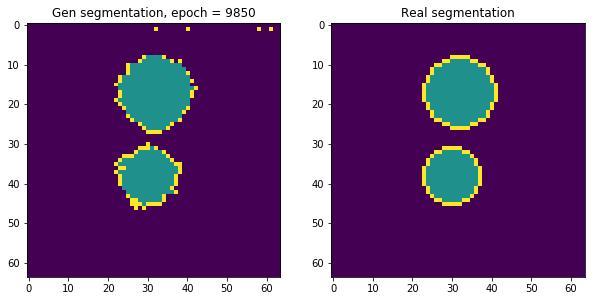

epoch - 9850, loss - 0.00681236479431
epoch - 9851, loss - 0.00732867233455
epoch - 9852, loss - 0.00752925872803
epoch - 9853, loss - 0.0071836290881
epoch - 9854, loss - 0.00683206878603
epoch - 9855, loss - 0.00641254056245
epoch - 9856, loss - 0.0059487009421
epoch - 9857, loss - 0.00527698127553
epoch - 9858, loss - 0.00496631115675
epoch - 9859, loss - 0.00512520270422
epoch - 9860, loss - 0.00549545325339
epoch - 9861, loss - 0.00572462566197
epoch - 9862, loss - 0.00556247401983
epoch - 9863, loss - 0.00537756923586
epoch - 9864, loss - 0.00524965487421
epoch - 9865, loss - 0.00526257464662
epoch - 9866, loss - 0.00538671016693
epoch - 9867, loss - 0.00556442886591
epoch - 9868, loss - 0.00593494996428
epoch - 9869, loss - 0.00651242863387
epoch - 9870, loss - 0.00779569428414
epoch - 9871, loss - 0.00942381471395
epoch - 9872, loss - 0.0119793610647
epoch - 9873, loss - 0.0139845889062
epoch - 9874, loss - 0.0156861189753
epoch - 9875, loss - 0.015756091103
epoch - 9876, loss 

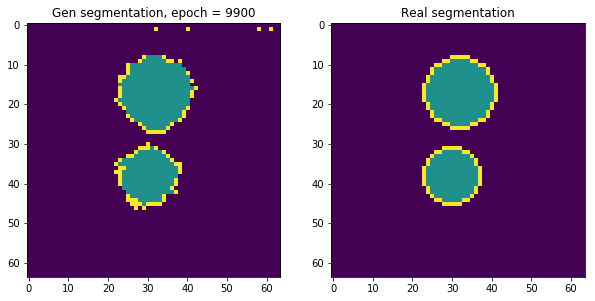

epoch - 9900, loss - 0.0430575124919
epoch - 9901, loss - 0.0429074317217
epoch - 9902, loss - 0.0411015190184
epoch - 9903, loss - 0.0425090864301
epoch - 9904, loss - 0.0401436500251
epoch - 9905, loss - 0.0389718152583
epoch - 9906, loss - 0.0333304181695
epoch - 9907, loss - 0.0283969081938
epoch - 9908, loss - 0.0298320651054
epoch - 9909, loss - 0.0240488480777
epoch - 9910, loss - 0.0195274651051
epoch - 9911, loss - 0.0192321166396
epoch - 9912, loss - 0.0155226401985
epoch - 9913, loss - 0.015782456845
epoch - 9914, loss - 0.01856017299
epoch - 9915, loss - 0.0170843806118
epoch - 9916, loss - 0.0149707840756
epoch - 9917, loss - 0.0135444933549
epoch - 9918, loss - 0.010934220627
epoch - 9919, loss - 0.00977670028806
epoch - 9920, loss - 0.00930254906416
epoch - 9921, loss - 0.00924839451909
epoch - 9922, loss - 0.00955143477768
epoch - 9923, loss - 0.00909857172519
epoch - 9924, loss - 0.00841743405908
epoch - 9925, loss - 0.0080090360716
epoch - 9926, loss - 0.0080346073955

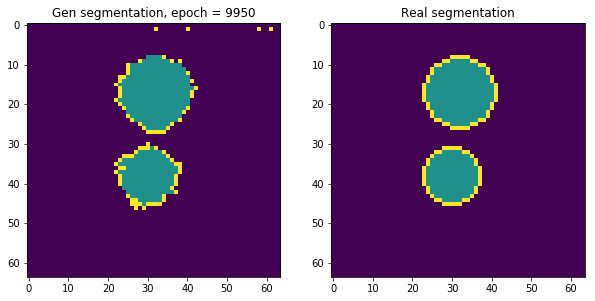

epoch - 9950, loss - 0.0144118117169
epoch - 9951, loss - 0.0152666466311
epoch - 9952, loss - 0.0140045620501
epoch - 9953, loss - 0.0106924064457
epoch - 9954, loss - 0.0072345752269
epoch - 9955, loss - 0.00656305719167
epoch - 9956, loss - 0.00918166898191
epoch - 9957, loss - 0.012393867597
epoch - 9958, loss - 0.0154295712709
epoch - 9959, loss - 0.0159213617444
epoch - 9960, loss - 0.0155349355191
epoch - 9961, loss - 0.0149602843449
epoch - 9962, loss - 0.0188045371324
epoch - 9963, loss - 0.0292246080935
epoch - 9964, loss - 0.0489705242217
epoch - 9965, loss - 0.080397747457
epoch - 9966, loss - 0.134169384837
epoch - 9967, loss - 0.199955403805
epoch - 9968, loss - 0.294674485922
epoch - 9969, loss - 0.286653190851
epoch - 9970, loss - 0.213409304619
epoch - 9971, loss - 0.101139597595
epoch - 9972, loss - 0.109910011292
epoch - 9973, loss - 0.167464077473
epoch - 9974, loss - 0.149101302028
epoch - 9975, loss - 0.0842817649245
epoch - 9976, loss - 0.0709767118096
epoch - 99

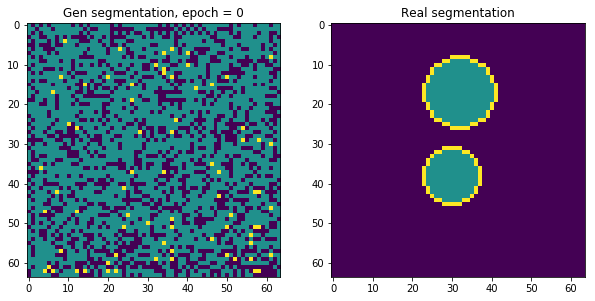

epoch - 0, loss - 116.602432251
epoch - 1, loss - 48.2216072083
epoch - 2, loss - 20.9639987946
epoch - 3, loss - 11.3065061569
epoch - 4, loss - 9.06533813477
epoch - 5, loss - 8.34460735321
epoch - 6, loss - 7.44191455841
epoch - 7, loss - 6.75974464417
epoch - 8, loss - 6.43873882294
epoch - 9, loss - 6.28043985367
epoch - 10, loss - 6.22936630249
epoch - 11, loss - 6.26119089127
epoch - 12, loss - 6.33469581604
epoch - 13, loss - 6.40977525711
epoch - 14, loss - 6.46061420441
epoch - 15, loss - 6.47310304642
epoch - 16, loss - 6.44436836243
epoch - 17, loss - 6.38105678558
epoch - 18, loss - 6.2973690033
epoch - 19, loss - 6.21017980576
epoch - 20, loss - 6.13467884064
epoch - 21, loss - 6.08133459091
epoch - 22, loss - 6.05448532104
epoch - 23, loss - 6.05230998993
epoch - 24, loss - 6.06777620316
epoch - 25, loss - 6.09101200104
epoch - 26, loss - 6.11196947098
epoch - 27, loss - 6.12288427353
epoch - 28, loss - 6.11998701096
epoch - 29, loss - 6.10366678238
epoch - 30, loss - 6.

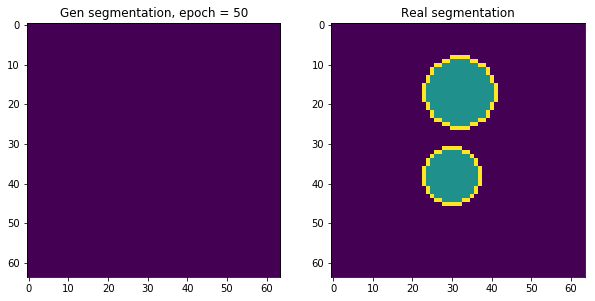

epoch - 50, loss - 5.91764163971
epoch - 51, loss - 5.91343307495
epoch - 52, loss - 5.90757131577
epoch - 53, loss - 5.90070152283
epoch - 54, loss - 5.89371490479
epoch - 55, loss - 5.88740825653
epoch - 56, loss - 5.88226270676
epoch - 57, loss - 5.87831830978
epoch - 58, loss - 5.87522554398
epoch - 59, loss - 5.87242794037
epoch - 60, loss - 5.86935806274
epoch - 61, loss - 5.86564540863
epoch - 62, loss - 5.86119031906
epoch - 63, loss - 5.85615158081
epoch - 64, loss - 5.85085725784
epoch - 65, loss - 5.84564638138
epoch - 66, loss - 5.84074926376
epoch - 67, loss - 5.83621788025
epoch - 68, loss - 5.83192873001
epoch - 69, loss - 5.82765293121
epoch - 70, loss - 5.82314920425
epoch - 71, loss - 5.81824493408
epoch - 72, loss - 5.81288051605
epoch - 73, loss - 5.80711746216
epoch - 74, loss - 5.80106019974
epoch - 75, loss - 5.79481458664
epoch - 76, loss - 5.78846216202
epoch - 77, loss - 5.78199338913
epoch - 78, loss - 5.77530622482
epoch - 79, loss - 5.76826763153
epoch - 80

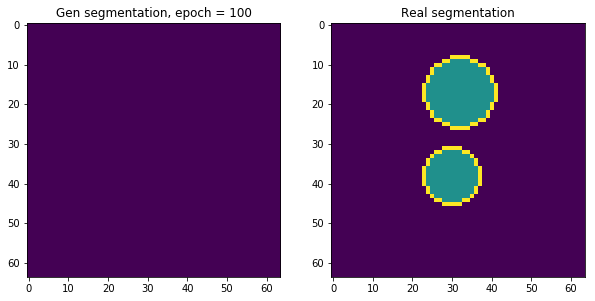

epoch - 100, loss - 5.44290447235
epoch - 101, loss - 5.4202671051
epoch - 102, loss - 5.39668607712
epoch - 103, loss - 5.37220859528
epoch - 104, loss - 5.34797000885
epoch - 105, loss - 5.32473945618
epoch - 106, loss - 5.30027294159
epoch - 107, loss - 5.27592515945
epoch - 108, loss - 5.25051879883
epoch - 109, loss - 5.22374677658
epoch - 110, loss - 5.19464206696
epoch - 111, loss - 5.16435146332
epoch - 112, loss - 5.13154602051
epoch - 113, loss - 5.0939207077
epoch - 114, loss - 5.06143951416
epoch - 115, loss - 5.05976867676
epoch - 116, loss - 5.23654508591
epoch - 117, loss - 4.99381256104
epoch - 118, loss - 5.0202870369
epoch - 119, loss - 5.0012512207
epoch - 120, loss - 4.96822404861
epoch - 121, loss - 4.89982366562
epoch - 122, loss - 4.84737491608
epoch - 123, loss - 4.80932474136
epoch - 124, loss - 4.77503538132
epoch - 125, loss - 4.75197505951
epoch - 126, loss - 4.71539974213
epoch - 127, loss - 4.66570472717
epoch - 128, loss - 4.61829853058
epoch - 129, loss 

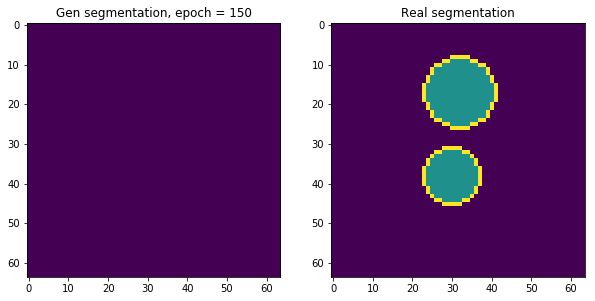

epoch - 150, loss - 4.10414838791
epoch - 151, loss - 4.09383916855
epoch - 152, loss - 4.08517074585
epoch - 153, loss - 4.07459163666
epoch - 154, loss - 4.06744241714
epoch - 155, loss - 4.05744361877
epoch - 156, loss - 4.04873752594
epoch - 157, loss - 4.04106664658
epoch - 158, loss - 4.03278207779
epoch - 159, loss - 4.02616405487
epoch - 160, loss - 4.01999378204
epoch - 161, loss - 4.01222372055
epoch - 162, loss - 4.00586175919
epoch - 163, loss - 3.99997258186
epoch - 164, loss - 3.99318647385
epoch - 165, loss - 3.98714756966
epoch - 166, loss - 3.98135471344
epoch - 167, loss - 3.9756565094
epoch - 168, loss - 3.97052168846
epoch - 169, loss - 3.96499967575
epoch - 170, loss - 3.95948648453
epoch - 171, loss - 3.95481443405
epoch - 172, loss - 3.94988203049
epoch - 173, loss - 3.94505882263
epoch - 174, loss - 3.94065332413
epoch - 175, loss - 3.93601989746
epoch - 176, loss - 3.93164134026
epoch - 177, loss - 3.92752027512
epoch - 178, loss - 3.9232506752
epoch - 179, los

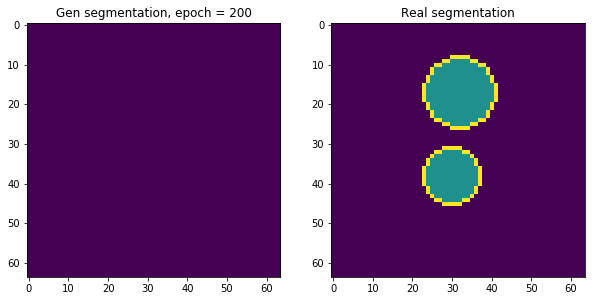

epoch - 200, loss - 3.84796953201
epoch - 201, loss - 3.84504747391
epoch - 202, loss - 3.84215474129
epoch - 203, loss - 3.83930754662
epoch - 204, loss - 3.83646464348
epoch - 205, loss - 3.83368062973
epoch - 206, loss - 3.83090591431
epoch - 207, loss - 3.82817983627
epoch - 208, loss - 3.8254570961
epoch - 209, loss - 3.82277297974
epoch - 210, loss - 3.82011914253
epoch - 211, loss - 3.81748604774
epoch - 212, loss - 3.81487822533
epoch - 213, loss - 3.81228756905
epoch - 214, loss - 3.80972647667
epoch - 215, loss - 3.80718207359
epoch - 216, loss - 3.80466127396
epoch - 217, loss - 3.80214977264
epoch - 218, loss - 3.79965353012
epoch - 219, loss - 3.79717803001
epoch - 220, loss - 3.79471468925
epoch - 221, loss - 3.79226636887
epoch - 222, loss - 3.78982806206
epoch - 223, loss - 3.78741145134
epoch - 224, loss - 3.78500676155
epoch - 225, loss - 3.78262519836
epoch - 226, loss - 3.78026366234
epoch - 227, loss - 3.77795124054
epoch - 228, loss - 3.77577090263
epoch - 229, lo

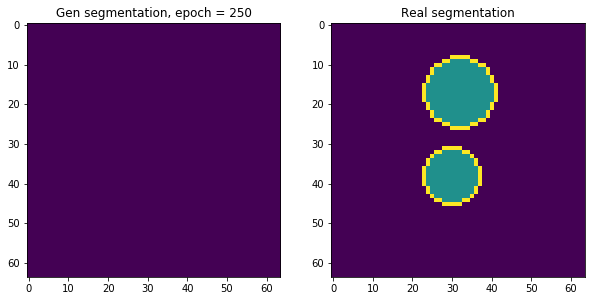

epoch - 250, loss - 3.72747612
epoch - 251, loss - 3.7257039547
epoch - 252, loss - 3.72360515594
epoch - 253, loss - 3.72239804268
epoch - 254, loss - 3.72018241882
epoch - 255, loss - 3.71903276443
epoch - 256, loss - 3.71676778793
epoch - 257, loss - 3.71487164497
epoch - 258, loss - 3.71248793602
epoch - 259, loss - 3.70963478088
epoch - 260, loss - 3.70699691772
epoch - 261, loss - 3.70390558243
epoch - 262, loss - 3.70158910751
epoch - 263, loss - 3.69913840294
epoch - 264, loss - 3.69716191292
epoch - 265, loss - 3.6953830719
epoch - 266, loss - 3.69357681274
epoch - 267, loss - 3.69220352173
epoch - 268, loss - 3.6907980442
epoch - 269, loss - 3.68974542618
epoch - 270, loss - 3.68861031532
epoch - 271, loss - 3.68737053871
epoch - 272, loss - 3.68586683273
epoch - 273, loss - 3.68317246437
epoch - 274, loss - 3.67959833145
epoch - 275, loss - 3.6757311821
epoch - 276, loss - 3.67235803604
epoch - 277, loss - 3.66982626915
epoch - 278, loss - 3.66807556152
epoch - 279, loss - 3

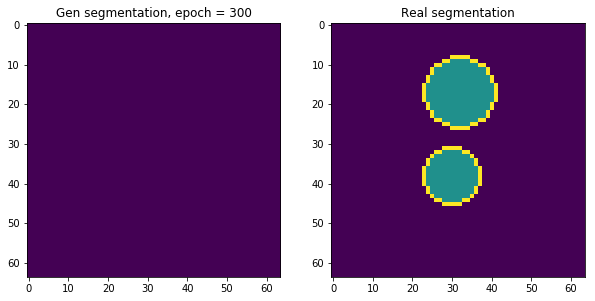

epoch - 300, loss - 3.62094974518
epoch - 301, loss - 3.62052631378
epoch - 302, loss - 3.62057375908
epoch - 303, loss - 3.61964845657
epoch - 304, loss - 3.61728906631
epoch - 305, loss - 3.61326122284
epoch - 306, loss - 3.60890054703
epoch - 307, loss - 3.6054649353
epoch - 308, loss - 3.60346412659
epoch - 309, loss - 3.60242033005
epoch - 310, loss - 3.60158061981
epoch - 311, loss - 3.60052394867
epoch - 312, loss - 3.59856176376
epoch - 313, loss - 3.59585666656
epoch - 314, loss - 3.59230732918
epoch - 315, loss - 3.58872556686
epoch - 316, loss - 3.585521698
epoch - 317, loss - 3.58300280571
epoch - 318, loss - 3.5810713768
epoch - 319, loss - 3.57959294319
epoch - 320, loss - 3.57849884033
epoch - 321, loss - 3.57782149315
epoch - 322, loss - 3.57802867889
epoch - 323, loss - 3.57800769806
epoch - 324, loss - 3.57682180405
epoch - 325, loss - 3.57236719131
epoch - 326, loss - 3.5661008358
epoch - 327, loss - 3.56058931351
epoch - 328, loss - 3.55788707733
epoch - 329, loss -

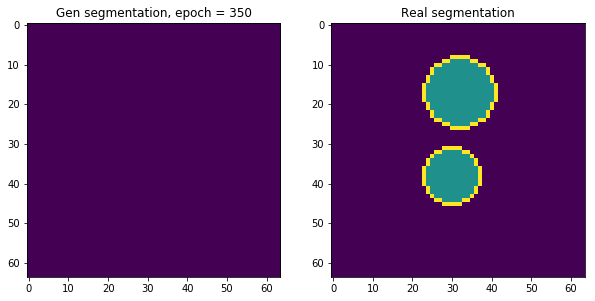

epoch - 350, loss - 3.51611971855
epoch - 351, loss - 3.51035618782
epoch - 352, loss - 3.50018548965
epoch - 353, loss - 3.4946334362
epoch - 354, loss - 3.49468421936
epoch - 355, loss - 3.49469780922
epoch - 356, loss - 3.49169182777
epoch - 357, loss - 3.48789215088
epoch - 358, loss - 3.48781228065
epoch - 359, loss - 3.48299789429
epoch - 360, loss - 3.47581863403
epoch - 361, loss - 3.47206687927
epoch - 362, loss - 3.47130584717
epoch - 363, loss - 3.46862697601
epoch - 364, loss - 3.46428442001
epoch - 365, loss - 3.46375536919
epoch - 366, loss - 3.46492910385
epoch - 367, loss - 3.46308994293
epoch - 368, loss - 3.46066379547
epoch - 369, loss - 3.46108317375
epoch - 370, loss - 3.45300912857
epoch - 371, loss - 3.4433350563
epoch - 372, loss - 3.43696904182
epoch - 373, loss - 3.43466949463
epoch - 374, loss - 3.43452644348
epoch - 375, loss - 3.43570017815
epoch - 376, loss - 3.439047575
epoch - 377, loss - 3.43677091599
epoch - 378, loss - 3.42714595795
epoch - 379, loss 

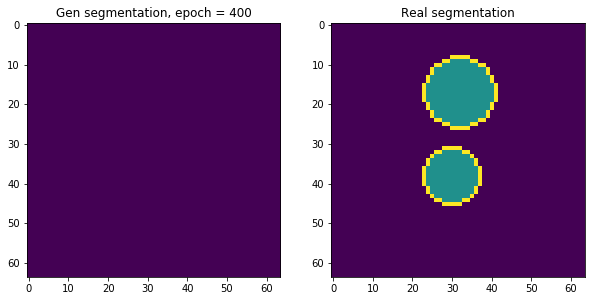

epoch - 400, loss - 3.35580778122
epoch - 401, loss - 3.35147166252
epoch - 402, loss - 3.34558534622
epoch - 403, loss - 3.34295701981
epoch - 404, loss - 3.33595991135
epoch - 405, loss - 3.32765698433
epoch - 406, loss - 3.32200598717
epoch - 407, loss - 3.31855630875
epoch - 408, loss - 3.31654334068
epoch - 409, loss - 3.3168861866
epoch - 410, loss - 3.32180166245
epoch - 411, loss - 3.32252812386
epoch - 412, loss - 3.32899713516
epoch - 413, loss - 3.32030367851
epoch - 414, loss - 3.30928039551
epoch - 415, loss - 3.29383397102
epoch - 416, loss - 3.29361772537
epoch - 417, loss - 3.29643583298
epoch - 418, loss - 3.29071164131
epoch - 419, loss - 3.28570508957
epoch - 420, loss - 3.28437662125
epoch - 421, loss - 3.27577424049
epoch - 422, loss - 3.27284836769
epoch - 423, loss - 3.26872873306
epoch - 424, loss - 3.26287889481
epoch - 425, loss - 3.26381921768
epoch - 426, loss - 3.25907468796
epoch - 427, loss - 3.25191497803
epoch - 428, loss - 3.24516654015
epoch - 429, lo

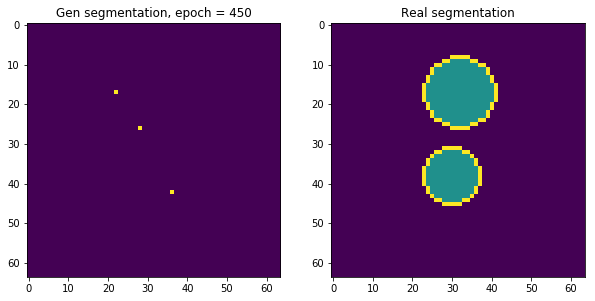

epoch - 450, loss - 3.1644654274
epoch - 451, loss - 3.15978384018
epoch - 452, loss - 3.15232348442
epoch - 453, loss - 3.14878582954
epoch - 454, loss - 3.15053248405
epoch - 455, loss - 3.16183662415
epoch - 456, loss - 3.16589689255
epoch - 457, loss - 3.14474749565
epoch - 458, loss - 3.14139652252
epoch - 459, loss - 3.13836359978
epoch - 460, loss - 3.14266252518
epoch - 461, loss - 3.13250136375
epoch - 462, loss - 3.11624479294
epoch - 463, loss - 3.1133787632
epoch - 464, loss - 3.11954760551
epoch - 465, loss - 3.11395931244
epoch - 466, loss - 3.10262441635
epoch - 467, loss - 3.1025891304
epoch - 468, loss - 3.09395909309
epoch - 469, loss - 3.092274189
epoch - 470, loss - 3.09198641777
epoch - 471, loss - 3.0882589817
epoch - 472, loss - 3.09002304077
epoch - 473, loss - 3.0867228508
epoch - 474, loss - 3.08744716644
epoch - 475, loss - 3.09025287628
epoch - 476, loss - 3.07559704781
epoch - 477, loss - 3.06847572327
epoch - 478, loss - 3.06437301636
epoch - 479, loss - 3

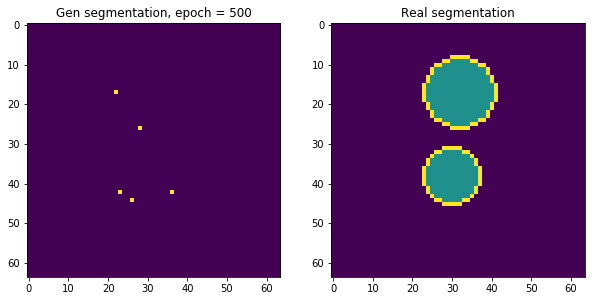

epoch - 500, loss - 2.97726798058
epoch - 501, loss - 2.98155283928
epoch - 502, loss - 2.97506690025
epoch - 503, loss - 2.96474885941
epoch - 504, loss - 2.96413588524
epoch - 505, loss - 2.95299386978
epoch - 506, loss - 2.95012283325
epoch - 507, loss - 2.94706320763
epoch - 508, loss - 2.94080996513
epoch - 509, loss - 2.93424630165
epoch - 510, loss - 2.92953324318
epoch - 511, loss - 2.92411589622
epoch - 512, loss - 2.92008876801
epoch - 513, loss - 2.91437578201
epoch - 514, loss - 2.91180276871
epoch - 515, loss - 2.90678262711
epoch - 516, loss - 2.90438985825
epoch - 517, loss - 2.90322089195
epoch - 518, loss - 2.9035422802
epoch - 519, loss - 2.90146446228
epoch - 520, loss - 2.90115427971
epoch - 521, loss - 2.89708328247
epoch - 522, loss - 2.89196968079
epoch - 523, loss - 2.88045048714
epoch - 524, loss - 2.8681371212
epoch - 525, loss - 2.86147689819
epoch - 526, loss - 2.86167812347
epoch - 527, loss - 2.86010456085
epoch - 528, loss - 2.85659456253
epoch - 529, los

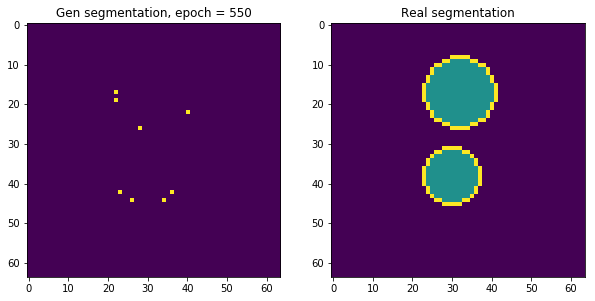

epoch - 550, loss - 2.77721595764
epoch - 551, loss - 2.77197957039
epoch - 552, loss - 2.75047898293
epoch - 553, loss - 2.74326229095
epoch - 554, loss - 2.75499606133
epoch - 555, loss - 2.75801849365
epoch - 556, loss - 2.75049686432
epoch - 557, loss - 2.72974205017
epoch - 558, loss - 2.71601867676
epoch - 559, loss - 2.71675491333
epoch - 560, loss - 2.72506308556
epoch - 561, loss - 2.72595405579
epoch - 562, loss - 2.72172212601
epoch - 563, loss - 2.70447540283
epoch - 564, loss - 2.69764852524
epoch - 565, loss - 2.70502281189
epoch - 566, loss - 2.70139241219
epoch - 567, loss - 2.68680047989
epoch - 568, loss - 2.67441534996
epoch - 569, loss - 2.66645288467
epoch - 570, loss - 2.66685938835
epoch - 571, loss - 2.66459107399
epoch - 572, loss - 2.65304279327
epoch - 573, loss - 2.64437460899
epoch - 574, loss - 2.63740801811
epoch - 575, loss - 2.63288521767
epoch - 576, loss - 2.63289237022
epoch - 577, loss - 2.6329407692
epoch - 578, loss - 2.63896751404
epoch - 579, lo

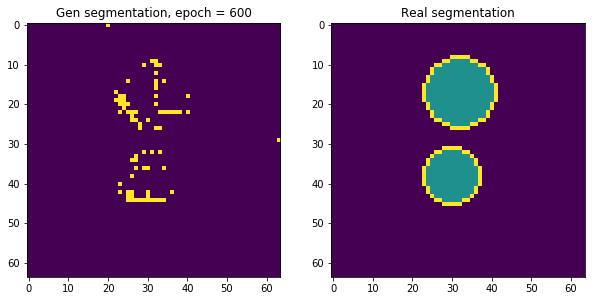

epoch - 600, loss - 2.54302310944
epoch - 601, loss - 2.55219888687
epoch - 602, loss - 2.56105184555
epoch - 603, loss - 2.51520562172
epoch - 604, loss - 2.52891540527
epoch - 605, loss - 2.54174041748
epoch - 606, loss - 2.52916574478
epoch - 607, loss - 2.52791905403
epoch - 608, loss - 2.51075267792
epoch - 609, loss - 2.50191283226
epoch - 610, loss - 2.48987960815
epoch - 611, loss - 2.48277807236
epoch - 612, loss - 2.47415661812
epoch - 613, loss - 2.46443629265
epoch - 614, loss - 2.45622968674
epoch - 615, loss - 2.44826245308
epoch - 616, loss - 2.44160985947
epoch - 617, loss - 2.43102478981
epoch - 618, loss - 2.43018198013
epoch - 619, loss - 2.41767120361
epoch - 620, loss - 2.41510057449
epoch - 621, loss - 2.41305279732
epoch - 622, loss - 2.40330338478
epoch - 623, loss - 2.40475344658
epoch - 624, loss - 2.40075397491
epoch - 625, loss - 2.40062141418
epoch - 626, loss - 2.40023612976
epoch - 627, loss - 2.39244103432
epoch - 628, loss - 2.38864040375
epoch - 629, l

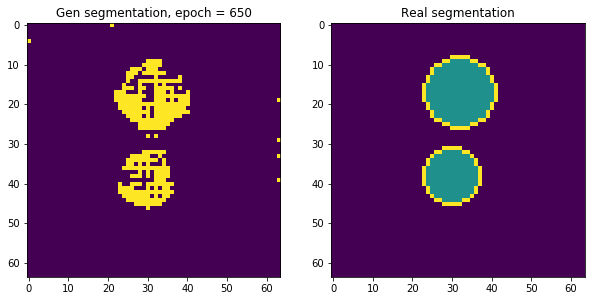

epoch - 650, loss - 2.25713610649
epoch - 651, loss - 2.26034450531
epoch - 652, loss - 2.25827169418
epoch - 653, loss - 2.25340795517
epoch - 654, loss - 2.2686829567
epoch - 655, loss - 2.26224184036
epoch - 656, loss - 2.26736283302
epoch - 657, loss - 2.24475455284
epoch - 658, loss - 2.22479224205
epoch - 659, loss - 2.22082662582
epoch - 660, loss - 2.22404098511
epoch - 661, loss - 2.20772147179
epoch - 662, loss - 2.20455574989
epoch - 663, loss - 2.19927120209
epoch - 664, loss - 2.19255304337
epoch - 665, loss - 2.19140529633
epoch - 666, loss - 2.18328595161
epoch - 667, loss - 2.17539525032
epoch - 668, loss - 2.17151427269
epoch - 669, loss - 2.1710755825
epoch - 670, loss - 2.17862725258
epoch - 671, loss - 2.20605444908
epoch - 672, loss - 2.17605829239
epoch - 673, loss - 2.19541239738
epoch - 674, loss - 2.21403312683
epoch - 675, loss - 2.17132520676
epoch - 676, loss - 2.16978192329
epoch - 677, loss - 2.2164888382
epoch - 678, loss - 2.19204902649
epoch - 679, loss

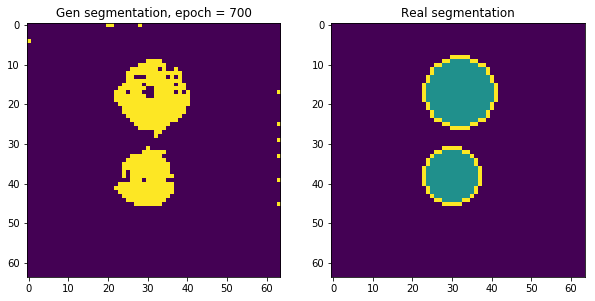

epoch - 700, loss - 2.02142620087
epoch - 701, loss - 2.0104944706
epoch - 702, loss - 2.01152420044
epoch - 703, loss - 2.00742983818
epoch - 704, loss - 2.00297141075
epoch - 705, loss - 1.99822998047
epoch - 706, loss - 2.00732111931
epoch - 707, loss - 2.02221703529
epoch - 708, loss - 2.04358577728
epoch - 709, loss - 2.07314705849
epoch - 710, loss - 2.08304810524
epoch - 711, loss - 2.08851623535
epoch - 712, loss - 2.01352882385
epoch - 713, loss - 1.96754550934
epoch - 714, loss - 1.99719727039
epoch - 715, loss - 2.02988958359
epoch - 716, loss - 1.98745167255
epoch - 717, loss - 1.96929597855
epoch - 718, loss - 1.97063755989
epoch - 719, loss - 1.96515321732
epoch - 720, loss - 1.97397351265
epoch - 721, loss - 1.95428168774
epoch - 722, loss - 1.92843842506
epoch - 723, loss - 1.94128870964
epoch - 724, loss - 1.93856930733
epoch - 725, loss - 1.91712999344
epoch - 726, loss - 1.91270565987
epoch - 727, loss - 1.91216301918
epoch - 728, loss - 1.90357577801
epoch - 729, lo

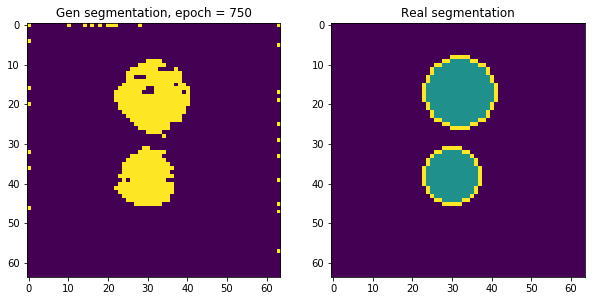

epoch - 750, loss - 1.79817807674
epoch - 751, loss - 1.78583025932
epoch - 752, loss - 1.77377736568
epoch - 753, loss - 1.77802836895
epoch - 754, loss - 1.77994346619
epoch - 755, loss - 1.77123081684
epoch - 756, loss - 1.77042078972
epoch - 757, loss - 1.77027595043
epoch - 758, loss - 1.76799273491
epoch - 759, loss - 1.78832948208
epoch - 760, loss - 1.79763352871
epoch - 761, loss - 1.80283641815
epoch - 762, loss - 1.82573401928
epoch - 763, loss - 1.79891216755
epoch - 764, loss - 1.76064574718
epoch - 765, loss - 1.73645055294
epoch - 766, loss - 1.73968875408
epoch - 767, loss - 1.74323165417
epoch - 768, loss - 1.73400425911
epoch - 769, loss - 1.72785270214
epoch - 770, loss - 1.72111785412
epoch - 771, loss - 1.71750736237
epoch - 772, loss - 1.69875192642
epoch - 773, loss - 1.69521486759
epoch - 774, loss - 1.70760047436
epoch - 775, loss - 1.69567883015
epoch - 776, loss - 1.68201720715
epoch - 777, loss - 1.69076299667
epoch - 778, loss - 1.67648172379
epoch - 779, l

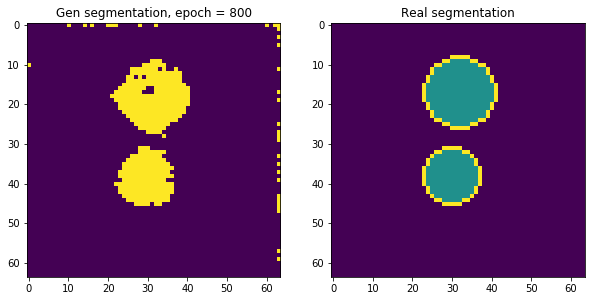

epoch - 800, loss - 1.61345803738
epoch - 801, loss - 1.60251390934
epoch - 802, loss - 1.58567726612
epoch - 803, loss - 1.58614754677
epoch - 804, loss - 1.57699000835
epoch - 805, loss - 1.56321680546
epoch - 806, loss - 1.55302584171
epoch - 807, loss - 1.54546642303
epoch - 808, loss - 1.54578435421
epoch - 809, loss - 1.53765237331
epoch - 810, loss - 1.53608560562
epoch - 811, loss - 1.54348886013
epoch - 812, loss - 1.53248178959
epoch - 813, loss - 1.53392589092
epoch - 814, loss - 1.53357768059
epoch - 815, loss - 1.53569018841
epoch - 816, loss - 1.54225301743
epoch - 817, loss - 1.53850519657
epoch - 818, loss - 1.53498959541
epoch - 819, loss - 1.50467765331
epoch - 820, loss - 1.48678839207
epoch - 821, loss - 1.48919761181
epoch - 822, loss - 1.48378038406
epoch - 823, loss - 1.49419629574
epoch - 824, loss - 1.47465848923
epoch - 825, loss - 1.4496062994
epoch - 826, loss - 1.45615959167
epoch - 827, loss - 1.4562599659
epoch - 828, loss - 1.4452354908
epoch - 829, loss

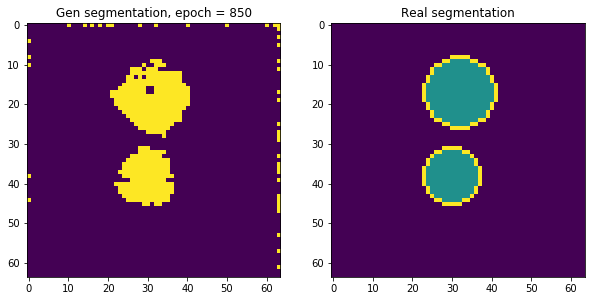

epoch - 850, loss - 1.38601267338
epoch - 851, loss - 1.34119558334
epoch - 852, loss - 1.36878097057
epoch - 853, loss - 1.38836026192
epoch - 854, loss - 1.33136069775
epoch - 855, loss - 1.34022676945
epoch - 856, loss - 1.35528898239
epoch - 857, loss - 1.32476949692
epoch - 858, loss - 1.33946180344
epoch - 859, loss - 1.33793222904
epoch - 860, loss - 1.30489599705
epoch - 861, loss - 1.33920693398
epoch - 862, loss - 1.32518351078
epoch - 863, loss - 1.31226491928
epoch - 864, loss - 1.31877839565
epoch - 865, loss - 1.29957675934
epoch - 866, loss - 1.29251551628
epoch - 867, loss - 1.28095793724
epoch - 868, loss - 1.26485323906
epoch - 869, loss - 1.26415073872
epoch - 870, loss - 1.24810647964
epoch - 871, loss - 1.24756550789
epoch - 872, loss - 1.23891186714
epoch - 873, loss - 1.23024141788
epoch - 874, loss - 1.22858691216
epoch - 875, loss - 1.21599030495
epoch - 876, loss - 1.21328663826
epoch - 877, loss - 1.21373593807
epoch - 878, loss - 1.21616208553
epoch - 879, l

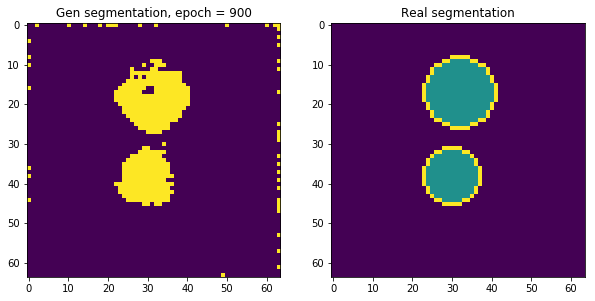

epoch - 900, loss - 1.20809960365
epoch - 901, loss - 1.21456003189
epoch - 902, loss - 1.17717981339
epoch - 903, loss - 1.13536775112
epoch - 904, loss - 1.10650873184
epoch - 905, loss - 1.11856234074
epoch - 906, loss - 1.12089860439
epoch - 907, loss - 1.12678527832
epoch - 908, loss - 1.12363493443
epoch - 909, loss - 1.10505914688
epoch - 910, loss - 1.08431077003
epoch - 911, loss - 1.07484793663
epoch - 912, loss - 1.06591582298
epoch - 913, loss - 1.06789648533
epoch - 914, loss - 1.07098329067
epoch - 915, loss - 1.07310700417
epoch - 916, loss - 1.09285986423
epoch - 917, loss - 1.14749574661
epoch - 918, loss - 1.08366024494
epoch - 919, loss - 1.10917317867
epoch - 920, loss - 1.16066563129
epoch - 921, loss - 1.13782000542
epoch - 922, loss - 1.12947249413
epoch - 923, loss - 1.09786963463
epoch - 924, loss - 1.12448811531
epoch - 925, loss - 1.09182453156
epoch - 926, loss - 1.08227288723
epoch - 927, loss - 1.06113672256
epoch - 928, loss - 1.05398666859
epoch - 929, l

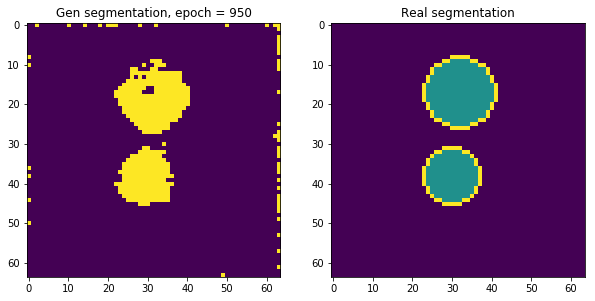

epoch - 950, loss - 0.999231815338
epoch - 951, loss - 0.969193935394
epoch - 952, loss - 0.984571695328
epoch - 953, loss - 0.996279776096
epoch - 954, loss - 0.969798564911
epoch - 955, loss - 0.954615712166
epoch - 956, loss - 0.95704883337
epoch - 957, loss - 0.91424536705
epoch - 958, loss - 0.929763793945
epoch - 959, loss - 0.920380175114
epoch - 960, loss - 0.901246547699
epoch - 961, loss - 0.901072800159
epoch - 962, loss - 0.880532681942
epoch - 963, loss - 0.883896529675
epoch - 964, loss - 0.883412897587
epoch - 965, loss - 0.865639090538
epoch - 966, loss - 0.869624912739
epoch - 967, loss - 0.85135859251
epoch - 968, loss - 0.848274767399
epoch - 969, loss - 0.850275278091
epoch - 970, loss - 0.839659452438
epoch - 971, loss - 0.839917898178
epoch - 972, loss - 0.833280622959
epoch - 973, loss - 0.829184114933
epoch - 974, loss - 0.833915114403
epoch - 975, loss - 0.847257375717
epoch - 976, loss - 0.874229192734
epoch - 977, loss - 0.879646718502
epoch - 978, loss - 0.8

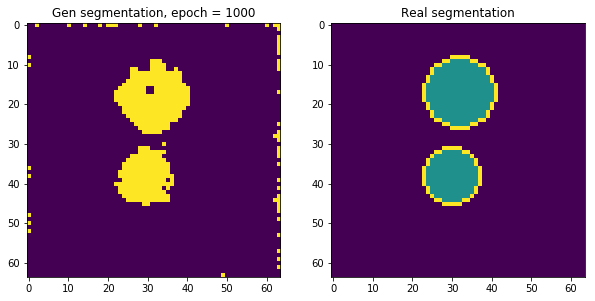

epoch - 1000, loss - 0.750873804092
epoch - 1001, loss - 0.750131547451
epoch - 1002, loss - 0.749992907047
epoch - 1003, loss - 0.74305075407
epoch - 1004, loss - 0.736081838608
epoch - 1005, loss - 0.748572528362
epoch - 1006, loss - 0.783250331879
epoch - 1007, loss - 0.846305012703
epoch - 1008, loss - 0.825236976147
epoch - 1009, loss - 0.805404901505
epoch - 1010, loss - 0.870176494122
epoch - 1011, loss - 0.872988045216
epoch - 1012, loss - 0.823012173176
epoch - 1013, loss - 0.772740721703
epoch - 1014, loss - 0.788968801498
epoch - 1015, loss - 0.781703650951
epoch - 1016, loss - 0.762330770493
epoch - 1017, loss - 0.767477095127
epoch - 1018, loss - 0.765064001083
epoch - 1019, loss - 0.733562469482
epoch - 1020, loss - 0.72787797451
epoch - 1021, loss - 0.738121092319
epoch - 1022, loss - 0.720062017441
epoch - 1023, loss - 0.714070081711
epoch - 1024, loss - 0.709509074688
epoch - 1025, loss - 0.698098778725
epoch - 1026, loss - 0.691450297832
epoch - 1027, loss - 0.6903344

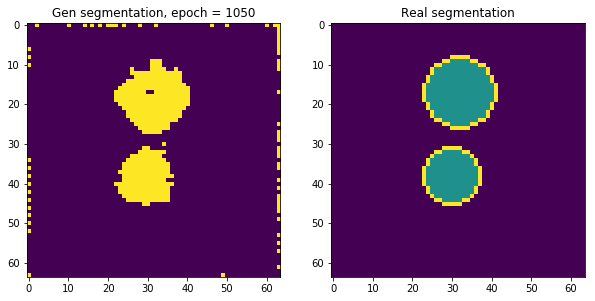

epoch - 1050, loss - 0.650924384594
epoch - 1051, loss - 0.648460865021
epoch - 1052, loss - 0.63904440403
epoch - 1053, loss - 0.643261790276
epoch - 1054, loss - 0.645886898041
epoch - 1055, loss - 0.651971459389
epoch - 1056, loss - 0.670154809952
epoch - 1057, loss - 0.7009999156
epoch - 1058, loss - 0.725280642509
epoch - 1059, loss - 0.7201577425
epoch - 1060, loss - 0.701816856861
epoch - 1061, loss - 0.655133724213
epoch - 1062, loss - 0.640826463699
epoch - 1063, loss - 0.622255563736
epoch - 1064, loss - 0.59958255291
epoch - 1065, loss - 0.60699403286
epoch - 1066, loss - 0.608571112156
epoch - 1067, loss - 0.616943359375
epoch - 1068, loss - 0.613994896412
epoch - 1069, loss - 0.586681842804
epoch - 1070, loss - 0.570003092289
epoch - 1071, loss - 0.569824874401
epoch - 1072, loss - 0.57113057375
epoch - 1073, loss - 0.572527706623
epoch - 1074, loss - 0.56890130043
epoch - 1075, loss - 0.560017824173
epoch - 1076, loss - 0.54961168766
epoch - 1077, loss - 0.545513927937
ep

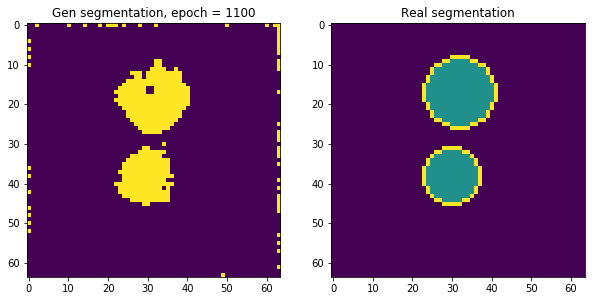

epoch - 1100, loss - 0.53017282486
epoch - 1101, loss - 0.529856324196
epoch - 1102, loss - 0.512791514397
epoch - 1103, loss - 0.515204071999
epoch - 1104, loss - 0.506690502167
epoch - 1105, loss - 0.49938249588
epoch - 1106, loss - 0.503198802471
epoch - 1107, loss - 0.491447657347
epoch - 1108, loss - 0.491079092026
epoch - 1109, loss - 0.489333629608
epoch - 1110, loss - 0.485732465982
epoch - 1111, loss - 0.491038024426
epoch - 1112, loss - 0.503318607807
epoch - 1113, loss - 0.51148635149
epoch - 1114, loss - 0.540646612644
epoch - 1115, loss - 0.551383137703
epoch - 1116, loss - 0.572150588036
epoch - 1117, loss - 0.638158380985
epoch - 1118, loss - 0.728996574879
epoch - 1119, loss - 0.78948789835
epoch - 1120, loss - 0.685380220413
epoch - 1121, loss - 0.569451332092
epoch - 1122, loss - 0.525519430637
epoch - 1123, loss - 0.555030763149
epoch - 1124, loss - 0.583506882191
epoch - 1125, loss - 0.569163203239
epoch - 1126, loss - 0.546003580093
epoch - 1127, loss - 0.502713084

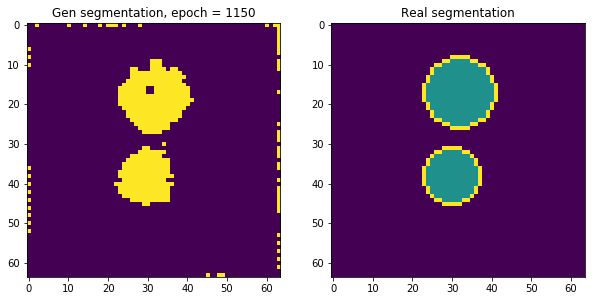

epoch - 1150, loss - 0.480854123831
epoch - 1151, loss - 0.493239164352
epoch - 1152, loss - 0.440710902214
epoch - 1153, loss - 0.476222574711
epoch - 1154, loss - 0.498630046844
epoch - 1155, loss - 0.446506023407
epoch - 1156, loss - 0.507132947445
epoch - 1157, loss - 0.473002046347
epoch - 1158, loss - 0.465131819248
epoch - 1159, loss - 0.458975017071
epoch - 1160, loss - 0.441082715988
epoch - 1161, loss - 0.447453141212
epoch - 1162, loss - 0.432796120644
epoch - 1163, loss - 0.437730103731
epoch - 1164, loss - 0.418745279312
epoch - 1165, loss - 0.425313681364
epoch - 1166, loss - 0.411571025848
epoch - 1167, loss - 0.415148764849
epoch - 1168, loss - 0.402947276831
epoch - 1169, loss - 0.408306837082
epoch - 1170, loss - 0.39855825901
epoch - 1171, loss - 0.402532726526
epoch - 1172, loss - 0.400726914406
epoch - 1173, loss - 0.406820267439
epoch - 1174, loss - 0.421501278877
epoch - 1175, loss - 0.439939111471
epoch - 1176, loss - 0.477650940418
epoch - 1177, loss - 0.467995

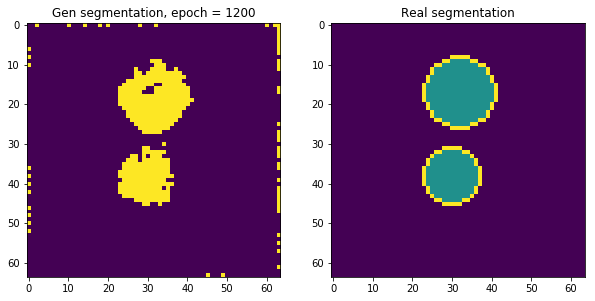

epoch - 1200, loss - 0.383081138134
epoch - 1201, loss - 0.387149274349
epoch - 1202, loss - 0.3906699121
epoch - 1203, loss - 0.390977263451
epoch - 1204, loss - 0.38988879323
epoch - 1205, loss - 0.390667051077
epoch - 1206, loss - 0.39293435216
epoch - 1207, loss - 0.386323541403
epoch - 1208, loss - 0.379034459591
epoch - 1209, loss - 0.378603667021
epoch - 1210, loss - 0.378380030394
epoch - 1211, loss - 0.372475713491
epoch - 1212, loss - 0.360596090555
epoch - 1213, loss - 0.358570754528
epoch - 1214, loss - 0.360177785158
epoch - 1215, loss - 0.35577622056
epoch - 1216, loss - 0.354557037354
epoch - 1217, loss - 0.35860195756
epoch - 1218, loss - 0.362864613533
epoch - 1219, loss - 0.374972164631
epoch - 1220, loss - 0.390168309212
epoch - 1221, loss - 0.417938947678
epoch - 1222, loss - 0.438699126244
epoch - 1223, loss - 0.451697677374
epoch - 1224, loss - 0.471330821514
epoch - 1225, loss - 0.499860942364
epoch - 1226, loss - 0.510167956352
epoch - 1227, loss - 0.45829677581

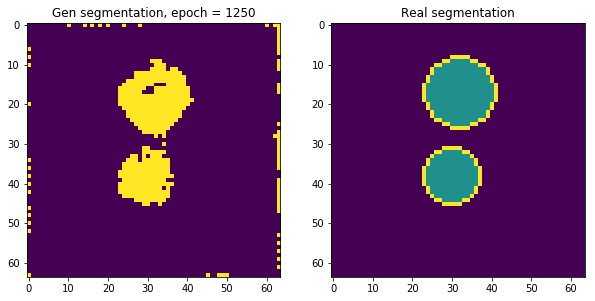

epoch - 1250, loss - 0.317127466202
epoch - 1251, loss - 0.313532829285
epoch - 1252, loss - 0.313952714205
epoch - 1253, loss - 0.317766517401
epoch - 1254, loss - 0.31828469038
epoch - 1255, loss - 0.319513261318
epoch - 1256, loss - 0.326104462147
epoch - 1257, loss - 0.327894032001
epoch - 1258, loss - 0.318277746439
epoch - 1259, loss - 0.313214093447
epoch - 1260, loss - 0.321205496788
epoch - 1261, loss - 0.340808272362
epoch - 1262, loss - 0.377458751202
epoch - 1263, loss - 0.392347335815
epoch - 1264, loss - 0.365354478359
epoch - 1265, loss - 0.370900928974
epoch - 1266, loss - 0.402433782816
epoch - 1267, loss - 0.368805706501
epoch - 1268, loss - 0.376650452614
epoch - 1269, loss - 0.396703720093
epoch - 1270, loss - 0.376187324524
epoch - 1271, loss - 0.356104552746
epoch - 1272, loss - 0.368820816278
epoch - 1273, loss - 0.355839788914
epoch - 1274, loss - 0.329392969608
epoch - 1275, loss - 0.34402012825
epoch - 1276, loss - 0.322874188423
epoch - 1277, loss - 0.3238999

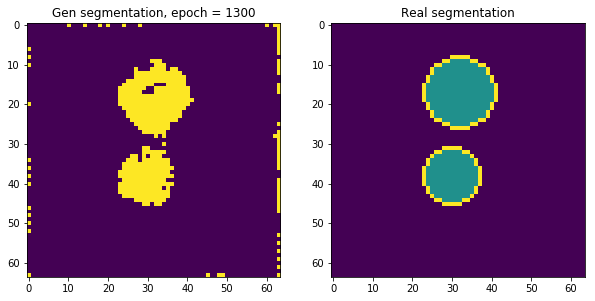

epoch - 1300, loss - 0.304174691439
epoch - 1301, loss - 0.3014742136
epoch - 1302, loss - 0.30334687233
epoch - 1303, loss - 0.307872205973
epoch - 1304, loss - 0.311642825603
epoch - 1305, loss - 0.307750582695
epoch - 1306, loss - 0.298153460026
epoch - 1307, loss - 0.289369851351
epoch - 1308, loss - 0.290634572506
epoch - 1309, loss - 0.290161430836
epoch - 1310, loss - 0.279629528522
epoch - 1311, loss - 0.272857248783
epoch - 1312, loss - 0.271655738354
epoch - 1313, loss - 0.273509025574
epoch - 1314, loss - 0.271908938885
epoch - 1315, loss - 0.267474710941
epoch - 1316, loss - 0.266975194216
epoch - 1317, loss - 0.267607092857
epoch - 1318, loss - 0.269647240639
epoch - 1319, loss - 0.270468264818
epoch - 1320, loss - 0.269941031933
epoch - 1321, loss - 0.273850500584
epoch - 1322, loss - 0.281875610352
epoch - 1323, loss - 0.282831311226
epoch - 1324, loss - 0.284861415625
epoch - 1325, loss - 0.295448154211
epoch - 1326, loss - 0.297015219927
epoch - 1327, loss - 0.28691068

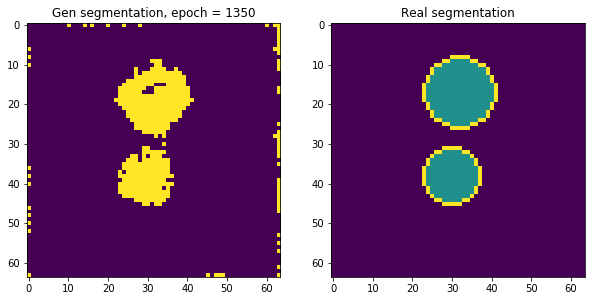

epoch - 1350, loss - 0.267802119255
epoch - 1351, loss - 0.272341370583
epoch - 1352, loss - 0.26638045907
epoch - 1353, loss - 0.272781312466
epoch - 1354, loss - 0.265978068113
epoch - 1355, loss - 0.262227058411
epoch - 1356, loss - 0.257426708937
epoch - 1357, loss - 0.252559781075
epoch - 1358, loss - 0.249127805233
epoch - 1359, loss - 0.24585442245
epoch - 1360, loss - 0.246441751719
epoch - 1361, loss - 0.243630826473
epoch - 1362, loss - 0.242444068193
epoch - 1363, loss - 0.243618071079
epoch - 1364, loss - 0.241358429193
epoch - 1365, loss - 0.241636276245
epoch - 1366, loss - 0.24305023253
epoch - 1367, loss - 0.242927998304
epoch - 1368, loss - 0.245160371065
epoch - 1369, loss - 0.248136118054
epoch - 1370, loss - 0.250327676535
epoch - 1371, loss - 0.254972249269
epoch - 1372, loss - 0.258917272091
epoch - 1373, loss - 0.264971107244
epoch - 1374, loss - 0.272456675768
epoch - 1375, loss - 0.288953989744
epoch - 1376, loss - 0.313030749559
epoch - 1377, loss - 0.32431364

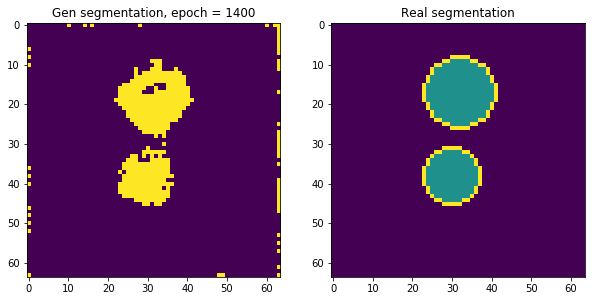

epoch - 1400, loss - 0.234753236175
epoch - 1401, loss - 0.251733124256
epoch - 1402, loss - 0.280731588602
epoch - 1403, loss - 0.316587150097
epoch - 1404, loss - 0.356607854366
epoch - 1405, loss - 0.410217046738
epoch - 1406, loss - 0.471152573824
epoch - 1407, loss - 0.534923255444
epoch - 1408, loss - 0.484695404768
epoch - 1409, loss - 0.364470005035
epoch - 1410, loss - 0.279237031937
epoch - 1411, loss - 0.280526816845
epoch - 1412, loss - 0.338252902031
epoch - 1413, loss - 0.345475584269
epoch - 1414, loss - 0.293555498123
epoch - 1415, loss - 0.265416681767
epoch - 1416, loss - 0.267570972443
epoch - 1417, loss - 0.27499845624
epoch - 1418, loss - 0.282323360443
epoch - 1419, loss - 0.2639092803
epoch - 1420, loss - 0.238776266575
epoch - 1421, loss - 0.24890267849
epoch - 1422, loss - 0.258569210768
epoch - 1423, loss - 0.248200178146
epoch - 1424, loss - 0.241910547018
epoch - 1425, loss - 0.233905434608
epoch - 1426, loss - 0.236165523529
epoch - 1427, loss - 0.239896878

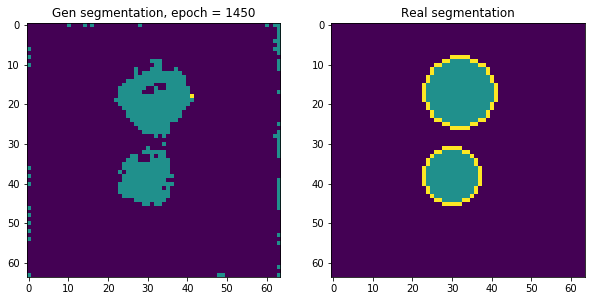

epoch - 1450, loss - 0.225720778108
epoch - 1451, loss - 0.23408010602
epoch - 1452, loss - 0.214919626713
epoch - 1453, loss - 0.212853819132
epoch - 1454, loss - 0.220750182867
epoch - 1455, loss - 0.212902054191
epoch - 1456, loss - 0.208424687386
epoch - 1457, loss - 0.20923653245
epoch - 1458, loss - 0.207264661789
epoch - 1459, loss - 0.203142285347
epoch - 1460, loss - 0.201872259378
epoch - 1461, loss - 0.201830670238
epoch - 1462, loss - 0.199809983373
epoch - 1463, loss - 0.19811488688
epoch - 1464, loss - 0.198292791843
epoch - 1465, loss - 0.198747992516
epoch - 1466, loss - 0.198894500732
epoch - 1467, loss - 0.199344336987
epoch - 1468, loss - 0.201542437077
epoch - 1469, loss - 0.206008210778
epoch - 1470, loss - 0.205919206142
epoch - 1471, loss - 0.203956902027
epoch - 1472, loss - 0.202295899391
epoch - 1473, loss - 0.199233055115
epoch - 1474, loss - 0.196102708578
epoch - 1475, loss - 0.195370942354
epoch - 1476, loss - 0.200378477573
epoch - 1477, loss - 0.20939666

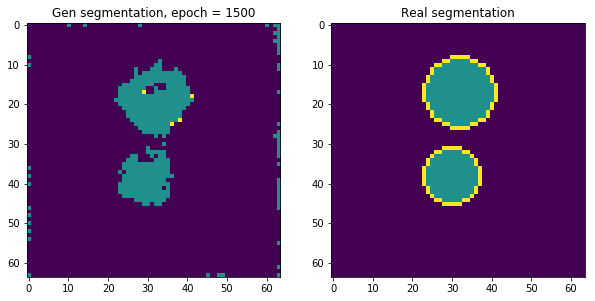

epoch - 1500, loss - 0.197299033403
epoch - 1501, loss - 0.19840836525
epoch - 1502, loss - 0.197366148233
epoch - 1503, loss - 0.195416033268
epoch - 1504, loss - 0.196776196361
epoch - 1505, loss - 0.195495545864
epoch - 1506, loss - 0.191439926624
epoch - 1507, loss - 0.188966393471
epoch - 1508, loss - 0.188012301922
epoch - 1509, loss - 0.185450822115
epoch - 1510, loss - 0.182299137115
epoch - 1511, loss - 0.182684287429
epoch - 1512, loss - 0.182396680117
epoch - 1513, loss - 0.182778984308
epoch - 1514, loss - 0.186766684055
epoch - 1515, loss - 0.189741283655
epoch - 1516, loss - 0.19175671041
epoch - 1517, loss - 0.187557071447
epoch - 1518, loss - 0.182883217931
epoch - 1519, loss - 0.179405808449
epoch - 1520, loss - 0.180699676275
epoch - 1521, loss - 0.186711639166
epoch - 1522, loss - 0.194137901068
epoch - 1523, loss - 0.202730849385
epoch - 1524, loss - 0.207063511014
epoch - 1525, loss - 0.221591576934
epoch - 1526, loss - 0.237241923809
epoch - 1527, loss - 0.2487768

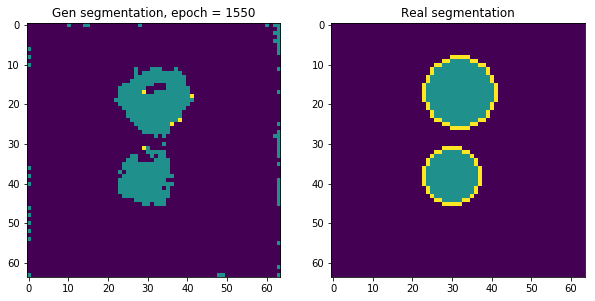

epoch - 1550, loss - 0.187958836555
epoch - 1551, loss - 0.186365783215
epoch - 1552, loss - 0.186472773552
epoch - 1553, loss - 0.185548692942
epoch - 1554, loss - 0.189816370606
epoch - 1555, loss - 0.186542361975
epoch - 1556, loss - 0.179357111454
epoch - 1557, loss - 0.177008092403
epoch - 1558, loss - 0.174075841904
epoch - 1559, loss - 0.172213941813
epoch - 1560, loss - 0.173960059881
epoch - 1561, loss - 0.174457341433
epoch - 1562, loss - 0.172667145729
epoch - 1563, loss - 0.171530395746
epoch - 1564, loss - 0.170162498951
epoch - 1565, loss - 0.168157726526
epoch - 1566, loss - 0.167479097843
epoch - 1567, loss - 0.167145580053
epoch - 1568, loss - 0.16855147481
epoch - 1569, loss - 0.169661670923
epoch - 1570, loss - 0.171115994453
epoch - 1571, loss - 0.174456745386
epoch - 1572, loss - 0.176873505116
epoch - 1573, loss - 0.177982538939
epoch - 1574, loss - 0.179490119219
epoch - 1575, loss - 0.18291683495
epoch - 1576, loss - 0.186189055443
epoch - 1577, loss - 0.1889570

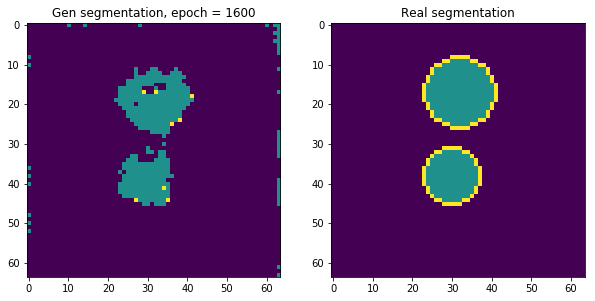

epoch - 1600, loss - 0.4843570292
epoch - 1601, loss - 0.55862903595
epoch - 1602, loss - 0.51811760664
epoch - 1603, loss - 0.478054285049
epoch - 1604, loss - 0.378649324179
epoch - 1605, loss - 0.265458077192
epoch - 1606, loss - 0.330921024084
epoch - 1607, loss - 0.38235154748
epoch - 1608, loss - 0.331033051014
epoch - 1609, loss - 0.284292370081
epoch - 1610, loss - 0.264381885529
epoch - 1611, loss - 0.290921509266
epoch - 1612, loss - 0.305493086576
epoch - 1613, loss - 0.259123980999
epoch - 1614, loss - 0.236179411411
epoch - 1615, loss - 0.260271012783
epoch - 1616, loss - 0.266105175018
epoch - 1617, loss - 0.227465122938
epoch - 1618, loss - 0.225808814168
epoch - 1619, loss - 0.231239229441
epoch - 1620, loss - 0.220820829272
epoch - 1621, loss - 0.218956112862
epoch - 1622, loss - 0.201320439577
epoch - 1623, loss - 0.202364772558
epoch - 1624, loss - 0.205871373415
epoch - 1625, loss - 0.192958980799
epoch - 1626, loss - 0.188454598188
epoch - 1627, loss - 0.1866114437

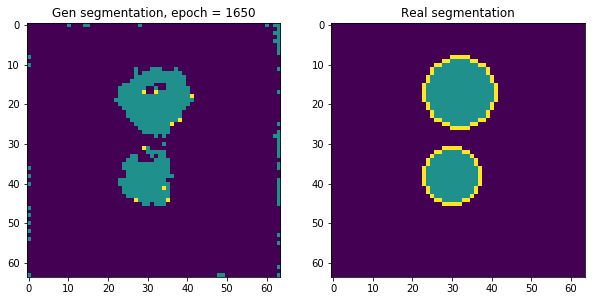

epoch - 1650, loss - 0.149025470018
epoch - 1651, loss - 0.149060249329
epoch - 1652, loss - 0.149514615536
epoch - 1653, loss - 0.150534063578
epoch - 1654, loss - 0.152593553066
epoch - 1655, loss - 0.156305640936
epoch - 1656, loss - 0.159942314029
epoch - 1657, loss - 0.163476377726
epoch - 1658, loss - 0.158458501101
epoch - 1659, loss - 0.151312470436
epoch - 1660, loss - 0.148892015219
epoch - 1661, loss - 0.150762021542
epoch - 1662, loss - 0.152059882879
epoch - 1663, loss - 0.150458842516
epoch - 1664, loss - 0.147772163153
epoch - 1665, loss - 0.14642855525
epoch - 1666, loss - 0.146475791931
epoch - 1667, loss - 0.146719396114
epoch - 1668, loss - 0.145692288876
epoch - 1669, loss - 0.143827110529
epoch - 1670, loss - 0.14264331758
epoch - 1671, loss - 0.142937242985
epoch - 1672, loss - 0.143814682961
epoch - 1673, loss - 0.143629953265
epoch - 1674, loss - 0.141660377383
epoch - 1675, loss - 0.139526546001
epoch - 1676, loss - 0.139362573624
epoch - 1677, loss - 0.1412626

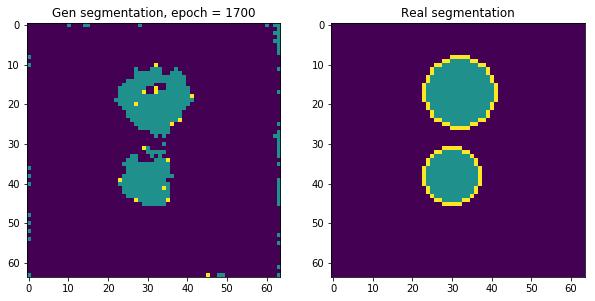

epoch - 1700, loss - 0.158031493425
epoch - 1701, loss - 0.157807663083
epoch - 1702, loss - 0.153313368559
epoch - 1703, loss - 0.150626033545
epoch - 1704, loss - 0.15291441977
epoch - 1705, loss - 0.151962578297
epoch - 1706, loss - 0.147315382957
epoch - 1707, loss - 0.145545274019
epoch - 1708, loss - 0.147608876228
epoch - 1709, loss - 0.148033678532
epoch - 1710, loss - 0.143963813782
epoch - 1711, loss - 0.142864227295
epoch - 1712, loss - 0.144970804453
epoch - 1713, loss - 0.144632413983
epoch - 1714, loss - 0.14451391995
epoch - 1715, loss - 0.148419290781
epoch - 1716, loss - 0.155394926667
epoch - 1717, loss - 0.161206960678
epoch - 1718, loss - 0.165674805641
epoch - 1719, loss - 0.173770308495
epoch - 1720, loss - 0.187671661377
epoch - 1721, loss - 0.208114668727
epoch - 1722, loss - 0.228496223688
epoch - 1723, loss - 0.262327045202
epoch - 1724, loss - 0.292045235634
epoch - 1725, loss - 0.313899308443
epoch - 1726, loss - 0.293885648251
epoch - 1727, loss - 0.2411833

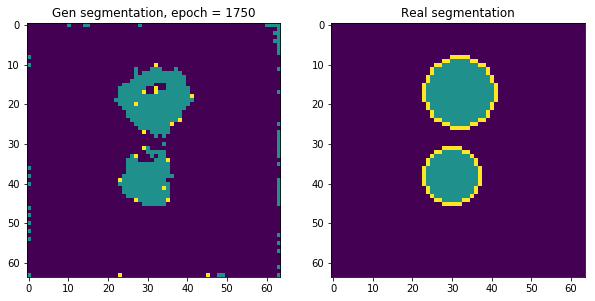

epoch - 1750, loss - 0.13826328516
epoch - 1751, loss - 0.137983173132
epoch - 1752, loss - 0.137522101402
epoch - 1753, loss - 0.134548932314
epoch - 1754, loss - 0.136053055525
epoch - 1755, loss - 0.134385257959
epoch - 1756, loss - 0.13226929307
epoch - 1757, loss - 0.132846355438
epoch - 1758, loss - 0.130386680365
epoch - 1759, loss - 0.129297345877
epoch - 1760, loss - 0.129977151752
epoch - 1761, loss - 0.128979459405
epoch - 1762, loss - 0.129528179765
epoch - 1763, loss - 0.132579803467
epoch - 1764, loss - 0.135414958
epoch - 1765, loss - 0.140709966421
epoch - 1766, loss - 0.147300064564
epoch - 1767, loss - 0.147118628025
epoch - 1768, loss - 0.140299916267
epoch - 1769, loss - 0.132802814245
epoch - 1770, loss - 0.132876649499
epoch - 1771, loss - 0.136916846037
epoch - 1772, loss - 0.140374571085
epoch - 1773, loss - 0.139776438475
epoch - 1774, loss - 0.136593833566
epoch - 1775, loss - 0.137108385563
epoch - 1776, loss - 0.136022955179
epoch - 1777, loss - 0.1360998749

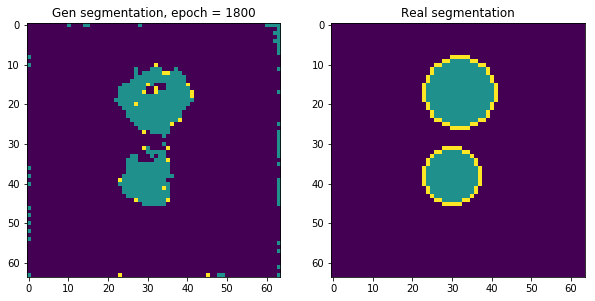

epoch - 1800, loss - 0.14626891911
epoch - 1801, loss - 0.149518877268
epoch - 1802, loss - 0.155988693237
epoch - 1803, loss - 0.153684139252
epoch - 1804, loss - 0.14127933979
epoch - 1805, loss - 0.13355243206
epoch - 1806, loss - 0.134021699429
epoch - 1807, loss - 0.135064631701
epoch - 1808, loss - 0.135060429573
epoch - 1809, loss - 0.135491758585
epoch - 1810, loss - 0.130102515221
epoch - 1811, loss - 0.123894654214
epoch - 1812, loss - 0.125219583511
epoch - 1813, loss - 0.127002820373
epoch - 1814, loss - 0.126087874174
epoch - 1815, loss - 0.125404328108
epoch - 1816, loss - 0.124228440225
epoch - 1817, loss - 0.121795982122
epoch - 1818, loss - 0.121063694358
epoch - 1819, loss - 0.121179707348
epoch - 1820, loss - 0.121003180742
epoch - 1821, loss - 0.121221631765
epoch - 1822, loss - 0.120797231793
epoch - 1823, loss - 0.120635658503
epoch - 1824, loss - 0.122498907149
epoch - 1825, loss - 0.125272467732
epoch - 1826, loss - 0.129321217537
epoch - 1827, loss - 0.13221105

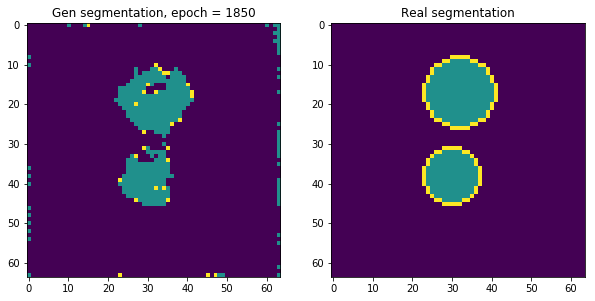

epoch - 1850, loss - 0.143590584397
epoch - 1851, loss - 0.144006311893
epoch - 1852, loss - 0.136855095625
epoch - 1853, loss - 0.136844784021
epoch - 1854, loss - 0.140155076981
epoch - 1855, loss - 0.13737373054
epoch - 1856, loss - 0.138317033648
epoch - 1857, loss - 0.144052505493
epoch - 1858, loss - 0.149073451757
epoch - 1859, loss - 0.153630122542
epoch - 1860, loss - 0.160263895988
epoch - 1861, loss - 0.16939073801
epoch - 1862, loss - 0.181235909462
epoch - 1863, loss - 0.185376316309
epoch - 1864, loss - 0.190955236554
epoch - 1865, loss - 0.195207297802
epoch - 1866, loss - 0.196331232786
epoch - 1867, loss - 0.183416724205
epoch - 1868, loss - 0.16810387373
epoch - 1869, loss - 0.149717867374
epoch - 1870, loss - 0.134384140372
epoch - 1871, loss - 0.122810542583
epoch - 1872, loss - 0.126214504242
epoch - 1873, loss - 0.139026194811
epoch - 1874, loss - 0.144322156906
epoch - 1875, loss - 0.140880286694
epoch - 1876, loss - 0.13592800498
epoch - 1877, loss - 0.133175969

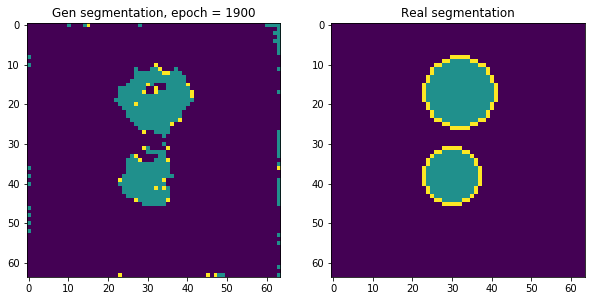

epoch - 1900, loss - 0.143191367388
epoch - 1901, loss - 0.141807019711
epoch - 1902, loss - 0.139007627964
epoch - 1903, loss - 0.135778456926
epoch - 1904, loss - 0.13985645771
epoch - 1905, loss - 0.147022753954
epoch - 1906, loss - 0.149803608656
epoch - 1907, loss - 0.156566634774
epoch - 1908, loss - 0.168142184615
epoch - 1909, loss - 0.179329350591
epoch - 1910, loss - 0.182865917683
epoch - 1911, loss - 0.186208814383
epoch - 1912, loss - 0.187116846442
epoch - 1913, loss - 0.178230792284
epoch - 1914, loss - 0.158388376236
epoch - 1915, loss - 0.147710502148
epoch - 1916, loss - 0.145840749145
epoch - 1917, loss - 0.133448004723
epoch - 1918, loss - 0.12335767597
epoch - 1919, loss - 0.12409734726
epoch - 1920, loss - 0.126258581877
epoch - 1921, loss - 0.126973971725
epoch - 1922, loss - 0.12927672267
epoch - 1923, loss - 0.129489198327
epoch - 1924, loss - 0.124165423214
epoch - 1925, loss - 0.11847114563
epoch - 1926, loss - 0.116590000689
epoch - 1927, loss - 0.1137322932

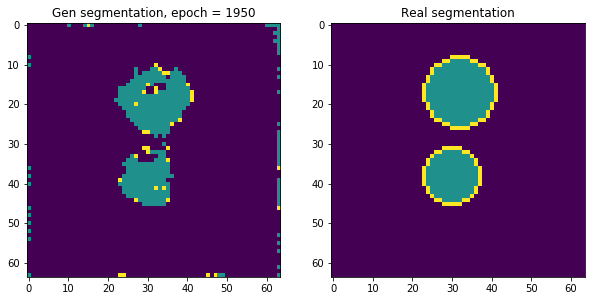

epoch - 1950, loss - 0.156693801284
epoch - 1951, loss - 0.165438771248
epoch - 1952, loss - 0.179831326008
epoch - 1953, loss - 0.196614980698
epoch - 1954, loss - 0.211924135685
epoch - 1955, loss - 0.209579572082
epoch - 1956, loss - 0.201335817575
epoch - 1957, loss - 0.184001713991
epoch - 1958, loss - 0.165255099535
epoch - 1959, loss - 0.137592434883
epoch - 1960, loss - 0.119547113776
epoch - 1961, loss - 0.119350552559
epoch - 1962, loss - 0.131560951471
epoch - 1963, loss - 0.141695931554
epoch - 1964, loss - 0.141674607992
epoch - 1965, loss - 0.136192500591
epoch - 1966, loss - 0.126369923353
epoch - 1967, loss - 0.115114316344
epoch - 1968, loss - 0.110444650054
epoch - 1969, loss - 0.113374486566
epoch - 1970, loss - 0.117117881775
epoch - 1971, loss - 0.119398459792
epoch - 1972, loss - 0.117979623377
epoch - 1973, loss - 0.11519459635
epoch - 1974, loss - 0.113827630877
epoch - 1975, loss - 0.115850940347
epoch - 1976, loss - 0.114763624966
epoch - 1977, loss - 0.115070

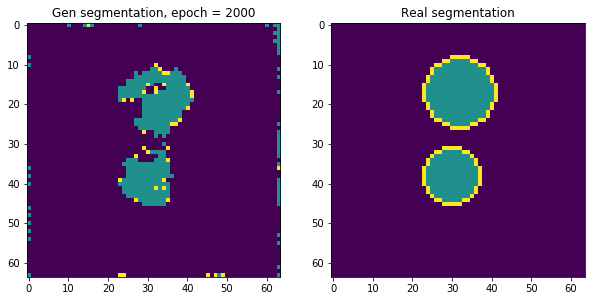

epoch - 2000, loss - 0.127075538039
epoch - 2001, loss - 0.141746044159
epoch - 2002, loss - 0.152053058147
epoch - 2003, loss - 0.165597856045
epoch - 2004, loss - 0.161983191967
epoch - 2005, loss - 0.156941190362
epoch - 2006, loss - 0.17911234498
epoch - 2007, loss - 0.19177262485
epoch - 2008, loss - 0.1820551157
epoch - 2009, loss - 0.180939257145
epoch - 2010, loss - 0.201234325767
epoch - 2011, loss - 0.206370517612
epoch - 2012, loss - 0.212555244565
epoch - 2013, loss - 0.217394992709
epoch - 2014, loss - 0.211194813251
epoch - 2015, loss - 0.179011046886
epoch - 2016, loss - 0.154990255833
epoch - 2017, loss - 0.13987711072
epoch - 2018, loss - 0.124420642853
epoch - 2019, loss - 0.123507067561
epoch - 2020, loss - 0.132874786854
epoch - 2021, loss - 0.134561657906
epoch - 2022, loss - 0.136698767543
epoch - 2023, loss - 0.135457232594
epoch - 2024, loss - 0.122868195176
epoch - 2025, loss - 0.114097304642
epoch - 2026, loss - 0.111020237207
epoch - 2027, loss - 0.1081367284

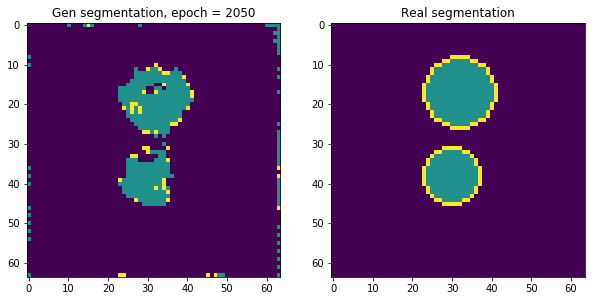

epoch - 2050, loss - 0.100776180625
epoch - 2051, loss - 0.103242710233
epoch - 2052, loss - 0.105365388095
epoch - 2053, loss - 0.105463124812
epoch - 2054, loss - 0.104766771197
epoch - 2055, loss - 0.103540733457
epoch - 2056, loss - 0.10615285486
epoch - 2057, loss - 0.112342715263
epoch - 2058, loss - 0.122416086495
epoch - 2059, loss - 0.13169413805
epoch - 2060, loss - 0.132567897439
epoch - 2061, loss - 0.125766947865
epoch - 2062, loss - 0.122520491481
epoch - 2063, loss - 0.138311773539
epoch - 2064, loss - 0.162980675697
epoch - 2065, loss - 0.183843821287
epoch - 2066, loss - 0.201014101505
epoch - 2067, loss - 0.21655446291
epoch - 2068, loss - 0.245870053768
epoch - 2069, loss - 0.266339719296
epoch - 2070, loss - 0.249682694674
epoch - 2071, loss - 0.191907018423
epoch - 2072, loss - 0.170315101743
epoch - 2073, loss - 0.149919956923
epoch - 2074, loss - 0.129386410117
epoch - 2075, loss - 0.129628583789
epoch - 2076, loss - 0.138573378325
epoch - 2077, loss - 0.14158308

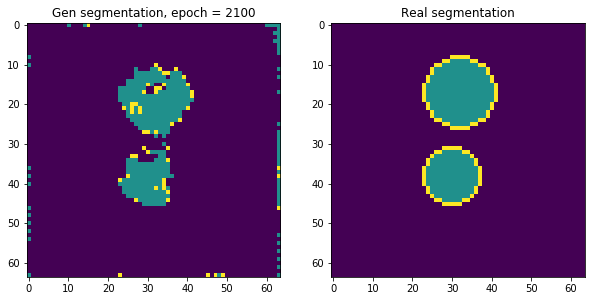

epoch - 2100, loss - 0.0917721390724
epoch - 2101, loss - 0.0917741656303
epoch - 2102, loss - 0.0915096029639
epoch - 2103, loss - 0.0909041240811
epoch - 2104, loss - 0.0904078185558
epoch - 2105, loss - 0.0897685214877
epoch - 2106, loss - 0.088949650526
epoch - 2107, loss - 0.0882108509541
epoch - 2108, loss - 0.0878822505474
epoch - 2109, loss - 0.0877133905888
epoch - 2110, loss - 0.0877822935581
epoch - 2111, loss - 0.0882726088166
epoch - 2112, loss - 0.0892088189721
epoch - 2113, loss - 0.0903359279037
epoch - 2114, loss - 0.0915871560574
epoch - 2115, loss - 0.0937799960375
epoch - 2116, loss - 0.0953633934259
epoch - 2117, loss - 0.0963845103979
epoch - 2118, loss - 0.0958690717816
epoch - 2119, loss - 0.0947617888451
epoch - 2120, loss - 0.0947917997837
epoch - 2121, loss - 0.0982413366437
epoch - 2122, loss - 0.106039889157
epoch - 2123, loss - 0.119640544057
epoch - 2124, loss - 0.141509905457
epoch - 2125, loss - 0.160854920745
epoch - 2126, loss - 0.164025649428
epoch -

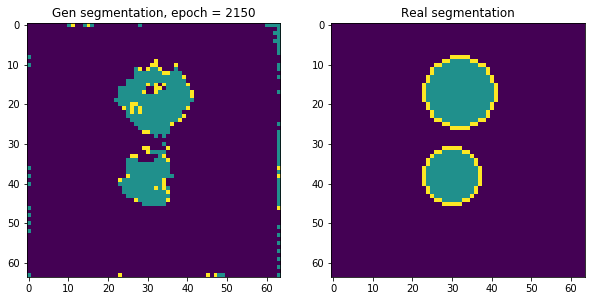

epoch - 2150, loss - 0.103668898344
epoch - 2151, loss - 0.10001539439
epoch - 2152, loss - 0.0944293290377
epoch - 2153, loss - 0.0941060781479
epoch - 2154, loss - 0.0973549634218
epoch - 2155, loss - 0.0973991528153
epoch - 2156, loss - 0.0963206216693
epoch - 2157, loss - 0.0937213152647
epoch - 2158, loss - 0.0904435366392
epoch - 2159, loss - 0.0882467031479
epoch - 2160, loss - 0.0872937291861
epoch - 2161, loss - 0.0877427309752
epoch - 2162, loss - 0.0886586681008
epoch - 2163, loss - 0.0886124670506
epoch - 2164, loss - 0.0877894237638
epoch - 2165, loss - 0.0873410850763
epoch - 2166, loss - 0.0862819701433
epoch - 2167, loss - 0.0846968367696
epoch - 2168, loss - 0.0841030329466
epoch - 2169, loss - 0.0839276313782
epoch - 2170, loss - 0.0837839096785
epoch - 2171, loss - 0.0842166692019
epoch - 2172, loss - 0.084944024682
epoch - 2173, loss - 0.0855428725481
epoch - 2174, loss - 0.086053237319
epoch - 2175, loss - 0.0869486182928
epoch - 2176, loss - 0.0865390002728
epoch 

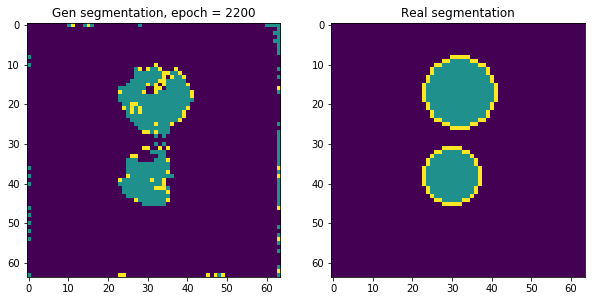

epoch - 2200, loss - 0.259667515755
epoch - 2201, loss - 0.242787733674
epoch - 2202, loss - 0.212367117405
epoch - 2203, loss - 0.162908107042
epoch - 2204, loss - 0.125300854445
epoch - 2205, loss - 0.107767082751
epoch - 2206, loss - 0.132081359625
epoch - 2207, loss - 0.159131199121
epoch - 2208, loss - 0.14865411818
epoch - 2209, loss - 0.131463825703
epoch - 2210, loss - 0.114976614714
epoch - 2211, loss - 0.0998034030199
epoch - 2212, loss - 0.105277717113
epoch - 2213, loss - 0.119829893112
epoch - 2214, loss - 0.116658441722
epoch - 2215, loss - 0.105277061462
epoch - 2216, loss - 0.0977689027786
epoch - 2217, loss - 0.0935531109571
epoch - 2218, loss - 0.0943337380886
epoch - 2219, loss - 0.0989777371287
epoch - 2220, loss - 0.099901586771
epoch - 2221, loss - 0.0939801558852
epoch - 2222, loss - 0.0872433185577
epoch - 2223, loss - 0.0858380794525
epoch - 2224, loss - 0.0874545648694
epoch - 2225, loss - 0.0880309790373
epoch - 2226, loss - 0.0882320255041
epoch - 2227, loss

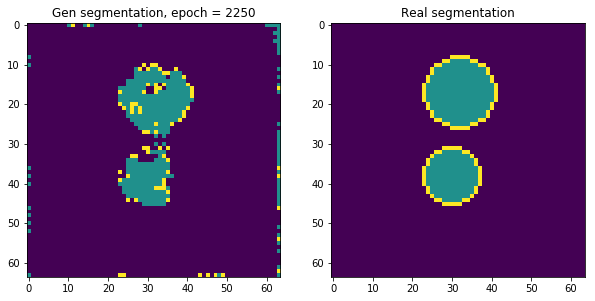

epoch - 2250, loss - 0.0847428143024
epoch - 2251, loss - 0.0870033055544
epoch - 2252, loss - 0.0855231583118
epoch - 2253, loss - 0.0830484926701
epoch - 2254, loss - 0.0818604081869
epoch - 2255, loss - 0.0818255096674
epoch - 2256, loss - 0.0812273770571
epoch - 2257, loss - 0.0799111798406
epoch - 2258, loss - 0.0795688331127
epoch - 2259, loss - 0.0799579769373
epoch - 2260, loss - 0.0789207220078
epoch - 2261, loss - 0.0778275281191
epoch - 2262, loss - 0.0780837982893
epoch - 2263, loss - 0.0786302015185
epoch - 2264, loss - 0.0778509825468
epoch - 2265, loss - 0.0767983719707
epoch - 2266, loss - 0.0771400183439
epoch - 2267, loss - 0.0789700523019
epoch - 2268, loss - 0.0807198435068
epoch - 2269, loss - 0.082801900804
epoch - 2270, loss - 0.084659203887
epoch - 2271, loss - 0.0891432315111
epoch - 2272, loss - 0.0944261774421
epoch - 2273, loss - 0.101315796375
epoch - 2274, loss - 0.109333336353
epoch - 2275, loss - 0.121886394918
epoch - 2276, loss - 0.144648686051
epoch -

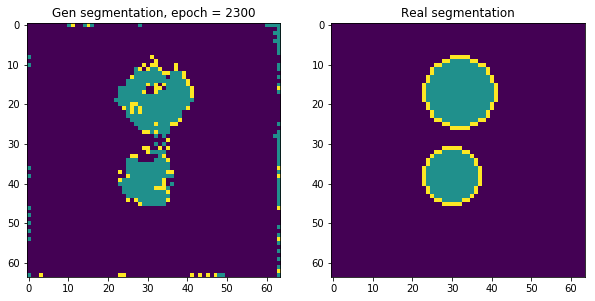

epoch - 2300, loss - 0.108454696834
epoch - 2301, loss - 0.101716473699
epoch - 2302, loss - 0.0978319570422
epoch - 2303, loss - 0.0995101481676
epoch - 2304, loss - 0.0976511612535
epoch - 2305, loss - 0.0969584584236
epoch - 2306, loss - 0.0931093096733
epoch - 2307, loss - 0.0890044420958
epoch - 2308, loss - 0.0890257507563
epoch - 2309, loss - 0.0877261310816
epoch - 2310, loss - 0.0888165310025
epoch - 2311, loss - 0.0880502015352
epoch - 2312, loss - 0.0851092785597
epoch - 2313, loss - 0.0839300081134
epoch - 2314, loss - 0.0825129449368
epoch - 2315, loss - 0.0823524594307
epoch - 2316, loss - 0.0825614929199
epoch - 2317, loss - 0.0821601301432
epoch - 2318, loss - 0.0818494334817
epoch - 2319, loss - 0.0811038538814
epoch - 2320, loss - 0.0800530910492
epoch - 2321, loss - 0.0793251693249
epoch - 2322, loss - 0.0789770185947
epoch - 2323, loss - 0.0781756341457
epoch - 2324, loss - 0.0779691785574
epoch - 2325, loss - 0.0775984525681
epoch - 2326, loss - 0.0769544243813
epo

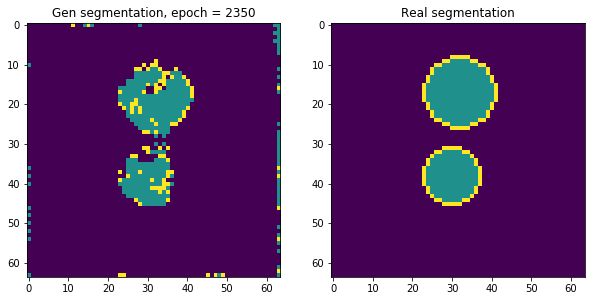

epoch - 2350, loss - 0.0781403183937
epoch - 2351, loss - 0.0798897743225
epoch - 2352, loss - 0.0761755183339
epoch - 2353, loss - 0.0722862556577
epoch - 2354, loss - 0.072468996048
epoch - 2355, loss - 0.0748738497496
epoch - 2356, loss - 0.0758524537086
epoch - 2357, loss - 0.073718123138
epoch - 2358, loss - 0.0719424784184
epoch - 2359, loss - 0.0729846656322
epoch - 2360, loss - 0.0756437107921
epoch - 2361, loss - 0.078543305397
epoch - 2362, loss - 0.0797102898359
epoch - 2363, loss - 0.0825307816267
epoch - 2364, loss - 0.0892050340772
epoch - 2365, loss - 0.101375035942
epoch - 2366, loss - 0.121909961104
epoch - 2367, loss - 0.145309686661
epoch - 2368, loss - 0.17209482193
epoch - 2369, loss - 0.217400401831
epoch - 2370, loss - 0.275243133307
epoch - 2371, loss - 0.346457213163
epoch - 2372, loss - 0.350295484066
epoch - 2373, loss - 0.290590256453
epoch - 2374, loss - 0.188641011715
epoch - 2375, loss - 0.131177321076
epoch - 2376, loss - 0.124680802226
epoch - 2377, los

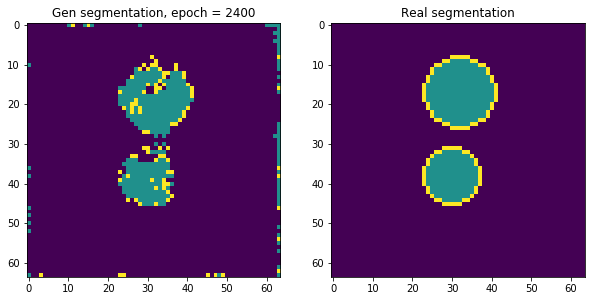

epoch - 2400, loss - 0.111113682389
epoch - 2401, loss - 0.106904082
epoch - 2402, loss - 0.104786194861
epoch - 2403, loss - 0.102491974831
epoch - 2404, loss - 0.100100755692
epoch - 2405, loss - 0.0980559140444
epoch - 2406, loss - 0.0943814963102
epoch - 2407, loss - 0.0930860936642
epoch - 2408, loss - 0.0917059630156
epoch - 2409, loss - 0.090258449316
epoch - 2410, loss - 0.0887504592538
epoch - 2411, loss - 0.0864335671067
epoch - 2412, loss - 0.0847436785698
epoch - 2413, loss - 0.0835046172142
epoch - 2414, loss - 0.0826313570142
epoch - 2415, loss - 0.0816721171141
epoch - 2416, loss - 0.0805043280125
epoch - 2417, loss - 0.0793194323778
epoch - 2418, loss - 0.0781211555004
epoch - 2419, loss - 0.0773570388556
epoch - 2420, loss - 0.076638892293
epoch - 2421, loss - 0.0762570723891
epoch - 2422, loss - 0.0755592137575
epoch - 2423, loss - 0.0749113485217
epoch - 2424, loss - 0.0742440372705
epoch - 2425, loss - 0.0736569464207
epoch - 2426, loss - 0.0731356739998
epoch - 242

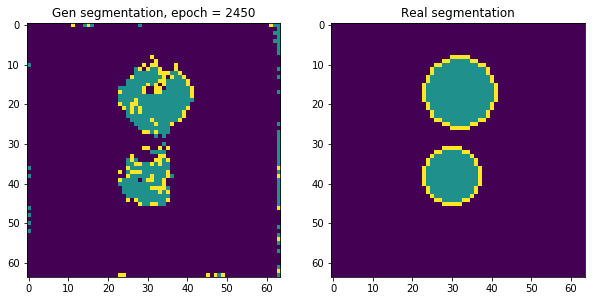

epoch - 2450, loss - 0.0736678689718
epoch - 2451, loss - 0.0703807175159
epoch - 2452, loss - 0.0683205276728
epoch - 2453, loss - 0.069545596838
epoch - 2454, loss - 0.0718782916665
epoch - 2455, loss - 0.0714124068618
epoch - 2456, loss - 0.0693682208657
epoch - 2457, loss - 0.0672674328089
epoch - 2458, loss - 0.067848354578
epoch - 2459, loss - 0.0697992295027
epoch - 2460, loss - 0.0702555030584
epoch - 2461, loss - 0.0692242458463
epoch - 2462, loss - 0.0675531774759
epoch - 2463, loss - 0.0674035251141
epoch - 2464, loss - 0.0686286389828
epoch - 2465, loss - 0.0697504729033
epoch - 2466, loss - 0.0701564997435
epoch - 2467, loss - 0.0695872157812
epoch - 2468, loss - 0.0689233839512
epoch - 2469, loss - 0.0688751935959
epoch - 2470, loss - 0.0694725513458
epoch - 2471, loss - 0.0706505477428
epoch - 2472, loss - 0.0716382041574
epoch - 2473, loss - 0.0726899430156
epoch - 2474, loss - 0.0757282450795
epoch - 2475, loss - 0.0834615379572
epoch - 2476, loss - 0.0998060181737
epo

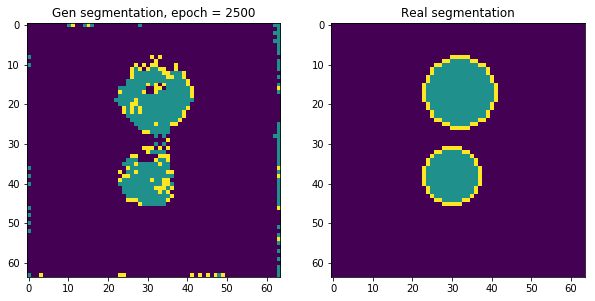

epoch - 2500, loss - 0.111122772098
epoch - 2501, loss - 0.110726051033
epoch - 2502, loss - 0.114833898842
epoch - 2503, loss - 0.109074838459
epoch - 2504, loss - 0.104077503085
epoch - 2505, loss - 0.0932861715555
epoch - 2506, loss - 0.105141729116
epoch - 2507, loss - 0.0938515514135
epoch - 2508, loss - 0.0881396532059
epoch - 2509, loss - 0.0919213965535
epoch - 2510, loss - 0.0871262177825
epoch - 2511, loss - 0.0876585096121
epoch - 2512, loss - 0.0808186382055
epoch - 2513, loss - 0.082492813468
epoch - 2514, loss - 0.0840459540486
epoch - 2515, loss - 0.0774932056665
epoch - 2516, loss - 0.0785814225674
epoch - 2517, loss - 0.0770946145058
epoch - 2518, loss - 0.0772344022989
epoch - 2519, loss - 0.0759644657373
epoch - 2520, loss - 0.0731314271688
epoch - 2521, loss - 0.0746649652719
epoch - 2522, loss - 0.0735417157412
epoch - 2523, loss - 0.0720123648643
epoch - 2524, loss - 0.071829251945
epoch - 2525, loss - 0.0708630532026
epoch - 2526, loss - 0.0711709335446
epoch - 2

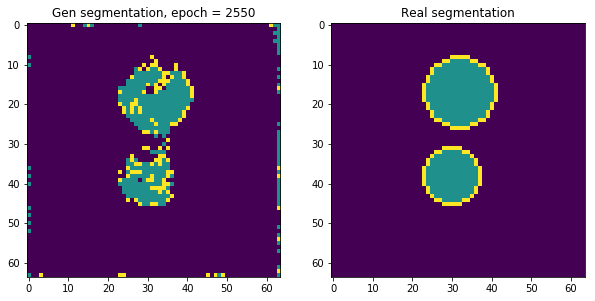

epoch - 2550, loss - 0.0614392608404
epoch - 2551, loss - 0.0613326504827
epoch - 2552, loss - 0.0612703897059
epoch - 2553, loss - 0.0614074058831
epoch - 2554, loss - 0.0617565885186
epoch - 2555, loss - 0.062239062041
epoch - 2556, loss - 0.062911003828
epoch - 2557, loss - 0.0634122788906
epoch - 2558, loss - 0.0634948834777
epoch - 2559, loss - 0.063519179821
epoch - 2560, loss - 0.0638776943088
epoch - 2561, loss - 0.0658634006977
epoch - 2562, loss - 0.0688355267048
epoch - 2563, loss - 0.0723468959332
epoch - 2564, loss - 0.0719079002738
epoch - 2565, loss - 0.0687882527709
epoch - 2566, loss - 0.0637481883168
epoch - 2567, loss - 0.0634124726057
epoch - 2568, loss - 0.0665425658226
epoch - 2569, loss - 0.0671214908361
epoch - 2570, loss - 0.0646927580237
epoch - 2571, loss - 0.0623523294926
epoch - 2572, loss - 0.0627911537886
epoch - 2573, loss - 0.0642369538546
epoch - 2574, loss - 0.0636281520128
epoch - 2575, loss - 0.061565708369
epoch - 2576, loss - 0.0605254620314
epoch

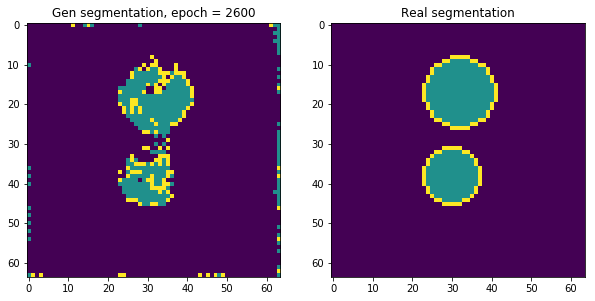

epoch - 2600, loss - 0.0636556968093
epoch - 2601, loss - 0.064599826932
epoch - 2602, loss - 0.065818503499
epoch - 2603, loss - 0.0658651441336
epoch - 2604, loss - 0.0653118267655
epoch - 2605, loss - 0.0642914324999
epoch - 2606, loss - 0.0639273151755
epoch - 2607, loss - 0.0634514689445
epoch - 2608, loss - 0.06224065274
epoch - 2609, loss - 0.061212643981
epoch - 2610, loss - 0.0608081221581
epoch - 2611, loss - 0.0613627284765
epoch - 2612, loss - 0.061662748456
epoch - 2613, loss - 0.0604226961732
epoch - 2614, loss - 0.0591732114553
epoch - 2615, loss - 0.0600599125028
epoch - 2616, loss - 0.0615102574229
epoch - 2617, loss - 0.0612890310585
epoch - 2618, loss - 0.0599029064178
epoch - 2619, loss - 0.0595688447356
epoch - 2620, loss - 0.0610932558775
epoch - 2621, loss - 0.062652528286
epoch - 2622, loss - 0.063172891736
epoch - 2623, loss - 0.06392981112
epoch - 2624, loss - 0.0658573582768
epoch - 2625, loss - 0.0686175227165
epoch - 2626, loss - 0.0712423920631
epoch - 262

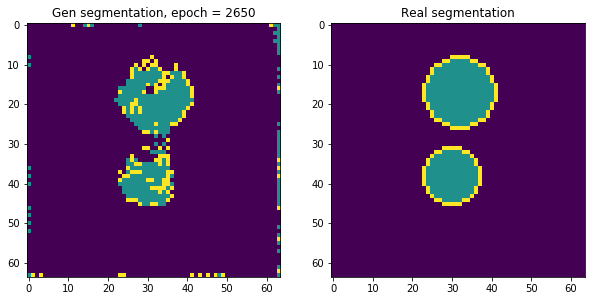

epoch - 2650, loss - 0.0950237438083
epoch - 2651, loss - 0.100981771946
epoch - 2652, loss - 0.0960211604834
epoch - 2653, loss - 0.0964050590992
epoch - 2654, loss - 0.0914254188538
epoch - 2655, loss - 0.0865860283375
epoch - 2656, loss - 0.0853171795607
epoch - 2657, loss - 0.0856933295727
epoch - 2658, loss - 0.0843596309423
epoch - 2659, loss - 0.0810099616647
epoch - 2660, loss - 0.0774053260684
epoch - 2661, loss - 0.0738934352994
epoch - 2662, loss - 0.0744470506907
epoch - 2663, loss - 0.0731931999326
epoch - 2664, loss - 0.0729884654284
epoch - 2665, loss - 0.0701864883304
epoch - 2666, loss - 0.0682638213038
epoch - 2667, loss - 0.0673345699906
epoch - 2668, loss - 0.0662247315049
epoch - 2669, loss - 0.0663421452045
epoch - 2670, loss - 0.0652329623699
epoch - 2671, loss - 0.0645791888237
epoch - 2672, loss - 0.0632168054581
epoch - 2673, loss - 0.0622363202274
epoch - 2674, loss - 0.0617061182857
epoch - 2675, loss - 0.0610389187932
epoch - 2676, loss - 0.0606916695833
ep

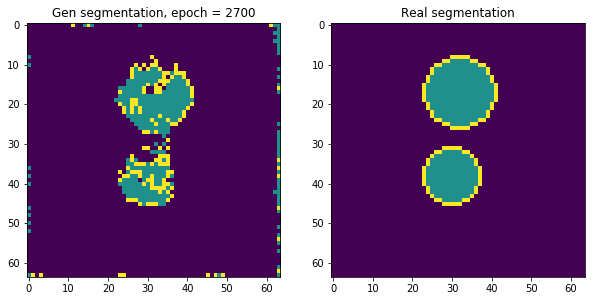

epoch - 2700, loss - 0.0592826902866
epoch - 2701, loss - 0.0587622001767
epoch - 2702, loss - 0.0575806647539
epoch - 2703, loss - 0.0570933334529
epoch - 2704, loss - 0.0580470748246
epoch - 2705, loss - 0.0599079616368
epoch - 2706, loss - 0.0618746802211
epoch - 2707, loss - 0.0630521476269
epoch - 2708, loss - 0.0632529333234
epoch - 2709, loss - 0.0648209676147
epoch - 2710, loss - 0.0664477497339
epoch - 2711, loss - 0.0699046775699
epoch - 2712, loss - 0.0719709843397
epoch - 2713, loss - 0.0738458931446
epoch - 2714, loss - 0.0724735334516
epoch - 2715, loss - 0.0706980675459
epoch - 2716, loss - 0.0725529640913
epoch - 2717, loss - 0.0755947902799
epoch - 2718, loss - 0.0777908563614
epoch - 2719, loss - 0.0794241204858
epoch - 2720, loss - 0.0828501135111
epoch - 2721, loss - 0.0880723744631
epoch - 2722, loss - 0.0969404131174
epoch - 2723, loss - 0.104306861758
epoch - 2724, loss - 0.111334554851
epoch - 2725, loss - 0.114033654332
epoch - 2726, loss - 0.118424743414
epoch

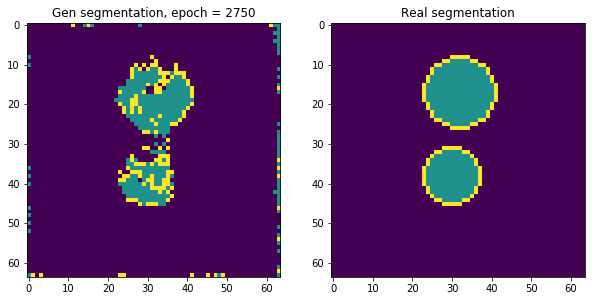

epoch - 2750, loss - 0.0587738007307
epoch - 2751, loss - 0.0587663352489
epoch - 2752, loss - 0.058158904314
epoch - 2753, loss - 0.056434430182
epoch - 2754, loss - 0.0548055507243
epoch - 2755, loss - 0.0546542853117
epoch - 2756, loss - 0.0549552552402
epoch - 2757, loss - 0.0545374676585
epoch - 2758, loss - 0.0542837381363
epoch - 2759, loss - 0.0550967827439
epoch - 2760, loss - 0.0562864243984
epoch - 2761, loss - 0.0566729158163
epoch - 2762, loss - 0.0565458536148
epoch - 2763, loss - 0.0568196773529
epoch - 2764, loss - 0.0607929863036
epoch - 2765, loss - 0.0596740916371
epoch - 2766, loss - 0.0621699728072
epoch - 2767, loss - 0.065045915544
epoch - 2768, loss - 0.0702132582664
epoch - 2769, loss - 0.0780762657523
epoch - 2770, loss - 0.0858098417521
epoch - 2771, loss - 0.0936065465212
epoch - 2772, loss - 0.0935691148043
epoch - 2773, loss - 0.0944605469704
epoch - 2774, loss - 0.0992745012045
epoch - 2775, loss - 0.115546673536
epoch - 2776, loss - 0.141654714942
epoch 

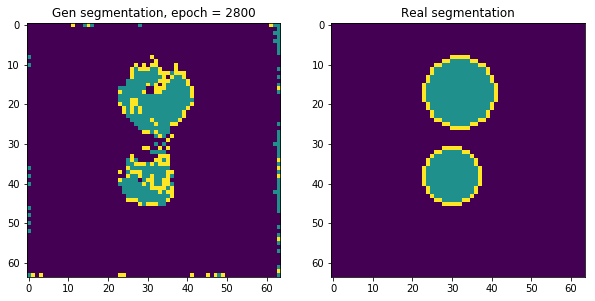

epoch - 2800, loss - 0.0579338595271
epoch - 2801, loss - 0.0582162886858
epoch - 2802, loss - 0.0599723681808
epoch - 2803, loss - 0.0592830888927
epoch - 2804, loss - 0.0595161728561
epoch - 2805, loss - 0.0593117773533
epoch - 2806, loss - 0.0571937859058
epoch - 2807, loss - 0.0551499538124
epoch - 2808, loss - 0.0543256141245
epoch - 2809, loss - 0.0532919764519
epoch - 2810, loss - 0.0529836416245
epoch - 2811, loss - 0.0534006394446
epoch - 2812, loss - 0.0531890131533
epoch - 2813, loss - 0.0531024932861
epoch - 2814, loss - 0.0531750172377
epoch - 2815, loss - 0.0526765361428
epoch - 2816, loss - 0.0519276410341
epoch - 2817, loss - 0.0516929700971
epoch - 2818, loss - 0.0513495393097
epoch - 2819, loss - 0.0506232604384
epoch - 2820, loss - 0.0504753291607
epoch - 2821, loss - 0.0505239851773
epoch - 2822, loss - 0.0503275580704
epoch - 2823, loss - 0.0504825673997
epoch - 2824, loss - 0.0506520196795
epoch - 2825, loss - 0.0508237555623
epoch - 2826, loss - 0.0508632212877
e

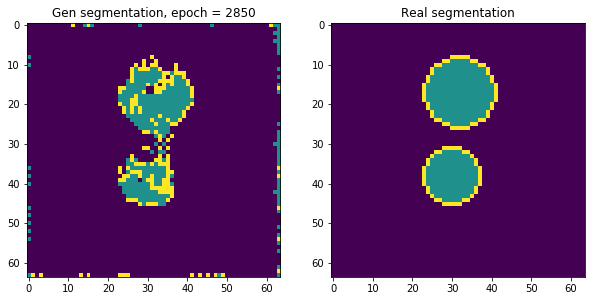

epoch - 2850, loss - 0.310178250074
epoch - 2851, loss - 0.378447175026
epoch - 2852, loss - 0.436013817787
epoch - 2853, loss - 0.355370402336
epoch - 2854, loss - 0.214351207018
epoch - 2855, loss - 0.108253732324
epoch - 2856, loss - 0.129606738687
epoch - 2857, loss - 0.195337980986
epoch - 2858, loss - 0.200048953295
epoch - 2859, loss - 0.138521388173
epoch - 2860, loss - 0.0886942446232
epoch - 2861, loss - 0.115877017379
epoch - 2862, loss - 0.143257290125
epoch - 2863, loss - 0.110902108252
epoch - 2864, loss - 0.0815258473158
epoch - 2865, loss - 0.0926616936922
epoch - 2866, loss - 0.107798799872
epoch - 2867, loss - 0.0932753831148
epoch - 2868, loss - 0.0754936933517
epoch - 2869, loss - 0.0785319954157
epoch - 2870, loss - 0.0874947533011
epoch - 2871, loss - 0.0808533802629
epoch - 2872, loss - 0.0678483173251
epoch - 2873, loss - 0.0682400614023
epoch - 2874, loss - 0.0753133967519
epoch - 2875, loss - 0.0706884115934
epoch - 2876, loss - 0.0616907514632
epoch - 2877, l

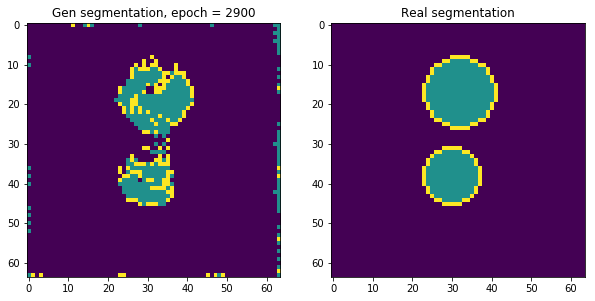

epoch - 2900, loss - 0.0497359111905
epoch - 2901, loss - 0.0496126897633
epoch - 2902, loss - 0.0496623441577
epoch - 2903, loss - 0.0494095794857
epoch - 2904, loss - 0.0496601164341
epoch - 2905, loss - 0.0503131076694
epoch - 2906, loss - 0.0509758219123
epoch - 2907, loss - 0.0518784597516
epoch - 2908, loss - 0.0525354221463
epoch - 2909, loss - 0.053590670228
epoch - 2910, loss - 0.0532701984048
epoch - 2911, loss - 0.0518229976296
epoch - 2912, loss - 0.0496749095619
epoch - 2913, loss - 0.0483046621084
epoch - 2914, loss - 0.048604670912
epoch - 2915, loss - 0.0495944917202
epoch - 2916, loss - 0.0503727272153
epoch - 2917, loss - 0.0503070652485
epoch - 2918, loss - 0.0495869964361
epoch - 2919, loss - 0.0488218255341
epoch - 2920, loss - 0.048245254904
epoch - 2921, loss - 0.0479256920516
epoch - 2922, loss - 0.0474873743951
epoch - 2923, loss - 0.0473714061081
epoch - 2924, loss - 0.0476123467088
epoch - 2925, loss - 0.0480204708874
epoch - 2926, loss - 0.0484821721911
epoc

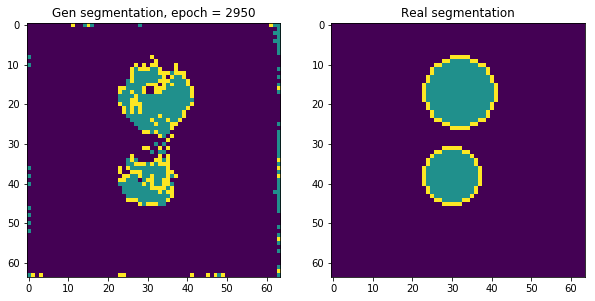

epoch - 2950, loss - 0.0572285056114
epoch - 2951, loss - 0.0553438290954
epoch - 2952, loss - 0.0541583970189
epoch - 2953, loss - 0.0542490147054
epoch - 2954, loss - 0.0527834668756
epoch - 2955, loss - 0.0513484738767
epoch - 2956, loss - 0.0514498576522
epoch - 2957, loss - 0.0512017160654
epoch - 2958, loss - 0.0496696680784
epoch - 2959, loss - 0.0488095805049
epoch - 2960, loss - 0.0488820113242
epoch - 2961, loss - 0.0490648634732
epoch - 2962, loss - 0.0484688282013
epoch - 2963, loss - 0.0480100214481
epoch - 2964, loss - 0.0483100488782
epoch - 2965, loss - 0.0482628047466
epoch - 2966, loss - 0.0477002635598
epoch - 2967, loss - 0.0473558865488
epoch - 2968, loss - 0.0474734827876
epoch - 2969, loss - 0.0480894036591
epoch - 2970, loss - 0.048222001642
epoch - 2971, loss - 0.0487084314227
epoch - 2972, loss - 0.0499692521989
epoch - 2973, loss - 0.0508983284235
epoch - 2974, loss - 0.051794834435
epoch - 2975, loss - 0.0521377548575
epoch - 2976, loss - 0.0520615763962
epo

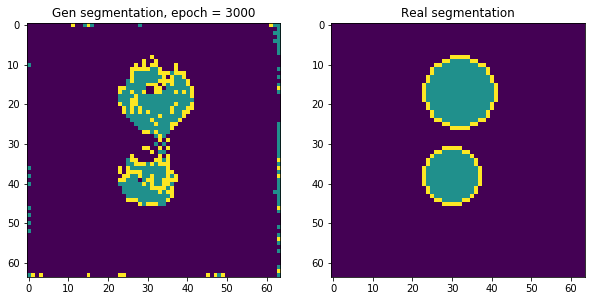

epoch - 3000, loss - 0.0829915106297
epoch - 3001, loss - 0.0839012935758
epoch - 3002, loss - 0.0935510098934
epoch - 3003, loss - 0.113864518702
epoch - 3004, loss - 0.146986618638
epoch - 3005, loss - 0.190534263849
epoch - 3006, loss - 0.259879052639
epoch - 3007, loss - 0.318588256836
epoch - 3008, loss - 0.367962837219
epoch - 3009, loss - 0.315567344427
epoch - 3010, loss - 0.204535678029
epoch - 3011, loss - 0.0916357040405
epoch - 3012, loss - 0.0742917060852
epoch - 3013, loss - 0.132674872875
epoch - 3014, loss - 0.169186070561
epoch - 3015, loss - 0.135174036026
epoch - 3016, loss - 0.0720590800047
epoch - 3017, loss - 0.0699597373605
epoch - 3018, loss - 0.110954023898
epoch - 3019, loss - 0.112932302058
epoch - 3020, loss - 0.0784841924906
epoch - 3021, loss - 0.0618580393493
epoch - 3022, loss - 0.0795930549502
epoch - 3023, loss - 0.0911369770765
epoch - 3024, loss - 0.0732909291983
epoch - 3025, loss - 0.0573422200978
epoch - 3026, loss - 0.0650543421507
epoch - 3027, 

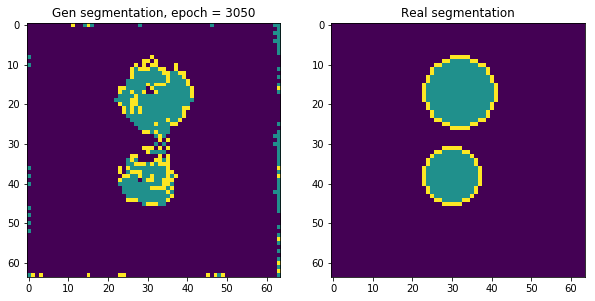

epoch - 3050, loss - 0.0456207096577
epoch - 3051, loss - 0.0446924082935
epoch - 3052, loss - 0.0440997853875
epoch - 3053, loss - 0.0443188101053
epoch - 3054, loss - 0.0447370521724
epoch - 3055, loss - 0.0445518009365
epoch - 3056, loss - 0.044296681881
epoch - 3057, loss - 0.0448991581798
epoch - 3058, loss - 0.0463056564331
epoch - 3059, loss - 0.0479592680931
epoch - 3060, loss - 0.048947904259
epoch - 3061, loss - 0.0490713566542
epoch - 3062, loss - 0.0484919846058
epoch - 3063, loss - 0.0468667447567
epoch - 3064, loss - 0.0459111481905
epoch - 3065, loss - 0.045470431447
epoch - 3066, loss - 0.0457798540592
epoch - 3067, loss - 0.0465314760804
epoch - 3068, loss - 0.0478187203407
epoch - 3069, loss - 0.0489301197231
epoch - 3070, loss - 0.049382083118
epoch - 3071, loss - 0.0477058328688
epoch - 3072, loss - 0.0462924391031
epoch - 3073, loss - 0.0459489449859
epoch - 3074, loss - 0.0473473444581
epoch - 3075, loss - 0.0474711023271
epoch - 3076, loss - 0.046694509685
epoch 

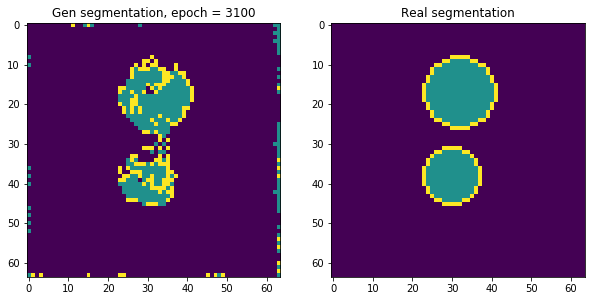

epoch - 3100, loss - 0.0454247742891
epoch - 3101, loss - 0.0486354790628
epoch - 3102, loss - 0.0514546632767
epoch - 3103, loss - 0.0522759146988
epoch - 3104, loss - 0.0527837350965
epoch - 3105, loss - 0.0514738336205
epoch - 3106, loss - 0.0507954396307
epoch - 3107, loss - 0.0498008877039
epoch - 3108, loss - 0.0507630668581
epoch - 3109, loss - 0.0498697124422
epoch - 3110, loss - 0.0478574633598
epoch - 3111, loss - 0.0481037572026
epoch - 3112, loss - 0.0500373020768
epoch - 3113, loss - 0.0526145473123
epoch - 3114, loss - 0.0516808703542
epoch - 3115, loss - 0.049106143415
epoch - 3116, loss - 0.0481343753636
epoch - 3117, loss - 0.0494920909405
epoch - 3118, loss - 0.0497709177434
epoch - 3119, loss - 0.0474859476089
epoch - 3120, loss - 0.0483875162899
epoch - 3121, loss - 0.0524652116001
epoch - 3122, loss - 0.0543393939734
epoch - 3123, loss - 0.0542762726545
epoch - 3124, loss - 0.054341904819
epoch - 3125, loss - 0.0558769442141
epoch - 3126, loss - 0.0564446747303
epo

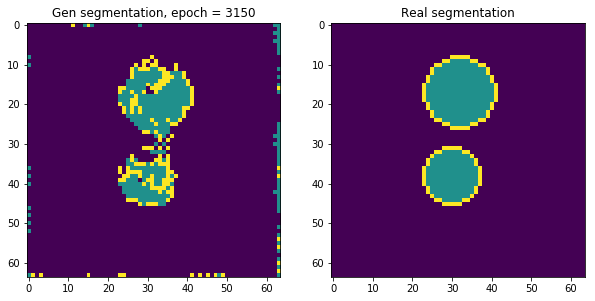

epoch - 3150, loss - 0.0514752715826
epoch - 3151, loss - 0.0543271154165
epoch - 3152, loss - 0.0519069582224
epoch - 3153, loss - 0.0508761480451
epoch - 3154, loss - 0.0537924617529
epoch - 3155, loss - 0.0542384460568
epoch - 3156, loss - 0.0522848963737
epoch - 3157, loss - 0.0515211559832
epoch - 3158, loss - 0.0508185699582
epoch - 3159, loss - 0.0494424179196
epoch - 3160, loss - 0.0470140874386
epoch - 3161, loss - 0.0453191697598
epoch - 3162, loss - 0.0450926870108
epoch - 3163, loss - 0.0452564805746
epoch - 3164, loss - 0.0441699326038
epoch - 3165, loss - 0.0428127795458
epoch - 3166, loss - 0.0425654351711
epoch - 3167, loss - 0.0422670692205
epoch - 3168, loss - 0.0416118986905
epoch - 3169, loss - 0.0415318459272
epoch - 3170, loss - 0.0417823120952
epoch - 3171, loss - 0.0418225154281
epoch - 3172, loss - 0.041605617851
epoch - 3173, loss - 0.0415719486773
epoch - 3174, loss - 0.0417040027678
epoch - 3175, loss - 0.0418582819402
epoch - 3176, loss - 0.0422058627009
ep

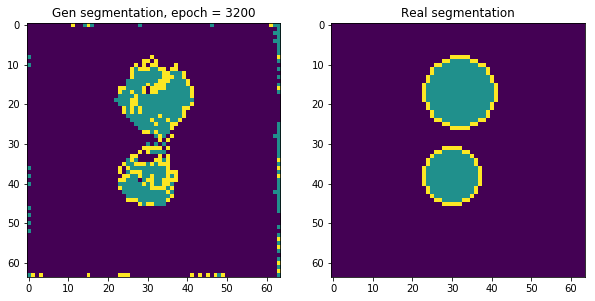

epoch - 3200, loss - 0.140963107347
epoch - 3201, loss - 0.192902982235
epoch - 3202, loss - 0.168784022331
epoch - 3203, loss - 0.170179829001
epoch - 3204, loss - 0.166471809149
epoch - 3205, loss - 0.160382837057
epoch - 3206, loss - 0.146683081985
epoch - 3207, loss - 0.13040804863
epoch - 3208, loss - 0.126063928008
epoch - 3209, loss - 0.122610524297
epoch - 3210, loss - 0.121670871973
epoch - 3211, loss - 0.115329131484
epoch - 3212, loss - 0.104976601899
epoch - 3213, loss - 0.10043054074
epoch - 3214, loss - 0.0926981568336
epoch - 3215, loss - 0.0942269712687
epoch - 3216, loss - 0.0911395251751
epoch - 3217, loss - 0.0867822393775
epoch - 3218, loss - 0.0822521448135
epoch - 3219, loss - 0.0777035355568
epoch - 3220, loss - 0.0766556933522
epoch - 3221, loss - 0.0746802091599
epoch - 3222, loss - 0.0749718770385
epoch - 3223, loss - 0.0727726742625
epoch - 3224, loss - 0.0707401111722
epoch - 3225, loss - 0.0688505619764
epoch - 3226, loss - 0.0667905658484
epoch - 3227, los

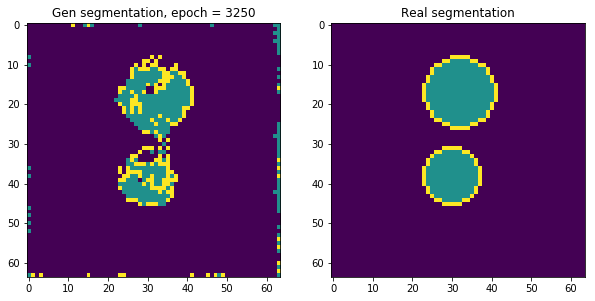

epoch - 3250, loss - 0.0456040687859
epoch - 3251, loss - 0.0451437681913
epoch - 3252, loss - 0.0447834208608
epoch - 3253, loss - 0.0443752333522
epoch - 3254, loss - 0.044046394527
epoch - 3255, loss - 0.0437452830374
epoch - 3256, loss - 0.0434672906995
epoch - 3257, loss - 0.0431557632983
epoch - 3258, loss - 0.0429658144712
epoch - 3259, loss - 0.0427068881691
epoch - 3260, loss - 0.0424983799458
epoch - 3261, loss - 0.0423003993928
epoch - 3262, loss - 0.0422380417585
epoch - 3263, loss - 0.0421104729176
epoch - 3264, loss - 0.0419520922005
epoch - 3265, loss - 0.0418100990355
epoch - 3266, loss - 0.0418196767569
epoch - 3267, loss - 0.0419929027557
epoch - 3268, loss - 0.0423902198672
epoch - 3269, loss - 0.0430710837245
epoch - 3270, loss - 0.043976329267
epoch - 3271, loss - 0.0451358444989
epoch - 3272, loss - 0.0463206470013
epoch - 3273, loss - 0.0470358915627
epoch - 3274, loss - 0.0473618879914
epoch - 3275, loss - 0.0478001385927
epoch - 3276, loss - 0.049826361239
epoc

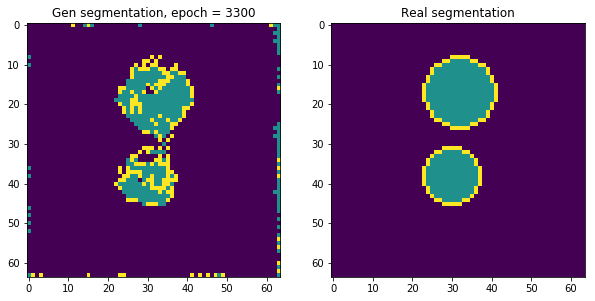

epoch - 3300, loss - 0.0608632415533
epoch - 3301, loss - 0.0671062096953
epoch - 3302, loss - 0.0647236481309
epoch - 3303, loss - 0.0574099645019
epoch - 3304, loss - 0.0525363981724
epoch - 3305, loss - 0.0525070428848
epoch - 3306, loss - 0.0548834577203
epoch - 3307, loss - 0.0552869103849
epoch - 3308, loss - 0.0509716570377
epoch - 3309, loss - 0.046571791172
epoch - 3310, loss - 0.0470444113016
epoch - 3311, loss - 0.0491047352552
epoch - 3312, loss - 0.0482323169708
epoch - 3313, loss - 0.0458095371723
epoch - 3314, loss - 0.044007897377
epoch - 3315, loss - 0.0431692898273
epoch - 3316, loss - 0.0439109951258
epoch - 3317, loss - 0.0445980653167
epoch - 3318, loss - 0.0432368069887
epoch - 3319, loss - 0.0413679145277
epoch - 3320, loss - 0.0408310852945
epoch - 3321, loss - 0.0413399934769
epoch - 3322, loss - 0.0413564816117
epoch - 3323, loss - 0.0413604900241
epoch - 3324, loss - 0.0407629497349
epoch - 3325, loss - 0.0398103557527
epoch - 3326, loss - 0.0392616651952
epo

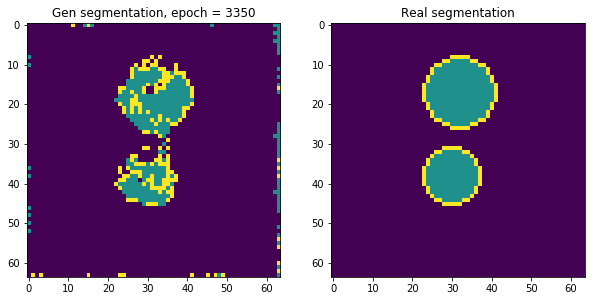

epoch - 3350, loss - 0.0431867577136
epoch - 3351, loss - 0.0427776798606
epoch - 3352, loss - 0.0407997518778
epoch - 3353, loss - 0.0383055731654
epoch - 3354, loss - 0.0371170453727
epoch - 3355, loss - 0.0376267135143
epoch - 3356, loss - 0.038716159761
epoch - 3357, loss - 0.0395934619009
epoch - 3358, loss - 0.0390121266246
epoch - 3359, loss - 0.0381896942854
epoch - 3360, loss - 0.0379942245781
epoch - 3361, loss - 0.0383333303034
epoch - 3362, loss - 0.0385347828269
epoch - 3363, loss - 0.0380163528025
epoch - 3364, loss - 0.0371284373105
epoch - 3365, loss - 0.0365396998823
epoch - 3366, loss - 0.0365084111691
epoch - 3367, loss - 0.0368507690728
epoch - 3368, loss - 0.0369631126523
epoch - 3369, loss - 0.0367422401905
epoch - 3370, loss - 0.0363964661956
epoch - 3371, loss - 0.0359660387039
epoch - 3372, loss - 0.0358549915254
epoch - 3373, loss - 0.0359945297241
epoch - 3374, loss - 0.0362212508917
epoch - 3375, loss - 0.0364871956408
epoch - 3376, loss - 0.0366876609623
ep

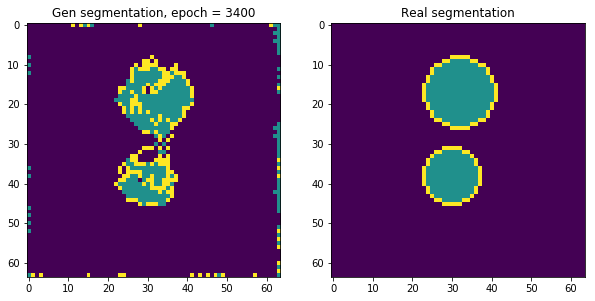

epoch - 3400, loss - 0.172646552324
epoch - 3401, loss - 0.102592781186
epoch - 3402, loss - 0.0744510516524
epoch - 3403, loss - 0.0840222463012
epoch - 3404, loss - 0.114106670022
epoch - 3405, loss - 0.126711338758
epoch - 3406, loss - 0.0907271057367
epoch - 3407, loss - 0.0628869011998
epoch - 3408, loss - 0.0739974528551
epoch - 3409, loss - 0.0778610259295
epoch - 3410, loss - 0.077788643539
epoch - 3411, loss - 0.0750057324767
epoch - 3412, loss - 0.0568439550698
epoch - 3413, loss - 0.0580824762583
epoch - 3414, loss - 0.0666515529156
epoch - 3415, loss - 0.0570086166263
epoch - 3416, loss - 0.0564185902476
epoch - 3417, loss - 0.0551850572228
epoch - 3418, loss - 0.0479046106339
epoch - 3419, loss - 0.0512952283025
epoch - 3420, loss - 0.0507492870092
epoch - 3421, loss - 0.0469455942512
epoch - 3422, loss - 0.0475592687726
epoch - 3423, loss - 0.0447353720665
epoch - 3424, loss - 0.0432444289327
epoch - 3425, loss - 0.0454437211156
epoch - 3426, loss - 0.0438829064369
epoch 

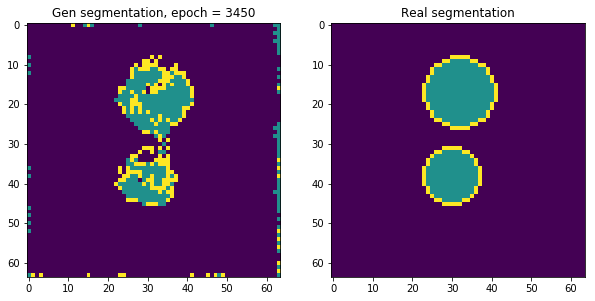

epoch - 3450, loss - 0.034460529685
epoch - 3451, loss - 0.0342243313789
epoch - 3452, loss - 0.0340001247823
epoch - 3453, loss - 0.033886346966
epoch - 3454, loss - 0.0337612107396
epoch - 3455, loss - 0.033805295825
epoch - 3456, loss - 0.0340506061912
epoch - 3457, loss - 0.0343643240631
epoch - 3458, loss - 0.034889921546
epoch - 3459, loss - 0.0356516987085
epoch - 3460, loss - 0.036418247968
epoch - 3461, loss - 0.0372618883848
epoch - 3462, loss - 0.0376699343324
epoch - 3463, loss - 0.037485845387
epoch - 3464, loss - 0.0369729958475
epoch - 3465, loss - 0.0363634079695
epoch - 3466, loss - 0.0367075316608
epoch - 3467, loss - 0.0381641760468
epoch - 3468, loss - 0.0400084555149
epoch - 3469, loss - 0.0413149297237
epoch - 3470, loss - 0.0411888286471
epoch - 3471, loss - 0.039452329278
epoch - 3472, loss - 0.0384981036186
epoch - 3473, loss - 0.0386211127043
epoch - 3474, loss - 0.039258800447
epoch - 3475, loss - 0.0402269475162
epoch - 3476, loss - 0.0411322414875
epoch - 3

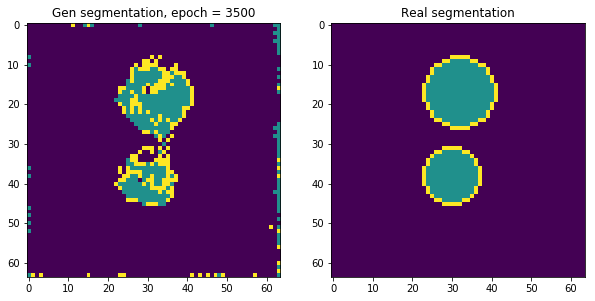

epoch - 3500, loss - 0.0538566708565
epoch - 3501, loss - 0.0491849891841
epoch - 3502, loss - 0.0465672165155
epoch - 3503, loss - 0.0453621074557
epoch - 3504, loss - 0.044246442616
epoch - 3505, loss - 0.0421788021922
epoch - 3506, loss - 0.0422272160649
epoch - 3507, loss - 0.0436444357038
epoch - 3508, loss - 0.0427355580032
epoch - 3509, loss - 0.0411352515221
epoch - 3510, loss - 0.0419369265437
epoch - 3511, loss - 0.0434047281742
epoch - 3512, loss - 0.0427636876702
epoch - 3513, loss - 0.041295837611
epoch - 3514, loss - 0.0412715673447
epoch - 3515, loss - 0.0421599671245
epoch - 3516, loss - 0.0420093946159
epoch - 3517, loss - 0.0415771380067
epoch - 3518, loss - 0.0415814965963
epoch - 3519, loss - 0.0421542525291
epoch - 3520, loss - 0.0428631529212
epoch - 3521, loss - 0.0441708154976
epoch - 3522, loss - 0.0453844219446
epoch - 3523, loss - 0.0473985597491
epoch - 3524, loss - 0.0495690181851
epoch - 3525, loss - 0.0518198981881
epoch - 3526, loss - 0.0536197945476
epo

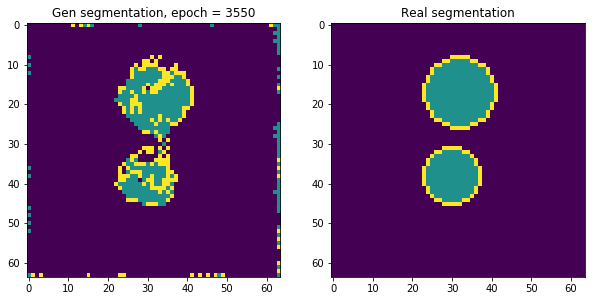

epoch - 3550, loss - 0.0434336513281
epoch - 3551, loss - 0.0421705022454
epoch - 3552, loss - 0.0405222103
epoch - 3553, loss - 0.0384122133255
epoch - 3554, loss - 0.0377098917961
epoch - 3555, loss - 0.0379385128617
epoch - 3556, loss - 0.0381013192236
epoch - 3557, loss - 0.0375546067953
epoch - 3558, loss - 0.0366016589105
epoch - 3559, loss - 0.0362380072474
epoch - 3560, loss - 0.0365314260125
epoch - 3561, loss - 0.0362369306386
epoch - 3562, loss - 0.0347674041986
epoch - 3563, loss - 0.0339488238096
epoch - 3564, loss - 0.0344311967492
epoch - 3565, loss - 0.0340422838926
epoch - 3566, loss - 0.0330693982542
epoch - 3567, loss - 0.0328992307186
epoch - 3568, loss - 0.033295109868
epoch - 3569, loss - 0.0333594791591
epoch - 3570, loss - 0.0329528264701
epoch - 3571, loss - 0.0330068357289
epoch - 3572, loss - 0.0334085561335
epoch - 3573, loss - 0.0337518267334
epoch - 3574, loss - 0.03407580778
epoch - 3575, loss - 0.0348225459456
epoch - 3576, loss - 0.0350355356932
epoch -

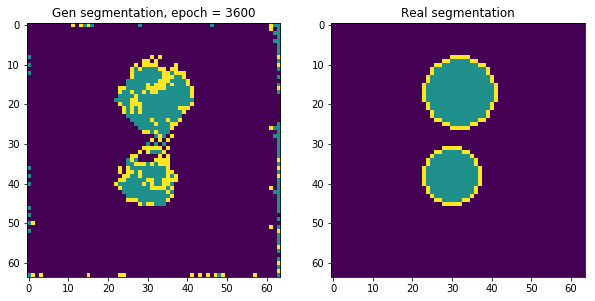

epoch - 3600, loss - 0.104444660246
epoch - 3601, loss - 0.101586043835
epoch - 3602, loss - 0.113919265568
epoch - 3603, loss - 0.125217407942
epoch - 3604, loss - 0.0959035754204
epoch - 3605, loss - 0.0780662745237
epoch - 3606, loss - 0.0894731432199
epoch - 3607, loss - 0.0883174389601
epoch - 3608, loss - 0.0824777558446
epoch - 3609, loss - 0.0698810145259
epoch - 3610, loss - 0.0657947063446
epoch - 3611, loss - 0.0759308710694
epoch - 3612, loss - 0.0672077164054
epoch - 3613, loss - 0.0601510666311
epoch - 3614, loss - 0.0610826388001
epoch - 3615, loss - 0.0578459240496
epoch - 3616, loss - 0.0619822740555
epoch - 3617, loss - 0.0548964068294
epoch - 3618, loss - 0.0510060600936
epoch - 3619, loss - 0.0542131215334
epoch - 3620, loss - 0.0514020323753
epoch - 3621, loss - 0.0504157245159
epoch - 3622, loss - 0.0473246127367
epoch - 3623, loss - 0.0450714156032
epoch - 3624, loss - 0.0462160110474
epoch - 3625, loss - 0.0450442843139
epoch - 3626, loss - 0.0425808355212
epoch

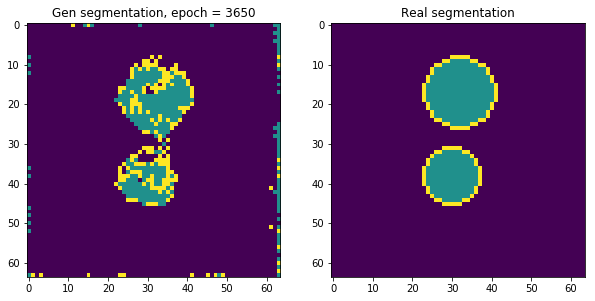

epoch - 3650, loss - 0.0320446528494
epoch - 3651, loss - 0.0318538323045
epoch - 3652, loss - 0.0316584184766
epoch - 3653, loss - 0.0315131992102
epoch - 3654, loss - 0.0314930044115
epoch - 3655, loss - 0.0315022915602
epoch - 3656, loss - 0.031822565943
epoch - 3657, loss - 0.0321274511516
epoch - 3658, loss - 0.0327210500836
epoch - 3659, loss - 0.033591337502
epoch - 3660, loss - 0.0349075458944
epoch - 3661, loss - 0.0361239351332
epoch - 3662, loss - 0.0370820313692
epoch - 3663, loss - 0.0364374034107
epoch - 3664, loss - 0.034551076591
epoch - 3665, loss - 0.0323175415397
epoch - 3666, loss - 0.0315629281104
epoch - 3667, loss - 0.03241815418
epoch - 3668, loss - 0.034187912941
epoch - 3669, loss - 0.035287398845
epoch - 3670, loss - 0.0349975936115
epoch - 3671, loss - 0.0332762673497
epoch - 3672, loss - 0.0311705563217
epoch - 3673, loss - 0.0303461682051
epoch - 3674, loss - 0.0310908351094
epoch - 3675, loss - 0.032292932272
epoch - 3676, loss - 0.0331014245749
epoch - 3

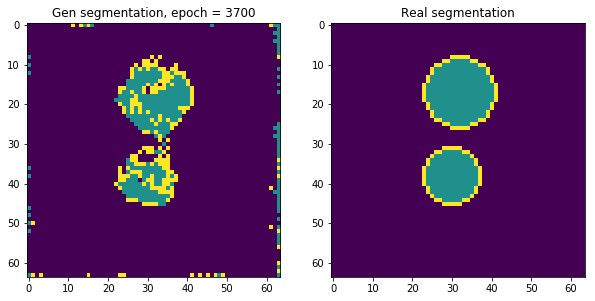

epoch - 3700, loss - 0.031442258507
epoch - 3701, loss - 0.0316892191768
epoch - 3702, loss - 0.0323312580585
epoch - 3703, loss - 0.0328901931643
epoch - 3704, loss - 0.0330933704972
epoch - 3705, loss - 0.0327902957797
epoch - 3706, loss - 0.0327552594244
epoch - 3707, loss - 0.0330372191966
epoch - 3708, loss - 0.0342476814985
epoch - 3709, loss - 0.035261426121
epoch - 3710, loss - 0.0352883897722
epoch - 3711, loss - 0.0343190431595
epoch - 3712, loss - 0.0328374430537
epoch - 3713, loss - 0.0325716286898
epoch - 3714, loss - 0.0341073088348
epoch - 3715, loss - 0.0368889831007
epoch - 3716, loss - 0.0398705750704
epoch - 3717, loss - 0.0424325987697
epoch - 3718, loss - 0.0452305004001
epoch - 3719, loss - 0.0498260855675
epoch - 3720, loss - 0.058424256742
epoch - 3721, loss - 0.0714204534888
epoch - 3722, loss - 0.0873033106327
epoch - 3723, loss - 0.104215204716
epoch - 3724, loss - 0.117425173521
epoch - 3725, loss - 0.13832180202
epoch - 3726, loss - 0.156509682536
epoch - 3

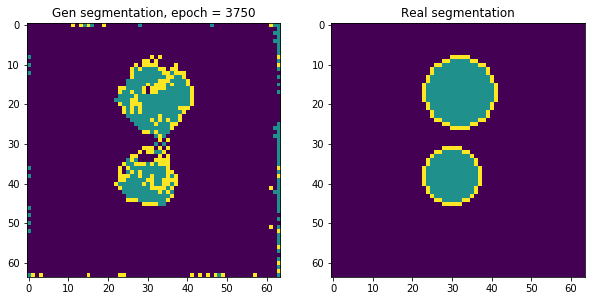

epoch - 3750, loss - 0.0426233932376
epoch - 3751, loss - 0.0414351634681
epoch - 3752, loss - 0.0418225452304
epoch - 3753, loss - 0.0384089685977
epoch - 3754, loss - 0.0392307825387
epoch - 3755, loss - 0.0393818020821
epoch - 3756, loss - 0.0372026711702
epoch - 3757, loss - 0.0373760946095
epoch - 3758, loss - 0.0362065397203
epoch - 3759, loss - 0.0343686938286
epoch - 3760, loss - 0.0343054383993
epoch - 3761, loss - 0.0339359864593
epoch - 3762, loss - 0.0330108515918
epoch - 3763, loss - 0.0331790298223
epoch - 3764, loss - 0.0329307764769
epoch - 3765, loss - 0.0321111045778
epoch - 3766, loss - 0.0318460203707
epoch - 3767, loss - 0.0315356999636
epoch - 3768, loss - 0.0308026559651
epoch - 3769, loss - 0.0305540598929
epoch - 3770, loss - 0.0304388552904
epoch - 3771, loss - 0.0300749596208
epoch - 3772, loss - 0.029982868582
epoch - 3773, loss - 0.0299411788583
epoch - 3774, loss - 0.029633756727
epoch - 3775, loss - 0.0294498950243
epoch - 3776, loss - 0.0293064489961
epo

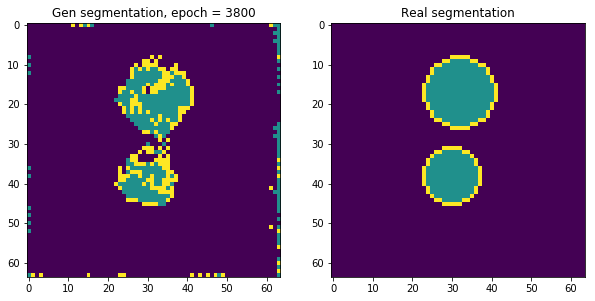

epoch - 3800, loss - 0.0385225191712
epoch - 3801, loss - 0.0432104021311
epoch - 3802, loss - 0.0490400567651
epoch - 3803, loss - 0.0562140084803
epoch - 3804, loss - 0.0685415267944
epoch - 3805, loss - 0.0885498300195
epoch - 3806, loss - 0.122920244932
epoch - 3807, loss - 0.166309341788
epoch - 3808, loss - 0.220598593354
epoch - 3809, loss - 0.25319904089
epoch - 3810, loss - 0.264819025993
epoch - 3811, loss - 0.216891184449
epoch - 3812, loss - 0.157788693905
epoch - 3813, loss - 0.0894020870328
epoch - 3814, loss - 0.0740232616663
epoch - 3815, loss - 0.1105235219
epoch - 3816, loss - 0.140527456999
epoch - 3817, loss - 0.104054391384
epoch - 3818, loss - 0.0637811273336
epoch - 3819, loss - 0.0751449912786
epoch - 3820, loss - 0.0815113410354
epoch - 3821, loss - 0.0745490789413
epoch - 3822, loss - 0.0754411146045
epoch - 3823, loss - 0.0615384653211
epoch - 3824, loss - 0.0533651560545
epoch - 3825, loss - 0.0640682801604
epoch - 3826, loss - 0.0595628172159
epoch - 3827, 

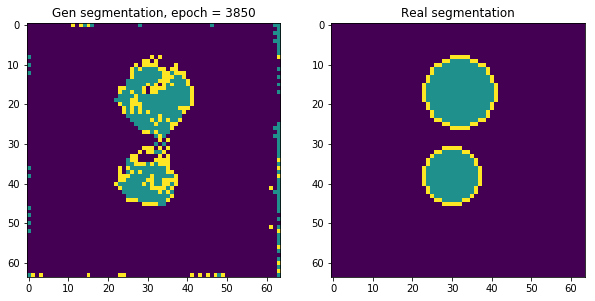

epoch - 3850, loss - 0.0305312015116
epoch - 3851, loss - 0.0309405364096
epoch - 3852, loss - 0.0305632334203
epoch - 3853, loss - 0.0301240384579
epoch - 3854, loss - 0.0301471874118
epoch - 3855, loss - 0.0296280030161
epoch - 3856, loss - 0.0291067380458
epoch - 3857, loss - 0.0290301814675
epoch - 3858, loss - 0.0289494842291
epoch - 3859, loss - 0.0286491140723
epoch - 3860, loss - 0.0283941235393
epoch - 3861, loss - 0.0282315537333
epoch - 3862, loss - 0.0279409270734
epoch - 3863, loss - 0.0276441313326
epoch - 3864, loss - 0.0275798924267
epoch - 3865, loss - 0.0277502182871
epoch - 3866, loss - 0.0275090485811
epoch - 3867, loss - 0.0275548063219
epoch - 3868, loss - 0.0274688508362
epoch - 3869, loss - 0.0272245667875
epoch - 3870, loss - 0.0271164216101
epoch - 3871, loss - 0.0269932262599
epoch - 3872, loss - 0.0269022360444
epoch - 3873, loss - 0.026782758534
epoch - 3874, loss - 0.0267405956984
epoch - 3875, loss - 0.0267462581396
epoch - 3876, loss - 0.0268458444625
ep

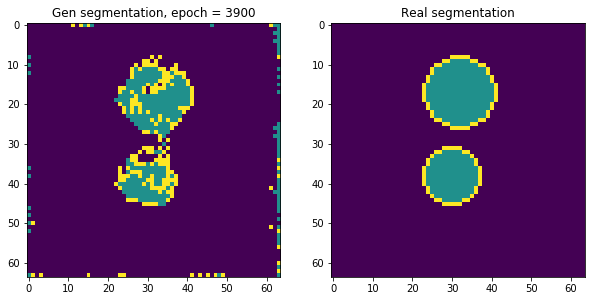

epoch - 3900, loss - 0.0265229921788
epoch - 3901, loss - 0.0268345251679
epoch - 3902, loss - 0.0272902343422
epoch - 3903, loss - 0.0275798216462
epoch - 3904, loss - 0.0276833735406
epoch - 3905, loss - 0.0275140181184
epoch - 3906, loss - 0.0273363552988
epoch - 3907, loss - 0.0275017768145
epoch - 3908, loss - 0.0281509421766
epoch - 3909, loss - 0.0294575802982
epoch - 3910, loss - 0.0313272327185
epoch - 3911, loss - 0.0335398167372
epoch - 3912, loss - 0.0365387648344
epoch - 3913, loss - 0.0395264364779
epoch - 3914, loss - 0.0440392047167
epoch - 3915, loss - 0.049700088799
epoch - 3916, loss - 0.0578086674213
epoch - 3917, loss - 0.0695696473122
epoch - 3918, loss - 0.0852226912975
epoch - 3919, loss - 0.108426369727
epoch - 3920, loss - 0.131863892078
epoch - 3921, loss - 0.156973302364
epoch - 3922, loss - 0.1638097018
epoch - 3923, loss - 0.167393311858
epoch - 3924, loss - 0.161228373647
epoch - 3925, loss - 0.151420235634
epoch - 3926, loss - 0.105274349451
epoch - 3927

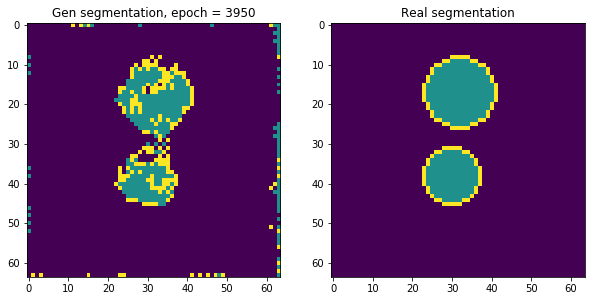

epoch - 3950, loss - 0.0350788496435
epoch - 3951, loss - 0.0363838933408
epoch - 3952, loss - 0.0332416631281
epoch - 3953, loss - 0.0325649268925
epoch - 3954, loss - 0.032832019031
epoch - 3955, loss - 0.0309682749212
epoch - 3956, loss - 0.0307970382273
epoch - 3957, loss - 0.0314877703786
epoch - 3958, loss - 0.030454557389
epoch - 3959, loss - 0.0305355656892
epoch - 3960, loss - 0.0308224968612
epoch - 3961, loss - 0.0298627298325
epoch - 3962, loss - 0.0297163017094
epoch - 3963, loss - 0.0296894311905
epoch - 3964, loss - 0.0287701748312
epoch - 3965, loss - 0.0285439416766
epoch - 3966, loss - 0.0284690335393
epoch - 3967, loss - 0.0278894603252
epoch - 3968, loss - 0.0276353377849
epoch - 3969, loss - 0.027549572289
epoch - 3970, loss - 0.0270646270365
epoch - 3971, loss - 0.0268359202892
epoch - 3972, loss - 0.0267367772758
epoch - 3973, loss - 0.0262914672494
epoch - 3974, loss - 0.0260774660856
epoch - 3975, loss - 0.0260002519935
epoch - 3976, loss - 0.0257172454149
epoc

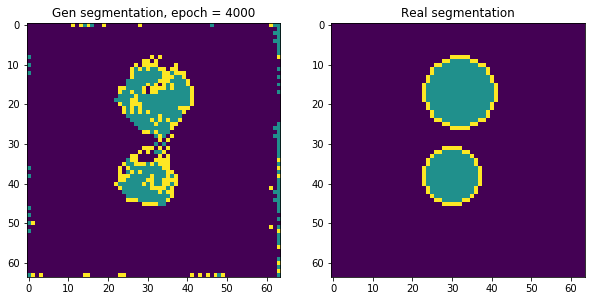

epoch - 4000, loss - 0.0607416220009
epoch - 4001, loss - 0.0735745728016
epoch - 4002, loss - 0.0928004533052
epoch - 4003, loss - 0.117245420814
epoch - 4004, loss - 0.153526037931
epoch - 4005, loss - 0.186377242208
epoch - 4006, loss - 0.213527500629
epoch - 4007, loss - 0.19500438869
epoch - 4008, loss - 0.138914346695
epoch - 4009, loss - 0.0776229947805
epoch - 4010, loss - 0.0690358355641
epoch - 4011, loss - 0.0792205408216
epoch - 4012, loss - 0.0750830247998
epoch - 4013, loss - 0.0755088627338
epoch - 4014, loss - 0.0840618833899
epoch - 4015, loss - 0.0721678808331
epoch - 4016, loss - 0.0436668880284
epoch - 4017, loss - 0.0467562414706
epoch - 4018, loss - 0.0550536066294
epoch - 4019, loss - 0.0514871478081
epoch - 4020, loss - 0.0537518337369
epoch - 4021, loss - 0.0450978837907
epoch - 4022, loss - 0.0347276926041
epoch - 4023, loss - 0.0403728224337
epoch - 4024, loss - 0.041091285646
epoch - 4025, loss - 0.0389160551131
epoch - 4026, loss - 0.0405641458929
epoch - 4

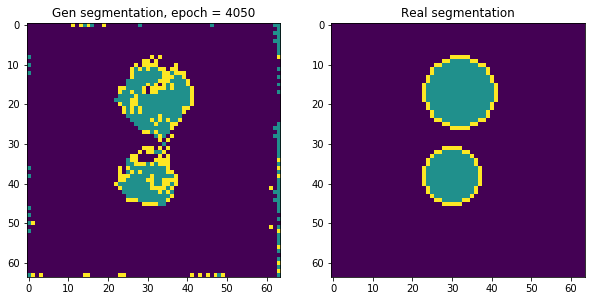

epoch - 4050, loss - 0.025155864656
epoch - 4051, loss - 0.025013409555
epoch - 4052, loss - 0.0250096116215
epoch - 4053, loss - 0.0246840119362
epoch - 4054, loss - 0.0243879724294
epoch - 4055, loss - 0.0242869593203
epoch - 4056, loss - 0.024050783366
epoch - 4057, loss - 0.0238307211548
epoch - 4058, loss - 0.0238134656101
epoch - 4059, loss - 0.0237176585943
epoch - 4060, loss - 0.0235257390887
epoch - 4061, loss - 0.0235009230673
epoch - 4062, loss - 0.0234575383365
epoch - 4063, loss - 0.0233418084681
epoch - 4064, loss - 0.023301795125
epoch - 4065, loss - 0.0233641155064
epoch - 4066, loss - 0.0234083048999
epoch - 4067, loss - 0.0235187262297
epoch - 4068, loss - 0.0238387696445
epoch - 4069, loss - 0.0241817235947
epoch - 4070, loss - 0.0245285313576
epoch - 4071, loss - 0.0249465275556
epoch - 4072, loss - 0.0253987405449
epoch - 4073, loss - 0.0256312116981
epoch - 4074, loss - 0.0258260145783
epoch - 4075, loss - 0.0261409878731
epoch - 4076, loss - 0.0266939923167
epoch

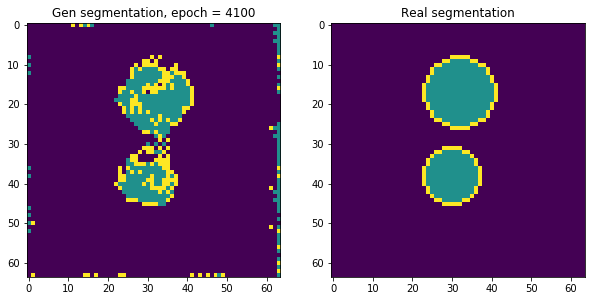

epoch - 4100, loss - 0.0480747073889
epoch - 4101, loss - 0.0434832647443
epoch - 4102, loss - 0.0369196757674
epoch - 4103, loss - 0.0323176681995
epoch - 4104, loss - 0.039628058672
epoch - 4105, loss - 0.0459005311131
epoch - 4106, loss - 0.0402857512236
epoch - 4107, loss - 0.0358516424894
epoch - 4108, loss - 0.0380891859531
epoch - 4109, loss - 0.0348067432642
epoch - 4110, loss - 0.0300270840526
epoch - 4111, loss - 0.0310574807227
epoch - 4112, loss - 0.0313465483487
epoch - 4113, loss - 0.0279780067503
epoch - 4114, loss - 0.026889577508
epoch - 4115, loss - 0.0291156359017
epoch - 4116, loss - 0.0290867388248
epoch - 4117, loss - 0.0272380672395
epoch - 4118, loss - 0.0277706924826
epoch - 4119, loss - 0.0280540063977
epoch - 4120, loss - 0.0260448306799
epoch - 4121, loss - 0.0249626003206
epoch - 4122, loss - 0.0257201716304
epoch - 4123, loss - 0.0251585915685
epoch - 4124, loss - 0.0238853767514
epoch - 4125, loss - 0.0238628536463
epoch - 4126, loss - 0.0241935066879
epo

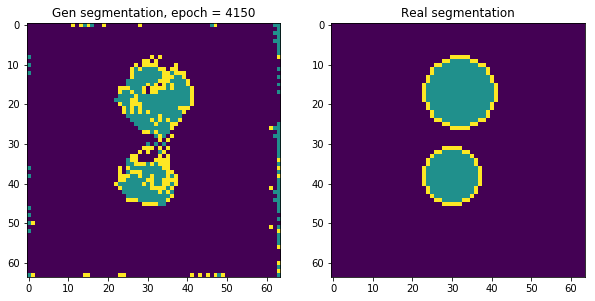

epoch - 4150, loss - 0.12246119976
epoch - 4151, loss - 0.126425325871
epoch - 4152, loss - 0.12209546566
epoch - 4153, loss - 0.0980883687735
epoch - 4154, loss - 0.0678136199713
epoch - 4155, loss - 0.0418592095375
epoch - 4156, loss - 0.0330560728908
epoch - 4157, loss - 0.0430727601051
epoch - 4158, loss - 0.0578358992934
epoch - 4159, loss - 0.0646584331989
epoch - 4160, loss - 0.057406578213
epoch - 4161, loss - 0.0438569299877
epoch - 4162, loss - 0.0358134061098
epoch - 4163, loss - 0.0369858145714
epoch - 4164, loss - 0.0414651855826
epoch - 4165, loss - 0.0408485904336
epoch - 4166, loss - 0.0390626341105
epoch - 4167, loss - 0.0392519123852
epoch - 4168, loss - 0.0365915298462
epoch - 4169, loss - 0.0310857966542
epoch - 4170, loss - 0.0289533659816
epoch - 4171, loss - 0.0315867550671
epoch - 4172, loss - 0.0334096476436
epoch - 4173, loss - 0.0316914916039
epoch - 4174, loss - 0.0294365808368
epoch - 4175, loss - 0.0292936824262
epoch - 4176, loss - 0.0288706570864
epoch -

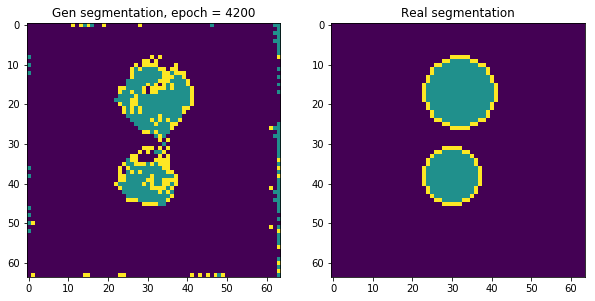

epoch - 4200, loss - 0.0236291214824
epoch - 4201, loss - 0.0235923677683
epoch - 4202, loss - 0.0236412212253
epoch - 4203, loss - 0.0238894801587
epoch - 4204, loss - 0.0242267474532
epoch - 4205, loss - 0.0246449466795
epoch - 4206, loss - 0.0252762250602
epoch - 4207, loss - 0.0261794421822
epoch - 4208, loss - 0.0274217799306
epoch - 4209, loss - 0.0287144519389
epoch - 4210, loss - 0.029506707564
epoch - 4211, loss - 0.0292504578829
epoch - 4212, loss - 0.0277287140489
epoch - 4213, loss - 0.0254766754806
epoch - 4214, loss - 0.0244222134352
epoch - 4215, loss - 0.0247397422791
epoch - 4216, loss - 0.0254541058093
epoch - 4217, loss - 0.0266045294702
epoch - 4218, loss - 0.0273908954114
epoch - 4219, loss - 0.0280944146216
epoch - 4220, loss - 0.0283776912838
epoch - 4221, loss - 0.0282749161124
epoch - 4222, loss - 0.028744218871
epoch - 4223, loss - 0.0308228172362
epoch - 4224, loss - 0.0353847779334
epoch - 4225, loss - 0.0414929054677
epoch - 4226, loss - 0.0498419180512
epo

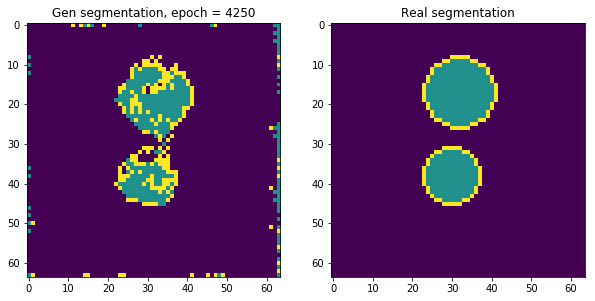

epoch - 4250, loss - 0.0370731018484
epoch - 4251, loss - 0.0372602157295
epoch - 4252, loss - 0.0344174206257
epoch - 4253, loss - 0.032726187259
epoch - 4254, loss - 0.0302137807012
epoch - 4255, loss - 0.0291659031063
epoch - 4256, loss - 0.0296915769577
epoch - 4257, loss - 0.0295230336487
epoch - 4258, loss - 0.0287562850863
epoch - 4259, loss - 0.0276254713535
epoch - 4260, loss - 0.0263971891254
epoch - 4261, loss - 0.0259572453797
epoch - 4262, loss - 0.0259069725871
epoch - 4263, loss - 0.0255860202014
epoch - 4264, loss - 0.0253480151296
epoch - 4265, loss - 0.0255535133183
epoch - 4266, loss - 0.024920610711
epoch - 4267, loss - 0.0245624482632
epoch - 4268, loss - 0.0244564265013
epoch - 4269, loss - 0.0238723345101
epoch - 4270, loss - 0.0235209800303
epoch - 4271, loss - 0.0235007889569
epoch - 4272, loss - 0.0232001300901
epoch - 4273, loss - 0.0230074301362
epoch - 4274, loss - 0.0230284966528
epoch - 4275, loss - 0.0229689069092
epoch - 4276, loss - 0.0229892861098
epo

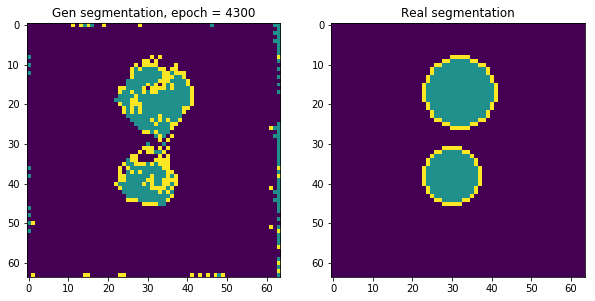

epoch - 4300, loss - 0.0226490311325
epoch - 4301, loss - 0.0222802553326
epoch - 4302, loss - 0.0220158938318
epoch - 4303, loss - 0.0218806192279
epoch - 4304, loss - 0.0218483619392
epoch - 4305, loss - 0.0217277165502
epoch - 4306, loss - 0.0215066801757
epoch - 4307, loss - 0.0214246790856
epoch - 4308, loss - 0.0215317495167
epoch - 4309, loss - 0.0218430049717
epoch - 4310, loss - 0.0221818126738
epoch - 4311, loss - 0.0227197222412
epoch - 4312, loss - 0.0236620754004
epoch - 4313, loss - 0.0248252153397
epoch - 4314, loss - 0.0265616029501
epoch - 4315, loss - 0.028254462406
epoch - 4316, loss - 0.0305410921574
epoch - 4317, loss - 0.0328151024878
epoch - 4318, loss - 0.0360733829439
epoch - 4319, loss - 0.0419128239155
epoch - 4320, loss - 0.0499025583267
epoch - 4321, loss - 0.0607511475682
epoch - 4322, loss - 0.0729302987456
epoch - 4323, loss - 0.0887685865164
epoch - 4324, loss - 0.104784063995
epoch - 4325, loss - 0.12509842217
epoch - 4326, loss - 0.13901977241
epoch -

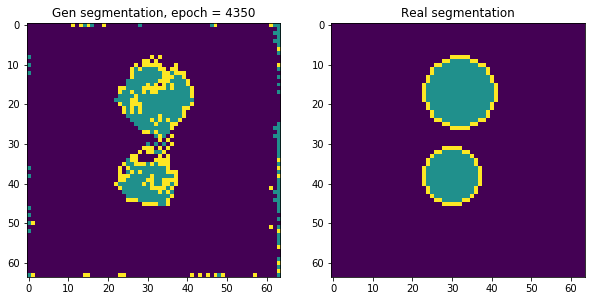

epoch - 4350, loss - 0.0320019498467
epoch - 4351, loss - 0.0314228348434
epoch - 4352, loss - 0.0294028222561
epoch - 4353, loss - 0.0304472837597
epoch - 4354, loss - 0.0301129575819
epoch - 4355, loss - 0.027858812362
epoch - 4356, loss - 0.0274889990687
epoch - 4357, loss - 0.0267229378223
epoch - 4358, loss - 0.0253823176026
epoch - 4359, loss - 0.0255617648363
epoch - 4360, loss - 0.0256133079529
epoch - 4361, loss - 0.0246744714677
epoch - 4362, loss - 0.0243523493409
epoch - 4363, loss - 0.0238961912692
epoch - 4364, loss - 0.0228855721653
epoch - 4365, loss - 0.0226826071739
epoch - 4366, loss - 0.0225716065615
epoch - 4367, loss - 0.0220518726856
epoch - 4368, loss - 0.0221230648458
epoch - 4369, loss - 0.0221344344318
epoch - 4370, loss - 0.0217452198267
epoch - 4371, loss - 0.0216302890331
epoch - 4372, loss - 0.0214568134397
epoch - 4373, loss - 0.0211127027869
epoch - 4374, loss - 0.0209112837911
epoch - 4375, loss - 0.0208422057331
epoch - 4376, loss - 0.0206483602524
ep

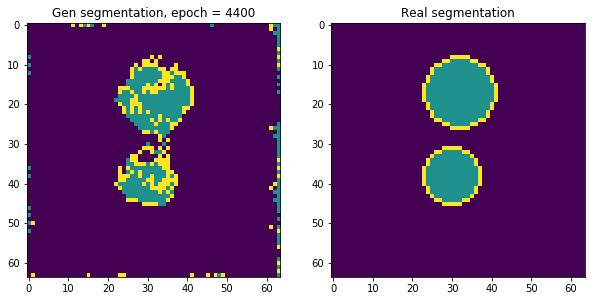

epoch - 4400, loss - 0.0418986231089
epoch - 4401, loss - 0.045350573957
epoch - 4402, loss - 0.0485571846366
epoch - 4403, loss - 0.0506085455418
epoch - 4404, loss - 0.0545874983072
epoch - 4405, loss - 0.0609355643392
epoch - 4406, loss - 0.0725788995624
epoch - 4407, loss - 0.0866098999977
epoch - 4408, loss - 0.100634463131
epoch - 4409, loss - 0.107736937702
epoch - 4410, loss - 0.0948801636696
epoch - 4411, loss - 0.0667864456773
epoch - 4412, loss - 0.0517017357051
epoch - 4413, loss - 0.0525482110679
epoch - 4414, loss - 0.0516243353486
epoch - 4415, loss - 0.0366849116981
epoch - 4416, loss - 0.0313374735415
epoch - 4417, loss - 0.0444349013269
epoch - 4418, loss - 0.0488500222564
epoch - 4419, loss - 0.0441566854715
epoch - 4420, loss - 0.0402625799179
epoch - 4421, loss - 0.0430504009128
epoch - 4422, loss - 0.0394374094903
epoch - 4423, loss - 0.0282425023615
epoch - 4424, loss - 0.0275960415602
epoch - 4425, loss - 0.0326339751482
epoch - 4426, loss - 0.0301396884024
epoc

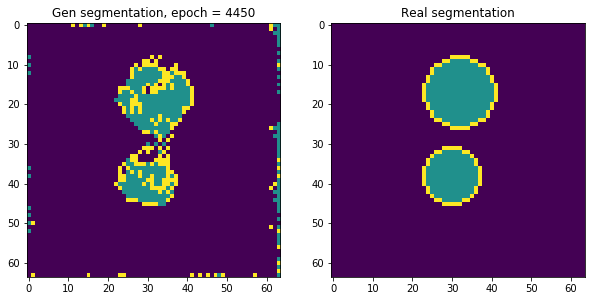

epoch - 4450, loss - 0.0196837875992
epoch - 4451, loss - 0.0194292142987
epoch - 4452, loss - 0.0191616080701
epoch - 4453, loss - 0.0191026870161
epoch - 4454, loss - 0.0189471393824
epoch - 4455, loss - 0.0188983362168
epoch - 4456, loss - 0.0187458377331
epoch - 4457, loss - 0.0187420807779
epoch - 4458, loss - 0.0188368763775
epoch - 4459, loss - 0.0189165957272
epoch - 4460, loss - 0.0190260894597
epoch - 4461, loss - 0.0192769952118
epoch - 4462, loss - 0.019777931273
epoch - 4463, loss - 0.020525963977
epoch - 4464, loss - 0.021682633087
epoch - 4465, loss - 0.0246955491602
epoch - 4466, loss - 0.0285608321428
epoch - 4467, loss - 0.034011490643
epoch - 4468, loss - 0.0416945032775
epoch - 4469, loss - 0.0518900193274
epoch - 4470, loss - 0.0681862458587
epoch - 4471, loss - 0.0902718156576
epoch - 4472, loss - 0.126475572586
epoch - 4473, loss - 0.17105768621
epoch - 4474, loss - 0.230289712548
epoch - 4475, loss - 0.266523629427
epoch - 4476, loss - 0.283938318491
epoch - 447

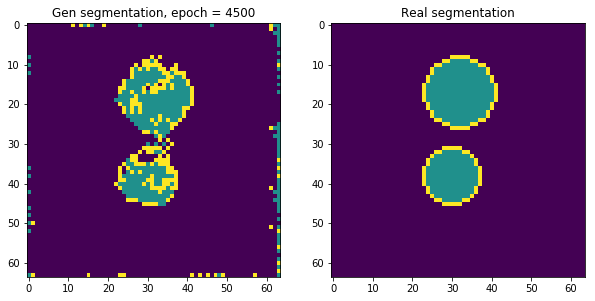

epoch - 4500, loss - 0.0428062826395
epoch - 4501, loss - 0.0445377863944
epoch - 4502, loss - 0.0405748598278
epoch - 4503, loss - 0.0380292385817
epoch - 4504, loss - 0.0402883850038
epoch - 4505, loss - 0.0384779237211
epoch - 4506, loss - 0.0355028733611
epoch - 4507, loss - 0.0351334922016
epoch - 4508, loss - 0.0339359901845
epoch - 4509, loss - 0.0330849215388
epoch - 4510, loss - 0.0323669612408
epoch - 4511, loss - 0.0304148551077
epoch - 4512, loss - 0.0293590836227
epoch - 4513, loss - 0.0290879961103
epoch - 4514, loss - 0.0283103995025
epoch - 4515, loss - 0.0275018848479
epoch - 4516, loss - 0.0269449129701
epoch - 4517, loss - 0.0261944942176
epoch - 4518, loss - 0.0257693324238
epoch - 4519, loss - 0.0253617726266
epoch - 4520, loss - 0.0250855945051
epoch - 4521, loss - 0.0243694446981
epoch - 4522, loss - 0.0239495728165
epoch - 4523, loss - 0.0237060934305
epoch - 4524, loss - 0.0231654644012
epoch - 4525, loss - 0.0229113791138
epoch - 4526, loss - 0.0228005982935
e

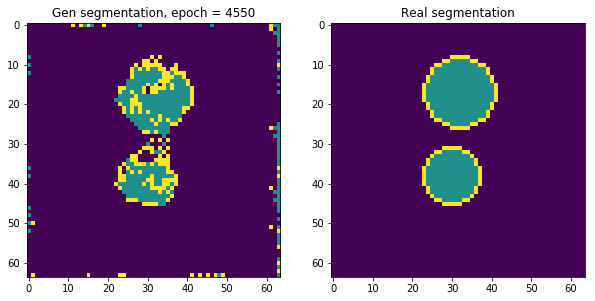

epoch - 4550, loss - 0.0196437127888
epoch - 4551, loss - 0.0195582639426
epoch - 4552, loss - 0.0195651315153
epoch - 4553, loss - 0.0194781348109
epoch - 4554, loss - 0.0194235444069
epoch - 4555, loss - 0.0194238554686
epoch - 4556, loss - 0.0193893201649
epoch - 4557, loss - 0.0193768013269
epoch - 4558, loss - 0.0194025747478
epoch - 4559, loss - 0.0195047371089
epoch - 4560, loss - 0.0196636822075
epoch - 4561, loss - 0.0199674330652
epoch - 4562, loss - 0.0203447490931
epoch - 4563, loss - 0.0208851844072
epoch - 4564, loss - 0.0213589239866
epoch - 4565, loss - 0.0217220652848
epoch - 4566, loss - 0.0215681176633
epoch - 4567, loss - 0.0211259052157
epoch - 4568, loss - 0.0202777013183
epoch - 4569, loss - 0.0195930376649
epoch - 4570, loss - 0.0194262377918
epoch - 4571, loss - 0.0198365431279
epoch - 4572, loss - 0.0204556174576
epoch - 4573, loss - 0.0209037400782
epoch - 4574, loss - 0.0209617875516
epoch - 4575, loss - 0.0205868389457
epoch - 4576, loss - 0.0198950916529
e

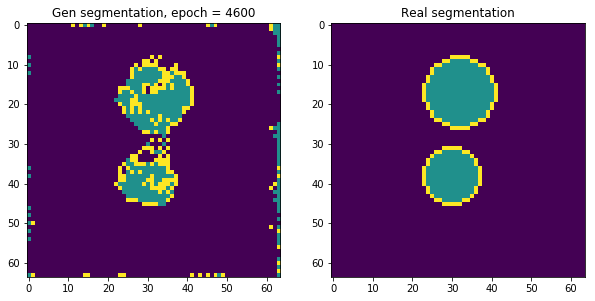

epoch - 4600, loss - 0.0715320855379
epoch - 4601, loss - 0.0959257781506
epoch - 4602, loss - 0.130344226956
epoch - 4603, loss - 0.164254158735
epoch - 4604, loss - 0.210513010621
epoch - 4605, loss - 0.239775821567
epoch - 4606, loss - 0.249098524451
epoch - 4607, loss - 0.180298149586
epoch - 4608, loss - 0.0822692140937
epoch - 4609, loss - 0.0500752441585
epoch - 4610, loss - 0.0935309231281
epoch - 4611, loss - 0.112572267652
epoch - 4612, loss - 0.0812082141638
epoch - 4613, loss - 0.068900026381
epoch - 4614, loss - 0.0630866065621
epoch - 4615, loss - 0.0521169789135
epoch - 4616, loss - 0.0631204470992
epoch - 4617, loss - 0.0619695745409
epoch - 4618, loss - 0.0455811470747
epoch - 4619, loss - 0.0447477772832
epoch - 4620, loss - 0.0442820712924
epoch - 4621, loss - 0.0444742776453
epoch - 4622, loss - 0.0454388931394
epoch - 4623, loss - 0.0372799374163
epoch - 4624, loss - 0.0334644429386
epoch - 4625, loss - 0.0364867113531
epoch - 4626, loss - 0.0353731662035
epoch - 4

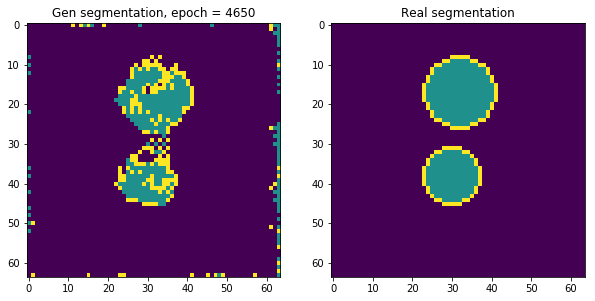

epoch - 4650, loss - 0.0191873274744
epoch - 4651, loss - 0.0189781282097
epoch - 4652, loss - 0.0189649127424
epoch - 4653, loss - 0.0188673567027
epoch - 4654, loss - 0.0187532119453
epoch - 4655, loss - 0.0185726713389
epoch - 4656, loss - 0.0184804797173
epoch - 4657, loss - 0.0182597450912
epoch - 4658, loss - 0.0181142836809
epoch - 4659, loss - 0.0180808193982
epoch - 4660, loss - 0.0180283226073
epoch - 4661, loss - 0.017916848883
epoch - 4662, loss - 0.017810344696
epoch - 4663, loss - 0.0177018307149
epoch - 4664, loss - 0.0176053848118
epoch - 4665, loss - 0.0175399668515
epoch - 4666, loss - 0.0175153296441
epoch - 4667, loss - 0.0175241827965
epoch - 4668, loss - 0.0175775978714
epoch - 4669, loss - 0.0176219493151
epoch - 4670, loss - 0.0176490973681
epoch - 4671, loss - 0.0176627598703
epoch - 4672, loss - 0.0176310390234
epoch - 4673, loss - 0.0176198147237
epoch - 4674, loss - 0.0176936164498
epoch - 4675, loss - 0.0176729299128
epoch - 4676, loss - 0.0176169462502
epo

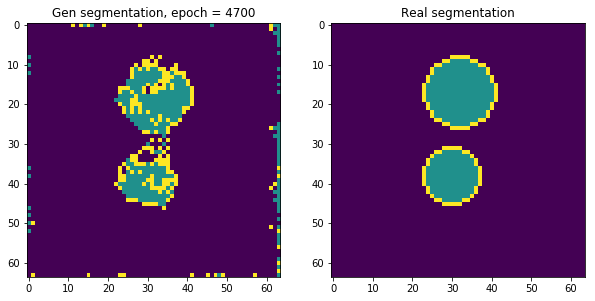

epoch - 4700, loss - 0.0172409527004
epoch - 4701, loss - 0.0171415247023
epoch - 4702, loss - 0.0173659808934
epoch - 4703, loss - 0.0176408365369
epoch - 4704, loss - 0.0178049392998
epoch - 4705, loss - 0.0177048258483
epoch - 4706, loss - 0.0175878331065
epoch - 4707, loss - 0.0174783673137
epoch - 4708, loss - 0.0177408400923
epoch - 4709, loss - 0.018465442583
epoch - 4710, loss - 0.0196384340525
epoch - 4711, loss - 0.0212381668389
epoch - 4712, loss - 0.0232939124107
epoch - 4713, loss - 0.0264507643878
epoch - 4714, loss - 0.0308562517166
epoch - 4715, loss - 0.0363586470485
epoch - 4716, loss - 0.0433095246553
epoch - 4717, loss - 0.0477281883359
epoch - 4718, loss - 0.0540091469884
epoch - 4719, loss - 0.0627633407712
epoch - 4720, loss - 0.0805755481124
epoch - 4721, loss - 0.105451412499
epoch - 4722, loss - 0.127025127411
epoch - 4723, loss - 0.145479783416
epoch - 4724, loss - 0.160825565457
epoch - 4725, loss - 0.164442494512
epoch - 4726, loss - 0.144598200917
epoch - 

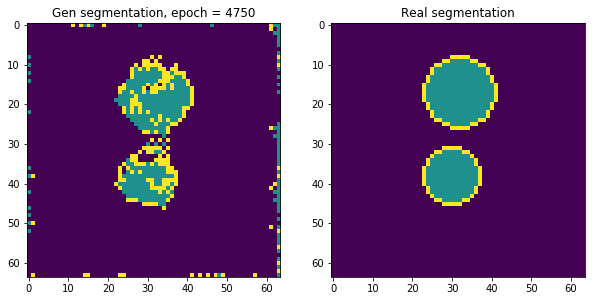

epoch - 4750, loss - 0.0286693349481
epoch - 4751, loss - 0.0293676033616
epoch - 4752, loss - 0.0276065245271
epoch - 4753, loss - 0.0282067358494
epoch - 4754, loss - 0.0267144460231
epoch - 4755, loss - 0.026509700343
epoch - 4756, loss - 0.0269810184836
epoch - 4757, loss - 0.0257943309844
epoch - 4758, loss - 0.0254583619535
epoch - 4759, loss - 0.0243985224515
epoch - 4760, loss - 0.023122228682
epoch - 4761, loss - 0.0227976180613
epoch - 4762, loss - 0.0225107781589
epoch - 4763, loss - 0.0219407454133
epoch - 4764, loss - 0.021863617003
epoch - 4765, loss - 0.0215322449803
epoch - 4766, loss - 0.0209078509361
epoch - 4767, loss - 0.0205510742962
epoch - 4768, loss - 0.0202074758708
epoch - 4769, loss - 0.0197171084583
epoch - 4770, loss - 0.019380081445
epoch - 4771, loss - 0.0192475486547
epoch - 4772, loss - 0.0190559066832
epoch - 4773, loss - 0.0189107432961
epoch - 4774, loss - 0.0187972448766
epoch - 4775, loss - 0.0185987260193
epoch - 4776, loss - 0.0183653626591
epoch

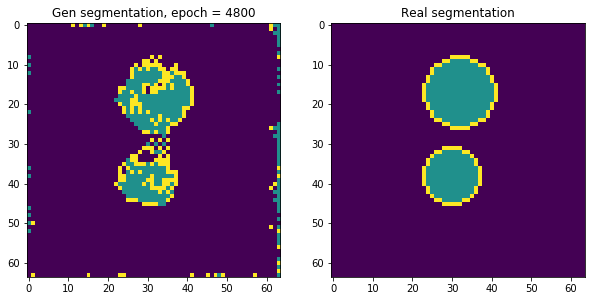

epoch - 4800, loss - 0.0196353271604
epoch - 4801, loss - 0.0205030888319
epoch - 4802, loss - 0.0216628294438
epoch - 4803, loss - 0.0232647377998
epoch - 4804, loss - 0.0256229713559
epoch - 4805, loss - 0.0291729588062
epoch - 4806, loss - 0.0339563265443
epoch - 4807, loss - 0.0411613285542
epoch - 4808, loss - 0.0502599850297
epoch - 4809, loss - 0.0634344369173
epoch - 4810, loss - 0.0776521265507
epoch - 4811, loss - 0.0960857719183
epoch - 4812, loss - 0.111593991518
epoch - 4813, loss - 0.127267837524
epoch - 4814, loss - 0.125389739871
epoch - 4815, loss - 0.11257276684
epoch - 4816, loss - 0.0781020000577
epoch - 4817, loss - 0.0456128977239
epoch - 4818, loss - 0.0292881485075
epoch - 4819, loss - 0.034395866096
epoch - 4820, loss - 0.0518667511642
epoch - 4821, loss - 0.0599313937128
epoch - 4822, loss - 0.0534329786897
epoch - 4823, loss - 0.0386490449309
epoch - 4824, loss - 0.0289125367999
epoch - 4825, loss - 0.0292449556291
epoch - 4826, loss - 0.0338091924787
epoch -

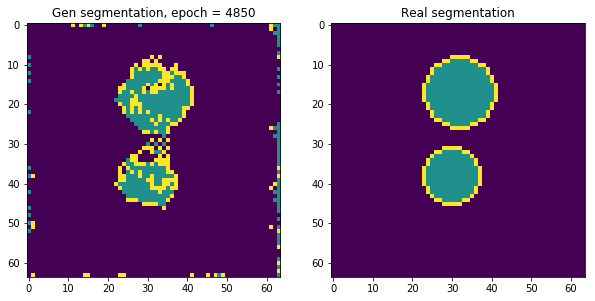

epoch - 4850, loss - 0.0176201015711
epoch - 4851, loss - 0.0174884609878
epoch - 4852, loss - 0.0173778794706
epoch - 4853, loss - 0.0171441268176
epoch - 4854, loss - 0.0169396344572
epoch - 4855, loss - 0.0167812090367
epoch - 4856, loss - 0.0165776610374
epoch - 4857, loss - 0.0163403917104
epoch - 4858, loss - 0.0162969604135
epoch - 4859, loss - 0.016284365207
epoch - 4860, loss - 0.0161748528481
epoch - 4861, loss - 0.0159775316715
epoch - 4862, loss - 0.0158378146589
epoch - 4863, loss - 0.0158724300563
epoch - 4864, loss - 0.0157918520272
epoch - 4865, loss - 0.0157692506909
epoch - 4866, loss - 0.0157576370984
epoch - 4867, loss - 0.0156940072775
epoch - 4868, loss - 0.0156564079225
epoch - 4869, loss - 0.0156346075237
epoch - 4870, loss - 0.0156244672835
epoch - 4871, loss - 0.0156080182642
epoch - 4872, loss - 0.0155908130109
epoch - 4873, loss - 0.0155730266124
epoch - 4874, loss - 0.0155271934345
epoch - 4875, loss - 0.0154919885099
epoch - 4876, loss - 0.0155629329383
ep

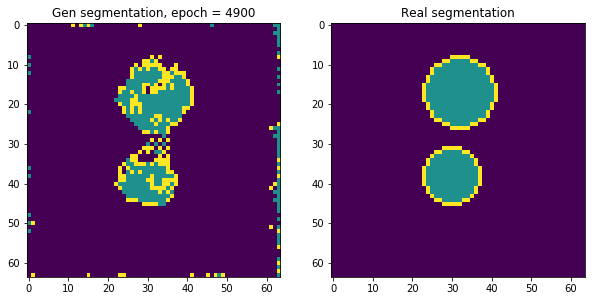

epoch - 4900, loss - 0.121416069567
epoch - 4901, loss - 0.163469314575
epoch - 4902, loss - 0.199938252568
epoch - 4903, loss - 0.233454629779
epoch - 4904, loss - 0.252396404743
epoch - 4905, loss - 0.245859131217
epoch - 4906, loss - 0.315166771412
epoch - 4907, loss - 0.194126978517
epoch - 4908, loss - 0.197384461761
epoch - 4909, loss - 0.195270776749
epoch - 4910, loss - 0.209944069386
epoch - 4911, loss - 0.198509097099
epoch - 4912, loss - 0.177520126104
epoch - 4913, loss - 0.155985742807
epoch - 4914, loss - 0.146278336644
epoch - 4915, loss - 0.152435004711
epoch - 4916, loss - 0.144502133131
epoch - 4917, loss - 0.119209185243
epoch - 4918, loss - 0.111974753439
epoch - 4919, loss - 0.10720770061
epoch - 4920, loss - 0.1119832322
epoch - 4921, loss - 0.0991019904613
epoch - 4922, loss - 0.0908355861902
epoch - 4923, loss - 0.0868765860796
epoch - 4924, loss - 0.0859011113644
epoch - 4925, loss - 0.0850930958986
epoch - 4926, loss - 0.0751720517874
epoch - 4927, loss - 0.06

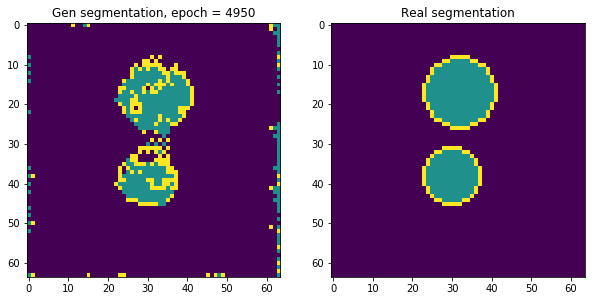

epoch - 4950, loss - 0.0288310982287
epoch - 4951, loss - 0.0281229559332
epoch - 4952, loss - 0.0272583048791
epoch - 4953, loss - 0.0264120176435
epoch - 4954, loss - 0.0257613454014
epoch - 4955, loss - 0.0252951383591
epoch - 4956, loss - 0.0249768011272
epoch - 4957, loss - 0.0245994664729
epoch - 4958, loss - 0.0241229347885
epoch - 4959, loss - 0.0236081033945
epoch - 4960, loss - 0.0231246575713
epoch - 4961, loss - 0.0226534679532
epoch - 4962, loss - 0.0223260521889
epoch - 4963, loss - 0.0220745168626
epoch - 4964, loss - 0.0218377821147
epoch - 4965, loss - 0.0215899422765
epoch - 4966, loss - 0.0213305838406
epoch - 4967, loss - 0.0210167504847
epoch - 4968, loss - 0.0207550376654
epoch - 4969, loss - 0.0204958412796
epoch - 4970, loss - 0.0203029289842
epoch - 4971, loss - 0.0201222710311
epoch - 4972, loss - 0.0199840087444
epoch - 4973, loss - 0.0198724120855
epoch - 4974, loss - 0.019728243351
epoch - 4975, loss - 0.0195818468928
epoch - 4976, loss - 0.0194324459881
ep

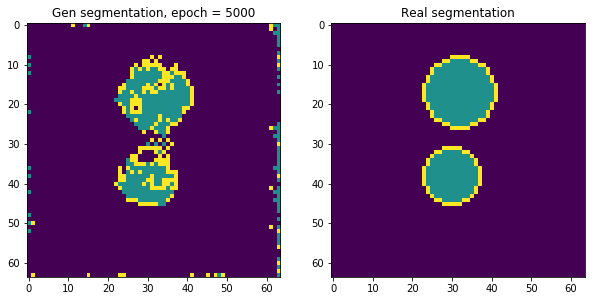

epoch - 5000, loss - 0.0189890377223
epoch - 5001, loss - 0.0185447409749
epoch - 5002, loss - 0.0195845589042
epoch - 5003, loss - 0.0194677524269
epoch - 5004, loss - 0.0184937920421
epoch - 5005, loss - 0.0177103821188
epoch - 5006, loss - 0.0180872194469
epoch - 5007, loss - 0.0187262892723
epoch - 5008, loss - 0.0183745026588
epoch - 5009, loss - 0.0177025366575
epoch - 5010, loss - 0.0174424163997
epoch - 5011, loss - 0.0179020613432
epoch - 5012, loss - 0.0183513890952
epoch - 5013, loss - 0.0183919649571
epoch - 5014, loss - 0.0186948850751
epoch - 5015, loss - 0.0197508111596
epoch - 5016, loss - 0.0220177583396
epoch - 5017, loss - 0.0256877429783
epoch - 5018, loss - 0.0313884466887
epoch - 5019, loss - 0.0415222495794
epoch - 5020, loss - 0.0579942986369
epoch - 5021, loss - 0.0865810364485
epoch - 5022, loss - 0.126204282045
epoch - 5023, loss - 0.186549946666
epoch - 5024, loss - 0.243374854326
epoch - 5025, loss - 0.291489034891
epoch - 5026, loss - 0.249562814832
epoch 

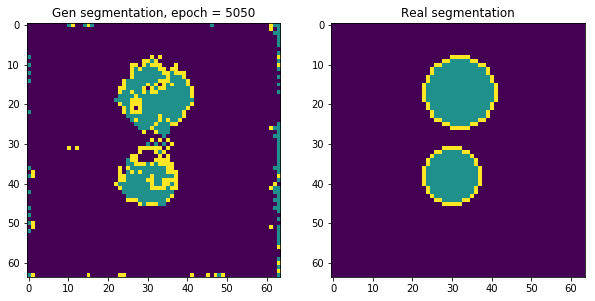

epoch - 5050, loss - 0.024333845824
epoch - 5051, loss - 0.0276182405651
epoch - 5052, loss - 0.0235578157008
epoch - 5053, loss - 0.0203517265618
epoch - 5054, loss - 0.0223387088627
epoch - 5055, loss - 0.0232108514756
epoch - 5056, loss - 0.0209956355393
epoch - 5057, loss - 0.0198042653501
epoch - 5058, loss - 0.0202248841524
epoch - 5059, loss - 0.0201586745679
epoch - 5060, loss - 0.0192631110549
epoch - 5061, loss - 0.0188561193645
epoch - 5062, loss - 0.018647134304
epoch - 5063, loss - 0.0181722342968
epoch - 5064, loss - 0.0180807374418
epoch - 5065, loss - 0.0181208159775
epoch - 5066, loss - 0.0175214409828
epoch - 5067, loss - 0.0169811677188
epoch - 5068, loss - 0.0171392336488
epoch - 5069, loss - 0.0172525420785
epoch - 5070, loss - 0.0168255381286
epoch - 5071, loss - 0.0163581110537
epoch - 5072, loss - 0.0164222568274
epoch - 5073, loss - 0.0166163742542
epoch - 5074, loss - 0.016327759251
epoch - 5075, loss - 0.0159198604524
epoch - 5076, loss - 0.0158965904266
epoc

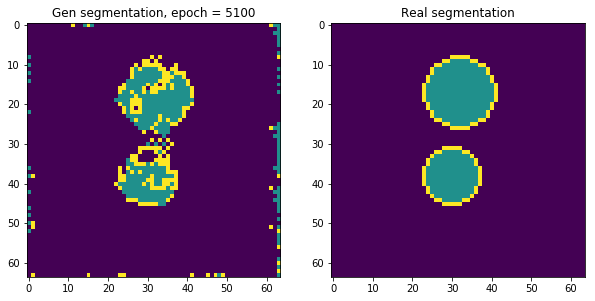

epoch - 5100, loss - 0.0174941979349
epoch - 5101, loss - 0.0176392309368
epoch - 5102, loss - 0.0183099135756
epoch - 5103, loss - 0.0191833171993
epoch - 5104, loss - 0.0196469984949
epoch - 5105, loss - 0.0195372011513
epoch - 5106, loss - 0.0192824974656
epoch - 5107, loss - 0.0195977371186
epoch - 5108, loss - 0.0199367441237
epoch - 5109, loss - 0.020350150764
epoch - 5110, loss - 0.0206507965922
epoch - 5111, loss - 0.0210711788386
epoch - 5112, loss - 0.0213657636195
epoch - 5113, loss - 0.0211944431067
epoch - 5114, loss - 0.0210585836321
epoch - 5115, loss - 0.0205344036222
epoch - 5116, loss - 0.0200903136283
epoch - 5117, loss - 0.0191552974284
epoch - 5118, loss - 0.018988955766
epoch - 5119, loss - 0.0198084842414
epoch - 5120, loss - 0.0202858112752
epoch - 5121, loss - 0.0202289372683
epoch - 5122, loss - 0.0192372947931
epoch - 5123, loss - 0.0180664882064
epoch - 5124, loss - 0.0173561051488
epoch - 5125, loss - 0.0174532085657
epoch - 5126, loss - 0.0178797803819
epo

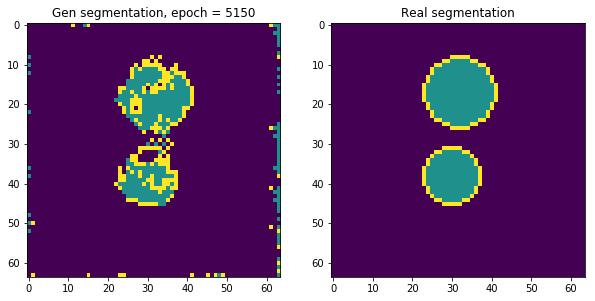

epoch - 5150, loss - 0.0212296210229
epoch - 5151, loss - 0.0184987597167
epoch - 5152, loss - 0.0172356441617
epoch - 5153, loss - 0.0180931836367
epoch - 5154, loss - 0.0199934132397
epoch - 5155, loss - 0.0202461946756
epoch - 5156, loss - 0.0192514080554
epoch - 5157, loss - 0.0182039923966
epoch - 5158, loss - 0.0182602051646
epoch - 5159, loss - 0.0189595967531
epoch - 5160, loss - 0.0185819528997
epoch - 5161, loss - 0.0178924836218
epoch - 5162, loss - 0.0173459276557
epoch - 5163, loss - 0.0180512089282
epoch - 5164, loss - 0.0196403246373
epoch - 5165, loss - 0.0206291116774
epoch - 5166, loss - 0.0208896566182
epoch - 5167, loss - 0.019874162972
epoch - 5168, loss - 0.0192771665752
epoch - 5169, loss - 0.019780009985
epoch - 5170, loss - 0.0199664719403
epoch - 5171, loss - 0.0196085888892
epoch - 5172, loss - 0.018394626677
epoch - 5173, loss - 0.0180036965758
epoch - 5174, loss - 0.0181326139718
epoch - 5175, loss - 0.0175992101431
epoch - 5176, loss - 0.0165268331766
epoc

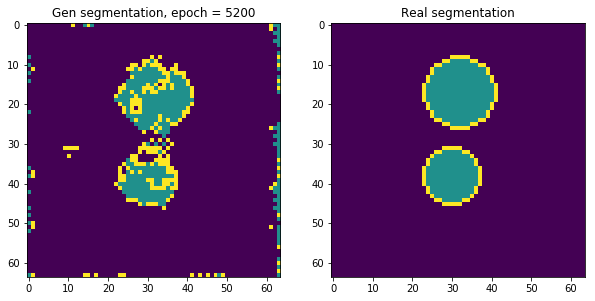

epoch - 5200, loss - 0.0488742105663
epoch - 5201, loss - 0.0578877031803
epoch - 5202, loss - 0.0586062818766
epoch - 5203, loss - 0.0508338473737
epoch - 5204, loss - 0.0351813957095
epoch - 5205, loss - 0.0335308909416
epoch - 5206, loss - 0.0451512150466
epoch - 5207, loss - 0.0411983802915
epoch - 5208, loss - 0.0289621725678
epoch - 5209, loss - 0.0274420380592
epoch - 5210, loss - 0.0313757732511
epoch - 5211, loss - 0.0319571457803
epoch - 5212, loss - 0.0277413390577
epoch - 5213, loss - 0.0225977636874
epoch - 5214, loss - 0.0227942019701
epoch - 5215, loss - 0.0262671150267
epoch - 5216, loss - 0.0247117877007
epoch - 5217, loss - 0.0198253132403
epoch - 5218, loss - 0.0194046832621
epoch - 5219, loss - 0.021466055885
epoch - 5220, loss - 0.0212172493339
epoch - 5221, loss - 0.0192650649697
epoch - 5222, loss - 0.0178059227765
epoch - 5223, loss - 0.0176505800337
epoch - 5224, loss - 0.0182816293091
epoch - 5225, loss - 0.018365804106
epoch - 5226, loss - 0.0170240662992
epo

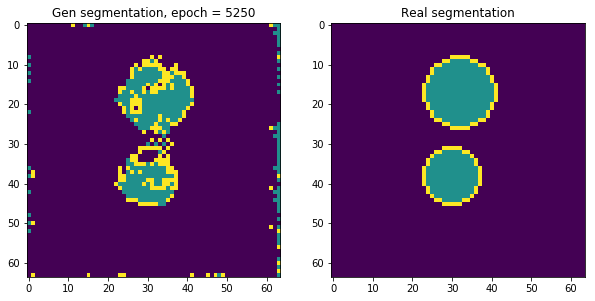

epoch - 5250, loss - 0.0140964183956
epoch - 5251, loss - 0.0140045844018
epoch - 5252, loss - 0.0139830857515
epoch - 5253, loss - 0.0139807499945
epoch - 5254, loss - 0.0139840180054
epoch - 5255, loss - 0.0140100419521
epoch - 5256, loss - 0.0140618886799
epoch - 5257, loss - 0.0141873238608
epoch - 5258, loss - 0.0143251121044
epoch - 5259, loss - 0.0145486164838
epoch - 5260, loss - 0.0148666715249
epoch - 5261, loss - 0.0152699965984
epoch - 5262, loss - 0.0158003643155
epoch - 5263, loss - 0.0163818523288
epoch - 5264, loss - 0.0170608665794
epoch - 5265, loss - 0.0176831707358
epoch - 5266, loss - 0.0178661830723
epoch - 5267, loss - 0.0179783068597
epoch - 5268, loss - 0.0180011875927
epoch - 5269, loss - 0.0185704510659
epoch - 5270, loss - 0.0202526859939
epoch - 5271, loss - 0.0223235301673
epoch - 5272, loss - 0.0237251408398
epoch - 5273, loss - 0.0233616121113
epoch - 5274, loss - 0.0215658806264
epoch - 5275, loss - 0.019902870059
epoch - 5276, loss - 0.0215436406434
ep

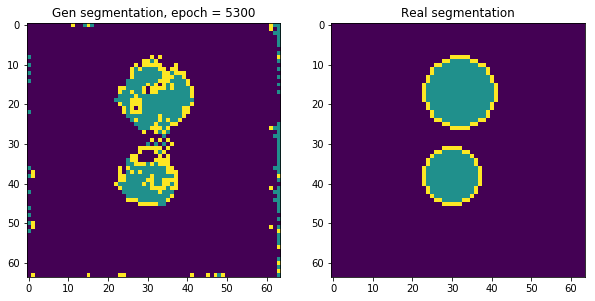

epoch - 5300, loss - 0.0140104070306
epoch - 5301, loss - 0.0146268289536
epoch - 5302, loss - 0.0144207002595
epoch - 5303, loss - 0.0140001904219
epoch - 5304, loss - 0.014341223985
epoch - 5305, loss - 0.015303472057
epoch - 5306, loss - 0.0161398723722
epoch - 5307, loss - 0.016882121563
epoch - 5308, loss - 0.0180776938796
epoch - 5309, loss - 0.0203335545957
epoch - 5310, loss - 0.0236745215952
epoch - 5311, loss - 0.0277130901814
epoch - 5312, loss - 0.0329154282808
epoch - 5313, loss - 0.0394950732589
epoch - 5314, loss - 0.0489566102624
epoch - 5315, loss - 0.0601112022996
epoch - 5316, loss - 0.0740255117416
epoch - 5317, loss - 0.0853433609009
epoch - 5318, loss - 0.0952965691686
epoch - 5319, loss - 0.0928060933948
epoch - 5320, loss - 0.084369212389
epoch - 5321, loss - 0.0648626163602
epoch - 5322, loss - 0.0457849353552
epoch - 5323, loss - 0.030066549778
epoch - 5324, loss - 0.0272650420666
epoch - 5325, loss - 0.0347770042717
epoch - 5326, loss - 0.0451923310757
epoch 

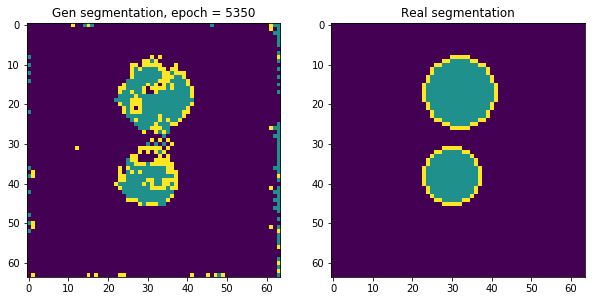

epoch - 5350, loss - 0.0146859306842
epoch - 5351, loss - 0.0138472160324
epoch - 5352, loss - 0.0135029871017
epoch - 5353, loss - 0.0137020731345
epoch - 5354, loss - 0.0139660686255
epoch - 5355, loss - 0.0142504032701
epoch - 5356, loss - 0.0146837476641
epoch - 5357, loss - 0.0152837447822
epoch - 5358, loss - 0.0157222226262
epoch - 5359, loss - 0.0160491783172
epoch - 5360, loss - 0.0167412981391
epoch - 5361, loss - 0.0183077193797
epoch - 5362, loss - 0.0199575945735
epoch - 5363, loss - 0.0216336175799
epoch - 5364, loss - 0.022349178791
epoch - 5365, loss - 0.0225072801113
epoch - 5366, loss - 0.0196341387928
epoch - 5367, loss - 0.0160204153508
epoch - 5368, loss - 0.0152449104935
epoch - 5369, loss - 0.0177128277719
epoch - 5370, loss - 0.0206852518022
epoch - 5371, loss - 0.0210320781916
epoch - 5372, loss - 0.0201537720859
epoch - 5373, loss - 0.0186134167016
epoch - 5374, loss - 0.0191003941
epoch - 5375, loss - 0.0201065316796
epoch - 5376, loss - 0.02023611404
epoch -

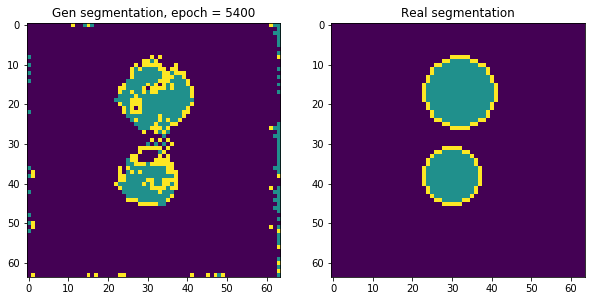

epoch - 5400, loss - 0.0137327425182
epoch - 5401, loss - 0.0138221587986
epoch - 5402, loss - 0.0138171054423
epoch - 5403, loss - 0.0139824915677
epoch - 5404, loss - 0.0147547889501
epoch - 5405, loss - 0.0163416489959
epoch - 5406, loss - 0.0190423466265
epoch - 5407, loss - 0.0234584957361
epoch - 5408, loss - 0.0311154183
epoch - 5409, loss - 0.0443528406322
epoch - 5410, loss - 0.0664023905993
epoch - 5411, loss - 0.103180706501
epoch - 5412, loss - 0.155404359102
epoch - 5413, loss - 0.23448126018
epoch - 5414, loss - 0.300789296627
epoch - 5415, loss - 0.350260078907
epoch - 5416, loss - 0.282372862101
epoch - 5417, loss - 0.19833189249
epoch - 5418, loss - 0.13399836421
epoch - 5419, loss - 0.157786160707
epoch - 5420, loss - 0.205610111356
epoch - 5421, loss - 0.178783103824
epoch - 5422, loss - 0.0907022878528
epoch - 5423, loss - 0.0927805453539
epoch - 5424, loss - 0.152174592018
epoch - 5425, loss - 0.105099253356
epoch - 5426, loss - 0.0687716454268
epoch - 5427, loss -

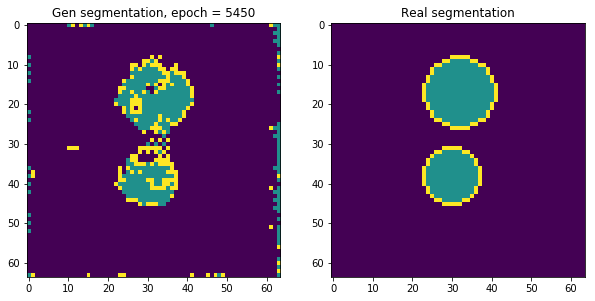

epoch - 5450, loss - 0.0256145298481
epoch - 5451, loss - 0.0243820138276
epoch - 5452, loss - 0.0223883334547
epoch - 5453, loss - 0.0226290822029
epoch - 5454, loss - 0.0218479111791
epoch - 5455, loss - 0.0211915001273
epoch - 5456, loss - 0.0204156078398
epoch - 5457, loss - 0.0196537412703
epoch - 5458, loss - 0.0198306627572
epoch - 5459, loss - 0.0189461931586
epoch - 5460, loss - 0.0181817412376
epoch - 5461, loss - 0.0182318817824
epoch - 5462, loss - 0.0179677829146
epoch - 5463, loss - 0.0177008025348
epoch - 5464, loss - 0.0175781548023
epoch - 5465, loss - 0.0174890141934
epoch - 5466, loss - 0.0174705423415
epoch - 5467, loss - 0.0171686299145
epoch - 5468, loss - 0.0168240629137
epoch - 5469, loss - 0.0167661309242
epoch - 5470, loss - 0.016414962709
epoch - 5471, loss - 0.0161989144981
epoch - 5472, loss - 0.0160018354654
epoch - 5473, loss - 0.0156861394644
epoch - 5474, loss - 0.0154314544052
epoch - 5475, loss - 0.0152582600713
epoch - 5476, loss - 0.0151046896353
ep

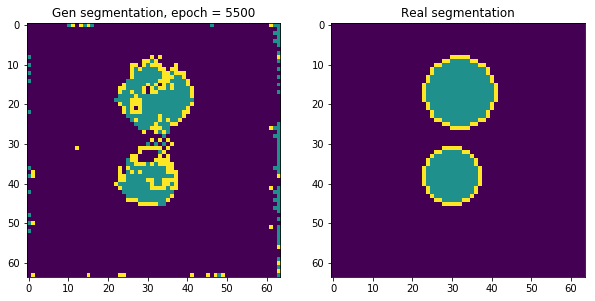

epoch - 5500, loss - 0.0133955851197
epoch - 5501, loss - 0.0133960861713
epoch - 5502, loss - 0.0133979357779
epoch - 5503, loss - 0.0133673241362
epoch - 5504, loss - 0.0133025841787
epoch - 5505, loss - 0.0132386572659
epoch - 5506, loss - 0.0131455101073
epoch - 5507, loss - 0.0130680967122
epoch - 5508, loss - 0.0130378920585
epoch - 5509, loss - 0.0130713656545
epoch - 5510, loss - 0.0131328590214
epoch - 5511, loss - 0.0132281649858
epoch - 5512, loss - 0.0133028663695
epoch - 5513, loss - 0.0134584791958
epoch - 5514, loss - 0.013404995203
epoch - 5515, loss - 0.0133377593011
epoch - 5516, loss - 0.0132697466761
epoch - 5517, loss - 0.0132539225742
epoch - 5518, loss - 0.0133504159749
epoch - 5519, loss - 0.014264812693
epoch - 5520, loss - 0.0147416358814
epoch - 5521, loss - 0.0153332576156
epoch - 5522, loss - 0.0158710442483
epoch - 5523, loss - 0.0162280444056
epoch - 5524, loss - 0.0166102908552
epoch - 5525, loss - 0.0165147520602
epoch - 5526, loss - 0.0158917568624
epo

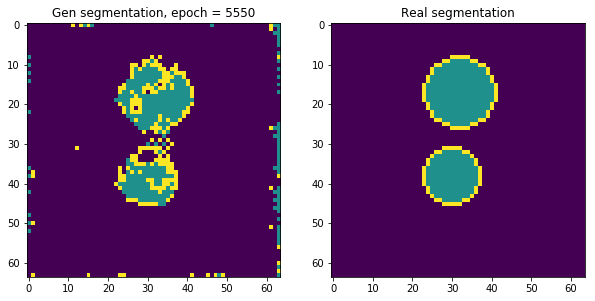

epoch - 5550, loss - 0.0121147679165
epoch - 5551, loss - 0.0121271703392
epoch - 5552, loss - 0.0121981650591
epoch - 5553, loss - 0.0124398041517
epoch - 5554, loss - 0.0129429344088
epoch - 5555, loss - 0.0136528396979
epoch - 5556, loss - 0.0144633455202
epoch - 5557, loss - 0.0155222918838
epoch - 5558, loss - 0.0164641588926
epoch - 5559, loss - 0.0172358117998
epoch - 5560, loss - 0.0174199510366
epoch - 5561, loss - 0.0166608188301
epoch - 5562, loss - 0.0159141495824
epoch - 5563, loss - 0.0158028043807
epoch - 5564, loss - 0.0162381902337
epoch - 5565, loss - 0.0166006349027
epoch - 5566, loss - 0.0162525810301
epoch - 5567, loss - 0.0153641002253
epoch - 5568, loss - 0.0146950017661
epoch - 5569, loss - 0.0154659226537
epoch - 5570, loss - 0.0177654512227
epoch - 5571, loss - 0.0194596257061
epoch - 5572, loss - 0.0220339428633
epoch - 5573, loss - 0.0227233786136
epoch - 5574, loss - 0.023546371609
epoch - 5575, loss - 0.0241767819971
epoch - 5576, loss - 0.0263176113367
ep

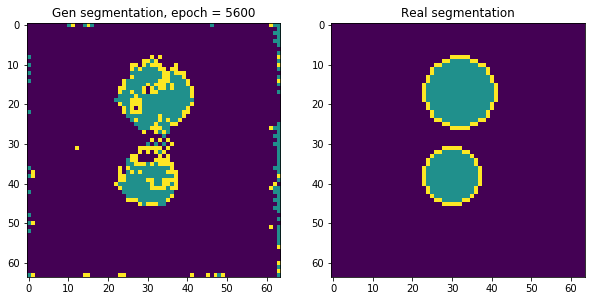

epoch - 5600, loss - 0.018742505461
epoch - 5601, loss - 0.0184556543827
epoch - 5602, loss - 0.0184528268874
epoch - 5603, loss - 0.0189344212413
epoch - 5604, loss - 0.0177640821785
epoch - 5605, loss - 0.0149022433907
epoch - 5606, loss - 0.0133979897946
epoch - 5607, loss - 0.0137013774365
epoch - 5608, loss - 0.0139931235462
epoch - 5609, loss - 0.013841368258
epoch - 5610, loss - 0.0141321513802
epoch - 5611, loss - 0.0144929829985
epoch - 5612, loss - 0.0141285760328
epoch - 5613, loss - 0.0132586956024
epoch - 5614, loss - 0.0125649990514
epoch - 5615, loss - 0.0121359508485
epoch - 5616, loss - 0.0117764230818
epoch - 5617, loss - 0.01162035577
epoch - 5618, loss - 0.0117907384411
epoch - 5619, loss - 0.0119981206954
epoch - 5620, loss - 0.0119489524513
epoch - 5621, loss - 0.0119260596111
epoch - 5622, loss - 0.01193435397
epoch - 5623, loss - 0.0118299499154
epoch - 5624, loss - 0.011543687433
epoch - 5625, loss - 0.0113304397091
epoch - 5626, loss - 0.0112451780587
epoch - 

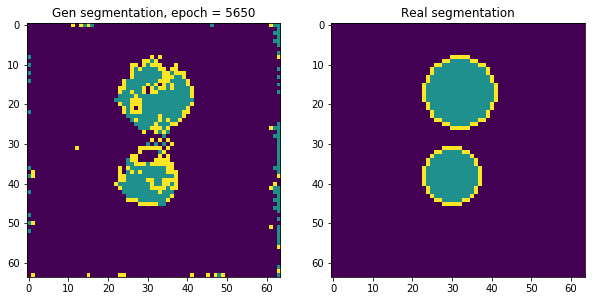

epoch - 5650, loss - 0.0297341607511
epoch - 5651, loss - 0.0408126227558
epoch - 5652, loss - 0.0593254715204
epoch - 5653, loss - 0.0869031995535
epoch - 5654, loss - 0.132191061974
epoch - 5655, loss - 0.169065833092
epoch - 5656, loss - 0.189320042729
epoch - 5657, loss - 0.171125039458
epoch - 5658, loss - 0.13558126986
epoch - 5659, loss - 0.100259199739
epoch - 5660, loss - 0.0847263485193
epoch - 5661, loss - 0.0808654725552
epoch - 5662, loss - 0.0665604546666
epoch - 5663, loss - 0.0793810635805
epoch - 5664, loss - 0.0797349438071
epoch - 5665, loss - 0.0509238243103
epoch - 5666, loss - 0.0497944839299
epoch - 5667, loss - 0.0526014938951
epoch - 5668, loss - 0.0444974675775
epoch - 5669, loss - 0.0469392724335
epoch - 5670, loss - 0.0451525263488
epoch - 5671, loss - 0.0378505960107
epoch - 5672, loss - 0.0324307046831
epoch - 5673, loss - 0.0356102883816
epoch - 5674, loss - 0.031706687063
epoch - 5675, loss - 0.0305788964033
epoch - 5676, loss - 0.0308577753603
epoch - 5

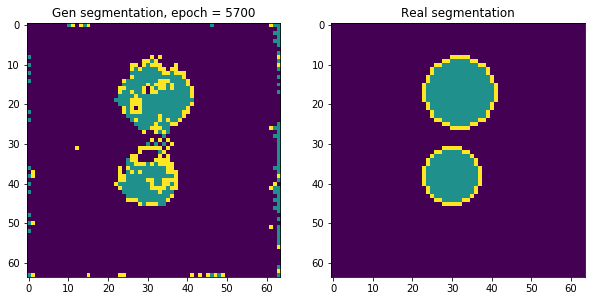

epoch - 5700, loss - 0.0128063987941
epoch - 5701, loss - 0.0126169268042
epoch - 5702, loss - 0.0123915690929
epoch - 5703, loss - 0.0122766559944
epoch - 5704, loss - 0.0120725780725
epoch - 5705, loss - 0.0118495486677
epoch - 5706, loss - 0.011690499261
epoch - 5707, loss - 0.0116374269128
epoch - 5708, loss - 0.0114944465458
epoch - 5709, loss - 0.0113701336086
epoch - 5710, loss - 0.011340117082
epoch - 5711, loss - 0.0112313805148
epoch - 5712, loss - 0.0111092841253
epoch - 5713, loss - 0.0110369324684
epoch - 5714, loss - 0.0109367072582
epoch - 5715, loss - 0.0108694396913
epoch - 5716, loss - 0.0107919275761
epoch - 5717, loss - 0.0107285566628
epoch - 5718, loss - 0.0106572266668
epoch - 5719, loss - 0.0105969384313
epoch - 5720, loss - 0.010556967929
epoch - 5721, loss - 0.0105085317045
epoch - 5722, loss - 0.0104865394533
epoch - 5723, loss - 0.0104754511267
epoch - 5724, loss - 0.0104512479156
epoch - 5725, loss - 0.0104071423411
epoch - 5726, loss - 0.0103718573228
epoc

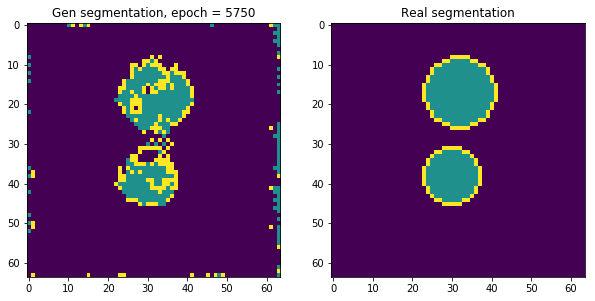

epoch - 5750, loss - 0.0172199644148
epoch - 5751, loss - 0.0205336548388
epoch - 5752, loss - 0.0255658049136
epoch - 5753, loss - 0.033452808857
epoch - 5754, loss - 0.0458657667041
epoch - 5755, loss - 0.0663871541619
epoch - 5756, loss - 0.0952540934086
epoch - 5757, loss - 0.137754946947
epoch - 5758, loss - 0.178023084998
epoch - 5759, loss - 0.209375694394
epoch - 5760, loss - 0.183505997062
epoch - 5761, loss - 0.120315492153
epoch - 5762, loss - 0.0536208823323
epoch - 5763, loss - 0.036268722266
epoch - 5764, loss - 0.0592586658895
epoch - 5765, loss - 0.0804048627615
epoch - 5766, loss - 0.0726012885571
epoch - 5767, loss - 0.0443339198828
epoch - 5768, loss - 0.0289665609598
epoch - 5769, loss - 0.0378170721233
epoch - 5770, loss - 0.0512587875128
epoch - 5771, loss - 0.0443494617939
epoch - 5772, loss - 0.0244710817933
epoch - 5773, loss - 0.0234176516533
epoch - 5774, loss - 0.0361510254443
epoch - 5775, loss - 0.0331707000732
epoch - 5776, loss - 0.0224394500256
epoch - 

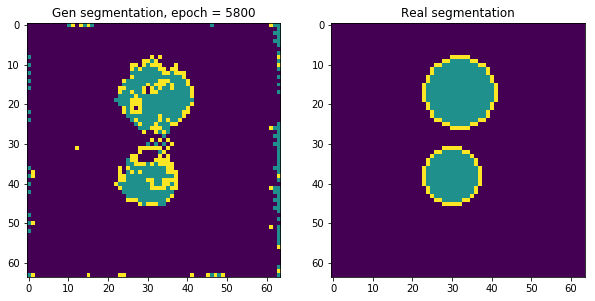

epoch - 5800, loss - 0.0116687789559
epoch - 5801, loss - 0.0116438996047
epoch - 5802, loss - 0.0114840241149
epoch - 5803, loss - 0.0110945869237
epoch - 5804, loss - 0.0109061617404
epoch - 5805, loss - 0.0110195856541
epoch - 5806, loss - 0.010926021263
epoch - 5807, loss - 0.0106767565012
epoch - 5808, loss - 0.010610726662
epoch - 5809, loss - 0.0106297023594
epoch - 5810, loss - 0.0105540379882
epoch - 5811, loss - 0.0104357283562
epoch - 5812, loss - 0.0104374717921
epoch - 5813, loss - 0.0104378629476
epoch - 5814, loss - 0.0103246727958
epoch - 5815, loss - 0.0102122351527
epoch - 5816, loss - 0.0101495301351
epoch - 5817, loss - 0.0101001504809
epoch - 5818, loss - 0.0100475912914
epoch - 5819, loss - 0.0100152809173
epoch - 5820, loss - 0.0100074922666
epoch - 5821, loss - 0.0100255282596
epoch - 5822, loss - 0.0100423656404
epoch - 5823, loss - 0.0101069286466
epoch - 5824, loss - 0.010296549648
epoch - 5825, loss - 0.0106180701405
epoch - 5826, loss - 0.0110892411321
epoc

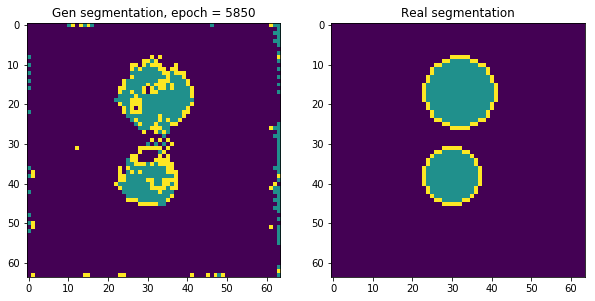

epoch - 5850, loss - 0.0101536717266
epoch - 5851, loss - 0.00995736941695
epoch - 5852, loss - 0.00993532408029
epoch - 5853, loss - 0.00985821988434
epoch - 5854, loss - 0.00990685634315
epoch - 5855, loss - 0.0100433751941
epoch - 5856, loss - 0.0100859161466
epoch - 5857, loss - 0.010041740723
epoch - 5858, loss - 0.0098237041384
epoch - 5859, loss - 0.00960215646774
epoch - 5860, loss - 0.00945470575243
epoch - 5861, loss - 0.00939160212874
epoch - 5862, loss - 0.00939747132361
epoch - 5863, loss - 0.00945114530623
epoch - 5864, loss - 0.00950228702277
epoch - 5865, loss - 0.00956240296364
epoch - 5866, loss - 0.0096085043624
epoch - 5867, loss - 0.00972270406783
epoch - 5868, loss - 0.00982440076768
epoch - 5869, loss - 0.0100416447967
epoch - 5870, loss - 0.0103367147967
epoch - 5871, loss - 0.0107467453927
epoch - 5872, loss - 0.0112642049789
epoch - 5873, loss - 0.0118801286444
epoch - 5874, loss - 0.0124934334308
epoch - 5875, loss - 0.0130917802453
epoch - 5876, loss - 0.013

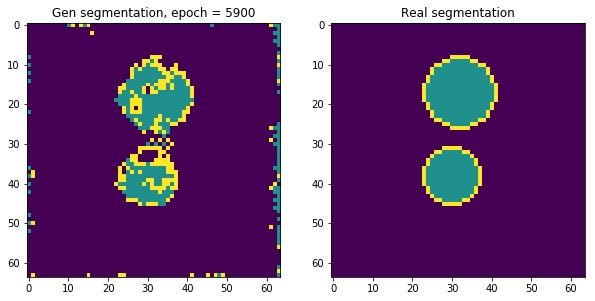

epoch - 5900, loss - 0.227649837732
epoch - 5901, loss - 0.132407322526
epoch - 5902, loss - 0.0564090386033
epoch - 5903, loss - 0.0767330229282
epoch - 5904, loss - 0.128622964025
epoch - 5905, loss - 0.111160099506
epoch - 5906, loss - 0.0650229975581
epoch - 5907, loss - 0.0538632571697
epoch - 5908, loss - 0.0682463422418
epoch - 5909, loss - 0.0713172033429
epoch - 5910, loss - 0.0598606653512
epoch - 5911, loss - 0.0396418869495
epoch - 5912, loss - 0.041316203773
epoch - 5913, loss - 0.0537639074028
epoch - 5914, loss - 0.0421802215278
epoch - 5915, loss - 0.0291305407882
epoch - 5916, loss - 0.0354271195829
epoch - 5917, loss - 0.0379710644484
epoch - 5918, loss - 0.0310558527708
epoch - 5919, loss - 0.0271176584065
epoch - 5920, loss - 0.0251143239439
epoch - 5921, loss - 0.0272583253682
epoch - 5922, loss - 0.0268561430275
epoch - 5923, loss - 0.0207726918161
epoch - 5924, loss - 0.0201004557312
epoch - 5925, loss - 0.0223702341318
epoch - 5926, loss - 0.0208265949041
epoch 

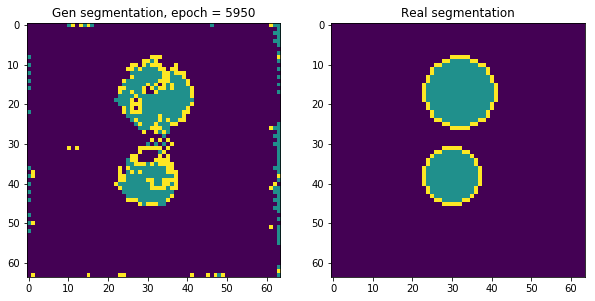

epoch - 5950, loss - 0.0112285800278
epoch - 5951, loss - 0.0110026560724
epoch - 5952, loss - 0.0108009800315
epoch - 5953, loss - 0.0107606593519
epoch - 5954, loss - 0.0108430413529
epoch - 5955, loss - 0.0108596766368
epoch - 5956, loss - 0.0106603130698
epoch - 5957, loss - 0.0105033097789
epoch - 5958, loss - 0.0104437489063
epoch - 5959, loss - 0.0104183424264
epoch - 5960, loss - 0.0103783803061
epoch - 5961, loss - 0.0110147967935
epoch - 5962, loss - 0.0116997547448
epoch - 5963, loss - 0.0113157620654
epoch - 5964, loss - 0.0109894815832
epoch - 5965, loss - 0.0110259987414
epoch - 5966, loss - 0.0110028516501
epoch - 5967, loss - 0.010900920257
epoch - 5968, loss - 0.0107754208148
epoch - 5969, loss - 0.0106637626886
epoch - 5970, loss - 0.0106348628178
epoch - 5971, loss - 0.0105684446171
epoch - 5972, loss - 0.0104629127309
epoch - 5973, loss - 0.0103293117136
epoch - 5974, loss - 0.0102067813277
epoch - 5975, loss - 0.0100767239928
epoch - 5976, loss - 0.00995250791311
e

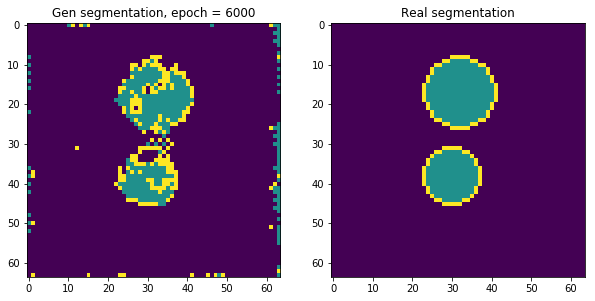

epoch - 6000, loss - 0.0113191716373
epoch - 6001, loss - 0.0112048676237
epoch - 6002, loss - 0.0113309510052
epoch - 6003, loss - 0.0113072898239
epoch - 6004, loss - 0.0112077789381
epoch - 6005, loss - 0.0107983760536
epoch - 6006, loss - 0.0105588566512
epoch - 6007, loss - 0.0106788221747
epoch - 6008, loss - 0.010971349664
epoch - 6009, loss - 0.0111788697541
epoch - 6010, loss - 0.0109685799107
epoch - 6011, loss - 0.0105498023331
epoch - 6012, loss - 0.0100127933547
epoch - 6013, loss - 0.00978706870228
epoch - 6014, loss - 0.00995659083128
epoch - 6015, loss - 0.0104306843132
epoch - 6016, loss - 0.0110340416431
epoch - 6017, loss - 0.0116637349129
epoch - 6018, loss - 0.0122099500149
epoch - 6019, loss - 0.0128972539678
epoch - 6020, loss - 0.0134713482112
epoch - 6021, loss - 0.0141980284825
epoch - 6022, loss - 0.0147102707997
epoch - 6023, loss - 0.015348826535
epoch - 6024, loss - 0.0154158510268
epoch - 6025, loss - 0.0157614722848
epoch - 6026, loss - 0.0162020474672
e

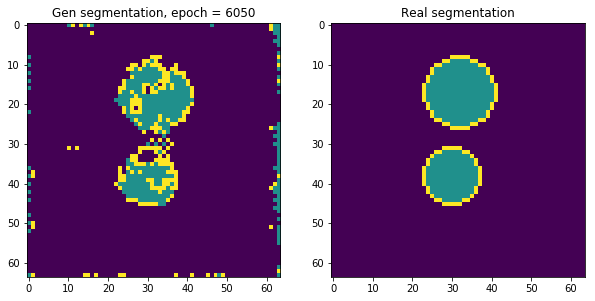

epoch - 6050, loss - 0.067122220993
epoch - 6051, loss - 0.0539938732982
epoch - 6052, loss - 0.0380985215306
epoch - 6053, loss - 0.0234790034592
epoch - 6054, loss - 0.0154237840325
epoch - 6055, loss - 0.0147060872987
epoch - 6056, loss - 0.0194470938295
epoch - 6057, loss - 0.025751978159
epoch - 6058, loss - 0.0284517034888
epoch - 6059, loss - 0.0262652337551
epoch - 6060, loss - 0.0206795968115
epoch - 6061, loss - 0.0153590384871
epoch - 6062, loss - 0.0122231375426
epoch - 6063, loss - 0.0118430135772
epoch - 6064, loss - 0.0140836145729
epoch - 6065, loss - 0.0167972501367
epoch - 6066, loss - 0.0176771096885
epoch - 6067, loss - 0.0162747185677
epoch - 6068, loss - 0.0138769373298
epoch - 6069, loss - 0.0117206741124
epoch - 6070, loss - 0.0105229355395
epoch - 6071, loss - 0.010516051203
epoch - 6072, loss - 0.0113426446915
epoch - 6073, loss - 0.0124960951507
epoch - 6074, loss - 0.012987062335
epoch - 6075, loss - 0.0126306833699
epoch - 6076, loss - 0.0117193982005
epoch

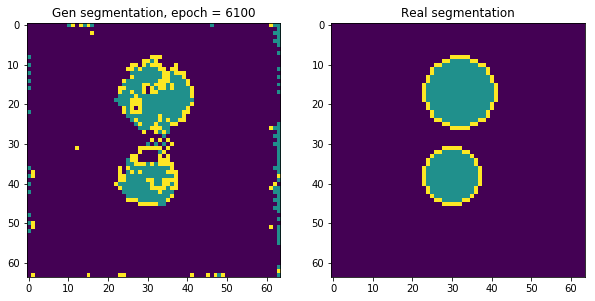

epoch - 6100, loss - 0.011237279512
epoch - 6101, loss - 0.0112532712519
epoch - 6102, loss - 0.0110886562616
epoch - 6103, loss - 0.0108774397522
epoch - 6104, loss - 0.0106126815081
epoch - 6105, loss - 0.0104458834976
epoch - 6106, loss - 0.0103500504047
epoch - 6107, loss - 0.0102597847581
epoch - 6108, loss - 0.0103093190119
epoch - 6109, loss - 0.0103433970362
epoch - 6110, loss - 0.0104601364583
epoch - 6111, loss - 0.0106441006064
epoch - 6112, loss - 0.0108405072242
epoch - 6113, loss - 0.0109824528918
epoch - 6114, loss - 0.0112551450729
epoch - 6115, loss - 0.0116869788617
epoch - 6116, loss - 0.0124604804441
epoch - 6117, loss - 0.0137194721028
epoch - 6118, loss - 0.0156783070415
epoch - 6119, loss - 0.0187662914395
epoch - 6120, loss - 0.023212376982
epoch - 6121, loss - 0.0300819594413
epoch - 6122, loss - 0.0413958579302
epoch - 6123, loss - 0.0584707967937
epoch - 6124, loss - 0.0743512064219
epoch - 6125, loss - 0.0967048481107
epoch - 6126, loss - 0.115568734705
epoc

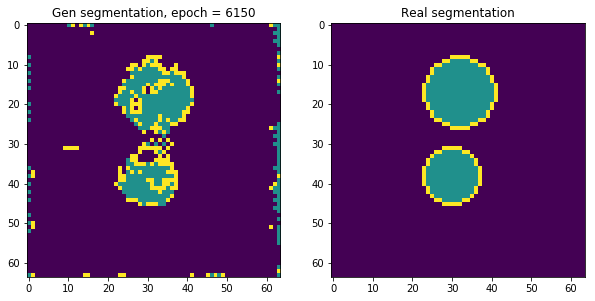

epoch - 6150, loss - 0.0274836551398
epoch - 6151, loss - 0.0270960219204
epoch - 6152, loss - 0.0262781064957
epoch - 6153, loss - 0.0239378903061
epoch - 6154, loss - 0.0226864703
epoch - 6155, loss - 0.0212771538645
epoch - 6156, loss - 0.0192973148078
epoch - 6157, loss - 0.0191211774945
epoch - 6158, loss - 0.0185553207994
epoch - 6159, loss - 0.017224593088
epoch - 6160, loss - 0.0169698204845
epoch - 6161, loss - 0.0161553360522
epoch - 6162, loss - 0.0153952324763
epoch - 6163, loss - 0.0150137161836
epoch - 6164, loss - 0.0144523959607
epoch - 6165, loss - 0.0139068719
epoch - 6166, loss - 0.0136201381683
epoch - 6167, loss - 0.013139590621
epoch - 6168, loss - 0.0126658100635
epoch - 6169, loss - 0.0122739709914
epoch - 6170, loss - 0.0119700673968
epoch - 6171, loss - 0.0116884475574
epoch - 6172, loss - 0.0114412615076
epoch - 6173, loss - 0.0112649286166
epoch - 6174, loss - 0.0111492536962
epoch - 6175, loss - 0.0108622675762
epoch - 6176, loss - 0.0107047734782
epoch - 6

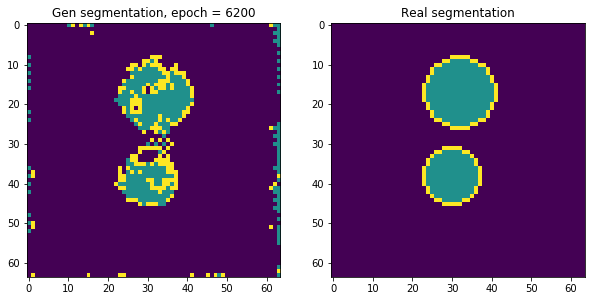

epoch - 6200, loss - 0.00997636560351
epoch - 6201, loss - 0.0100419558585
epoch - 6202, loss - 0.010001571849
epoch - 6203, loss - 0.00996797904372
epoch - 6204, loss - 0.00994819775224
epoch - 6205, loss - 0.0101022105664
epoch - 6206, loss - 0.0106026558205
epoch - 6207, loss - 0.0115700922906
epoch - 6208, loss - 0.0131599865854
epoch - 6209, loss - 0.0155482981354
epoch - 6210, loss - 0.0191367287189
epoch - 6211, loss - 0.0241631958634
epoch - 6212, loss - 0.0315495878458
epoch - 6213, loss - 0.0411981455982
epoch - 6214, loss - 0.054867990315
epoch - 6215, loss - 0.0705358013511
epoch - 6216, loss - 0.091137945652
epoch - 6217, loss - 0.107841059566
epoch - 6218, loss - 0.124345906079
epoch - 6219, loss - 0.125459194183
epoch - 6220, loss - 0.113269791007
epoch - 6221, loss - 0.0843140110373
epoch - 6222, loss - 0.0421324335039
epoch - 6223, loss - 0.0280272904783
epoch - 6224, loss - 0.0589509047568
epoch - 6225, loss - 0.0722707435489
epoch - 6226, loss - 0.053902734071
epoch 

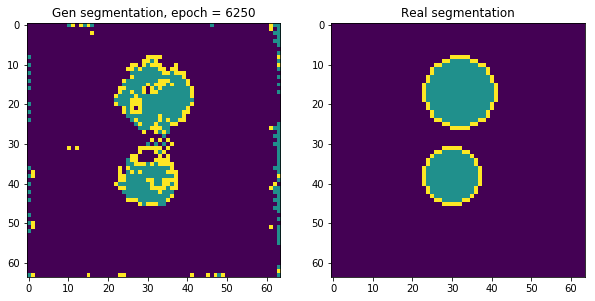

epoch - 6250, loss - 0.0123739177361
epoch - 6251, loss - 0.0113283973187
epoch - 6252, loss - 0.0106689501554
epoch - 6253, loss - 0.0102904252708
epoch - 6254, loss - 0.0102360099554
epoch - 6255, loss - 0.0104355504736
epoch - 6256, loss - 0.0103315487504
epoch - 6257, loss - 0.0101734213531
epoch - 6258, loss - 0.00993377901614
epoch - 6259, loss - 0.00941262952983
epoch - 6260, loss - 0.00915823038667
epoch - 6261, loss - 0.00922015868127
epoch - 6262, loss - 0.00916611496359
epoch - 6263, loss - 0.00914144795388
epoch - 6264, loss - 0.0091942884028
epoch - 6265, loss - 0.00908777862787
epoch - 6266, loss - 0.00882293935865
epoch - 6267, loss - 0.00867277663201
epoch - 6268, loss - 0.00855929031968
epoch - 6269, loss - 0.00845496263355
epoch - 6270, loss - 0.00842448696494
epoch - 6271, loss - 0.00847089290619
epoch - 6272, loss - 0.00846979860216
epoch - 6273, loss - 0.00839168019593
epoch - 6274, loss - 0.00835472624749
epoch - 6275, loss - 0.00832685176283
epoch - 6276, loss - 

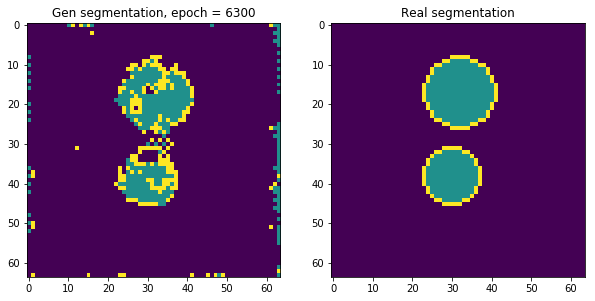

epoch - 6300, loss - 0.00865872949362
epoch - 6301, loss - 0.00874825846404
epoch - 6302, loss - 0.00881424266845
epoch - 6303, loss - 0.00896172318608
epoch - 6304, loss - 0.00925950706005
epoch - 6305, loss - 0.00974722951651
epoch - 6306, loss - 0.0104568349198
epoch - 6307, loss - 0.0114425038919
epoch - 6308, loss - 0.0126143079251
epoch - 6309, loss - 0.014020383358
epoch - 6310, loss - 0.0155780892819
epoch - 6311, loss - 0.0174206141382
epoch - 6312, loss - 0.0201704613864
epoch - 6313, loss - 0.0243167486042
epoch - 6314, loss - 0.0316735394299
epoch - 6315, loss - 0.0427893847227
epoch - 6316, loss - 0.0595840141177
epoch - 6317, loss - 0.0803326293826
epoch - 6318, loss - 0.106810115278
epoch - 6319, loss - 0.127009958029
epoch - 6320, loss - 0.147486791015
epoch - 6321, loss - 0.13082395494
epoch - 6322, loss - 0.103978551924
epoch - 6323, loss - 0.0729627087712
epoch - 6324, loss - 0.0702689662576
epoch - 6325, loss - 0.0509837567806
epoch - 6326, loss - 0.0750192776322
ep

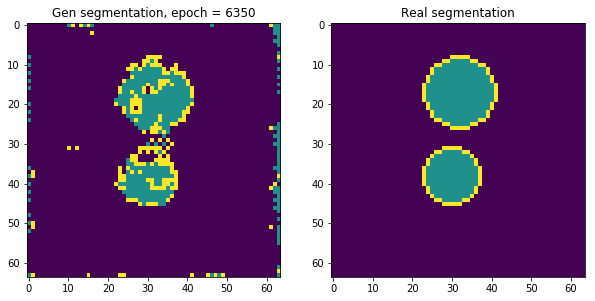

epoch - 6350, loss - 0.0185513366014
epoch - 6351, loss - 0.017035484314
epoch - 6352, loss - 0.0155034977943
epoch - 6353, loss - 0.0153419012204
epoch - 6354, loss - 0.0144745809957
epoch - 6355, loss - 0.0130335949361
epoch - 6356, loss - 0.0137362014502
epoch - 6357, loss - 0.0130259599537
epoch - 6358, loss - 0.0122788678855
epoch - 6359, loss - 0.0124830761924
epoch - 6360, loss - 0.0116089042276
epoch - 6361, loss - 0.011148519814
epoch - 6362, loss - 0.0109904166311
epoch - 6363, loss - 0.0107426121831
epoch - 6364, loss - 0.0104035194963
epoch - 6365, loss - 0.0106479097158
epoch - 6366, loss - 0.0104457940906
epoch - 6367, loss - 0.0100926086307
epoch - 6368, loss - 0.00999331194907
epoch - 6369, loss - 0.00976161379367
epoch - 6370, loss - 0.00991771928966
epoch - 6371, loss - 0.0100810099393
epoch - 6372, loss - 0.0101316142827
epoch - 6373, loss - 0.00993116945028
epoch - 6374, loss - 0.00970316119492
epoch - 6375, loss - 0.00953716039658
epoch - 6376, loss - 0.00931938085

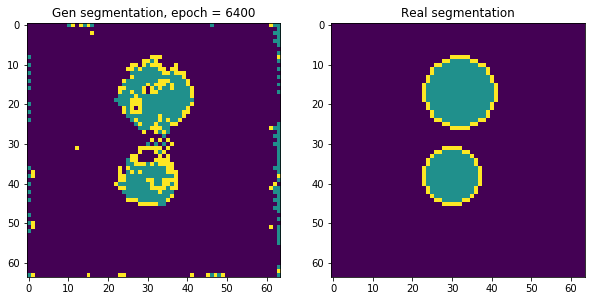

epoch - 6400, loss - 0.00767983775586
epoch - 6401, loss - 0.00772101152688
epoch - 6402, loss - 0.00780959520489
epoch - 6403, loss - 0.00794211681932
epoch - 6404, loss - 0.00815471541137
epoch - 6405, loss - 0.00847424566746
epoch - 6406, loss - 0.00893748551607
epoch - 6407, loss - 0.00957316718996
epoch - 6408, loss - 0.0104306768626
epoch - 6409, loss - 0.0116702187806
epoch - 6410, loss - 0.0134328529239
epoch - 6411, loss - 0.0161857772619
epoch - 6412, loss - 0.020312929526
epoch - 6413, loss - 0.0270644072443
epoch - 6414, loss - 0.0369585081935
epoch - 6415, loss - 0.0524754971266
epoch - 6416, loss - 0.0721496343613
epoch - 6417, loss - 0.0990095585585
epoch - 6418, loss - 0.121404804289
epoch - 6419, loss - 0.138232931495
epoch - 6420, loss - 0.12318828702
epoch - 6421, loss - 0.0880160331726
epoch - 6422, loss - 0.0426550842822
epoch - 6423, loss - 0.0212587378919
epoch - 6424, loss - 0.0281202625483
epoch - 6425, loss - 0.0474020764232
epoch - 6426, loss - 0.052633289247

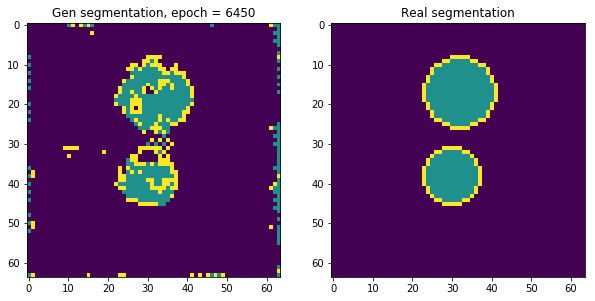

epoch - 6450, loss - 0.0102510061115
epoch - 6451, loss - 0.0102622499689
epoch - 6452, loss - 0.0102524487302
epoch - 6453, loss - 0.0102721694857
epoch - 6454, loss - 0.0102844983339
epoch - 6455, loss - 0.00979320611805
epoch - 6456, loss - 0.0090364087373
epoch - 6457, loss - 0.0088071282953
epoch - 6458, loss - 0.009711118415
epoch - 6459, loss - 0.0101073607802
epoch - 6460, loss - 0.0098225902766
epoch - 6461, loss - 0.00969655811787
epoch - 6462, loss - 0.00941648613662
epoch - 6463, loss - 0.0092994440347
epoch - 6464, loss - 0.00890876352787
epoch - 6465, loss - 0.00893213227391
epoch - 6466, loss - 0.00883625727147
epoch - 6467, loss - 0.00863667391241
epoch - 6468, loss - 0.00834934040904
epoch - 6469, loss - 0.00825104210526
epoch - 6470, loss - 0.00821276847273
epoch - 6471, loss - 0.00810783356428
epoch - 6472, loss - 0.00796274002641
epoch - 6473, loss - 0.00787829328328
epoch - 6474, loss - 0.00782746355981
epoch - 6475, loss - 0.00769285205752
epoch - 6476, loss - 0.0

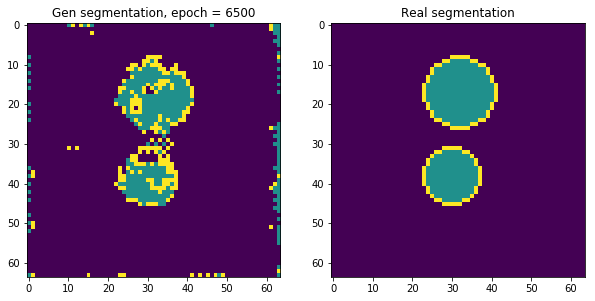

epoch - 6500, loss - 0.0101294089109
epoch - 6501, loss - 0.0103532616049
epoch - 6502, loss - 0.0101518295705
epoch - 6503, loss - 0.00941864866763
epoch - 6504, loss - 0.00873234309256
epoch - 6505, loss - 0.008405437693
epoch - 6506, loss - 0.00868227239698
epoch - 6507, loss - 0.0094499187544
epoch - 6508, loss - 0.0104370582849
epoch - 6509, loss - 0.0112535916269
epoch - 6510, loss - 0.0118479263037
epoch - 6511, loss - 0.0120039889589
epoch - 6512, loss - 0.01163195353
epoch - 6513, loss - 0.0110988151282
epoch - 6514, loss - 0.0113349277526
epoch - 6515, loss - 0.0119150141254
epoch - 6516, loss - 0.0129490718246
epoch - 6517, loss - 0.0147781670094
epoch - 6518, loss - 0.0160024315119
epoch - 6519, loss - 0.0166858378798
epoch - 6520, loss - 0.0171904154122
epoch - 6521, loss - 0.018806533888
epoch - 6522, loss - 0.0223845075816
epoch - 6523, loss - 0.0315146930516
epoch - 6524, loss - 0.0399373322725
epoch - 6525, loss - 0.0497956462204
epoch - 6526, loss - 0.0558925382793
ep

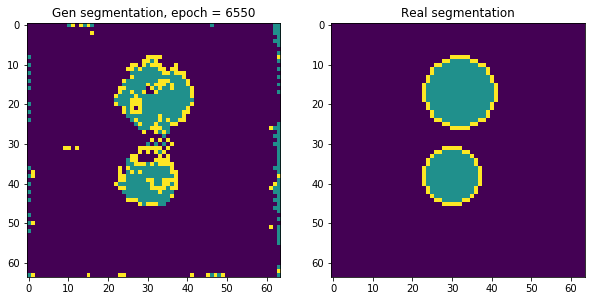

epoch - 6550, loss - 0.0127867925912
epoch - 6551, loss - 0.0117210205644
epoch - 6552, loss - 0.0104976436123
epoch - 6553, loss - 0.010429058224
epoch - 6554, loss - 0.0109863514081
epoch - 6555, loss - 0.0108923837543
epoch - 6556, loss - 0.0106669031084
epoch - 6557, loss - 0.0109103629366
epoch - 6558, loss - 0.0106564871967
epoch - 6559, loss - 0.00963331200182
epoch - 6560, loss - 0.00891089532524
epoch - 6561, loss - 0.00893704220653
epoch - 6562, loss - 0.00873851869255
epoch - 6563, loss - 0.0082403132692
epoch - 6564, loss - 0.00822947919369
epoch - 6565, loss - 0.00851683504879
epoch - 6566, loss - 0.00859964359552
epoch - 6567, loss - 0.00834788847715
epoch - 6568, loss - 0.00831247400492
epoch - 6569, loss - 0.00843156501651
epoch - 6570, loss - 0.00832237862051
epoch - 6571, loss - 0.00802634749562
epoch - 6572, loss - 0.00784390792251
epoch - 6573, loss - 0.00781414005905
epoch - 6574, loss - 0.00770960468799
epoch - 6575, loss - 0.00751207768917
epoch - 6576, loss - 0.

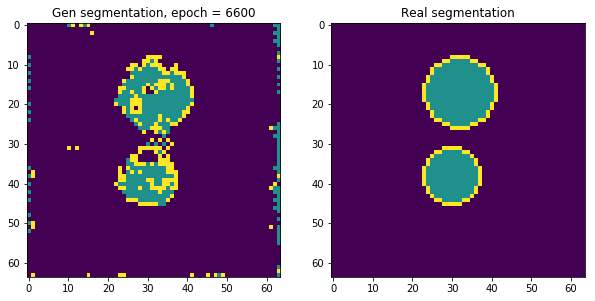

epoch - 6600, loss - 0.0270527228713
epoch - 6601, loss - 0.0398868694901
epoch - 6602, loss - 0.0589217580855
epoch - 6603, loss - 0.0903535708785
epoch - 6604, loss - 0.129689604044
epoch - 6605, loss - 0.182570651174
epoch - 6606, loss - 0.216067776084
epoch - 6607, loss - 0.220655933022
epoch - 6608, loss - 0.1448661834
epoch - 6609, loss - 0.0524679347873
epoch - 6610, loss - 0.0211944263428
epoch - 6611, loss - 0.0686092376709
epoch - 6612, loss - 0.109445899725
epoch - 6613, loss - 0.0778509005904
epoch - 6614, loss - 0.0288906749338
epoch - 6615, loss - 0.029853861779
epoch - 6616, loss - 0.0623188093305
epoch - 6617, loss - 0.062531940639
epoch - 6618, loss - 0.0313183292747
epoch - 6619, loss - 0.0244698822498
epoch - 6620, loss - 0.0426184795797
epoch - 6621, loss - 0.045244961977
epoch - 6622, loss - 0.0286159198731
epoch - 6623, loss - 0.0211817026138
epoch - 6624, loss - 0.0294229313731
epoch - 6625, loss - 0.0332032814622
epoch - 6626, loss - 0.0252334084362
epoch - 6627

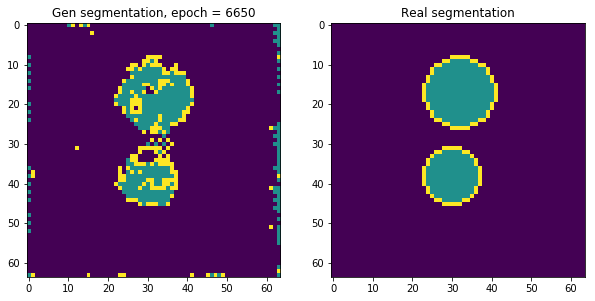

epoch - 6650, loss - 0.0239309426397
epoch - 6651, loss - 0.0224510729313
epoch - 6652, loss - 0.0217696484178
epoch - 6653, loss - 0.020176788792
epoch - 6654, loss - 0.0180759653449
epoch - 6655, loss - 0.0173831619322
epoch - 6656, loss - 0.0161888301373
epoch - 6657, loss - 0.0157954618335
epoch - 6658, loss - 0.0153496358544
epoch - 6659, loss - 0.0139465220273
epoch - 6660, loss - 0.0132721327245
epoch - 6661, loss - 0.0132188191637
epoch - 6662, loss - 0.0131224850193
epoch - 6663, loss - 0.0122674480081
epoch - 6664, loss - 0.0118748787791
epoch - 6665, loss - 0.012203800492
epoch - 6666, loss - 0.0113584222272
epoch - 6667, loss - 0.0110079776496
epoch - 6668, loss - 0.0108653828502
epoch - 6669, loss - 0.0104615595192
epoch - 6670, loss - 0.0101682478562
epoch - 6671, loss - 0.0100043416023
epoch - 6672, loss - 0.0098427021876
epoch - 6673, loss - 0.00958074536175
epoch - 6674, loss - 0.00932452548295
epoch - 6675, loss - 0.00900497939438
epoch - 6676, loss - 0.00892150308937

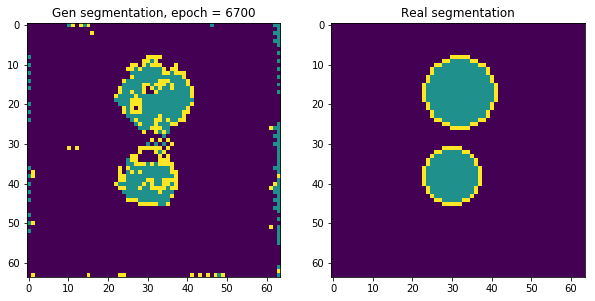

epoch - 6700, loss - 0.00794775690883
epoch - 6701, loss - 0.00829468946904
epoch - 6702, loss - 0.00862289778888
epoch - 6703, loss - 0.0089993532747
epoch - 6704, loss - 0.00914067868143
epoch - 6705, loss - 0.00912092812359
epoch - 6706, loss - 0.00869944132864
epoch - 6707, loss - 0.00814978592098
epoch - 6708, loss - 0.00760504230857
epoch - 6709, loss - 0.0073529034853
epoch - 6710, loss - 0.00748513825238
epoch - 6711, loss - 0.00787997245789
epoch - 6712, loss - 0.00851579196751
epoch - 6713, loss - 0.00909529067576
epoch - 6714, loss - 0.00991870183498
epoch - 6715, loss - 0.0103860246018
epoch - 6716, loss - 0.0109151769429
epoch - 6717, loss - 0.0111842732877
epoch - 6718, loss - 0.0117906350642
epoch - 6719, loss - 0.0123019535094
epoch - 6720, loss - 0.0129616092891
epoch - 6721, loss - 0.0140638556331
epoch - 6722, loss - 0.014587584883
epoch - 6723, loss - 0.0156453605741
epoch - 6724, loss - 0.0146293248981
epoch - 6725, loss - 0.0149175422266
epoch - 6726, loss - 0.015

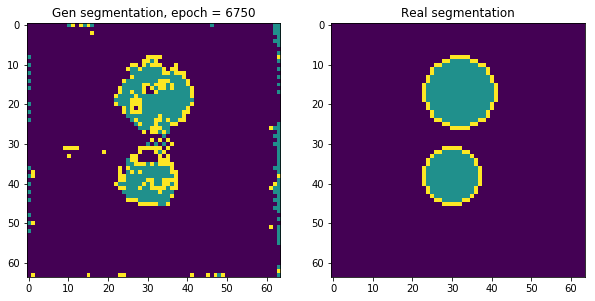

epoch - 6750, loss - 0.0285179968923
epoch - 6751, loss - 0.025449834764
epoch - 6752, loss - 0.0220104679465
epoch - 6753, loss - 0.0199855603278
epoch - 6754, loss - 0.0186471492052
epoch - 6755, loss - 0.0159215815365
epoch - 6756, loss - 0.0127132348716
epoch - 6757, loss - 0.011016452685
epoch - 6758, loss - 0.0109947230667
epoch - 6759, loss - 0.0101170446724
epoch - 6760, loss - 0.00887804664671
epoch - 6761, loss - 0.00926095899194
epoch - 6762, loss - 0.011073069647
epoch - 6763, loss - 0.0118029899895
epoch - 6764, loss - 0.0107894344255
epoch - 6765, loss - 0.0101413065568
epoch - 6766, loss - 0.0105481157079
epoch - 6767, loss - 0.0110416002572
epoch - 6768, loss - 0.010690594092
epoch - 6769, loss - 0.0101565700024
epoch - 6770, loss - 0.0100564621389
epoch - 6771, loss - 0.00995010510087
epoch - 6772, loss - 0.00938344933093
epoch - 6773, loss - 0.00857866089791
epoch - 6774, loss - 0.00830390769988
epoch - 6775, loss - 0.00853692553937
epoch - 6776, loss - 0.008575016632

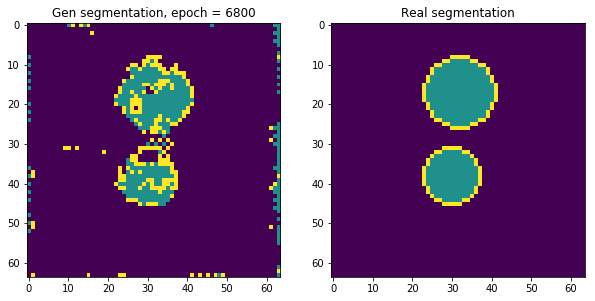

epoch - 6800, loss - 0.0676925256848
epoch - 6801, loss - 0.042809613049
epoch - 6802, loss - 0.0231326967478
epoch - 6803, loss - 0.0202480889857
epoch - 6804, loss - 0.0364089943469
epoch - 6805, loss - 0.053070306778
epoch - 6806, loss - 0.0582133904099
epoch - 6807, loss - 0.0420375689864
epoch - 6808, loss - 0.0226711910218
epoch - 6809, loss - 0.0201956704259
epoch - 6810, loss - 0.0304533652961
epoch - 6811, loss - 0.0370305888355
epoch - 6812, loss - 0.0305483937263
epoch - 6813, loss - 0.0240799728781
epoch - 6814, loss - 0.0260373577476
epoch - 6815, loss - 0.025867478922
epoch - 6816, loss - 0.0214324630797
epoch - 6817, loss - 0.0200516786426
epoch - 6818, loss - 0.0219823084772
epoch - 6819, loss - 0.0210286192596
epoch - 6820, loss - 0.0177833568305
epoch - 6821, loss - 0.0166068319231
epoch - 6822, loss - 0.0165165327489
epoch - 6823, loss - 0.0148027315736
epoch - 6824, loss - 0.0141546055675
epoch - 6825, loss - 0.0151520501822
epoch - 6826, loss - 0.0145004633814
epoc

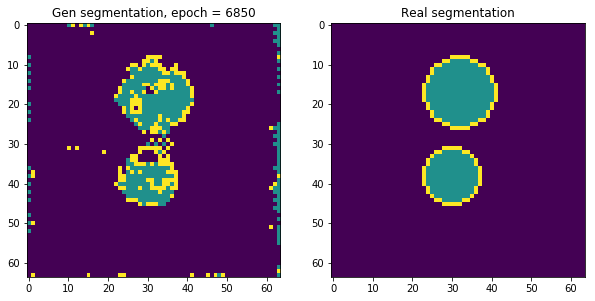

epoch - 6850, loss - 0.00725129246712
epoch - 6851, loss - 0.00723802018911
epoch - 6852, loss - 0.00721741793677
epoch - 6853, loss - 0.00717383576557
epoch - 6854, loss - 0.00712608080357
epoch - 6855, loss - 0.00711012631655
epoch - 6856, loss - 0.0071198772639
epoch - 6857, loss - 0.00718158017844
epoch - 6858, loss - 0.00725930836052
epoch - 6859, loss - 0.00734710227698
epoch - 6860, loss - 0.00745283905417
epoch - 6861, loss - 0.00758777745068
epoch - 6862, loss - 0.00769937271252
epoch - 6863, loss - 0.00778230559081
epoch - 6864, loss - 0.00787849165499
epoch - 6865, loss - 0.00796780455858
epoch - 6866, loss - 0.0079849101603
epoch - 6867, loss - 0.00796915404499
epoch - 6868, loss - 0.00793462060392
epoch - 6869, loss - 0.00806044787169
epoch - 6870, loss - 0.0083964029327
epoch - 6871, loss - 0.00900937058032
epoch - 6872, loss - 0.00986492820084
epoch - 6873, loss - 0.0108326412737
epoch - 6874, loss - 0.0116310464218
epoch - 6875, loss - 0.0117713073269
epoch - 6876, loss

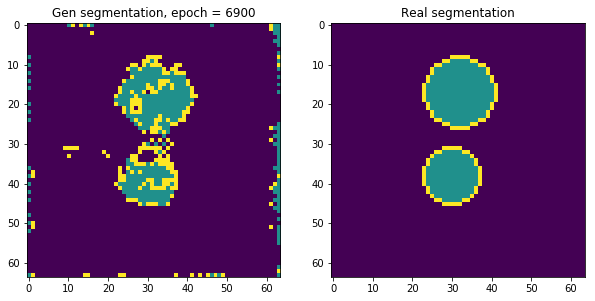

epoch - 6900, loss - 0.048984464258
epoch - 6901, loss - 0.0352681577206
epoch - 6902, loss - 0.0292630139738
epoch - 6903, loss - 0.0304728709161
epoch - 6904, loss - 0.0326333008707
epoch - 6905, loss - 0.0331637598574
epoch - 6906, loss - 0.0321506261826
epoch - 6907, loss - 0.0255439542234
epoch - 6908, loss - 0.0179994422942
epoch - 6909, loss - 0.0189672857523
epoch - 6910, loss - 0.0227071903646
epoch - 6911, loss - 0.0208377037197
epoch - 6912, loss - 0.018070217222
epoch - 6913, loss - 0.0171214416623
epoch - 6914, loss - 0.0152176842093
epoch - 6915, loss - 0.0141294319183
epoch - 6916, loss - 0.0160485040396
epoch - 6917, loss - 0.0163106936961
epoch - 6918, loss - 0.0140150431544
epoch - 6919, loss - 0.0127561856061
epoch - 6920, loss - 0.0124270962551
epoch - 6921, loss - 0.0119342869148
epoch - 6922, loss - 0.011472703889
epoch - 6923, loss - 0.0117182293907
epoch - 6924, loss - 0.011662889272
epoch - 6925, loss - 0.0108032524586
epoch - 6926, loss - 0.0103539638221
epoch

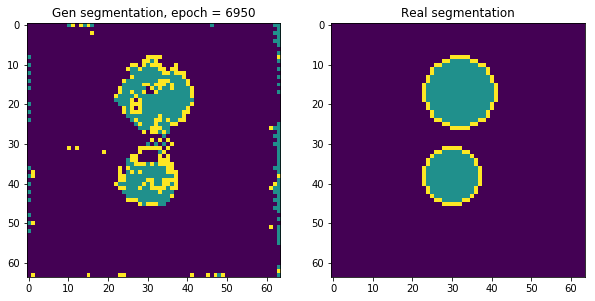

epoch - 6950, loss - 0.00673811882734
epoch - 6951, loss - 0.00677285529673
epoch - 6952, loss - 0.00686244294047
epoch - 6953, loss - 0.00689728884026
epoch - 6954, loss - 0.00692301802337
epoch - 6955, loss - 0.00686696032062
epoch - 6956, loss - 0.00685306824744
epoch - 6957, loss - 0.00677560549229
epoch - 6958, loss - 0.00667129689828
epoch - 6959, loss - 0.00655188970268
epoch - 6960, loss - 0.00647108303383
epoch - 6961, loss - 0.0064125303179
epoch - 6962, loss - 0.00635375641286
epoch - 6963, loss - 0.00631645554677
epoch - 6964, loss - 0.00632984191179
epoch - 6965, loss - 0.00635325443
epoch - 6966, loss - 0.00643572025001
epoch - 6967, loss - 0.00660861190408
epoch - 6968, loss - 0.00696859974414
epoch - 6969, loss - 0.00753348693252
epoch - 6970, loss - 0.00870899297297
epoch - 6971, loss - 0.0101224556565
epoch - 6972, loss - 0.012069622986
epoch - 6973, loss - 0.013247451745
epoch - 6974, loss - 0.0138607285917
epoch - 6975, loss - 0.0121751893312
epoch - 6976, loss - 0.

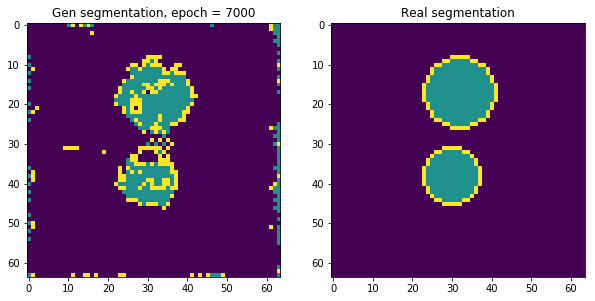

epoch - 7000, loss - 0.0505083985627
epoch - 7001, loss - 0.0339916460216
epoch - 7002, loss - 0.0333126634359
epoch - 7003, loss - 0.0476842857897
epoch - 7004, loss - 0.0327828973532
epoch - 7005, loss - 0.0285231918097
epoch - 7006, loss - 0.0350046753883
epoch - 7007, loss - 0.0210497621447
epoch - 7008, loss - 0.0260178986937
epoch - 7009, loss - 0.0317944511771
epoch - 7010, loss - 0.0201948918402
epoch - 7011, loss - 0.0251222997904
epoch - 7012, loss - 0.0247379560024
epoch - 7013, loss - 0.0183939188719
epoch - 7014, loss - 0.0241488106549
epoch - 7015, loss - 0.0207861252129
epoch - 7016, loss - 0.0185256469995
epoch - 7017, loss - 0.0196982100606
epoch - 7018, loss - 0.0149527620524
epoch - 7019, loss - 0.0164984744042
epoch - 7020, loss - 0.016515577212
epoch - 7021, loss - 0.0140437539667
epoch - 7022, loss - 0.0162782575935
epoch - 7023, loss - 0.0147654702887
epoch - 7024, loss - 0.0149041712284
epoch - 7025, loss - 0.0158137548715
epoch - 7026, loss - 0.0139519758523
ep

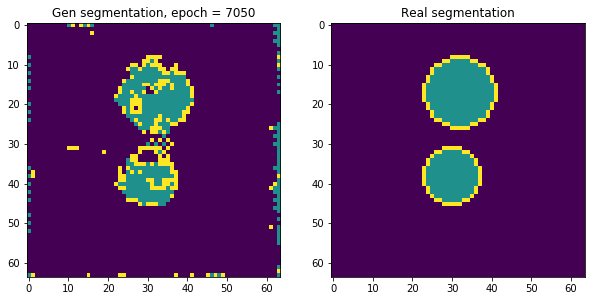

epoch - 7050, loss - 0.00753886345774
epoch - 7051, loss - 0.00741459894925
epoch - 7052, loss - 0.00740604288876
epoch - 7053, loss - 0.00767446123064
epoch - 7054, loss - 0.0077320933342
epoch - 7055, loss - 0.00761696882546
epoch - 7056, loss - 0.00736130774021
epoch - 7057, loss - 0.00723401270807
epoch - 7058, loss - 0.00713244639337
epoch - 7059, loss - 0.00704568112269
epoch - 7060, loss - 0.00691290106624
epoch - 7061, loss - 0.0067894058302
epoch - 7062, loss - 0.00671893637627
epoch - 7063, loss - 0.00667634466663
epoch - 7064, loss - 0.00658860942349
epoch - 7065, loss - 0.0065336516127
epoch - 7066, loss - 0.00648369640112
epoch - 7067, loss - 0.00641135172918
epoch - 7068, loss - 0.00633619632572
epoch - 7069, loss - 0.00630186963826
epoch - 7070, loss - 0.00623362697661
epoch - 7071, loss - 0.00618123449385
epoch - 7072, loss - 0.00614626612514
epoch - 7073, loss - 0.00610430818051
epoch - 7074, loss - 0.00606050016358
epoch - 7075, loss - 0.0060411808081
epoch - 7076, lo

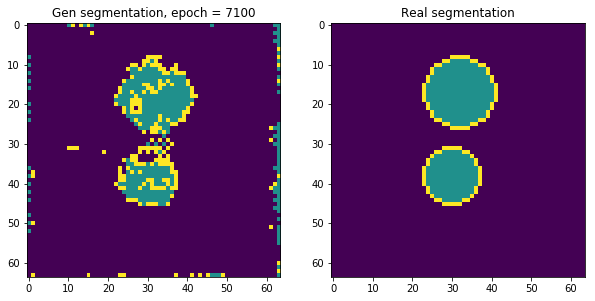

epoch - 7100, loss - 0.228413775563
epoch - 7101, loss - 0.0958951860666
epoch - 7102, loss - 0.0473520234227
epoch - 7103, loss - 0.116267517209
epoch - 7104, loss - 0.158236026764
epoch - 7105, loss - 0.0830112397671
epoch - 7106, loss - 0.040877956897
epoch - 7107, loss - 0.0836057215929
epoch - 7108, loss - 0.0888340622187
epoch - 7109, loss - 0.0464527159929
epoch - 7110, loss - 0.0413483120501
epoch - 7111, loss - 0.064573712647
epoch - 7112, loss - 0.0569150038064
epoch - 7113, loss - 0.0356625653803
epoch - 7114, loss - 0.0438109412789
epoch - 7115, loss - 0.0507065914571
epoch - 7116, loss - 0.037345983088
epoch - 7117, loss - 0.031879760325
epoch - 7118, loss - 0.0379021130502
epoch - 7119, loss - 0.0358176715672
epoch - 7120, loss - 0.0278020761907
epoch - 7121, loss - 0.026696767658
epoch - 7122, loss - 0.0296663623303
epoch - 7123, loss - 0.0259354375303
epoch - 7124, loss - 0.0207746997476
epoch - 7125, loss - 0.0219096392393
epoch - 7126, loss - 0.0230585280806
epoch - 7

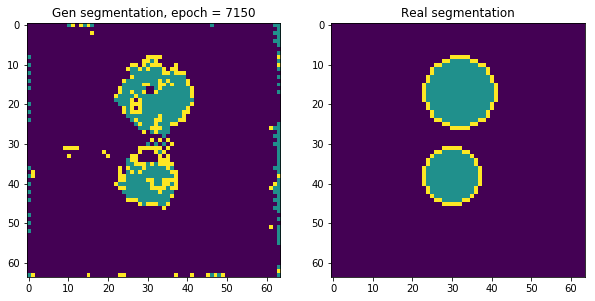

epoch - 7150, loss - 0.0120678814128
epoch - 7151, loss - 0.0116330012679
epoch - 7152, loss - 0.011406429112
epoch - 7153, loss - 0.011162661016
epoch - 7154, loss - 0.0110240830109
epoch - 7155, loss - 0.0105896927416
epoch - 7156, loss - 0.0101560195908
epoch - 7157, loss - 0.00988788343966
epoch - 7158, loss - 0.0095882518217
epoch - 7159, loss - 0.00942374672741
epoch - 7160, loss - 0.00933584198356
epoch - 7161, loss - 0.00923859514296
epoch - 7162, loss - 0.00901759695262
epoch - 7163, loss - 0.00872847624123
epoch - 7164, loss - 0.00865527428687
epoch - 7165, loss - 0.00872019864619
epoch - 7166, loss - 0.00862438231707
epoch - 7167, loss - 0.00848654285073
epoch - 7168, loss - 0.00838937237859
epoch - 7169, loss - 0.0082897702232
epoch - 7170, loss - 0.00817857403308
epoch - 7171, loss - 0.00812675990164
epoch - 7172, loss - 0.00812957808375
epoch - 7173, loss - 0.00817213393748
epoch - 7174, loss - 0.00819925125688
epoch - 7175, loss - 0.00823862478137
epoch - 7176, loss - 0.

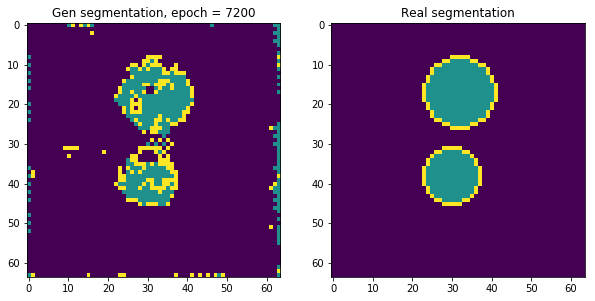

epoch - 7200, loss - 0.00708431797102
epoch - 7201, loss - 0.00728306127712
epoch - 7202, loss - 0.00769759248942
epoch - 7203, loss - 0.00786670297384
epoch - 7204, loss - 0.00776320742443
epoch - 7205, loss - 0.00721640326083
epoch - 7206, loss - 0.0067616677843
epoch - 7207, loss - 0.00672904541716
epoch - 7208, loss - 0.00710300914943
epoch - 7209, loss - 0.00776790454984
epoch - 7210, loss - 0.00825854577124
epoch - 7211, loss - 0.00863291323185
epoch - 7212, loss - 0.0086223622784
epoch - 7213, loss - 0.00866261590272
epoch - 7214, loss - 0.00858485978097
epoch - 7215, loss - 0.00889804959297
epoch - 7216, loss - 0.00923296716064
epoch - 7217, loss - 0.00939803943038
epoch - 7218, loss - 0.00919643230736
epoch - 7219, loss - 0.00840619206429
epoch - 7220, loss - 0.00794898532331
epoch - 7221, loss - 0.00833172351122
epoch - 7222, loss - 0.00935605727136
epoch - 7223, loss - 0.0104789901525
epoch - 7224, loss - 0.0107706235722
epoch - 7225, loss - 0.0101822521538
epoch - 7226, los

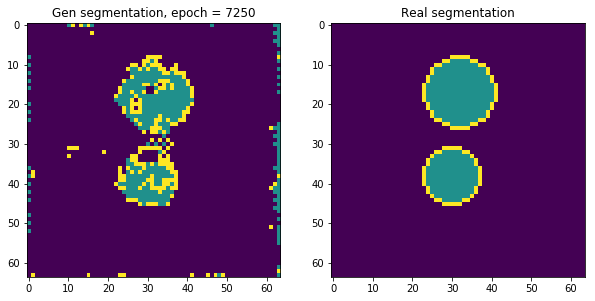

epoch - 7250, loss - 0.00692077539861
epoch - 7251, loss - 0.00710080843419
epoch - 7252, loss - 0.00706096738577
epoch - 7253, loss - 0.00699180644006
epoch - 7254, loss - 0.00721526890993
epoch - 7255, loss - 0.00759314186871
epoch - 7256, loss - 0.00804478675127
epoch - 7257, loss - 0.00824269093573
epoch - 7258, loss - 0.00840865913779
epoch - 7259, loss - 0.00861298665404
epoch - 7260, loss - 0.0090153850615
epoch - 7261, loss - 0.00954401306808
epoch - 7262, loss - 0.0100630316883
epoch - 7263, loss - 0.0105809411034
epoch - 7264, loss - 0.0113215725869
epoch - 7265, loss - 0.012445432134
epoch - 7266, loss - 0.0139219239354
epoch - 7267, loss - 0.0155561305583
epoch - 7268, loss - 0.0166686698794
epoch - 7269, loss - 0.0169421639293
epoch - 7270, loss - 0.0155989732593
epoch - 7271, loss - 0.0140221398324
epoch - 7272, loss - 0.0132945859805
epoch - 7273, loss - 0.0137228630483
epoch - 7274, loss - 0.0142862219363
epoch - 7275, loss - 0.0144352540374
epoch - 7276, loss - 0.01415

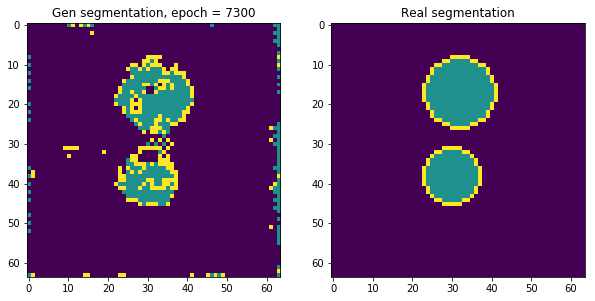

epoch - 7300, loss - 0.00738016841933
epoch - 7301, loss - 0.00720436125994
epoch - 7302, loss - 0.00724336365238
epoch - 7303, loss - 0.0069097680971
epoch - 7304, loss - 0.00658546667546
epoch - 7305, loss - 0.00679276976734
epoch - 7306, loss - 0.00712540093809
epoch - 7307, loss - 0.00701832864434
epoch - 7308, loss - 0.00668999832124
epoch - 7309, loss - 0.00675031822175
epoch - 7310, loss - 0.00714107882231
epoch - 7311, loss - 0.00735751027241
epoch - 7312, loss - 0.00748875457793
epoch - 7313, loss - 0.00792492367327
epoch - 7314, loss - 0.00879972334951
epoch - 7315, loss - 0.00982002355158
epoch - 7316, loss - 0.011005980894
epoch - 7317, loss - 0.0127884279937
epoch - 7318, loss - 0.0157659575343
epoch - 7319, loss - 0.0197801478207
epoch - 7320, loss - 0.0254000872374
epoch - 7321, loss - 0.0322762839496
epoch - 7322, loss - 0.0421441495419
epoch - 7323, loss - 0.0529647246003
epoch - 7324, loss - 0.0662924349308
epoch - 7325, loss - 0.0748469233513
epoch - 7326, loss - 0.0

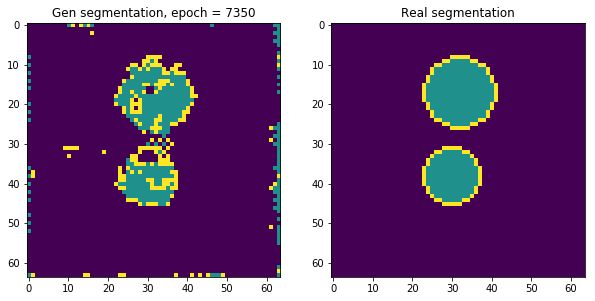

epoch - 7350, loss - 0.00710003310814
epoch - 7351, loss - 0.00824393704534
epoch - 7352, loss - 0.00907469075173
epoch - 7353, loss - 0.00883077085018
epoch - 7354, loss - 0.00807929690927
epoch - 7355, loss - 0.0074910367839
epoch - 7356, loss - 0.00717396475375
epoch - 7357, loss - 0.00688688736409
epoch - 7358, loss - 0.0067096077837
epoch - 7359, loss - 0.00691656209528
epoch - 7360, loss - 0.0072012511082
epoch - 7361, loss - 0.00718162534758
epoch - 7362, loss - 0.00686187064275
epoch - 7363, loss - 0.00674875918776
epoch - 7364, loss - 0.00701506063342
epoch - 7365, loss - 0.00752968201414
epoch - 7366, loss - 0.00801346637309
epoch - 7367, loss - 0.00870610587299
epoch - 7368, loss - 0.00963271223009
epoch - 7369, loss - 0.0108858048916
epoch - 7370, loss - 0.0119013767689
epoch - 7371, loss - 0.0134260095656
epoch - 7372, loss - 0.0136901484802
epoch - 7373, loss - 0.013968189247
epoch - 7374, loss - 0.0132111208513
epoch - 7375, loss - 0.012078884989
epoch - 7376, loss - 0.0

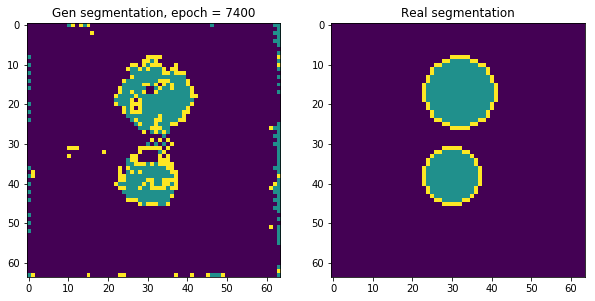

epoch - 7400, loss - 0.00591422338039
epoch - 7401, loss - 0.00571504142135
epoch - 7402, loss - 0.00548784388229
epoch - 7403, loss - 0.00549271935597
epoch - 7404, loss - 0.00570806767792
epoch - 7405, loss - 0.00581337045878
epoch - 7406, loss - 0.00580821279436
epoch - 7407, loss - 0.00583928963169
epoch - 7408, loss - 0.00580968568102
epoch - 7409, loss - 0.00603307317942
epoch - 7410, loss - 0.00628039706498
epoch - 7411, loss - 0.00638304837048
epoch - 7412, loss - 0.00641475478187
epoch - 7413, loss - 0.00649966299534
epoch - 7414, loss - 0.00664286408573
epoch - 7415, loss - 0.00683747092262
epoch - 7416, loss - 0.00694970693439
epoch - 7417, loss - 0.00717399735004
epoch - 7418, loss - 0.00748515175655
epoch - 7419, loss - 0.00836620014161
epoch - 7420, loss - 0.00906767696142
epoch - 7421, loss - 0.0100988466293
epoch - 7422, loss - 0.0120744891465
epoch - 7423, loss - 0.0152763389051
epoch - 7424, loss - 0.0204673111439
epoch - 7425, loss - 0.0287151765078
epoch - 7426, los

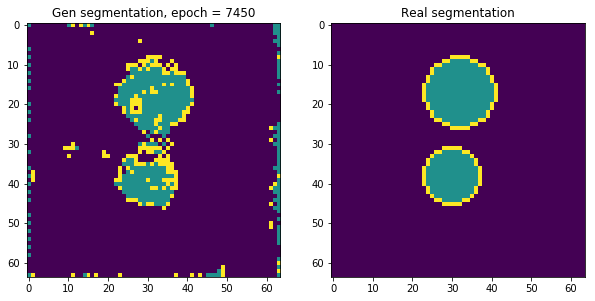

epoch - 7450, loss - 0.0758751779795
epoch - 7451, loss - 0.0787540376186
epoch - 7452, loss - 0.0787433236837
epoch - 7453, loss - 0.0695221573114
epoch - 7454, loss - 0.0626852437854
epoch - 7455, loss - 0.0649509355426
epoch - 7456, loss - 0.0635245963931
epoch - 7457, loss - 0.0558043494821
epoch - 7458, loss - 0.0498143732548
epoch - 7459, loss - 0.0493738092482
epoch - 7460, loss - 0.0479194298387
epoch - 7461, loss - 0.042571272701
epoch - 7462, loss - 0.0394881851971
epoch - 7463, loss - 0.0379129573703
epoch - 7464, loss - 0.0382619760931
epoch - 7465, loss - 0.0345122814178
epoch - 7466, loss - 0.0320550277829
epoch - 7467, loss - 0.03032906726
epoch - 7468, loss - 0.0303375460207
epoch - 7469, loss - 0.0283181667328
epoch - 7470, loss - 0.0258739311248
epoch - 7471, loss - 0.024452175945
epoch - 7472, loss - 0.0239556618035
epoch - 7473, loss - 0.023671509698
epoch - 7474, loss - 0.0224115140736
epoch - 7475, loss - 0.0212992485613
epoch - 7476, loss - 0.0206200890243
epoch 

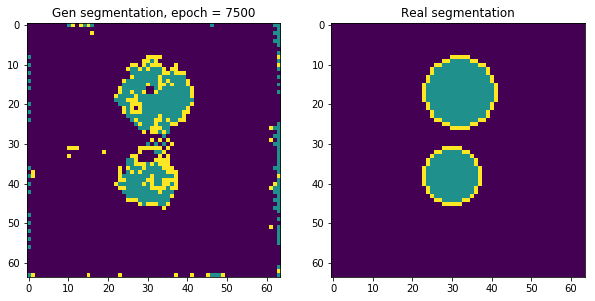

epoch - 7500, loss - 0.0108737898991
epoch - 7501, loss - 0.0106511795893
epoch - 7502, loss - 0.0104375276715
epoch - 7503, loss - 0.0102805215865
epoch - 7504, loss - 0.0101212430745
epoch - 7505, loss - 0.0100199133158
epoch - 7506, loss - 0.0101726837456
epoch - 7507, loss - 0.00998741015792
epoch - 7508, loss - 0.0100339520723
epoch - 7509, loss - 0.00995905138552
epoch - 7510, loss - 0.0097225215286
epoch - 7511, loss - 0.00962146464735
epoch - 7512, loss - 0.00948316417634
epoch - 7513, loss - 0.00933930743486
epoch - 7514, loss - 0.00921257957816
epoch - 7515, loss - 0.00907794199884
epoch - 7516, loss - 0.00896334089339
epoch - 7517, loss - 0.00883998163044
epoch - 7518, loss - 0.00873272772878
epoch - 7519, loss - 0.00863541103899
epoch - 7520, loss - 0.00856661051512
epoch - 7521, loss - 0.00849911011755
epoch - 7522, loss - 0.00844894349575
epoch - 7523, loss - 0.00841711927205
epoch - 7524, loss - 0.00840601045638
epoch - 7525, loss - 0.00841460004449
epoch - 7526, loss - 

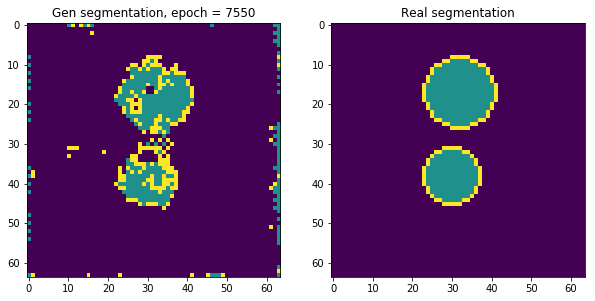

epoch - 7550, loss - 0.00833190046251
epoch - 7551, loss - 0.00834908895195
epoch - 7552, loss - 0.00834292732179
epoch - 7553, loss - 0.00817718636245
epoch - 7554, loss - 0.0079218428582
epoch - 7555, loss - 0.00771932303905
epoch - 7556, loss - 0.00764153432101
epoch - 7557, loss - 0.00761797185987
epoch - 7558, loss - 0.00767691992223
epoch - 7559, loss - 0.00780538097024
epoch - 7560, loss - 0.00792713835835
epoch - 7561, loss - 0.00803193449974
epoch - 7562, loss - 0.00802167039365
epoch - 7563, loss - 0.00799162685871
epoch - 7564, loss - 0.00795008707792
epoch - 7565, loss - 0.0079997824505
epoch - 7566, loss - 0.00844112504274
epoch - 7567, loss - 0.00882038008422
epoch - 7568, loss - 0.00964240450412
epoch - 7569, loss - 0.0100481789559
epoch - 7570, loss - 0.010281435214
epoch - 7571, loss - 0.00986368861049
epoch - 7572, loss - 0.00960623472929
epoch - 7573, loss - 0.00995212048292
epoch - 7574, loss - 0.0113200526685
epoch - 7575, loss - 0.0135316923261
epoch - 7576, loss 

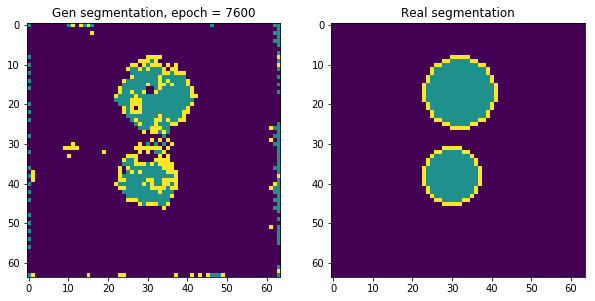

epoch - 7600, loss - 0.0150075629354
epoch - 7601, loss - 0.0111426711082
epoch - 7602, loss - 0.0135830929503
epoch - 7603, loss - 0.0165773779154
epoch - 7604, loss - 0.0151568092406
epoch - 7605, loss - 0.0129049196839
epoch - 7606, loss - 0.0114725986496
epoch - 7607, loss - 0.0102475639433
epoch - 7608, loss - 0.00979593582451
epoch - 7609, loss - 0.0107983797789
epoch - 7610, loss - 0.0117355845869
epoch - 7611, loss - 0.0106445318088
epoch - 7612, loss - 0.00889670755714
epoch - 7613, loss - 0.00821458175778
epoch - 7614, loss - 0.00833310931921
epoch - 7615, loss - 0.00846499949694
epoch - 7616, loss - 0.00858026184142
epoch - 7617, loss - 0.00873239338398
epoch - 7618, loss - 0.00840651616454
epoch - 7619, loss - 0.00757895875722
epoch - 7620, loss - 0.00700265960768
epoch - 7621, loss - 0.00704855192453
epoch - 7622, loss - 0.00725172460079
epoch - 7623, loss - 0.00727973971516
epoch - 7624, loss - 0.00731269875541
epoch - 7625, loss - 0.00726657826453
epoch - 7626, loss - 0.

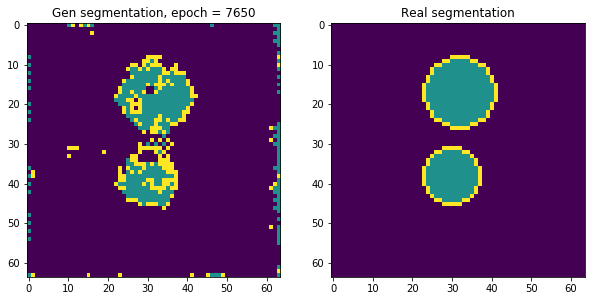

epoch - 7650, loss - 0.00777654629201
epoch - 7651, loss - 0.00764995999634
epoch - 7652, loss - 0.00767542328686
epoch - 7653, loss - 0.00768431276083
epoch - 7654, loss - 0.0075622908771
epoch - 7655, loss - 0.0073685310781
epoch - 7656, loss - 0.0070599168539
epoch - 7657, loss - 0.00679182540625
epoch - 7658, loss - 0.00669636530802
epoch - 7659, loss - 0.00670357700437
epoch - 7660, loss - 0.00673141609877
epoch - 7661, loss - 0.00676467455924
epoch - 7662, loss - 0.00675825914368
epoch - 7663, loss - 0.00661115255207
epoch - 7664, loss - 0.00644284766167
epoch - 7665, loss - 0.00632935995236
epoch - 7666, loss - 0.00624717399478
epoch - 7667, loss - 0.0062162829563
epoch - 7668, loss - 0.00622690888122
epoch - 7669, loss - 0.0063843796961
epoch - 7670, loss - 0.00637854356319
epoch - 7671, loss - 0.006457564421
epoch - 7672, loss - 0.00650777714327
epoch - 7673, loss - 0.0065787518397
epoch - 7674, loss - 0.00669890921563
epoch - 7675, loss - 0.0069866119884
epoch - 7676, loss - 

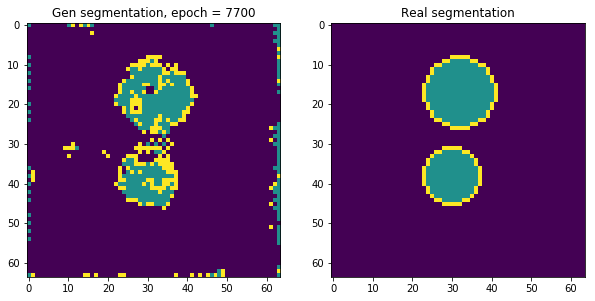

epoch - 7700, loss - 0.0277154240757
epoch - 7701, loss - 0.0220817867666
epoch - 7702, loss - 0.0199730750173
epoch - 7703, loss - 0.0204105898738
epoch - 7704, loss - 0.0148630421609
epoch - 7705, loss - 0.0118757933378
epoch - 7706, loss - 0.0165820978582
epoch - 7707, loss - 0.0174319949001
epoch - 7708, loss - 0.0122182453051
epoch - 7709, loss - 0.00908502563834
epoch - 7710, loss - 0.0123274587095
epoch - 7711, loss - 0.0128672774881
epoch - 7712, loss - 0.00985371600837
epoch - 7713, loss - 0.0104524968192
epoch - 7714, loss - 0.0115993926302
epoch - 7715, loss - 0.00886479578912
epoch - 7716, loss - 0.00746408384293
epoch - 7717, loss - 0.0092306798324
epoch - 7718, loss - 0.00920023396611
epoch - 7719, loss - 0.00766749726608
epoch - 7720, loss - 0.00767800025642
epoch - 7721, loss - 0.0078433342278
epoch - 7722, loss - 0.00685155903921
epoch - 7723, loss - 0.00642180815339
epoch - 7724, loss - 0.00719720963389
epoch - 7725, loss - 0.00725366966799
epoch - 7726, loss - 0.0064

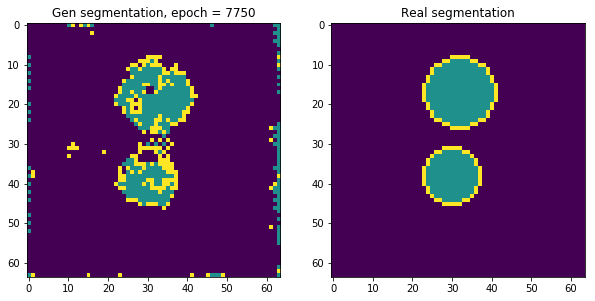

epoch - 7750, loss - 0.00561794266105
epoch - 7751, loss - 0.00577327469364
epoch - 7752, loss - 0.00594117259607
epoch - 7753, loss - 0.00608531013131
epoch - 7754, loss - 0.00628673098981
epoch - 7755, loss - 0.00634751329198
epoch - 7756, loss - 0.00625323038548
epoch - 7757, loss - 0.00596518721431
epoch - 7758, loss - 0.00563021982089
epoch - 7759, loss - 0.00525628076866
epoch - 7760, loss - 0.0049906866625
epoch - 7761, loss - 0.00508179469034
epoch - 7762, loss - 0.00522531662136
epoch - 7763, loss - 0.00553085748106
epoch - 7764, loss - 0.00584342190996
epoch - 7765, loss - 0.00611050613225
epoch - 7766, loss - 0.00626107351854
epoch - 7767, loss - 0.00639085751027
epoch - 7768, loss - 0.00633229594678
epoch - 7769, loss - 0.00612237304449
epoch - 7770, loss - 0.00586221180856
epoch - 7771, loss - 0.00571501906961
epoch - 7772, loss - 0.00577921792865
epoch - 7773, loss - 0.00598563160747
epoch - 7774, loss - 0.00634883064777
epoch - 7775, loss - 0.00671445485204
epoch - 7776,

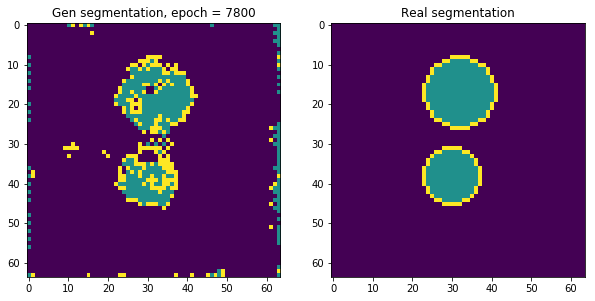

epoch - 7800, loss - 0.109969846904
epoch - 7801, loss - 0.0908458977938
epoch - 7802, loss - 0.0610846243799
epoch - 7803, loss - 0.0331049822271
epoch - 7804, loss - 0.0228055026382
epoch - 7805, loss - 0.0296918600798
epoch - 7806, loss - 0.0384142138064
epoch - 7807, loss - 0.0409440360963
epoch - 7808, loss - 0.0345397777855
epoch - 7809, loss - 0.0235838796943
epoch - 7810, loss - 0.0154101345688
epoch - 7811, loss - 0.0154673745856
epoch - 7812, loss - 0.0227370020002
epoch - 7813, loss - 0.0256979670376
epoch - 7814, loss - 0.0191690605134
epoch - 7815, loss - 0.0108906412497
epoch - 7816, loss - 0.0099729616195
epoch - 7817, loss - 0.0145759675652
epoch - 7818, loss - 0.0163657534868
epoch - 7819, loss - 0.013532711193
epoch - 7820, loss - 0.0102729583159
epoch - 7821, loss - 0.00912429951131
epoch - 7822, loss - 0.00927680917084
epoch - 7823, loss - 0.0097001940012
epoch - 7824, loss - 0.0103413835168
epoch - 7825, loss - 0.0100118815899
epoch - 7826, loss - 0.00809127371758


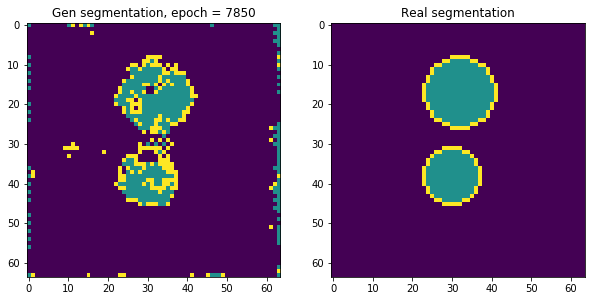

epoch - 7850, loss - 0.00482990778983
epoch - 7851, loss - 0.00472658779472
epoch - 7852, loss - 0.00461007468402
epoch - 7853, loss - 0.00462354300544
epoch - 7854, loss - 0.00470636179671
epoch - 7855, loss - 0.00470851641148
epoch - 7856, loss - 0.00465483311564
epoch - 7857, loss - 0.00464913481846
epoch - 7858, loss - 0.00473706098273
epoch - 7859, loss - 0.00480042304844
epoch - 7860, loss - 0.0049709319137
epoch - 7861, loss - 0.00526059418917
epoch - 7862, loss - 0.00576930074021
epoch - 7863, loss - 0.00644650217146
epoch - 7864, loss - 0.00744305737317
epoch - 7865, loss - 0.00862413365394
epoch - 7866, loss - 0.0104732150212
epoch - 7867, loss - 0.0120152728632
epoch - 7868, loss - 0.0131125226617
epoch - 7869, loss - 0.0126968957484
epoch - 7870, loss - 0.0107395816594
epoch - 7871, loss - 0.00764164002612
epoch - 7872, loss - 0.00543373543769
epoch - 7873, loss - 0.00560369715095
epoch - 7874, loss - 0.00734056020156
epoch - 7875, loss - 0.00868854857981
epoch - 7876, loss

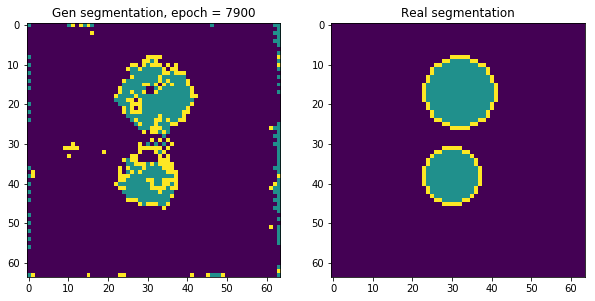

epoch - 7900, loss - 0.00784794520587
epoch - 7901, loss - 0.00900818221271
epoch - 7902, loss - 0.0104547543451
epoch - 7903, loss - 0.0123150749132
epoch - 7904, loss - 0.0150963086635
epoch - 7905, loss - 0.0188532415777
epoch - 7906, loss - 0.0247151218355
epoch - 7907, loss - 0.0326840206981
epoch - 7908, loss - 0.0443623438478
epoch - 7909, loss - 0.05724253878
epoch - 7910, loss - 0.0724892914295
epoch - 7911, loss - 0.0814805403352
epoch - 7912, loss - 0.0833416730165
epoch - 7913, loss - 0.0682706981897
epoch - 7914, loss - 0.044513899833
epoch - 7915, loss - 0.0220920238644
epoch - 7916, loss - 0.0133000109345
epoch - 7917, loss - 0.019281219691
epoch - 7918, loss - 0.0292830690742
epoch - 7919, loss - 0.0330646410584
epoch - 7920, loss - 0.0272334031761
epoch - 7921, loss - 0.0188028663397
epoch - 7922, loss - 0.0134576670825
epoch - 7923, loss - 0.0130503792316
epoch - 7924, loss - 0.0152056831867
epoch - 7925, loss - 0.0172931104898
epoch - 7926, loss - 0.0174046568573
epo

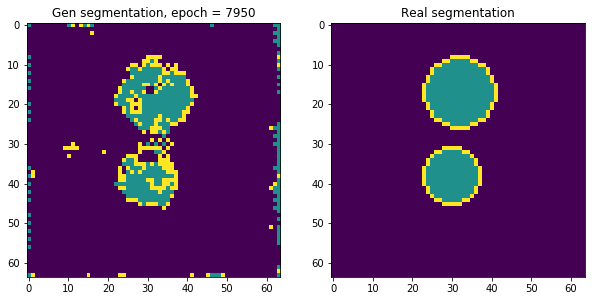

epoch - 7950, loss - 0.00522284442559
epoch - 7951, loss - 0.00530902249739
epoch - 7952, loss - 0.00531593104824
epoch - 7953, loss - 0.00521253701299
epoch - 7954, loss - 0.00498869130388
epoch - 7955, loss - 0.00480459164828
epoch - 7956, loss - 0.00472202850506
epoch - 7957, loss - 0.00478976313025
epoch - 7958, loss - 0.00487029971555
epoch - 7959, loss - 0.00490627158433
epoch - 7960, loss - 0.00499001983553
epoch - 7961, loss - 0.00506247859448
epoch - 7962, loss - 0.00497663579881
epoch - 7963, loss - 0.00485330820084
epoch - 7964, loss - 0.00475577823818
epoch - 7965, loss - 0.00472992053255
epoch - 7966, loss - 0.00474416464567
epoch - 7967, loss - 0.00477993581444
epoch - 7968, loss - 0.00480936048552
epoch - 7969, loss - 0.00484817335382
epoch - 7970, loss - 0.00494566000998
epoch - 7971, loss - 0.00512860156596
epoch - 7972, loss - 0.00546937808394
epoch - 7973, loss - 0.00591387972236
epoch - 7974, loss - 0.00632951734588
epoch - 7975, loss - 0.00700417626649
epoch - 7976

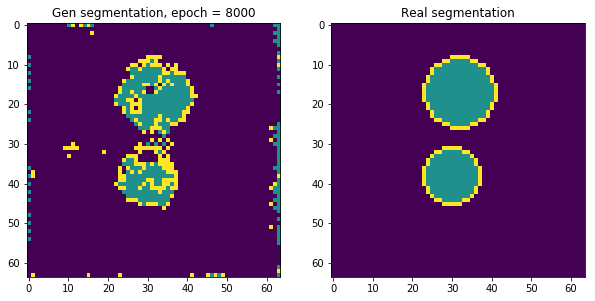

epoch - 8000, loss - 0.0155043592677
epoch - 8001, loss - 0.0140760298818
epoch - 8002, loss - 0.0109531888738
epoch - 8003, loss - 0.00895676668733
epoch - 8004, loss - 0.0097972843796
epoch - 8005, loss - 0.0111639853567
epoch - 8006, loss - 0.011047732085
epoch - 8007, loss - 0.0096447058022
epoch - 8008, loss - 0.00891626998782
epoch - 8009, loss - 0.00978839956224
epoch - 8010, loss - 0.011099435389
epoch - 8011, loss - 0.0117370970547
epoch - 8012, loss - 0.0123867811635
epoch - 8013, loss - 0.0145314317197
epoch - 8014, loss - 0.018438545987
epoch - 8015, loss - 0.0233813971281
epoch - 8016, loss - 0.0300039611757
epoch - 8017, loss - 0.0382025800645
epoch - 8018, loss - 0.0498074032366
epoch - 8019, loss - 0.0618448592722
epoch - 8020, loss - 0.074138097465
epoch - 8021, loss - 0.078516356647
epoch - 8022, loss - 0.0745489597321
epoch - 8023, loss - 0.0564517378807
epoch - 8024, loss - 0.0341491959989
epoch - 8025, loss - 0.0170144122094
epoch - 8026, loss - 0.0122180674225
epo

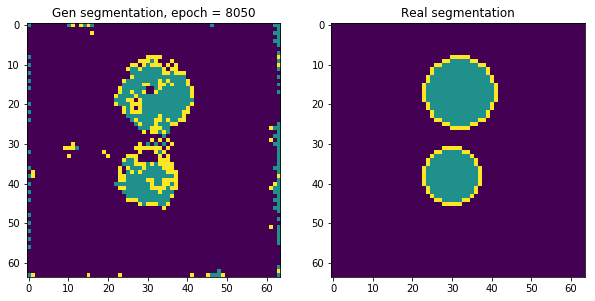

epoch - 8050, loss - 0.00689277146012
epoch - 8051, loss - 0.00606062635779
epoch - 8052, loss - 0.00519561301917
epoch - 8053, loss - 0.00490176444873
epoch - 8054, loss - 0.00523689296097
epoch - 8055, loss - 0.00554163940251
epoch - 8056, loss - 0.00562271429226
epoch - 8057, loss - 0.0054920152761
epoch - 8058, loss - 0.00515579711646
epoch - 8059, loss - 0.00471504591405
epoch - 8060, loss - 0.00439561717212
epoch - 8061, loss - 0.00438309460878
epoch - 8062, loss - 0.00455757975578
epoch - 8063, loss - 0.00470877997577
epoch - 8064, loss - 0.00470355385914
epoch - 8065, loss - 0.00460995920002
epoch - 8066, loss - 0.00449906894937
epoch - 8067, loss - 0.00438172649592
epoch - 8068, loss - 0.00424261856824
epoch - 8069, loss - 0.00416163448244
epoch - 8070, loss - 0.00420225132257
epoch - 8071, loss - 0.00431849202141
epoch - 8072, loss - 0.00447551999241
epoch - 8073, loss - 0.00455597462133
epoch - 8074, loss - 0.00468013994396
epoch - 8075, loss - 0.00481593003497
epoch - 8076,

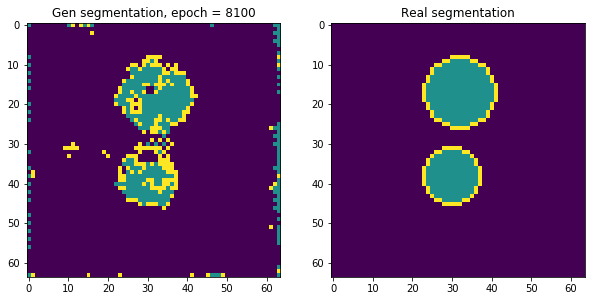

epoch - 8100, loss - 0.00991931650788
epoch - 8101, loss - 0.0119095146656
epoch - 8102, loss - 0.0150552699342
epoch - 8103, loss - 0.0144068617374
epoch - 8104, loss - 0.0116787320003
epoch - 8105, loss - 0.0109440712258
epoch - 8106, loss - 0.0129194352776
epoch - 8107, loss - 0.0143067240715
epoch - 8108, loss - 0.0132285738364
epoch - 8109, loss - 0.0132071282715
epoch - 8110, loss - 0.0152555592358
epoch - 8111, loss - 0.0170404408127
epoch - 8112, loss - 0.0178062915802
epoch - 8113, loss - 0.0195659641176
epoch - 8114, loss - 0.0225168000907
epoch - 8115, loss - 0.025651935488
epoch - 8116, loss - 0.0270862840116
epoch - 8117, loss - 0.028231292963
epoch - 8118, loss - 0.028818378225
epoch - 8119, loss - 0.0283829197288
epoch - 8120, loss - 0.0251523666084
epoch - 8121, loss - 0.0209412537515
epoch - 8122, loss - 0.0167252011597
epoch - 8123, loss - 0.0130837522447
epoch - 8124, loss - 0.00933417864144
epoch - 8125, loss - 0.00681783352047
epoch - 8126, loss - 0.00631664926186


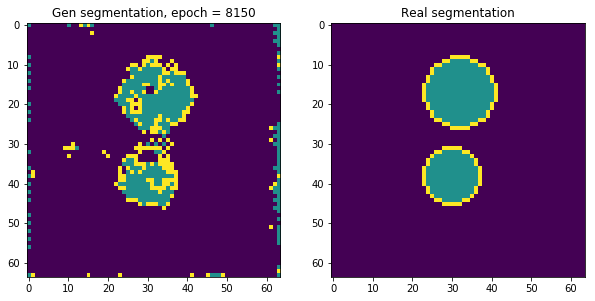

epoch - 8150, loss - 0.00703957816586
epoch - 8151, loss - 0.00687387213111
epoch - 8152, loss - 0.00683854613453
epoch - 8153, loss - 0.00677293539047
epoch - 8154, loss - 0.00676830578595
epoch - 8155, loss - 0.00693416967988
epoch - 8156, loss - 0.00698229204863
epoch - 8157, loss - 0.0070754350163
epoch - 8158, loss - 0.00717661017552
epoch - 8159, loss - 0.00739209912717
epoch - 8160, loss - 0.00779668800533
epoch - 8161, loss - 0.00827008392662
epoch - 8162, loss - 0.00888261757791
epoch - 8163, loss - 0.0096653169021
epoch - 8164, loss - 0.0107118543237
epoch - 8165, loss - 0.0121625717729
epoch - 8166, loss - 0.0140119837597
epoch - 8167, loss - 0.0166947972029
epoch - 8168, loss - 0.0199968125671
epoch - 8169, loss - 0.0246918965131
epoch - 8170, loss - 0.0301605351269
epoch - 8171, loss - 0.0371407791972
epoch - 8172, loss - 0.0437023378909
epoch - 8173, loss - 0.0499814599752
epoch - 8174, loss - 0.0523718334734
epoch - 8175, loss - 0.0508842281997
epoch - 8176, loss - 0.043

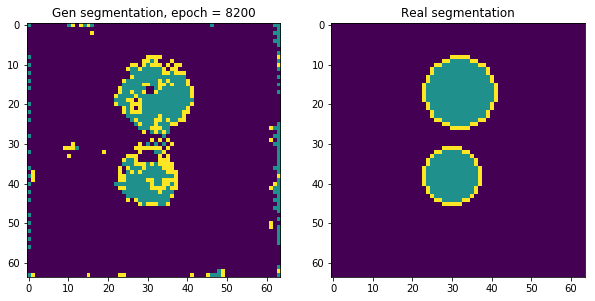

epoch - 8200, loss - 0.0115289362147
epoch - 8201, loss - 0.0111229643226
epoch - 8202, loss - 0.00970509648323
epoch - 8203, loss - 0.00898978300393
epoch - 8204, loss - 0.00925849378109
epoch - 8205, loss - 0.00906606670469
epoch - 8206, loss - 0.00836394634098
epoch - 8207, loss - 0.0114630768076
epoch - 8208, loss - 0.0121346656233
epoch - 8209, loss - 0.0125385792926
epoch - 8210, loss - 0.012153650634
epoch - 8211, loss - 0.0114023592323
epoch - 8212, loss - 0.0106938667595
epoch - 8213, loss - 0.0105317970738
epoch - 8214, loss - 0.00972718931735
epoch - 8215, loss - 0.00939313881099
epoch - 8216, loss - 0.00906527135521
epoch - 8217, loss - 0.00838133879006
epoch - 8218, loss - 0.00861367862672
epoch - 8219, loss - 0.00885964464396
epoch - 8220, loss - 0.00885152630508
epoch - 8221, loss - 0.00854168552905
epoch - 8222, loss - 0.00833008997142
epoch - 8223, loss - 0.0081284372136
epoch - 8224, loss - 0.00797179993242
epoch - 8225, loss - 0.00778116798028
epoch - 8226, loss - 0.

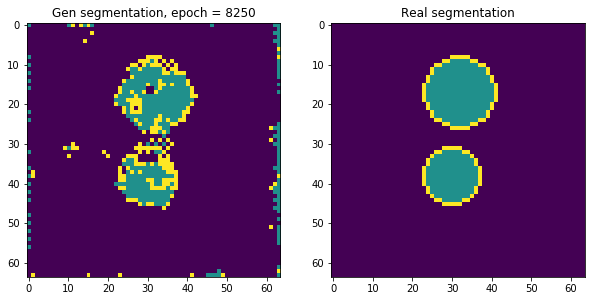

epoch - 8250, loss - 0.151131421328
epoch - 8251, loss - 0.0890834107995
epoch - 8252, loss - 0.0306314732879
epoch - 8253, loss - 0.0318498536944
epoch - 8254, loss - 0.073354229331
epoch - 8255, loss - 0.0853274837136
epoch - 8256, loss - 0.0521357990801
epoch - 8257, loss - 0.0218886099756
epoch - 8258, loss - 0.0310693737119
epoch - 8259, loss - 0.0479917488992
epoch - 8260, loss - 0.0403944142163
epoch - 8261, loss - 0.0251157097518
epoch - 8262, loss - 0.0224827118218
epoch - 8263, loss - 0.0274387653917
epoch - 8264, loss - 0.0277263596654
epoch - 8265, loss - 0.0239078234881
epoch - 8266, loss - 0.0194303914905
epoch - 8267, loss - 0.0167797468603
epoch - 8268, loss - 0.0178697537631
epoch - 8269, loss - 0.0193029455841
epoch - 8270, loss - 0.015578574501
epoch - 8271, loss - 0.0117440978065
epoch - 8272, loss - 0.0127017693594
epoch - 8273, loss - 0.0140177756548
epoch - 8274, loss - 0.0127001293004
epoch - 8275, loss - 0.0103870974854
epoch - 8276, loss - 0.00944235362113
epo

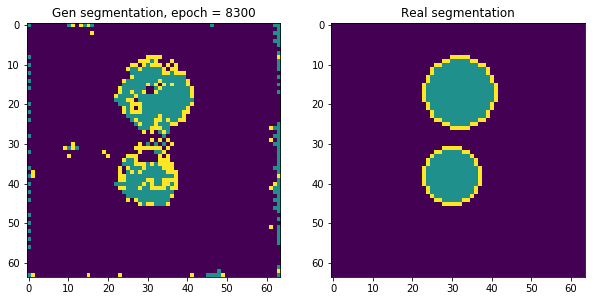

epoch - 8300, loss - 0.0047476994805
epoch - 8301, loss - 0.00466473028064
epoch - 8302, loss - 0.00469850283116
epoch - 8303, loss - 0.00475181732327
epoch - 8304, loss - 0.00482245255262
epoch - 8305, loss - 0.00498560862616
epoch - 8306, loss - 0.00524981785566
epoch - 8307, loss - 0.00551384547725
epoch - 8308, loss - 0.00583124347031
epoch - 8309, loss - 0.00613604020327
epoch - 8310, loss - 0.00637592934072
epoch - 8311, loss - 0.00630390364677
epoch - 8312, loss - 0.00583982421085
epoch - 8313, loss - 0.00519181555137
epoch - 8314, loss - 0.0046749683097
epoch - 8315, loss - 0.00448257476091
epoch - 8316, loss - 0.00457207113504
epoch - 8317, loss - 0.00481607485563
epoch - 8318, loss - 0.00502091180533
epoch - 8319, loss - 0.00500122085214
epoch - 8320, loss - 0.00476633105427
epoch - 8321, loss - 0.00444644736126
epoch - 8322, loss - 0.00425908807665
epoch - 8323, loss - 0.0042435862124
epoch - 8324, loss - 0.00432586763054
epoch - 8325, loss - 0.00441830651835
epoch - 8326, l

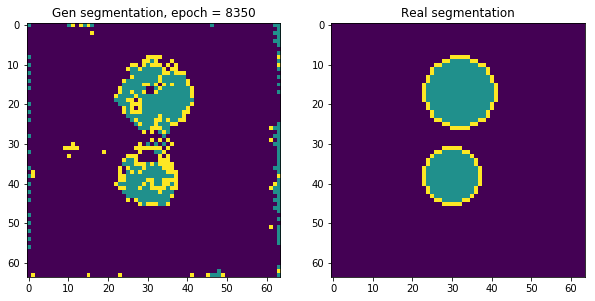

epoch - 8350, loss - 0.00650885142386
epoch - 8351, loss - 0.00623698998243
epoch - 8352, loss - 0.00640306854621
epoch - 8353, loss - 0.00655106641352
epoch - 8354, loss - 0.00667242892087
epoch - 8355, loss - 0.00632180226967
epoch - 8356, loss - 0.00580846890807
epoch - 8357, loss - 0.00548598309979
epoch - 8358, loss - 0.00553030800074
epoch - 8359, loss - 0.00589863862842
epoch - 8360, loss - 0.00602715089917
epoch - 8361, loss - 0.00598954455927
epoch - 8362, loss - 0.00574104953557
epoch - 8363, loss - 0.00576609419659
epoch - 8364, loss - 0.00623797811568
epoch - 8365, loss - 0.00696695409715
epoch - 8366, loss - 0.00776226911694
epoch - 8367, loss - 0.00814042799175
epoch - 8368, loss - 0.0085052959621
epoch - 8369, loss - 0.00878164358437
epoch - 8370, loss - 0.00934228673577
epoch - 8371, loss - 0.0101086851209
epoch - 8372, loss - 0.00999527890235
epoch - 8373, loss - 0.00932932738215
epoch - 8374, loss - 0.0081627573818
epoch - 8375, loss - 0.00792019069195
epoch - 8376, l

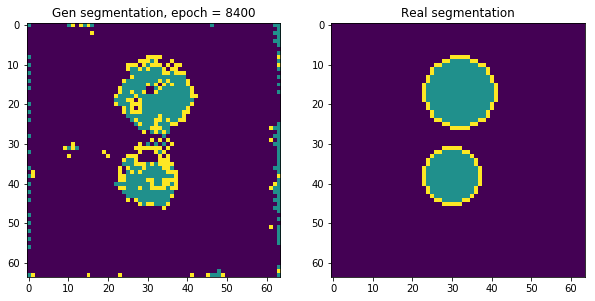

epoch - 8400, loss - 0.019078085199
epoch - 8401, loss - 0.0206689313054
epoch - 8402, loss - 0.018395325169
epoch - 8403, loss - 0.0188050549477
epoch - 8404, loss - 0.0197346359491
epoch - 8405, loss - 0.0172945652157
epoch - 8406, loss - 0.0153558095917
epoch - 8407, loss - 0.0143547747284
epoch - 8408, loss - 0.0122231142595
epoch - 8409, loss - 0.0104751568288
epoch - 8410, loss - 0.0103135015815
epoch - 8411, loss - 0.0102632483467
epoch - 8412, loss - 0.0100408392027
epoch - 8413, loss - 0.0105623342097
epoch - 8414, loss - 0.0102446097881
epoch - 8415, loss - 0.0102058341727
epoch - 8416, loss - 0.0105318650603
epoch - 8417, loss - 0.0112194512039
epoch - 8418, loss - 0.0111284451559
epoch - 8419, loss - 0.0108944699168
epoch - 8420, loss - 0.0107510620728
epoch - 8421, loss - 0.0105337975547
epoch - 8422, loss - 0.00997614394873
epoch - 8423, loss - 0.00930704828352
epoch - 8424, loss - 0.00884090363979
epoch - 8425, loss - 0.00822834856808
epoch - 8426, loss - 0.0076915891841

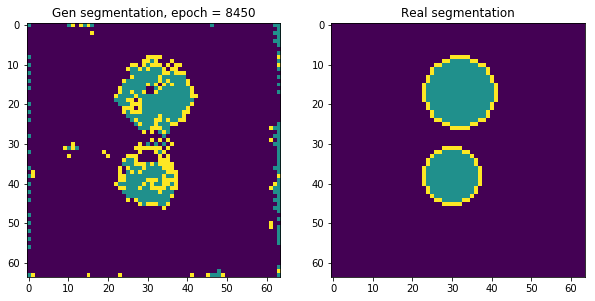

epoch - 8450, loss - 0.0486446619034
epoch - 8451, loss - 0.0680034682155
epoch - 8452, loss - 0.093626268208
epoch - 8453, loss - 0.112192176282
epoch - 8454, loss - 0.121575452387
epoch - 8455, loss - 0.0972751155496
epoch - 8456, loss - 0.056120634079
epoch - 8457, loss - 0.0174989309162
epoch - 8458, loss - 0.0114050973207
epoch - 8459, loss - 0.0336743965745
epoch - 8460, loss - 0.0535318553448
epoch - 8461, loss - 0.0485179573298
epoch - 8462, loss - 0.0238780863583
epoch - 8463, loss - 0.00920663680881
epoch - 8464, loss - 0.0168206505477
epoch - 8465, loss - 0.0309850852937
epoch - 8466, loss - 0.0308758933097
epoch - 8467, loss - 0.017105974257
epoch - 8468, loss - 0.0081541724503
epoch - 8469, loss - 0.0120075978339
epoch - 8470, loss - 0.0192087590694
epoch - 8471, loss - 0.0183388162404
epoch - 8472, loss - 0.0116973090917
epoch - 8473, loss - 0.00839084107429
epoch - 8474, loss - 0.00998250208795
epoch - 8475, loss - 0.0122959688306
epoch - 8476, loss - 0.0115759642795
epo

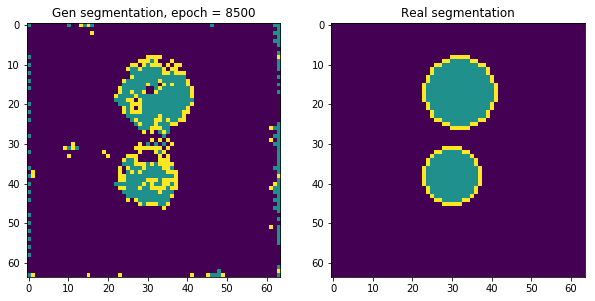

epoch - 8500, loss - 0.00400901306421
epoch - 8501, loss - 0.00392099935561
epoch - 8502, loss - 0.00405065296218
epoch - 8503, loss - 0.00410582078621
epoch - 8504, loss - 0.00405074097216
epoch - 8505, loss - 0.0040183942765
epoch - 8506, loss - 0.00399722531438
epoch - 8507, loss - 0.00405150139704
epoch - 8508, loss - 0.00406641699374
epoch - 8509, loss - 0.00418302929029
epoch - 8510, loss - 0.00438560871407
epoch - 8511, loss - 0.00457131583244
epoch - 8512, loss - 0.00464293267578
epoch - 8513, loss - 0.00467261113226
epoch - 8514, loss - 0.00467900373042
epoch - 8515, loss - 0.00466619525105
epoch - 8516, loss - 0.00453564990312
epoch - 8517, loss - 0.00434098299593
epoch - 8518, loss - 0.00415859092027
epoch - 8519, loss - 0.00404925178736
epoch - 8520, loss - 0.00399499665946
epoch - 8521, loss - 0.00406122859567
epoch - 8522, loss - 0.00426643481478
epoch - 8523, loss - 0.00462182750925
epoch - 8524, loss - 0.00507573969662
epoch - 8525, loss - 0.00554275140166
epoch - 8526,

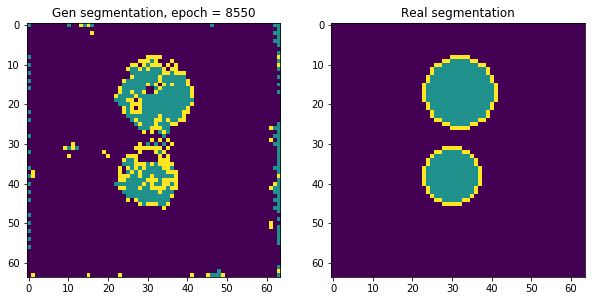

epoch - 8550, loss - 0.00643651746213
epoch - 8551, loss - 0.00562242418528
epoch - 8552, loss - 0.00543644884601
epoch - 8553, loss - 0.00579559104517
epoch - 8554, loss - 0.00614877324551
epoch - 8555, loss - 0.00589744467288
epoch - 8556, loss - 0.00523080118001
epoch - 8557, loss - 0.00451638828963
epoch - 8558, loss - 0.00433891266584
epoch - 8559, loss - 0.00459093973041
epoch - 8560, loss - 0.00474969204515
epoch - 8561, loss - 0.00458757579327
epoch - 8562, loss - 0.00418338738382
epoch - 8563, loss - 0.00391269475222
epoch - 8564, loss - 0.00396054983139
epoch - 8565, loss - 0.00409610383213
epoch - 8566, loss - 0.00406068284065
epoch - 8567, loss - 0.00381351984106
epoch - 8568, loss - 0.00356439198367
epoch - 8569, loss - 0.00348887033761
epoch - 8570, loss - 0.00355934491381
epoch - 8571, loss - 0.00362159498036
epoch - 8572, loss - 0.00356282619759
epoch - 8573, loss - 0.00341854384169
epoch - 8574, loss - 0.00330792041495
epoch - 8575, loss - 0.00330097880214
epoch - 8576

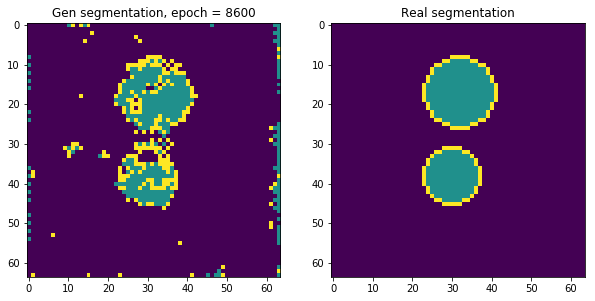

epoch - 8600, loss - 0.0904728993773
epoch - 8601, loss - 0.0971578508615
epoch - 8602, loss - 0.109555177391
epoch - 8603, loss - 0.0869382545352
epoch - 8604, loss - 0.0417516976595
epoch - 8605, loss - 0.057040233165
epoch - 8606, loss - 0.0802075639367
epoch - 8607, loss - 0.0571600273252
epoch - 8608, loss - 0.0398579612374
epoch - 8609, loss - 0.0394296534359
epoch - 8610, loss - 0.0467386990786
epoch - 8611, loss - 0.0453213006258
epoch - 8612, loss - 0.0332429930568
epoch - 8613, loss - 0.0264906994998
epoch - 8614, loss - 0.0322014130652
epoch - 8615, loss - 0.0342915207148
epoch - 8616, loss - 0.0264028683305
epoch - 8617, loss - 0.0228507947177
epoch - 8618, loss - 0.0232407040894
epoch - 8619, loss - 0.0250680111349
epoch - 8620, loss - 0.0231882724911
epoch - 8621, loss - 0.0180184487253
epoch - 8622, loss - 0.0165827330202
epoch - 8623, loss - 0.0183169171214
epoch - 8624, loss - 0.0176226198673
epoch - 8625, loss - 0.015068937093
epoch - 8626, loss - 0.0131786949933
epoc

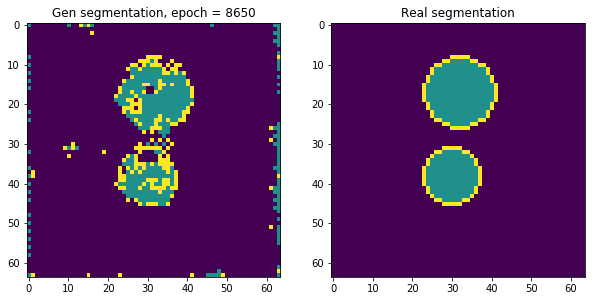

epoch - 8650, loss - 0.00537885120139
epoch - 8651, loss - 0.00519926007837
epoch - 8652, loss - 0.00499456748366
epoch - 8653, loss - 0.00483262725174
epoch - 8654, loss - 0.00476524792612
epoch - 8655, loss - 0.00475319288671
epoch - 8656, loss - 0.00482625840232
epoch - 8657, loss - 0.00480984337628
epoch - 8658, loss - 0.00476160040125
epoch - 8659, loss - 0.00482783932239
epoch - 8660, loss - 0.00489328801632
epoch - 8661, loss - 0.0050208652392
epoch - 8662, loss - 0.00519921351224
epoch - 8663, loss - 0.00538443680853
epoch - 8664, loss - 0.00549955153838
epoch - 8665, loss - 0.00564918201417
epoch - 8666, loss - 0.00565622746944
epoch - 8667, loss - 0.00556560792029
epoch - 8668, loss - 0.00524645205587
epoch - 8669, loss - 0.00485643092543
epoch - 8670, loss - 0.00454171653837
epoch - 8671, loss - 0.00444991746917
epoch - 8672, loss - 0.00459246803075
epoch - 8673, loss - 0.00475682597607
epoch - 8674, loss - 0.00524720735848
epoch - 8675, loss - 0.00533638056368
epoch - 8676,

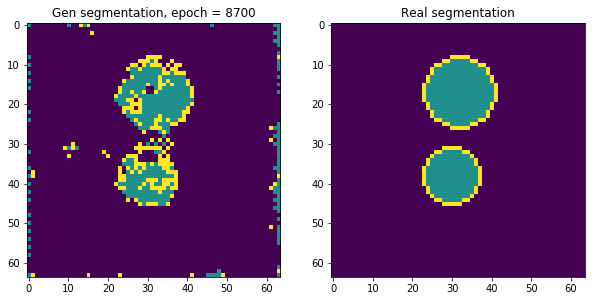

epoch - 8700, loss - 0.00503806211054
epoch - 8701, loss - 0.00504233781248
epoch - 8702, loss - 0.00500537920743
epoch - 8703, loss - 0.0048900693655
epoch - 8704, loss - 0.00472726579756
epoch - 8705, loss - 0.0045121172443
epoch - 8706, loss - 0.00436061434448
epoch - 8707, loss - 0.00422726990655
epoch - 8708, loss - 0.00426410557702
epoch - 8709, loss - 0.00438280776143
epoch - 8710, loss - 0.00451999530196
epoch - 8711, loss - 0.00454380363226
epoch - 8712, loss - 0.00451204180717
epoch - 8713, loss - 0.00436843372881
epoch - 8714, loss - 0.00429298728704
epoch - 8715, loss - 0.00439980998635
epoch - 8716, loss - 0.00461617531255
epoch - 8717, loss - 0.00490363547578
epoch - 8718, loss - 0.00498902518302
epoch - 8719, loss - 0.00496159587055
epoch - 8720, loss - 0.00480663217604
epoch - 8721, loss - 0.0048023792915
epoch - 8722, loss - 0.00511283287778
epoch - 8723, loss - 0.00561291351914
epoch - 8724, loss - 0.00625265436247
epoch - 8725, loss - 0.00661134487018
epoch - 8726, l

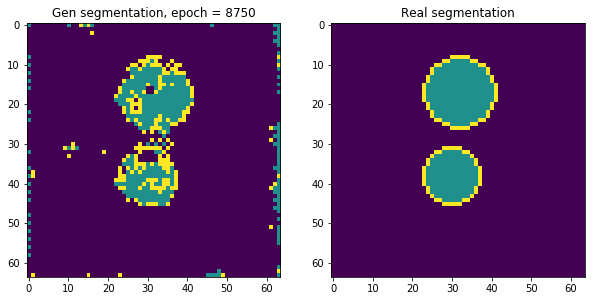

epoch - 8750, loss - 0.0609493255615
epoch - 8751, loss - 0.0695811659098
epoch - 8752, loss - 0.0692434310913
epoch - 8753, loss - 0.0635091513395
epoch - 8754, loss - 0.05338793993
epoch - 8755, loss - 0.0406595394015
epoch - 8756, loss - 0.0215601995587
epoch - 8757, loss - 0.0133957974613
epoch - 8758, loss - 0.0237858314067
epoch - 8759, loss - 0.0334897376597
epoch - 8760, loss - 0.0289813987911
epoch - 8761, loss - 0.0208308976144
epoch - 8762, loss - 0.0182272456586
epoch - 8763, loss - 0.0146793145686
epoch - 8764, loss - 0.0116154830903
epoch - 8765, loss - 0.0139303551987
epoch - 8766, loss - 0.0166063867509
epoch - 8767, loss - 0.0139369424433
epoch - 8768, loss - 0.0115624535829
epoch - 8769, loss - 0.0110120885074
epoch - 8770, loss - 0.0088158659637
epoch - 8771, loss - 0.00845342315733
epoch - 8772, loss - 0.00965780951083
epoch - 8773, loss - 0.00841426663101
epoch - 8774, loss - 0.00784265249968
epoch - 8775, loss - 0.00829254928976
epoch - 8776, loss - 0.007183058187

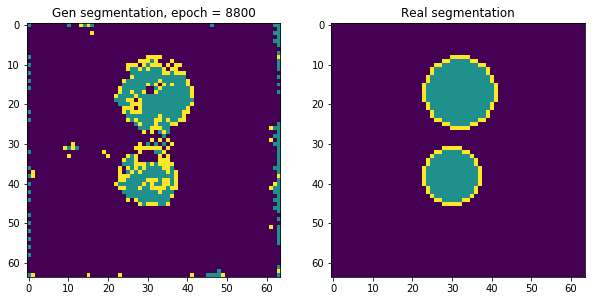

epoch - 8800, loss - 0.00343812908977
epoch - 8801, loss - 0.0034480849281
epoch - 8802, loss - 0.00337901245803
epoch - 8803, loss - 0.00331215281039
epoch - 8804, loss - 0.00327463168651
epoch - 8805, loss - 0.00320409238338
epoch - 8806, loss - 0.0031459974125
epoch - 8807, loss - 0.00312118139118
epoch - 8808, loss - 0.00308926962316
epoch - 8809, loss - 0.00307103758678
epoch - 8810, loss - 0.00306119630113
epoch - 8811, loss - 0.00304022384807
epoch - 8812, loss - 0.00303664454259
epoch - 8813, loss - 0.00304815988056
epoch - 8814, loss - 0.00307979434729
epoch - 8815, loss - 0.0031179736834
epoch - 8816, loss - 0.00319086480886
epoch - 8817, loss - 0.00330807548016
epoch - 8818, loss - 0.0034945118241
epoch - 8819, loss - 0.00384580623358
epoch - 8820, loss - 0.00442060548812
epoch - 8821, loss - 0.00495273247361
epoch - 8822, loss - 0.00575356651098
epoch - 8823, loss - 0.0068004084751
epoch - 8824, loss - 0.0083134425804
epoch - 8825, loss - 0.00968763977289
epoch - 8826, loss

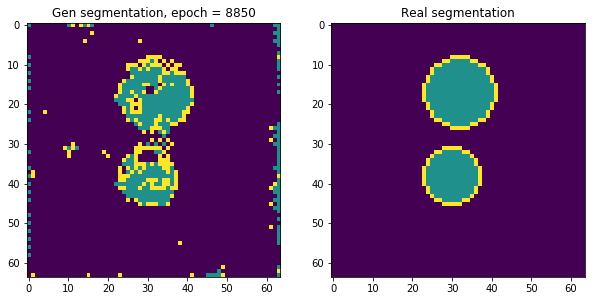

epoch - 8850, loss - 0.020374013111
epoch - 8851, loss - 0.0146549213678
epoch - 8852, loss - 0.0109924506396
epoch - 8853, loss - 0.0115964449942
epoch - 8854, loss - 0.0143609642982
epoch - 8855, loss - 0.015290889889
epoch - 8856, loss - 0.0130533892661
epoch - 8857, loss - 0.0101807145402
epoch - 8858, loss - 0.00863951258361
epoch - 8859, loss - 0.00820500124246
epoch - 8860, loss - 0.00763229466975
epoch - 8861, loss - 0.00731149595231
epoch - 8862, loss - 0.00818518549204
epoch - 8863, loss - 0.00838773418218
epoch - 8864, loss - 0.0071580321528
epoch - 8865, loss - 0.00586056616157
epoch - 8866, loss - 0.00559542840347
epoch - 8867, loss - 0.00546166487038
epoch - 8868, loss - 0.00478469859809
epoch - 8869, loss - 0.0046862596646
epoch - 8870, loss - 0.00538443075493
epoch - 8871, loss - 0.00543007813394
epoch - 8872, loss - 0.00472174491733
epoch - 8873, loss - 0.00440448150039
epoch - 8874, loss - 0.00443404074758
epoch - 8875, loss - 0.00403195479885
epoch - 8876, loss - 0.0

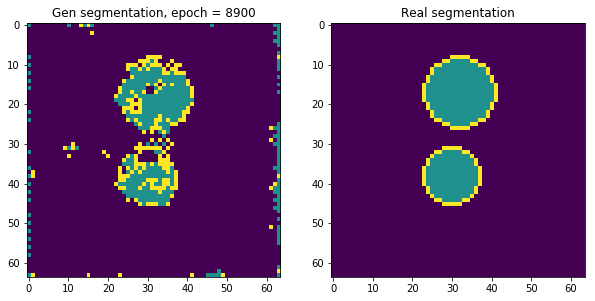

epoch - 8900, loss - 0.00340667227283
epoch - 8901, loss - 0.00367098790593
epoch - 8902, loss - 0.00398643873632
epoch - 8903, loss - 0.00435522571206
epoch - 8904, loss - 0.00466540735215
epoch - 8905, loss - 0.00493782944977
epoch - 8906, loss - 0.00495377276093
epoch - 8907, loss - 0.00470274686813
epoch - 8908, loss - 0.00428350036964
epoch - 8909, loss - 0.00395546574146
epoch - 8910, loss - 0.00392286898568
epoch - 8911, loss - 0.00414556916803
epoch - 8912, loss - 0.00453956890851
epoch - 8913, loss - 0.00481975078583
epoch - 8914, loss - 0.00498631875962
epoch - 8915, loss - 0.00483732530847
epoch - 8916, loss - 0.00460083642974
epoch - 8917, loss - 0.00454762671143
epoch - 8918, loss - 0.00495456811041
epoch - 8919, loss - 0.00589180085808
epoch - 8920, loss - 0.00712154386565
epoch - 8921, loss - 0.00884815398604
epoch - 8922, loss - 0.0111398436129
epoch - 8923, loss - 0.0147609161213
epoch - 8924, loss - 0.020046889782
epoch - 8925, loss - 0.028760265559
epoch - 8926, loss

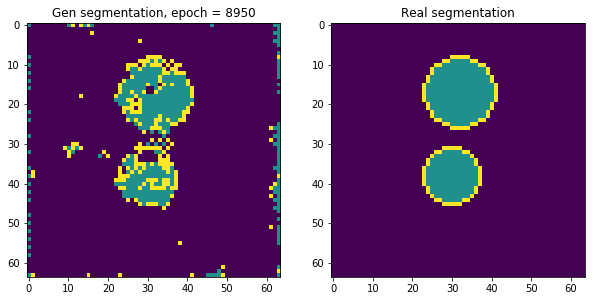

epoch - 8950, loss - 0.00704434420913
epoch - 8951, loss - 0.00795925129205
epoch - 8952, loss - 0.00852398015559
epoch - 8953, loss - 0.00725460983813
epoch - 8954, loss - 0.00680200057104
epoch - 8955, loss - 0.00751072028652
epoch - 8956, loss - 0.00684485817328
epoch - 8957, loss - 0.00518426951021
epoch - 8958, loss - 0.0048674531281
epoch - 8959, loss - 0.00557128060609
epoch - 8960, loss - 0.00550902169198
epoch - 8961, loss - 0.00485811568797
epoch - 8962, loss - 0.00479624047875
epoch - 8963, loss - 0.00468398910016
epoch - 8964, loss - 0.00394771853462
epoch - 8965, loss - 0.00356650655158
epoch - 8966, loss - 0.00407656375319
epoch - 8967, loss - 0.00437730737031
epoch - 8968, loss - 0.00386027013883
epoch - 8969, loss - 0.00341267185286
epoch - 8970, loss - 0.00352266174741
epoch - 8971, loss - 0.00361224077642
epoch - 8972, loss - 0.0033331271261
epoch - 8973, loss - 0.00317974574864
epoch - 8974, loss - 0.00338178360835
epoch - 8975, loss - 0.00348873296753
epoch - 8976, 

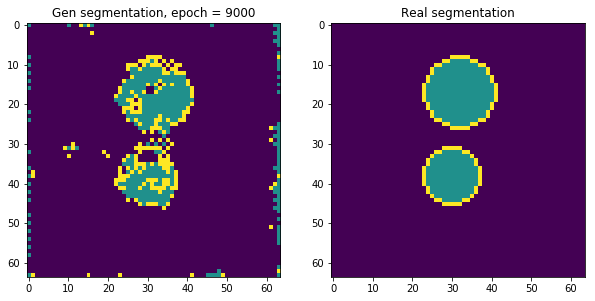

epoch - 9000, loss - 0.0028975228779
epoch - 9001, loss - 0.00297731207684
epoch - 9002, loss - 0.00305290240794
epoch - 9003, loss - 0.0030899560079
epoch - 9004, loss - 0.00307302176952
epoch - 9005, loss - 0.00301577989012
epoch - 9006, loss - 0.00290049845353
epoch - 9007, loss - 0.0027986462228
epoch - 9008, loss - 0.00273727951571
epoch - 9009, loss - 0.00273122428916
epoch - 9010, loss - 0.0027846833691
epoch - 9011, loss - 0.00288791162893
epoch - 9012, loss - 0.00303812790662
epoch - 9013, loss - 0.00323025323451
epoch - 9014, loss - 0.00341173447669
epoch - 9015, loss - 0.00360267469659
epoch - 9016, loss - 0.00377562362701
epoch - 9017, loss - 0.00398078886792
epoch - 9018, loss - 0.00405240384862
epoch - 9019, loss - 0.00403856113553
epoch - 9020, loss - 0.00392150133848
epoch - 9021, loss - 0.00396412936971
epoch - 9022, loss - 0.00394743774086
epoch - 9023, loss - 0.00398346595466
epoch - 9024, loss - 0.00409260066226
epoch - 9025, loss - 0.00447738077492
epoch - 9026, lo

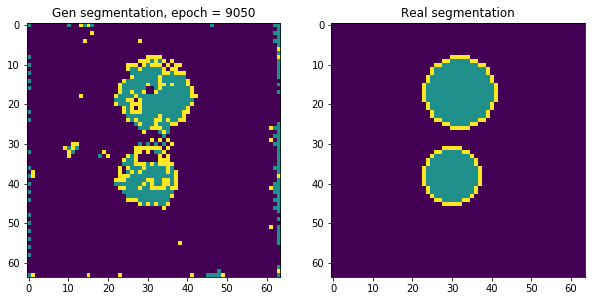

epoch - 9050, loss - 0.0383225306869
epoch - 9051, loss - 0.0258266292512
epoch - 9052, loss - 0.02875383012
epoch - 9053, loss - 0.040118124336
epoch - 9054, loss - 0.035919200629
epoch - 9055, loss - 0.0256151817739
epoch - 9056, loss - 0.025472054258
epoch - 9057, loss - 0.0224384535104
epoch - 9058, loss - 0.0158577039838
epoch - 9059, loss - 0.0178146585822
epoch - 9060, loss - 0.0219557210803
epoch - 9061, loss - 0.0192730501294
epoch - 9062, loss - 0.0166665054858
epoch - 9063, loss - 0.0163527689874
epoch - 9064, loss - 0.0130574479699
epoch - 9065, loss - 0.0103515926749
epoch - 9066, loss - 0.0112902149558
epoch - 9067, loss - 0.0115665644407
epoch - 9068, loss - 0.010562973097
epoch - 9069, loss - 0.0107064489275
epoch - 9070, loss - 0.0100023979321
epoch - 9071, loss - 0.00813324004412
epoch - 9072, loss - 0.00744981784374
epoch - 9073, loss - 0.00711997551844
epoch - 9074, loss - 0.00650999136269
epoch - 9075, loss - 0.00674149161205
epoch - 9076, loss - 0.00718872528523
e

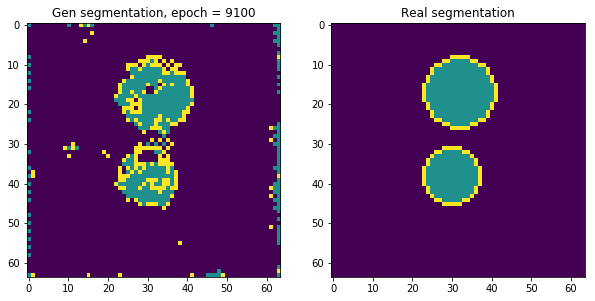

epoch - 9100, loss - 0.00374209415168
epoch - 9101, loss - 0.00365143176168
epoch - 9102, loss - 0.0035735196434
epoch - 9103, loss - 0.00352233182639
epoch - 9104, loss - 0.00346617400646
epoch - 9105, loss - 0.00341126089916
epoch - 9106, loss - 0.00337376422249
epoch - 9107, loss - 0.00334985181689
epoch - 9108, loss - 0.00333285634406
epoch - 9109, loss - 0.00333647825755
epoch - 9110, loss - 0.00334879010916
epoch - 9111, loss - 0.00338243995793
epoch - 9112, loss - 0.00343955075368
epoch - 9113, loss - 0.00354322651401
epoch - 9114, loss - 0.00371432374232
epoch - 9115, loss - 0.00397549383342
epoch - 9116, loss - 0.00439230212942
epoch - 9117, loss - 0.00498939072713
epoch - 9118, loss - 0.00593855092302
epoch - 9119, loss - 0.00729593122378
epoch - 9120, loss - 0.00938045606017
epoch - 9121, loss - 0.0124419042841
epoch - 9122, loss - 0.0172080546618
epoch - 9123, loss - 0.0238569807261
epoch - 9124, loss - 0.0339629612863
epoch - 9125, loss - 0.0464754551649
epoch - 9126, loss

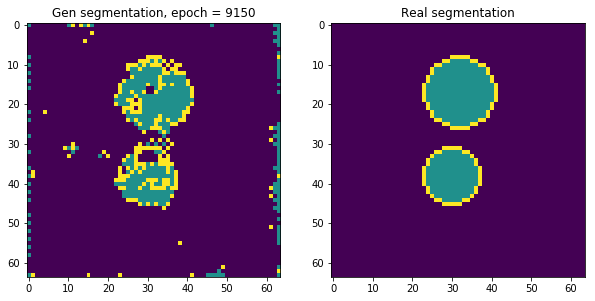

epoch - 9150, loss - 0.00624384963885
epoch - 9151, loss - 0.00826228223741
epoch - 9152, loss - 0.00887549482286
epoch - 9153, loss - 0.00734987668693
epoch - 9154, loss - 0.00567854614928
epoch - 9155, loss - 0.0052157593891
epoch - 9156, loss - 0.00556844146922
epoch - 9157, loss - 0.00576119264588
epoch - 9158, loss - 0.00542625738308
epoch - 9159, loss - 0.00495443027467
epoch - 9160, loss - 0.00476024951786
epoch - 9161, loss - 0.00467280857265
epoch - 9162, loss - 0.00466962903738
epoch - 9163, loss - 0.00457338010892
epoch - 9164, loss - 0.00602132407948
epoch - 9165, loss - 0.00647238781676
epoch - 9166, loss - 0.00611520372331
epoch - 9167, loss - 0.00642785802484
epoch - 9168, loss - 0.00599626637995
epoch - 9169, loss - 0.00546150840819
epoch - 9170, loss - 0.00553801748902
epoch - 9171, loss - 0.00579268764704
epoch - 9172, loss - 0.00558332493529
epoch - 9173, loss - 0.00519433664158
epoch - 9174, loss - 0.00478226272389
epoch - 9175, loss - 0.00464279996231
epoch - 9176,

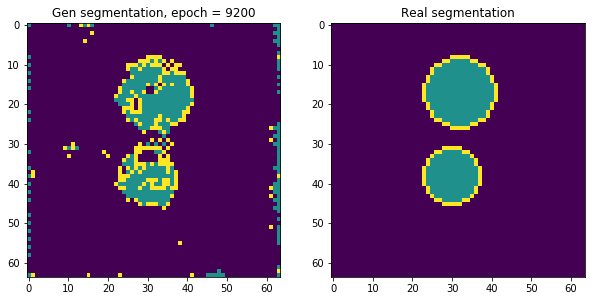

epoch - 9200, loss - 0.00466092955321
epoch - 9201, loss - 0.0046148635447
epoch - 9202, loss - 0.00421400880441
epoch - 9203, loss - 0.0038223688025
epoch - 9204, loss - 0.00352632813156
epoch - 9205, loss - 0.00348177878186
epoch - 9206, loss - 0.00367431621999
epoch - 9207, loss - 0.00391627242789
epoch - 9208, loss - 0.00418898044154
epoch - 9209, loss - 0.00419801846147
epoch - 9210, loss - 0.00408398732543
epoch - 9211, loss - 0.00365780340508
epoch - 9212, loss - 0.00330303912051
epoch - 9213, loss - 0.00309973745607
epoch - 9214, loss - 0.00310459267348
epoch - 9215, loss - 0.00325008481741
epoch - 9216, loss - 0.00338466209359
epoch - 9217, loss - 0.00350303016603
epoch - 9218, loss - 0.0034746483434
epoch - 9219, loss - 0.00334417051636
epoch - 9220, loss - 0.00316363130696
epoch - 9221, loss - 0.00306234555319
epoch - 9222, loss - 0.00317269004881
epoch - 9223, loss - 0.00344409816898
epoch - 9224, loss - 0.0038214828819
epoch - 9225, loss - 0.00411311443895
epoch - 9226, lo

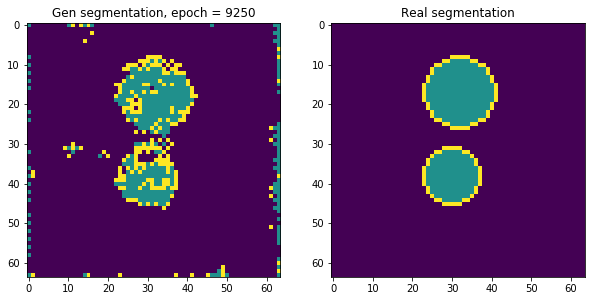

epoch - 9250, loss - 0.0550571829081
epoch - 9251, loss - 0.0689002647996
epoch - 9252, loss - 0.068382166326
epoch - 9253, loss - 0.0540498904884
epoch - 9254, loss - 0.0710413455963
epoch - 9255, loss - 0.0552306175232
epoch - 9256, loss - 0.0363175645471
epoch - 9257, loss - 0.0473203472793
epoch - 9258, loss - 0.0362902916968
epoch - 9259, loss - 0.0394689291716
epoch - 9260, loss - 0.0430050715804
epoch - 9261, loss - 0.0328098498285
epoch - 9262, loss - 0.0376637391746
epoch - 9263, loss - 0.0286728441715
epoch - 9264, loss - 0.0275088194758
epoch - 9265, loss - 0.0291245747358
epoch - 9266, loss - 0.0251222550869
epoch - 9267, loss - 0.0274709220976
epoch - 9268, loss - 0.0242614895105
epoch - 9269, loss - 0.0224014297128
epoch - 9270, loss - 0.0214802622795
epoch - 9271, loss - 0.0183633975685
epoch - 9272, loss - 0.0183988846838
epoch - 9273, loss - 0.0163312405348
epoch - 9274, loss - 0.0157786868513
epoch - 9275, loss - 0.0155087830499
epoch - 9276, loss - 0.0143523775041
ep

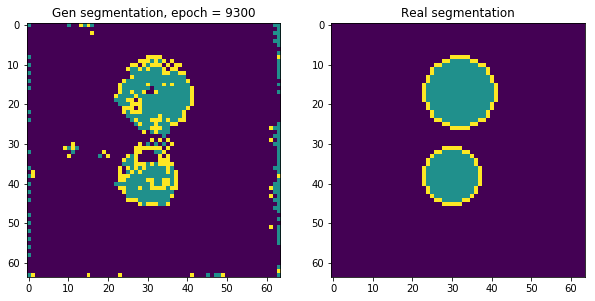

epoch - 9300, loss - 0.00476542394608
epoch - 9301, loss - 0.00464540719986
epoch - 9302, loss - 0.00450388155878
epoch - 9303, loss - 0.00439491262659
epoch - 9304, loss - 0.00430667167529
epoch - 9305, loss - 0.00423085410148
epoch - 9306, loss - 0.00418564397842
epoch - 9307, loss - 0.00414756312966
epoch - 9308, loss - 0.00419225078076
epoch - 9309, loss - 0.00423162383959
epoch - 9310, loss - 0.00439224811271
epoch - 9311, loss - 0.00469148717821
epoch - 9312, loss - 0.00514811230823
epoch - 9313, loss - 0.00595130957663
epoch - 9314, loss - 0.00723962299526
epoch - 9315, loss - 0.00936834514141
epoch - 9316, loss - 0.0127329900861
epoch - 9317, loss - 0.0183476824313
epoch - 9318, loss - 0.0267765000463
epoch - 9319, loss - 0.04033684358
epoch - 9320, loss - 0.0581285506487
epoch - 9321, loss - 0.0829215422273
epoch - 9322, loss - 0.103303514421
epoch - 9323, loss - 0.116779871285
epoch - 9324, loss - 0.0975209474564
epoch - 9325, loss - 0.0578149631619
epoch - 9326, loss - 0.016

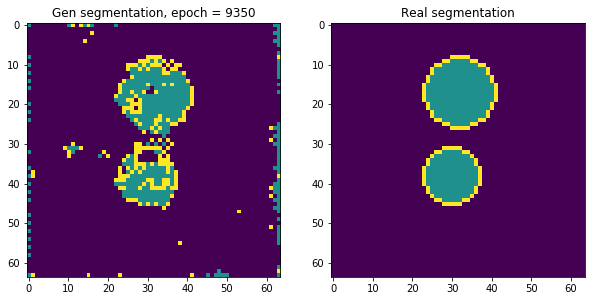

epoch - 9350, loss - 0.00651780422777
epoch - 9351, loss - 0.00445206928998
epoch - 9352, loss - 0.00465457234532
epoch - 9353, loss - 0.00590598909184
epoch - 9354, loss - 0.00597653305158
epoch - 9355, loss - 0.00476995483041
epoch - 9356, loss - 0.0039323088713
epoch - 9357, loss - 0.00420906115323
epoch - 9358, loss - 0.00475304061547
epoch - 9359, loss - 0.00459438562393
epoch - 9360, loss - 0.00389469205402
epoch - 9361, loss - 0.00353933358565
epoch - 9362, loss - 0.00377183221281
epoch - 9363, loss - 0.00401547644287
epoch - 9364, loss - 0.0038060778752
epoch - 9365, loss - 0.00337566528469
epoch - 9366, loss - 0.00325540592894
epoch - 9367, loss - 0.00348865054548
epoch - 9368, loss - 0.00354778813198
epoch - 9369, loss - 0.00337434187531
epoch - 9370, loss - 0.00312593951821
epoch - 9371, loss - 0.00310749467462
epoch - 9372, loss - 0.00322424247861
epoch - 9373, loss - 0.0032699550502
epoch - 9374, loss - 0.0031653912738
epoch - 9375, loss - 0.00302337156609
epoch - 9376, lo

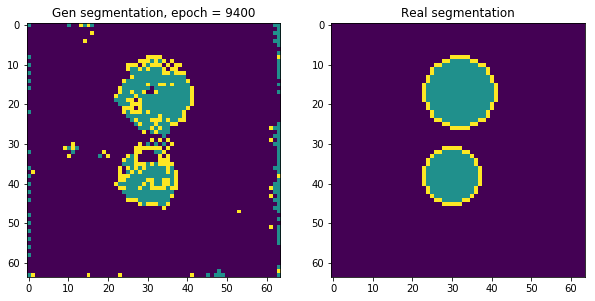

epoch - 9400, loss - 0.00469045434147
epoch - 9401, loss - 0.00431712158024
epoch - 9402, loss - 0.00425230804831
epoch - 9403, loss - 0.00450312998146
epoch - 9404, loss - 0.0047970158048
epoch - 9405, loss - 0.00498945871368
epoch - 9406, loss - 0.0049226670526
epoch - 9407, loss - 0.00441682012752
epoch - 9408, loss - 0.0041277478449
epoch - 9409, loss - 0.00394248683006
epoch - 9410, loss - 0.00413733627647
epoch - 9411, loss - 0.00431649852544
epoch - 9412, loss - 0.00404969416559
epoch - 9413, loss - 0.00354652618989
epoch - 9414, loss - 0.00321854883805
epoch - 9415, loss - 0.00317120994441
epoch - 9416, loss - 0.00339860003442
epoch - 9417, loss - 0.0035496247001
epoch - 9418, loss - 0.00344489840791
epoch - 9419, loss - 0.0031796223484
epoch - 9420, loss - 0.00300664850511
epoch - 9421, loss - 0.00301054585725
epoch - 9422, loss - 0.00308874459006
epoch - 9423, loss - 0.00308553595096
epoch - 9424, loss - 0.00297411950305
epoch - 9425, loss - 0.00283744884655
epoch - 9426, los

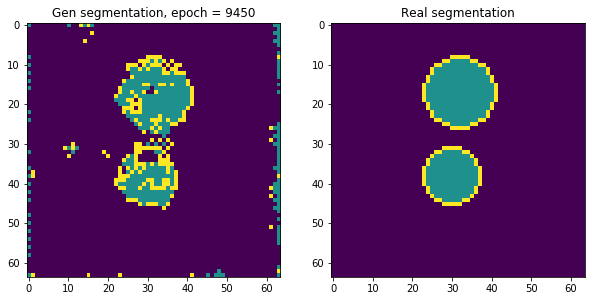

epoch - 9450, loss - 0.00842322874814
epoch - 9451, loss - 0.0101506626233
epoch - 9452, loss - 0.0122075472027
epoch - 9453, loss - 0.0149833103642
epoch - 9454, loss - 0.0181493964046
epoch - 9455, loss - 0.0223526582122
epoch - 9456, loss - 0.0267209950835
epoch - 9457, loss - 0.0322405658662
epoch - 9458, loss - 0.037096016109
epoch - 9459, loss - 0.04234386608
epoch - 9460, loss - 0.0453787595034
epoch - 9461, loss - 0.0464533418417
epoch - 9462, loss - 0.0415234528482
epoch - 9463, loss - 0.0300689823925
epoch - 9464, loss - 0.0157813485712
epoch - 9465, loss - 0.011998240836
epoch - 9466, loss - 0.0225526746362
epoch - 9467, loss - 0.0312015786767
epoch - 9468, loss - 0.0281070899218
epoch - 9469, loss - 0.0207260474563
epoch - 9470, loss - 0.0196589194238
epoch - 9471, loss - 0.0183226652443
epoch - 9472, loss - 0.0108263865113
epoch - 9473, loss - 0.00745595665649
epoch - 9474, loss - 0.0122823994607
epoch - 9475, loss - 0.0136470813304
epoch - 9476, loss - 0.0103863663971
epo

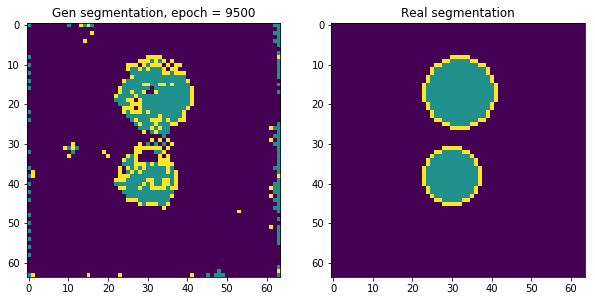

epoch - 9500, loss - 0.00304500712082
epoch - 9501, loss - 0.00302382884547
epoch - 9502, loss - 0.00307914055884
epoch - 9503, loss - 0.00286505231634
epoch - 9504, loss - 0.00272817001678
epoch - 9505, loss - 0.00280077522621
epoch - 9506, loss - 0.00279166037217
epoch - 9507, loss - 0.002670888789
epoch - 9508, loss - 0.00266647618264
epoch - 9509, loss - 0.00271084858105
epoch - 9510, loss - 0.00263487151824
epoch - 9511, loss - 0.00257368013263
epoch - 9512, loss - 0.00264571188018
epoch - 9513, loss - 0.00266090268269
epoch - 9514, loss - 0.00258097215556
epoch - 9515, loss - 0.00257789622992
epoch - 9516, loss - 0.00261837453581
epoch - 9517, loss - 0.00262153963558
epoch - 9518, loss - 0.00263237487525
epoch - 9519, loss - 0.00271735317074
epoch - 9520, loss - 0.00282664271072
epoch - 9521, loss - 0.00295402179472
epoch - 9522, loss - 0.00316770980135
epoch - 9523, loss - 0.00350759248249
epoch - 9524, loss - 0.00400233548135
epoch - 9525, loss - 0.00472361641005
epoch - 9526, 

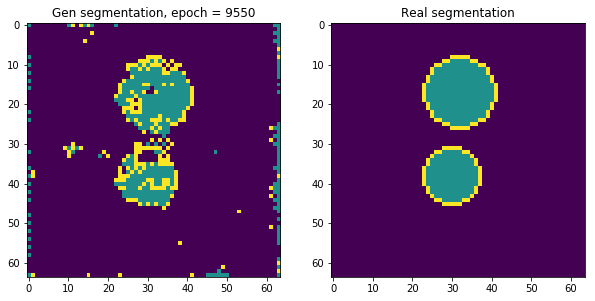

epoch - 9550, loss - 0.0221996549517
epoch - 9551, loss - 0.0174856707454
epoch - 9552, loss - 0.010184048675
epoch - 9553, loss - 0.00799490883946
epoch - 9554, loss - 0.0110066980124
epoch - 9555, loss - 0.0134011432528
epoch - 9556, loss - 0.0129907093942
epoch - 9557, loss - 0.0107995346189
epoch - 9558, loss - 0.00870538875461
epoch - 9559, loss - 0.00747808767483
epoch - 9560, loss - 0.00706059858203
epoch - 9561, loss - 0.00766001502052
epoch - 9562, loss - 0.00853114575148
epoch - 9563, loss - 0.0084012215957
epoch - 9564, loss - 0.00712727522478
epoch - 9565, loss - 0.0058181528002
epoch - 9566, loss - 0.00550785288215
epoch - 9567, loss - 0.00575302913785
epoch - 9568, loss - 0.00644849333912
epoch - 9569, loss - 0.0104858912528
epoch - 9570, loss - 0.0115014240146
epoch - 9571, loss - 0.0146655458957
epoch - 9572, loss - 0.0144070144743
epoch - 9573, loss - 0.01391396299
epoch - 9574, loss - 0.0124990157783
epoch - 9575, loss - 0.0112429158762
epoch - 9576, loss - 0.01070243

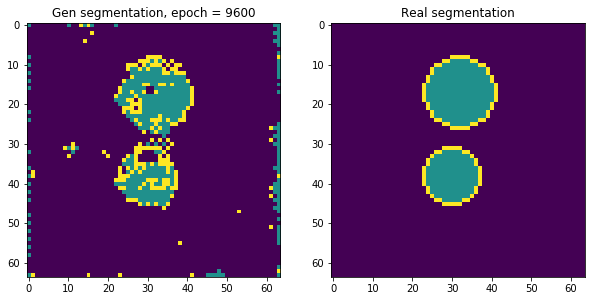

epoch - 9600, loss - 0.00344657432288
epoch - 9601, loss - 0.00338463392109
epoch - 9602, loss - 0.00332635920495
epoch - 9603, loss - 0.0032319505699
epoch - 9604, loss - 0.00313549302518
epoch - 9605, loss - 0.00306573626585
epoch - 9606, loss - 0.00300628365949
epoch - 9607, loss - 0.00296120694838
epoch - 9608, loss - 0.00299866404384
epoch - 9609, loss - 0.00303113134578
epoch - 9610, loss - 0.00303627364337
epoch - 9611, loss - 0.00298733264208
epoch - 9612, loss - 0.00290182465687
epoch - 9613, loss - 0.00283470447175
epoch - 9614, loss - 0.00281042396091
epoch - 9615, loss - 0.0027692867443
epoch - 9616, loss - 0.00270965276286
epoch - 9617, loss - 0.00265289843082
epoch - 9618, loss - 0.00261915568262
epoch - 9619, loss - 0.00260184053332
epoch - 9620, loss - 0.00257827783935
epoch - 9621, loss - 0.00254889414646
epoch - 9622, loss - 0.00252457102761
epoch - 9623, loss - 0.00251407315955
epoch - 9624, loss - 0.00249623833224
epoch - 9625, loss - 0.00249790400267
epoch - 9626, 

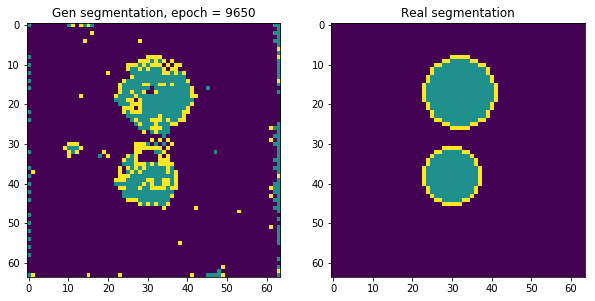

epoch - 9650, loss - 0.0434968620539
epoch - 9651, loss - 0.0576905943453
epoch - 9652, loss - 0.0468348301947
epoch - 9653, loss - 0.0200936533511
epoch - 9654, loss - 0.0108752241358
epoch - 9655, loss - 0.0223019719124
epoch - 9656, loss - 0.0315362624824
epoch - 9657, loss - 0.0260499417782
epoch - 9658, loss - 0.0150477522984
epoch - 9659, loss - 0.0130232358351
epoch - 9660, loss - 0.0167901776731
epoch - 9661, loss - 0.0171814952046
epoch - 9662, loss - 0.0144328987226
epoch - 9663, loss - 0.0127955982462
epoch - 9664, loss - 0.0122599387541
epoch - 9665, loss - 0.0113660674542
epoch - 9666, loss - 0.0103630144149
epoch - 9667, loss - 0.0106294332072
epoch - 9668, loss - 0.010494787246
epoch - 9669, loss - 0.00898273475468
epoch - 9670, loss - 0.00774636119604
epoch - 9671, loss - 0.00744601618499
epoch - 9672, loss - 0.00732045248151
epoch - 9673, loss - 0.00689063221216
epoch - 9674, loss - 0.00656698271632
epoch - 9675, loss - 0.00612587109208
epoch - 9676, loss - 0.005322213

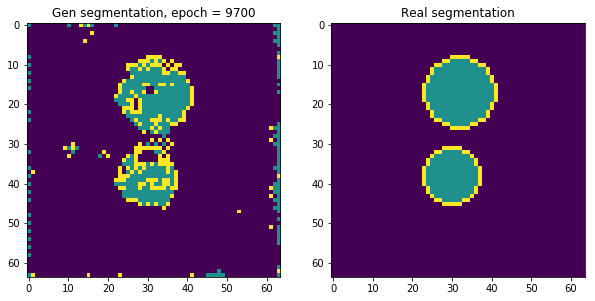

epoch - 9700, loss - 0.00255470233969
epoch - 9701, loss - 0.00254610157572
epoch - 9702, loss - 0.00254968111403
epoch - 9703, loss - 0.00250098807737
epoch - 9704, loss - 0.00245195999742
epoch - 9705, loss - 0.00244729872793
epoch - 9706, loss - 0.00243628537282
epoch - 9707, loss - 0.00240454031155
epoch - 9708, loss - 0.00239279866219
epoch - 9709, loss - 0.00240856548771
epoch - 9710, loss - 0.00242424942553
epoch - 9711, loss - 0.00243065343238
epoch - 9712, loss - 0.00246212934144
epoch - 9713, loss - 0.00251934304833
epoch - 9714, loss - 0.0025897747837
epoch - 9715, loss - 0.00267157750204
epoch - 9716, loss - 0.00280316965654
epoch - 9717, loss - 0.00295036844909
epoch - 9718, loss - 0.00315175810829
epoch - 9719, loss - 0.00330524845049
epoch - 9720, loss - 0.00344245275483
epoch - 9721, loss - 0.00346459331922
epoch - 9722, loss - 0.00341446069069
epoch - 9723, loss - 0.00323852943256
epoch - 9724, loss - 0.00301958806813
epoch - 9725, loss - 0.00277651892975
epoch - 9726,

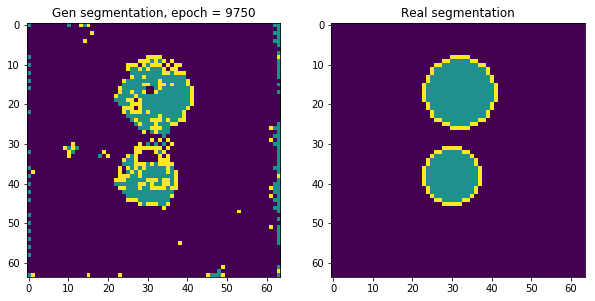

epoch - 9750, loss - 0.0198297444731
epoch - 9751, loss - 0.0146065670997
epoch - 9752, loss - 0.00889559090137
epoch - 9753, loss - 0.0099921002984
epoch - 9754, loss - 0.0150534855202
epoch - 9755, loss - 0.0174012556672
epoch - 9756, loss - 0.0150616476312
epoch - 9757, loss - 0.0128198200837
epoch - 9758, loss - 0.0148733528331
epoch - 9759, loss - 0.0190277397633
epoch - 9760, loss - 0.0224520917982
epoch - 9761, loss - 0.0258103255183
epoch - 9762, loss - 0.0306273717433
epoch - 9763, loss - 0.0356374196708
epoch - 9764, loss - 0.0407384522259
epoch - 9765, loss - 0.0417759902775
epoch - 9766, loss - 0.0381150320172
epoch - 9767, loss - 0.0309141762555
epoch - 9768, loss - 0.026392986998
epoch - 9769, loss - 0.0208978485316
epoch - 9770, loss - 0.0138731840998
epoch - 9771, loss - 0.00945128593594
epoch - 9772, loss - 0.00920416694134
epoch - 9773, loss - 0.00980727467686
epoch - 9774, loss - 0.0112612098455
epoch - 9775, loss - 0.0136751672253
epoch - 9776, loss - 0.013663585297

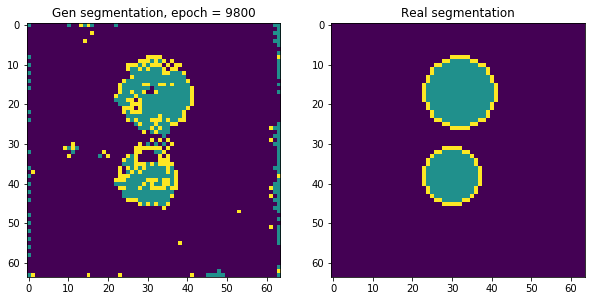

epoch - 9800, loss - 0.00340392603539
epoch - 9801, loss - 0.00314128911123
epoch - 9802, loss - 0.00299203325994
epoch - 9803, loss - 0.0028575998731
epoch - 9804, loss - 0.00264879083261
epoch - 9805, loss - 0.00245085125789
epoch - 9806, loss - 0.00240098056383
epoch - 9807, loss - 0.00238540722057
epoch - 9808, loss - 0.00232781236991
epoch - 9809, loss - 0.002321947366
epoch - 9810, loss - 0.00237100501545
epoch - 9811, loss - 0.00239233882166
epoch - 9812, loss - 0.00238849082962
epoch - 9813, loss - 0.00243247998878
epoch - 9814, loss - 0.00244756857865
epoch - 9815, loss - 0.00245817843825
epoch - 9816, loss - 0.00250267679803
epoch - 9817, loss - 0.00256421184167
epoch - 9818, loss - 0.00262092286721
epoch - 9819, loss - 0.00271051283926
epoch - 9820, loss - 0.00287695368752
epoch - 9821, loss - 0.00309965922497
epoch - 9822, loss - 0.00341879716143
epoch - 9823, loss - 0.0038563455455
epoch - 9824, loss - 0.00450307363644
epoch - 9825, loss - 0.00540250679478
epoch - 9826, lo

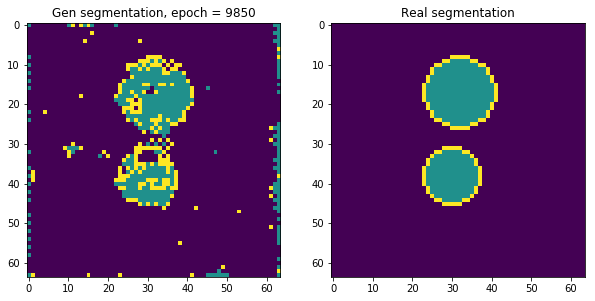

epoch - 9850, loss - 0.014125995338
epoch - 9851, loss - 0.0116446996108
epoch - 9852, loss - 0.0077026123181
epoch - 9853, loss - 0.00478404201567
epoch - 9854, loss - 0.00471182912588
epoch - 9855, loss - 0.0065724151209
epoch - 9856, loss - 0.00816902238876
epoch - 9857, loss - 0.00794710870832
epoch - 9858, loss - 0.00634768698364
epoch - 9859, loss - 0.00482464861125
epoch - 9860, loss - 0.00446346215904
epoch - 9861, loss - 0.00544290011749
epoch - 9862, loss - 0.0090996734798
epoch - 9863, loss - 0.00915266759694
epoch - 9864, loss - 0.00904008839279
epoch - 9865, loss - 0.00820409692824
epoch - 9866, loss - 0.00770632363856
epoch - 9867, loss - 0.00774704292417
epoch - 9868, loss - 0.00804490875453
epoch - 9869, loss - 0.00760938227177
epoch - 9870, loss - 0.0066642141901
epoch - 9871, loss - 0.00595298176631
epoch - 9872, loss - 0.00561893451959
epoch - 9873, loss - 0.0053692930378
epoch - 9874, loss - 0.00502933375537
epoch - 9875, loss - 0.00460585253313
epoch - 9876, loss -

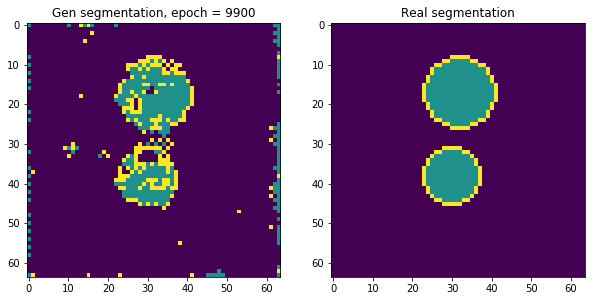

epoch - 9900, loss - 0.00428782170638
epoch - 9901, loss - 0.00472235865891
epoch - 9902, loss - 0.00512771587819
epoch - 9903, loss - 0.0053730988875
epoch - 9904, loss - 0.00536154117435
epoch - 9905, loss - 0.0049750180915
epoch - 9906, loss - 0.00449486961588
epoch - 9907, loss - 0.00414874916896
epoch - 9908, loss - 0.00437389360741
epoch - 9909, loss - 0.00489109195769
epoch - 9910, loss - 0.00537236128002
epoch - 9911, loss - 0.00574005860835
epoch - 9912, loss - 0.00621621264145
epoch - 9913, loss - 0.0113151362166
epoch - 9914, loss - 0.0117812603712
epoch - 9915, loss - 0.0141498278826
epoch - 9916, loss - 0.0200150031596
epoch - 9917, loss - 0.0246728807688
epoch - 9918, loss - 0.0297244619578
epoch - 9919, loss - 0.0309033039957
epoch - 9920, loss - 0.033158518374
epoch - 9921, loss - 0.0341806747019
epoch - 9922, loss - 0.0368387848139
epoch - 9923, loss - 0.0347956158221
epoch - 9924, loss - 0.0320522896945
epoch - 9925, loss - 0.0283169038594
epoch - 9926, loss - 0.03186

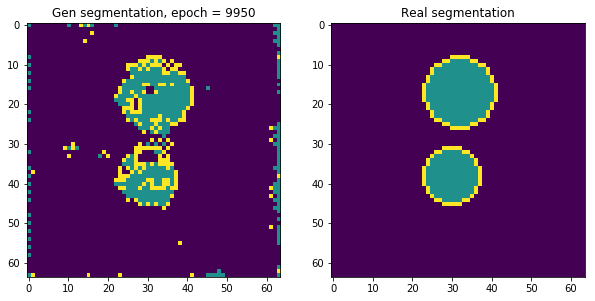

epoch - 9950, loss - 0.0155498748645
epoch - 9951, loss - 0.0146953994408
epoch - 9952, loss - 0.014774331823
epoch - 9953, loss - 0.0150402225554
epoch - 9954, loss - 0.0152931008488
epoch - 9955, loss - 0.015824586153
epoch - 9956, loss - 0.0164658240974
epoch - 9957, loss - 0.0178072173148
epoch - 9958, loss - 0.0190318375826
epoch - 9959, loss - 0.0205681957304
epoch - 9960, loss - 0.021422225982
epoch - 9961, loss - 0.0223954766989
epoch - 9962, loss - 0.0226142592728
epoch - 9963, loss - 0.0225336365402
epoch - 9964, loss - 0.0214329380542
epoch - 9965, loss - 0.0198701173067
epoch - 9966, loss - 0.017118902877
epoch - 9967, loss - 0.0141372159123
epoch - 9968, loss - 0.0110160009935
epoch - 9969, loss - 0.00821491423994
epoch - 9970, loss - 0.00607656687498
epoch - 9971, loss - 0.00514735840261
epoch - 9972, loss - 0.00522159365937
epoch - 9973, loss - 0.00588788557798
epoch - 9974, loss - 0.00666255876422
epoch - 9975, loss - 0.00750631652772
epoch - 9976, loss - 0.008134432137

In [22]:
torch.manual_seed(42)
loss_10, loss_100, segm_loss_10, segm_loss_100 = generate_and_train(network_class=Unet)

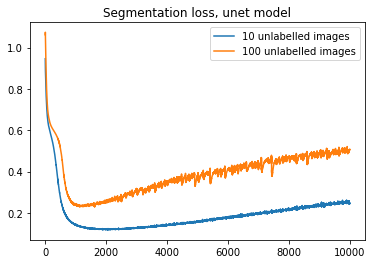

In [23]:
plt.plot(segm_loss_10, label='10 unlabelled images')
plt.plot(segm_loss_100, label='100 unlabelled images')
plt.title('Segmentation loss, unet model')
plt.legend()
plt.show()

### Segmentation loss

In [ ]:
plt.plot(segmentation_loss)
plt.title('Segmentation loss on unlabelled data')
plt.xlabel('# epoch')
plt.show()

In [ ]:
print('iteration with'.format(np.argmin(segmentation_loss)))

In [ ]:
torch.save(net.state_dict(), './model-1000')

### learning

In [ ]:
plt.plot(loss_epoch)
plt.title('loss')
plt.xlabel('# epoch')
plt.show()

In [ ]:
img, segm = net(z_input)

### Results 

In [ ]:
show_image_segm(img.data.numpy(), segm.data.numpy(), 
                train_images.data.numpy(), train_segmentation.data.numpy())

### generate test batch

In [ ]:
test_batch_size = 5

In [ ]:
np.random.seed(42)
test_images, test_segmentation = predata.get_train_batch(test_batch_size)

In [ ]:
test_images = Variable(torch.from_numpy(test_images).float(), requires_grad=False)
test_segm = Variable(torch.from_numpy(test_segmentation), requires_grad=False)

In [ ]:
torch.manual_seed(42)
z_test = Variable(torch.randn(test_batch_size, 3, 64, 64), requires_grad=True)

### Optimizing only latent variable z

In [ ]:
optimizer = optim.Adam([z_test], lr=0.001)

test_loss = []
num_epochs = 1000

for epoch in range(num_epochs):
    normalize_z(z_test)
    optimizer.zero_grad()   
    img, segm = net(z_test)
    loss = 1000 * img_loss(img, test_images)
    loss_epoch.append(loss.data)
    loss.backward()
    optimizer.step()
    print('epoch - {}, loss - {}'.format(epoch, loss.data.numpy()[0]))

normalize_z(z_test)

In [ ]:
test_img, test_segm = net(z_test)

In [ ]:
show_image_segm(test_img.data.numpy(), test_segm.data.numpy(), 
                test_images.data.numpy(), test_segmentation)